# Advanced Lane Finding

## Imports

In [2]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from os.path import splitext, basename, join

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

%matplotlib inline

## Helpers

In [3]:
def to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def to_bgr(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def to_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def to_lab(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

def to_luv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def read_image(path):
    return to_rgb(cv2.imread(path))

def plot_images(images, labels):
    rows = len(images)
    cols = len(images[0])
    cmap = None

    f, axes = plt.subplots(rows, cols, figsize=(12,20))
    
    for i, row in enumerate(images):
        for j, image in enumerate(row):
            label = labels[i][j]
            
            ax = axes[i, j] if rows > 1 else axes[j]
            
            if len(image.shape) < 3 or img.shape[-1] < 3:
                cmap = "gray"

            ax.imshow(image, cmap=cmap)
            ax.set_title(label, fontsize=20)

    plt.tight_layout()
    plt.show()
    
    return

def map_to_list(fn, args):
    return list(map(fn, args))

def zip_to_list(l1, l2):
    return list(zip(l1, l2))

## Camera calibration

In [4]:
def calibrate(img_pattern):
    # Arrays to store object points and image points from all the images
    obj_points = []
    img_points = []

    # Prepare object points
    objp = np.zeros((9*6, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    calibration_images = glob.glob(img_pattern)

    for index, img_path in enumerate(calibration_images):
        img = cv2.imread(img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray_img, (9, 6), None)

        if ret == True:
            img_points.append(corners)
            obj_points.append(objp)
            
    # We know that the calibration and car images have the same size
    img_size = (1280, 720)
    
    # Do camera calibration given object points and image points
    # return obj_points, img_points
    return cv2.calibrateCamera(obj_points, img_points, img_size, None, None)


### Testing undistortion on chessboard

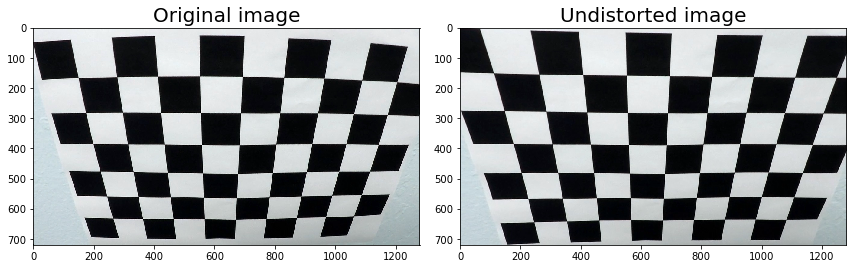

In [5]:
# calibrate the camera 
ret, mtx, dist, rvecs, tvecs = calibrate('camera_cal/calibration*.jpg')

def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

img = cv2.imread('camera_cal/calibration2.jpg')
undist = undistort(img, mtx, dist)

#cv2.imwrite('examples/undistorted.jpg', dst)

plot_images([[img, undist]], [['Original image', 'Undistorted image']])

### Undistorting test images

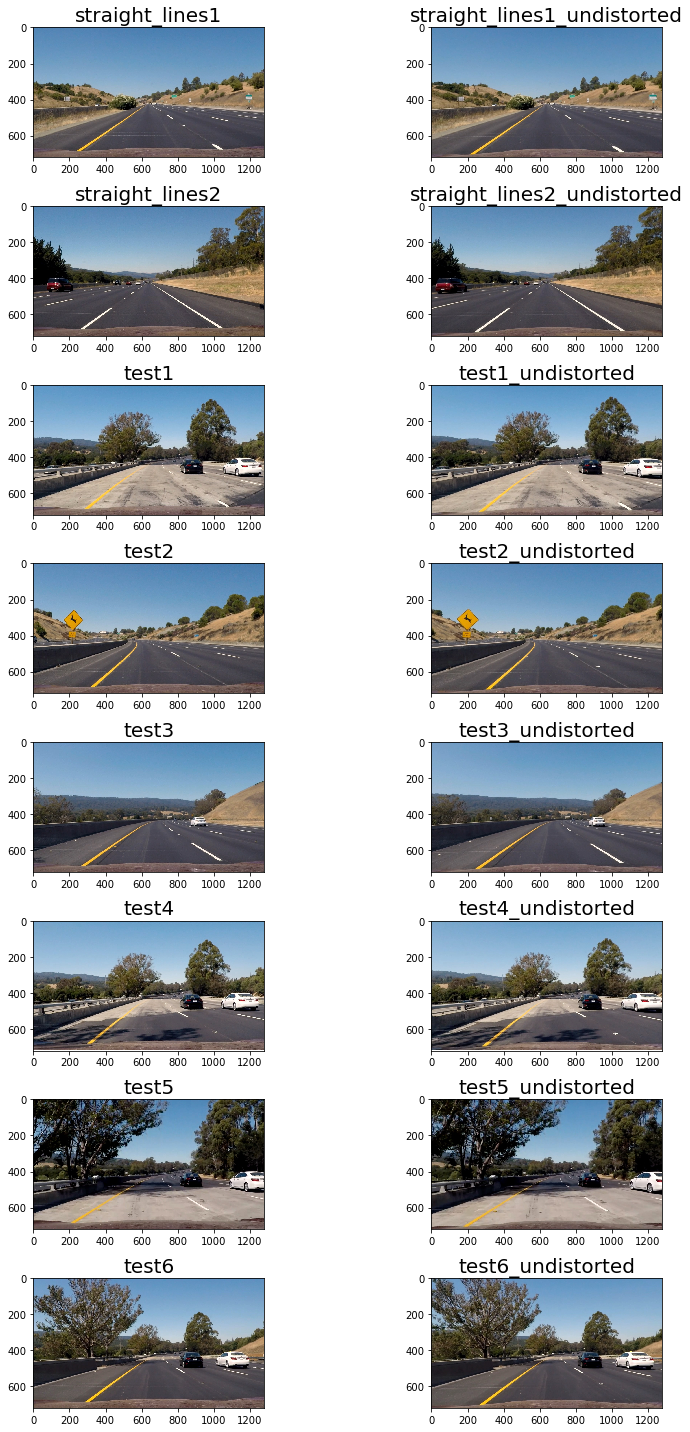

In [6]:
#img = cv2.imread('test_images/test1.jpg')
#dst = cv2.undistort(img, mtx, dist, None, mtx)

test_images_pattern = 'test_images/*.jpg'
test_images_paths = glob.glob(test_images_pattern)

test_images_labels = map_to_list(lambda path: splitext(basename(path))[0], test_images_paths)
undist_test_images_labels = map_to_list(lambda label: label + '_undistorted', test_images_labels)

test_images = map_to_list(lambda path: read_image(path), test_images_paths)
undist_test_images = map_to_list(lambda test_image: undistort(test_image, mtx, dist), test_images)

zipped_test_images = zip_to_list(test_images, undist_test_images)
zipped_test_labels = zip_to_list(test_images_labels, undist_test_images_labels)

plot_images(zipped_test_images, zipped_test_labels)

#cv2.imwrite('examples/test_image_undistorted.jpg', to_bgr(undist_test_images[0]))

# Thresholding

## Color thresholding

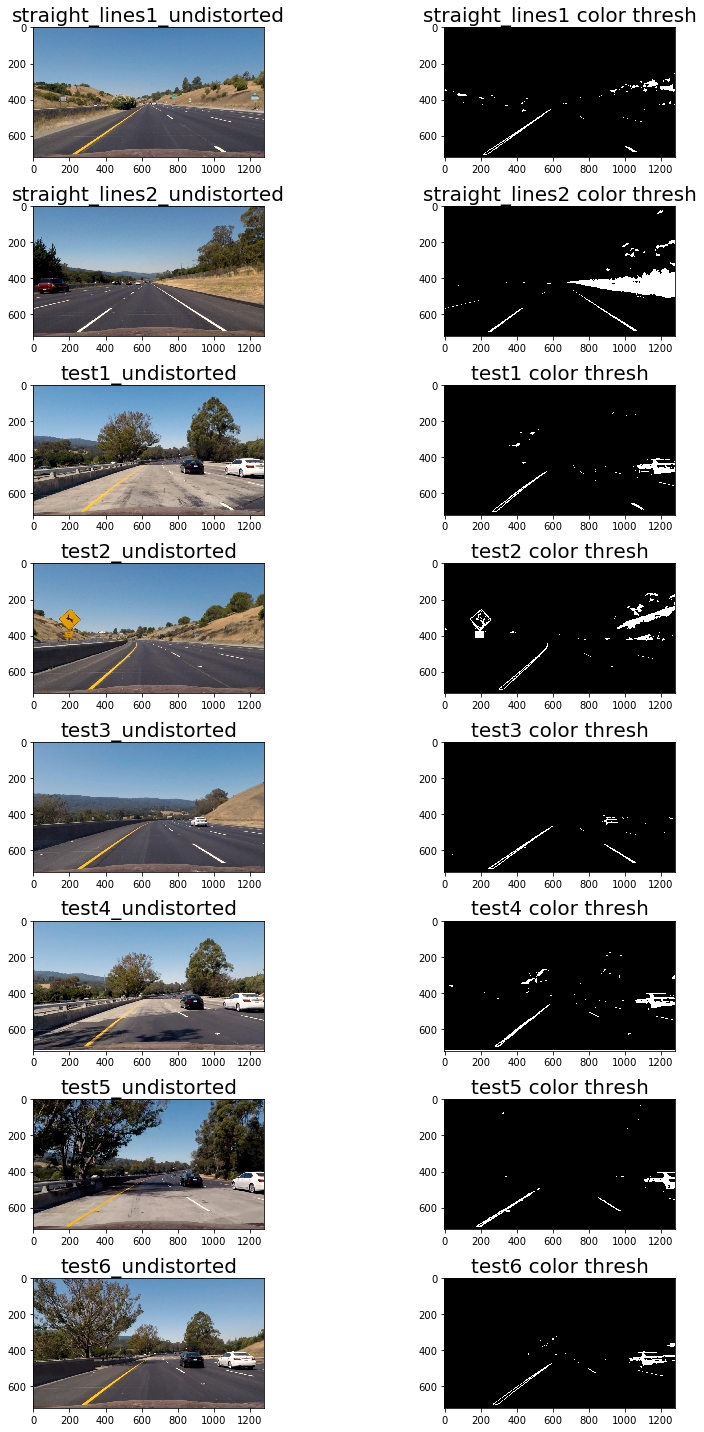

In [8]:
def color_thresholding(img):
    lab = to_lab(img)
    luv = to_luv(img)
    
    binary_yellow = np.zeros_like(lab[:,:,2])
    binary_yellow[(lab[:,:,2] >= 155) & (lab[:,:,2] <= 200)] = 1

    binary_white = np.zeros_like(luv[:,:,0])
    binary_white[(luv[:,:,0] >= 225) & (luv[:,:,0] <= 255)] = 1
    
    binary = np.zeros_like(lab[:,:,0])
    binary[(binary_yellow == 1) | (binary_white == 1)] = 1
    
    return binary

def color_thresholding2(img):
    hls = to_hls(img)
    
    binary_yellow = np.zeros_like(hls[:,:,0])
    binary_yellow[((hls[:,:,0] >= 20) & (hls[:,:,0] <= 45)) & ((hls[:,:,1] >= 120) & (hls[:,:,1] <= 200)) & ((hls[:,:,2] >= 80) & (hls[:,:,2] <= 255))] = 1

    binary_white = np.zeros_like(hls[:,:,0])
    binary_white[((hls[:,:,0] >= 0) & (hls[:,:,0] <= 255)) & ((hls[:,:,1] >= 200) & (hls[:,:,1] <= 255)) & ((hls[:,:,2] >= 0) & (hls[:,:,2] <= 255))] = 1
    
    binary = np.zeros_like(hls[:,:,0])
    binary[(binary_yellow == 1) | (binary_white == 1)] = 1
    
    return binary

color_undist_test_images = map_to_list(lambda img: color_thresholding(img), undist_test_images)
color_undist_test_images_labels = map_to_list(lambda label: label + ' color thresh', test_images_labels)

zipped_color_undist_test_images = zip_to_list(undist_test_images, color_undist_test_images)
zipped_color_undist_test_labels = zip_to_list(undist_test_images_labels, color_undist_test_images_labels)

plot_images(zipped_color_undist_test_images, zipped_color_undist_test_labels)

## Gradient thresholding

In [9]:
def abs_sobel_thresh(gray_img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

def mag_thresh(gray_img, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <=  mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(gray_img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    
    dir_binary = np.zeros_like(dir_sobel)
    dir_binary[(dir_sobel >= thresh[0]) & (dir_sobel <=  thresh[1])] = 1
    
    return dir_binary

In [10]:
def gradient_thresholding(img):
    #gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_img = to_lab(img)[:,:,0]

    # Choose a Sobel kernel size
    ksize = 15 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray_img, orient='x', sobel_kernel=ksize, thresh=(20, 130))
    grady = abs_sobel_thresh(gray_img, orient='y', sobel_kernel=ksize, thresh=(20, 130))
    mag_binary = mag_thresh(gray_img, sobel_kernel=ksize, mag_thresh=(100, 200))
    dir_binary = dir_threshold(gray_img, sobel_kernel=ksize, thresh=(0.75, 1.5))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

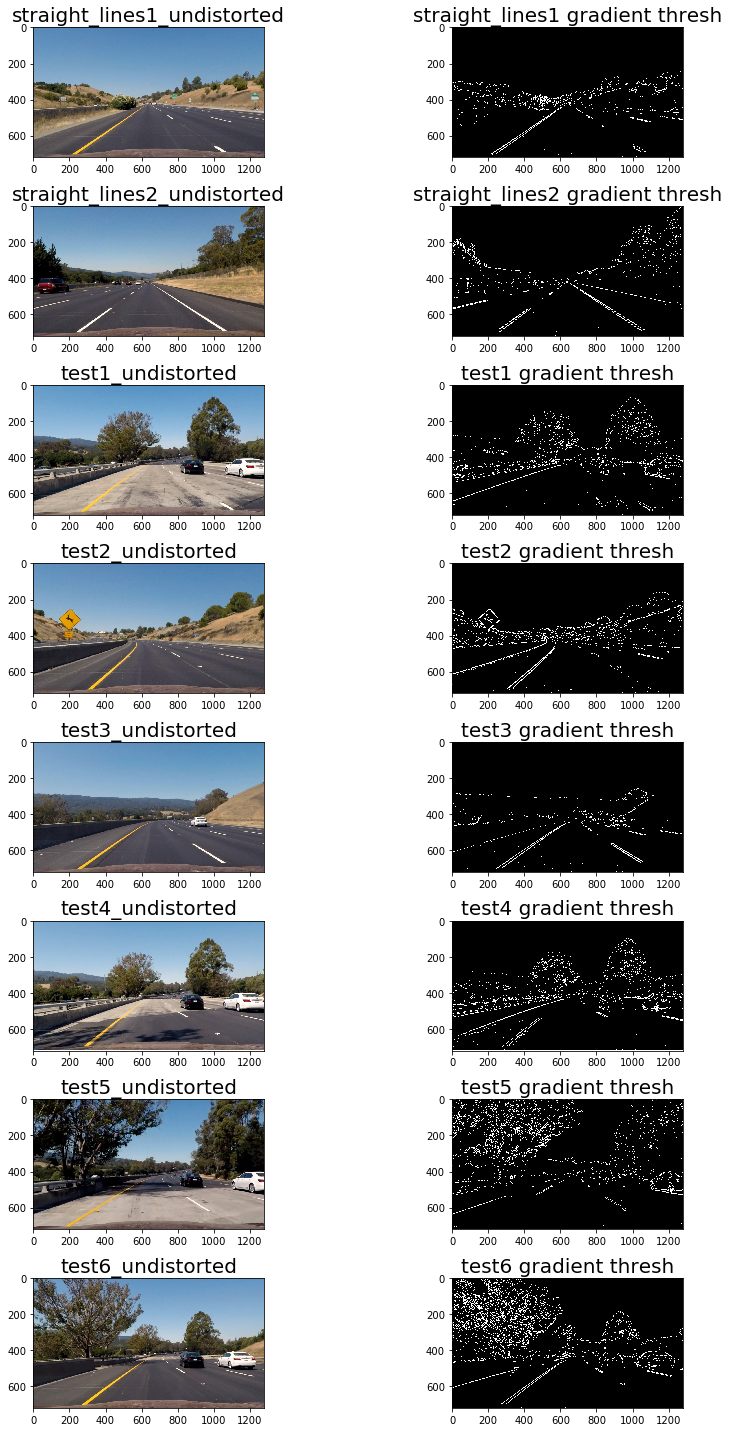

In [11]:
gradient_undist_test_images = map_to_list(lambda img: gradient_thresholding(img), undist_test_images)
gradient_undist_test_images_labels = map_to_list(lambda label: label + ' gradient thresh', test_images_labels)

zipped_gradient_undist_test_images = zip_to_list(undist_test_images, gradient_undist_test_images)
zipped_gradient_undist_test_labels = zip_to_list(undist_test_images_labels, gradient_undist_test_images_labels)

plot_images(zipped_gradient_undist_test_images, zipped_gradient_undist_test_labels)

## Combined color and gradient thresholding

In [12]:
def combined_thresholding(img):
    color_binary = color_thresholding(img)
    gradient_binary = gradient_thresholding(img)
    
    combined_binary = np.zeros_like(color_binary)
    combined_binary[(gradient_binary == 1) | (color_binary == 1)] = 1
        
    return combined_binary

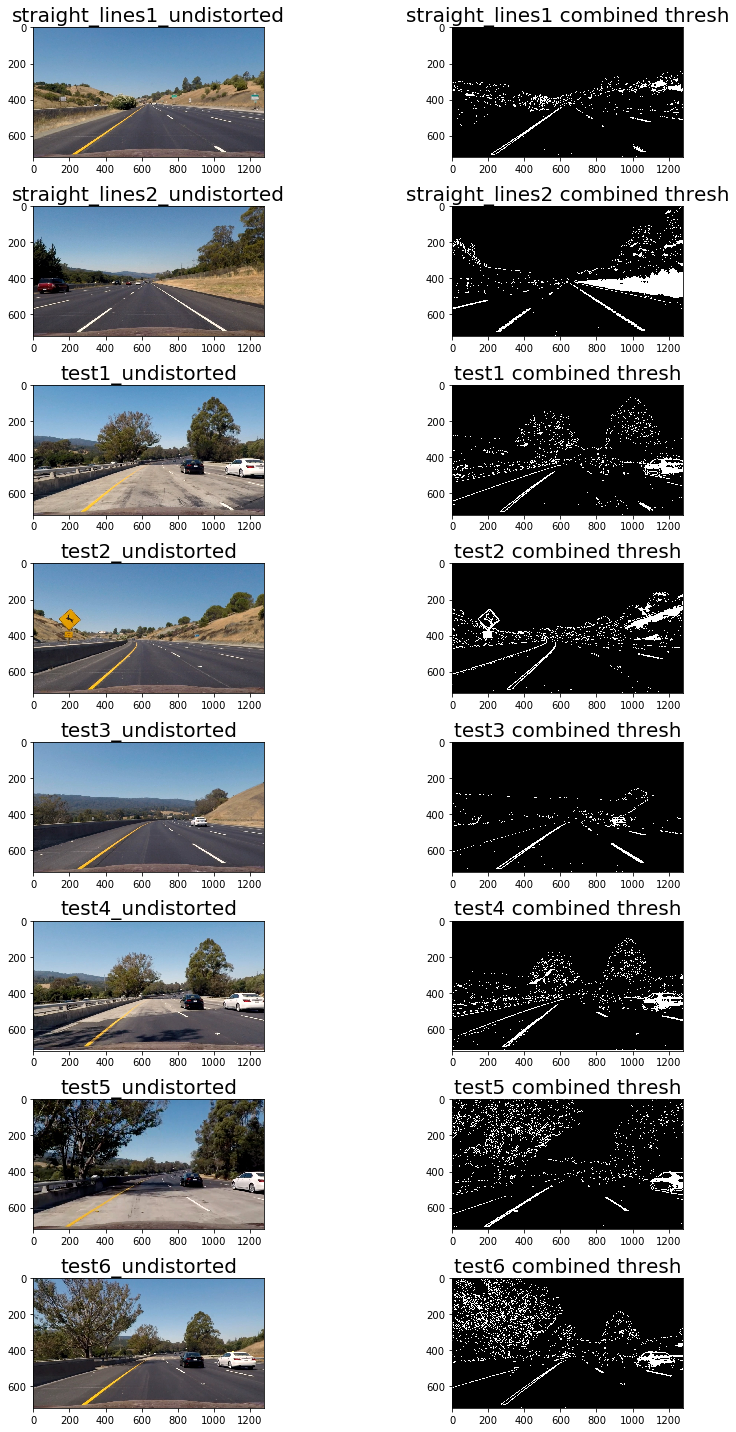

True

In [13]:
combined_undist_test_images = map_to_list(lambda img: combined_thresholding(img), undist_test_images)
combined_undist_test_images_labels = map_to_list(lambda label: label + ' combined thresh', test_images_labels)

zipped_combined_undist_test_images = zip_to_list(undist_test_images, combined_undist_test_images)
zipped_combined_undist_test_labels = zip_to_list(undist_test_images_labels, combined_undist_test_images_labels)

plot_images(zipped_combined_undist_test_images, zipped_combined_undist_test_labels)

cv2.imwrite('examples/test_image_combined.jpg', combined_undist_test_images[1])

# Perspective transform

In [14]:
def warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)

## Visualisation

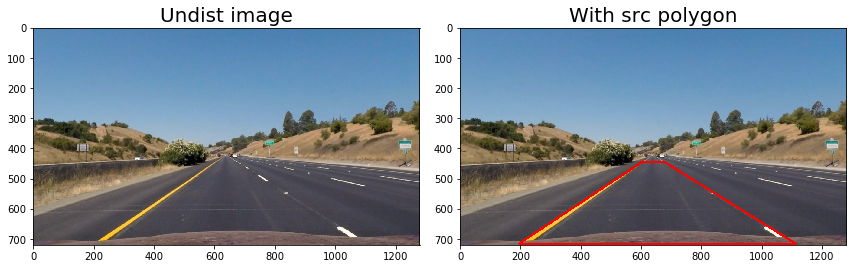

In [15]:
not_warped_test_img = np.copy(undist_test_images[0])
bottom_y = not_warped_test_img.shape[0] - 5

#src = np.array([[200, bottom_y], [600, 450], [680, 450], [1095, bottom_y]], np.float32)
src = np.array([[195, bottom_y], [602, 445], [675, 445], [1110, bottom_y]], np.float32)
#dst = np.array([[200, bottom_y], [200, 0], [1000, 0], [1000, bottom_y]], np.float32)
dst = np.array([[320, bottom_y], [320, 0], [960, 0], [960, bottom_y]], np.float32)

# draw src_points polygon on warp_test_img
src_polygon = src.astype(np.int32)
cv2.polylines(not_warped_test_img, [src_polygon], True, (255,0,0), 5)

plot_images([[undist_test_images[0], not_warped_test_img]], [['Undist image', 'With src polygon']])

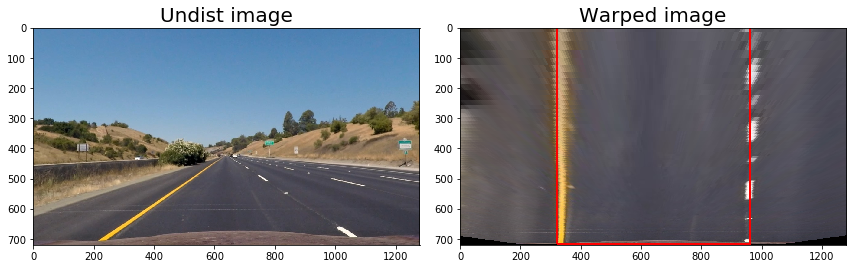

In [16]:
warped_test_img = warp(undist_test_images[0], src, dst)

# draw dst polygon on warp_test_img
dst_polygon = dst.astype(np.int32)
cv2.polylines(warped_test_img, [dst_polygon], True, (255,0,0), 5)

plot_images([[undist_test_images[0], warped_test_img]], [['Undist image', 'Warped image']])

#cv2.imwrite('examples/test_image_warped.jpg', to_bgr(warped_test_img))

## Applying on test images

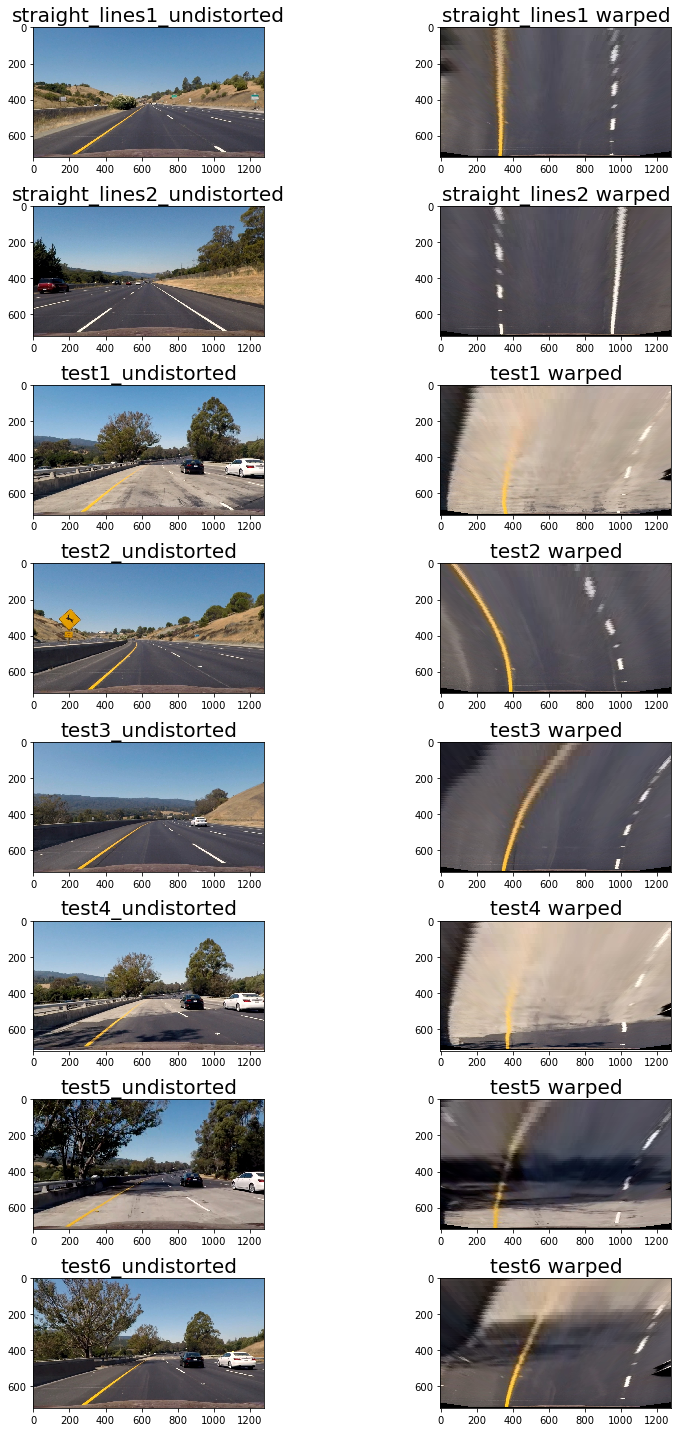

In [17]:
warped_undist_test_images = map_to_list(lambda img: warp(img, src, dst), undist_test_images)
warped_undist_test_images_labels = map_to_list(lambda label: label + ' warped', test_images_labels)

zipped_warped_undist_test_images = zip_to_list(undist_test_images, warped_undist_test_images)
zipped_warped_undist_test_labels = zip_to_list(undist_test_images_labels, warped_undist_test_images_labels)

plot_images(zipped_warped_undist_test_images, zipped_warped_undist_test_labels)

# Thresholding + warp

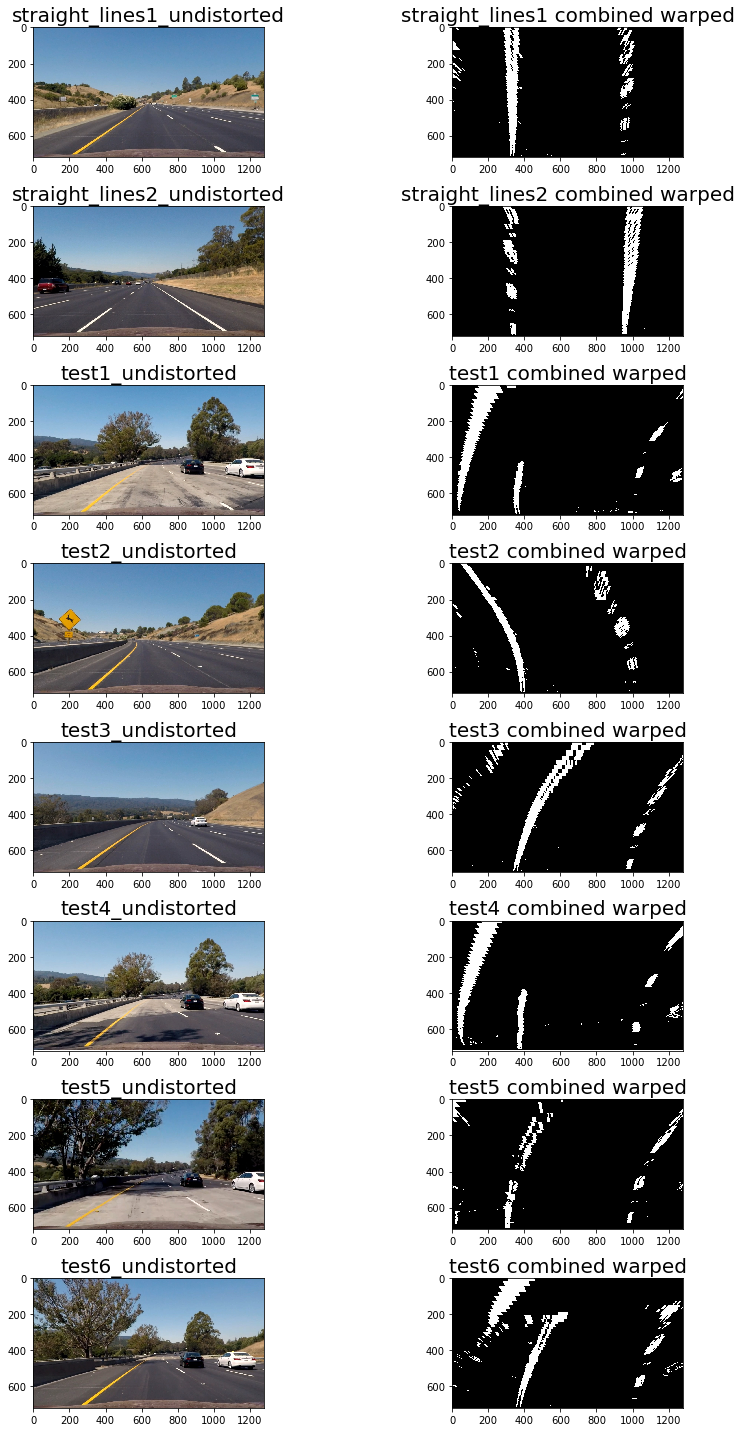

In [18]:
warped_combined_undist_test_images = map_to_list(lambda img: warp(img, src, dst), combined_undist_test_images)
warped_combined_undist_test_images_labels = map_to_list(lambda label: label + ' combined warped', test_images_labels)

zipped_warped_combined_undist_test_images = zip_to_list(undist_test_images, warped_combined_undist_test_images)
zipped_warped_combined_undist_test_labels = zip_to_list(undist_test_images_labels, warped_combined_undist_test_images_labels)

plot_images(zipped_warped_combined_undist_test_images, zipped_warped_combined_undist_test_labels)

# Pipeline

In [19]:
class LaneLine():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        self.polynomials = []
        
    def update(self, polynomial):
        self.detected = True
        
        self.polynomials.append(polynomial)
        
        if len(self.polynomials) > 5:
            self.polynomials = self.polynomials[1:]
        
    def get_smoothed_fit(self):        
        return np.mean(self.polynomials, axis=0)

class LaneLineDetector:
    def __init__(self, mtx, dist, warp_src, warp_dst):
        self.mtx = mtx
        self.dist = dist
        self.warp_src = warp_src
        self.warp_dst = warp_dst
        
        self.perspective_M = cv2.getPerspectiveTransform(warp_src, warp_dst)
        self.inverse_perspective_M = cv2.getPerspectiveTransform(warp_dst, warp_src)
        
        # Define conversions in x and y from pixels space to meters
        self.ym_per_pix = 30 / 720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7 / 700 # meters per pixel in x dimension
        
        self.left_lane = LaneLine()
        self.right_lane = LaneLine()
        
        self.current_frame_index = 0
        
    def process_image(self, image):
        undist_image = undistort(image, self.mtx, self.dist)
        warped_image = warp(undist_image, self.warp_src, self.warp_dst)
        combined_image = combined_thresholding(warped_image)
        
        final_image = self.find_lane_lines(combined_image, undist_image)
        
        return final_image
    
    def find_lane_lines(self, image, undist_image):
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
        
        # Create an output image to draw on and  visualize the result
        out_image = np.dstack((image, image, image))*255
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Choose the number of sliding windows
        nwindows = 9
        
        # Set height of windows
        window_height = np.int(image.shape[0] / nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = image.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Set the width of the windows +/- margin
        margin = 100
        
        # Set minimum number of pixels found to recenter window
        minpix = 50
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        if self.left_lane.detected and self.right_lane.detected:
            left_fit = self.left_lane.get_smoothed_fit()
            right_fit = self.right_lane.get_smoothed_fit()
            
            left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                                left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                                left_fit[1]*nonzeroy + left_fit[2] + margin))) 

            right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                                right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                                right_fit[1]*nonzeroy + right_fit[2] + margin)))  
        else:
            # Step through the windows one by one
            for window in range(nwindows):
                # Identify window boundaries in x and y (and right and left)
                win_y_low = image.shape[0] - (window + 1) * window_height
                win_y_high = image.shape[0] - window * window_height
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                # Draw the windows on the visualization image
                cv2.rectangle(out_image, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2) 
                cv2.rectangle(out_image, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2) 

                # Identify the nonzero pixels in x and y within the window
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Check distance between left and right lane
        testy = np.asarray([50., 300., 500., 700., 900.])
        test_left_fitx = left_fit[0] * testy**2 + left_fit[1] * testy + left_fit[2]
        test_right_fitx = right_fit[0] * testy**2 + right_fit[1] * testy + right_fit[2]
        
        dist = np.absolute(np.asarray(test_left_fitx) - np.asarray(test_right_fitx))
        max_dist = dist[np.argmax(dist)]
        
        print('max_dist', max_dist)
        
        if self.current_frame_index > 0 and max_dist < 700:
            self.left_lane.update(left_fit)
            self.right_lane.update(right_fit)
            
            final_left_fit = self.left_lane.get_smoothed_fit()
            final_right_fit =  self.right_lane.get_smoothed_fit()
        else:
            final_left_fit = left_fit
            final_right_fit =  right_fit
        
        print('final_left_fit', final_left_fit)
        print('final_right_fit', final_right_fit)
        
        #final_left_fit = left_fit
        #final_right_fit =  right_fit
        #print('final_left_fit', final_left_fit)
        #print('final_right_fit', final_right_fit)
        
        ploty = np.linspace(0, image.shape[0] - 1, image.shape[0])
        left_fitx = final_left_fit[0] * ploty**2 + final_left_fit[1] * ploty + final_left_fit[2]
        right_fitx = final_right_fit[0] * ploty**2 + final_right_fit[1] * ploty + final_right_fit[2]
        
        out_image[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_image[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_image)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        #cv2.imwrite('examples/test_image_sliding_window.jpg', to_bgr(out_image))
        
        left_curverad, right_curverad, center_offset_meters = self.compute_lane_lines_curvature(left_fitx, right_fitx, final_left_fit, final_right_fit)
        image_with_lane_lines = self.draw_lanes_area(image, undist_image, left_fitx, right_fitx)
        image_with_curvature = self.draw_lanes_curvature(image_with_lane_lines, left_curverad, right_curverad, center_offset_meters)

        self.current_frame_index += 1
        
        return image_with_curvature
        
    def compute_lane_lines_curvature(self, leftx, rightx, left_fit, right_fit):
        ploty = np.linspace(0, 719, num=720)
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)
        
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty * self.ym_per_pix, leftx * self.xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty * self.ym_per_pix, rightx * self.xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * self.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * self.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        # Calculate the center offset
        center_offset = (((left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]) + (right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2])) / 2) - 640
        center_offset_meters = center_offset * self.xm_per_pix
        
        # Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm', center_offset_meters, 'm')
        return left_curverad, right_curverad, center_offset_meters
        # Example values: 632.1 m    626.2 m
        
    def draw_lanes_area(self, combined_image, undist_image, left_fitx, right_fitx):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(combined_image).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, combined_image.shape[0] - 1, combined_image.shape[0])
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        new_warp = cv2.warpPerspective(color_warp, self.inverse_perspective_M, (combined_image.shape[1], combined_image.shape[0]))

        # Combine the result with the original image
        result = cv2.addWeighted(undist_image, 1, new_warp, 0.3, 0)
        
        return result
    
    def draw_lanes_curvature(self, image, left_curverad, right_curverad, center_offset_meters):
        left_txt = "Curvature left = {:.4f}m".format(left_curverad)
        right_txt = "Curvature right = {:.4f}m".format(right_curverad)
        center_txt = "Center offset = {:.4f}m".format(center_offset_meters)
        with_left = cv2.putText(image, left_txt, (25, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        with_right = cv2.putText(image, right_txt, (25, 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        result = cv2.putText(image, center_txt, (25, 180), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2, cv2.LINE_AA)
        return result
        

## Testing the pipeline on test images

max_dist 644.614503855
final_left_fit [ -6.92235842e-05   7.22733167e-02   3.18026819e+02]
final_right_fit [ -7.87128348e-05   3.02275550e-02   9.64767334e+02]
2372.45263513 m 2086.75005093 m 3.9432725815e-05 m


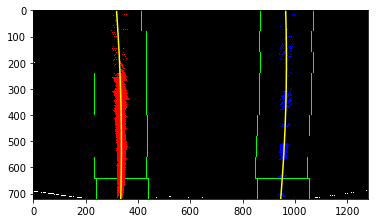

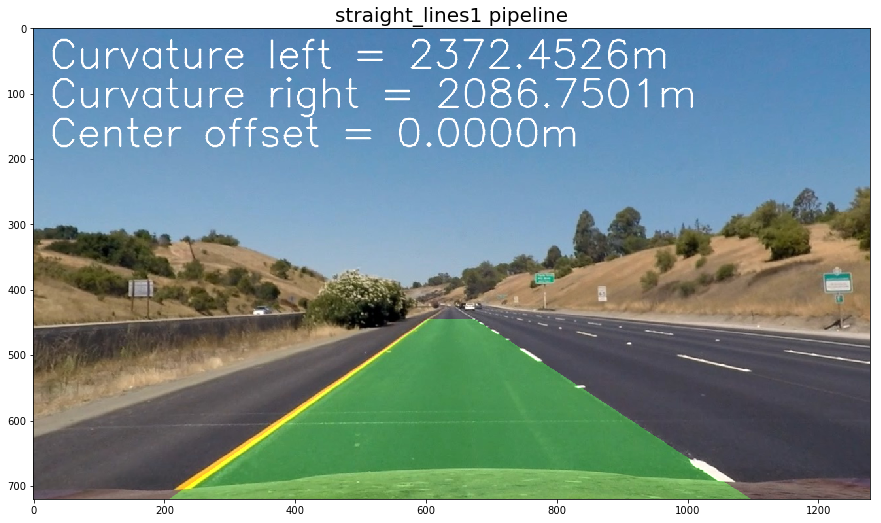

True

In [20]:
test_detector = LaneLineDetector(mtx, dist, src, dst)

pipeline_test_images = map_to_list(lambda img: test_detector.process_image(img), test_images[:1])
pipeline_test_images_labels = map_to_list(lambda label: label + ' pipeline', test_images_labels)

for i, image in enumerate(pipeline_test_images):
    label = pipeline_test_images_labels[i]
    plt.figure(figsize=(15,10))
    plt.imshow(image)
    plt.title(label, fontsize=20)
    plt.show()
    
    
cv2.imwrite('examples/test_image_area.jpg', to_bgr(pipeline_test_images[0]))

# Testing on video

In [21]:
videos_path = 'test_videos'
videos_output_path = 'test_videos_output'

project_video_path = join(videos_path, 'project_video.mp4')
project_video_output_path = join(videos_output_path, 'project_video_output.mp4')

sample_project_video_path = join(videos_path, 'sample_project_video.mp4')
sample_project_video_output_path = join(videos_output_path, 'sample_project_video_output.mp4')

## Create sample

In [22]:
if False:
   ffmpeg_extract_subclip(project_video_path, 22, 25, targetname=sample_project_video_path)

## Sample

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m
[MoviePy] >>>> Building video test_videos_output/sample_project_video_output.mp4
[MoviePy] Writing video test_videos_output/sample_project_video_output.mp4


  1%|▏         | 1/75 [00:00<00:19,  3.84it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


  3%|▎         | 2/75 [00:00<00:18,  3.90it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


  4%|▍         | 3/75 [00:00<00:18,  3.94it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


  5%|▌         | 4/75 [00:00<00:17,  4.00it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


  7%|▋         | 5/75 [00:01<00:17,  4.03it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


  8%|▊         | 6/75 [00:01<00:17,  4.05it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


  9%|▉         | 7/75 [00:01<00:17,  3.99it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


 11%|█         | 8/75 [00:02<00:17,  3.92it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


 12%|█▏        | 9/75 [00:02<00:17,  3.83it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


 13%|█▎        | 10/75 [00:02<00:16,  3.88it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


 15%|█▍        | 11/75 [00:02<00:16,  3.88it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


 16%|█▌        | 12/75 [00:03<00:16,  3.80it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


 17%|█▋        | 13/75 [00:03<00:16,  3.84it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


 19%|█▊        | 14/75 [00:03<00:15,  3.87it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


 20%|██        | 15/75 [00:03<00:15,  3.75it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


 21%|██▏       | 16/75 [00:04<00:15,  3.81it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


 23%|██▎       | 17/75 [00:04<00:14,  3.88it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


 24%|██▍       | 18/75 [00:04<00:14,  3.95it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


 25%|██▌       | 19/75 [00:04<00:14,  3.93it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


 27%|██▋       | 20/75 [00:05<00:13,  3.99it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


 28%|██▊       | 21/75 [00:05<00:13,  3.93it/s]

max_dist 742.356866585
final_left_fit [  3.22035279e-05   1.87869905e-03   3.24933256e+02]
final_right_fit [  6.45298092e-05  -1.38420913e-01   1.07422429e+03]
5099.93602006 m 2545.10251598 m 0.187619215824 m


 29%|██▉       | 22/75 [00:05<00:13,  3.91it/s]

max_dist 761.174921384
final_left_fit [ -7.50521835e-05   1.12901883e-01   2.98354877e+02]
final_right_fit [  5.40997214e-05  -1.32341510e-01   1.07146909e+03]
2188.16851556 m 3035.84783008 m 0.171826065227 m


 31%|███       | 23/75 [00:05<00:13,  3.81it/s]

max_dist 820.831847822
final_left_fit [ -2.25912819e-04   2.98764019e-01   2.38701481e+02]
final_right_fit [  1.24339236e-05  -1.16472661e-01   1.07969930e+03]
726.959310279 m 13211.0561412 m 0.156213997366 m


 32%|███▏      | 24/75 [00:06<00:13,  3.87it/s]

max_dist 794.670241895
final_left_fit [ -1.69941084e-04   2.25635398e-01   2.65181011e+02]
final_right_fit [  6.98571487e-05  -1.45088217e-01   1.07778794e+03]
966.382670921 m 2351.00669337 m 0.182734756124 m


 33%|███▎      | 25/75 [00:06<00:13,  3.80it/s]

max_dist 720.980419495
final_left_fit [  4.85276257e-05  -4.68538587e-02   3.50675456e+02]
final_right_fit [  1.12260975e-04  -1.68373904e-01   1.07757254e+03]
3384.23338011 m 1462.90300838 m 0.202497496226 m


 35%|███▍      | 26/75 [00:06<00:12,  3.82it/s]

max_dist 725.661384843
final_left_fit [ -1.75310943e-05   1.87352491e-02   3.37175488e+02]
final_right_fit [  1.74892171e-04  -1.99976806e-01   1.07329142e+03]
9367.74911975 m 939.077189969 m 0.215402807877 m


 36%|███▌      | 27/75 [00:06<00:12,  3.87it/s]

max_dist 702.502589594
final_left_fit [  1.69482098e-04  -2.12310418e-01   4.09745359e+02]
final_right_fit [  2.58617360e-04  -2.46652737e-01   1.07095647e+03]
969.014653502 m 635.258629488 m 0.243190553352 m


 37%|███▋      | 28/75 [00:07<00:11,  3.92it/s]

max_dist 714.643976513
final_left_fit [  8.69592536e-05  -1.21799715e-01   3.87631095e+02]
final_right_fit [  3.00077745e-04  -2.73876017e-01   1.06651776e+03]
1888.54850734 m 547.608904484 m 0.237172754447 m


 39%|███▊      | 29/75 [00:07<00:11,  4.00it/s]

max_dist 701.811524369
final_left_fit [  4.66727310e-05  -7.90211342e-02   3.78015335e+02]
final_right_fit [  2.37030187e-04  -2.14580219e-01   1.04764050e+03]
3518.6989325 m 693.118200703 m 0.214652336916 m


 40%|████      | 30/75 [00:07<00:11,  4.06it/s]

max_dist 680.876628468
final_left_fit [  4.81588793e-05  -8.00563384e-02   3.77683307e+02]
final_right_fit [  1.67542760e-04  -1.73592681e-01   1.04604170e+03]
3410.1123606 m 980.315117603 m 0.192560412739 m


 41%|████▏     | 31/75 [00:07<00:10,  4.01it/s]

max_dist 709.315969028
final_left_fit [  7.72435847e-05  -1.21846549e-01   3.91758350e+02]
final_right_fit [  2.76522211e-04  -2.55077738e-01   1.05956670e+03]
2126.09483648 m 594.192059936 m 0.219884677143 m


 43%|████▎     | 32/75 [00:08<00:10,  4.00it/s]

max_dist 701.595420189
final_left_fit [  1.10048985e-04  -1.51129696e-01   3.95659738e+02]
final_right_fit [  2.79357726e-04  -2.67394592e-01   1.06475348e+03]
1492.30752055 m 588.128558628 m 0.213549045465 m


 44%|████▍     | 33/75 [00:08<00:10,  3.87it/s]

max_dist 702.577635802
final_left_fit [  1.00356316e-04  -1.38269348e-01   3.91864922e+02]
final_right_fit [  3.03397114e-04  -2.87265811e-01   1.06407633e+03]
1636.4378194 m 541.583162572 m 0.208009373386 m


 45%|████▌     | 34/75 [00:08<00:10,  3.93it/s]

max_dist 706.73867019
final_left_fit [  7.44070245e-05  -1.12981532e-01   3.88273975e+02]
final_right_fit [  3.23204190e-04  -2.91258388e-01   1.05393611e+03]
2207.14199725 m 508.48996697 m 0.203793556015 m


 47%|████▋     | 35/75 [00:08<00:10,  3.98it/s]

max_dist 688.125931872
final_left_fit [  6.64883824e-05  -9.15179217e-02   3.75465758e+02]
final_right_fit [  2.16090805e-04  -2.26651731e-01   1.05790143e+03]
2470.00734853 m 760.119142255 m 0.186812006165 m


 48%|████▊     | 36/75 [00:09<00:09,  4.03it/s]

max_dist 711.427848828
final_left_fit [  6.38548968e-06  -3.57654631e-02   3.65733388e+02]
final_right_fit [  3.31581754e-04  -3.17119390e-01   1.06697080e+03]
25719.1752393 m 495.58769276 m 0.194767630762 m


 49%|████▉     | 37/75 [00:09<00:09,  4.05it/s]

max_dist 706.508534064
final_left_fit [  4.79403442e-05  -6.17268287e-02   3.63564341e+02]
final_right_fit [  3.52004298e-04  -3.45407216e-01   1.07909342e+03]
3425.65193526 m 466.838642439 m 0.202665295118 m


 51%|█████     | 38/75 [00:09<00:09,  4.09it/s]

max_dist 720.952730313
final_left_fit [  6.61579467e-05  -7.83843892e-02   3.68541457e+02]
final_right_fit [  4.31227241e-04  -3.98094289e-01   1.08152697e+03]
2482.35997735 m 381.288898999 m 0.223609500276 m


 52%|█████▏    | 39/75 [00:09<00:08,  4.10it/s]

max_dist 759.829040071
final_left_fit [  8.36637939e-05  -8.79730313e-02   3.66275516e+02]
final_right_fit [  5.71863955e-04  -4.96456441e-01   1.09829749e+03]
1962.98618564 m 287.914483309 m 0.272876321024 m


 53%|█████▎    | 40/75 [00:10<00:08,  4.04it/s]

max_dist 755.142135181
final_left_fit [  5.33432921e-05  -3.18645182e-02   3.37958708e+02]
final_right_fit [  4.84558647e-04  -4.65654636e-01   1.11371231e+03]
3078.82569793 m 339.357412018 m 0.243219685677 m


 55%|█████▍    | 41/75 [00:10<00:08,  4.08it/s]

max_dist 778.785072925
final_left_fit [  7.46287964e-05  -2.71894155e-02   3.22883205e+02]
final_right_fit [  4.38638128e-04  -4.55030031e-01   1.12215029e+03]
2200.92225962 m 374.680528222 m 0.22109268278 m


 56%|█████▌    | 42/75 [00:10<00:08,  4.06it/s]

max_dist 766.273346466
final_left_fit [  1.11588045e-04  -7.93339013e-02   3.40802869e+02]
final_right_fit [  3.60964759e-04  -4.20785779e-01   1.12352537e+03]
1471.95714552 m 455.07218106 m 0.182445827722 m


 57%|█████▋    | 43/75 [00:10<00:08,  3.98it/s]

max_dist 777.803874931
final_left_fit [  1.44044291e-04  -9.91329152e-02   3.37680014e+02]
final_right_fit [  4.20620030e-04  -4.70852413e-01   1.13337842e+03]
1140.43374974 m 390.608867439 m 0.193320823212 m


 59%|█████▊    | 44/75 [00:11<00:07,  4.01it/s]

max_dist 794.312452661
final_left_fit [  1.16386166e-04  -6.41491521e-02   3.24234269e+02]
final_right_fit [  3.47364407e-04  -4.37829712e-01   1.13665330e+03]
1411.41310603 m 472.822792982 m 0.157793716113 m


 60%|██████    | 45/75 [00:11<00:07,  4.04it/s]

max_dist 786.184800284
final_left_fit [  1.38182515e-04  -9.81566250e-02   3.37060550e+02]
final_right_fit [  4.08797910e-04  -4.88571297e-01   1.14208955e+03]
1188.7669589 m 401.826424687 m 0.158730707854 m


 61%|██████▏   | 46/75 [00:11<00:07,  4.07it/s]

max_dist 807.005001178
final_left_fit [  1.45876787e-04  -8.53362626e-02   3.24012780e+02]
final_right_fit [  3.34193508e-04  -4.48451917e-01   1.14870277e+03]
1126.21148532 m 491.424316886 m 0.150905742049 m


 63%|██████▎   | 47/75 [00:11<00:06,  4.07it/s]

max_dist 814.439298844
final_left_fit [  1.90771918e-04  -1.18778739e-01   3.25359567e+02]
final_right_fit [  3.25850247e-04  -4.53746474e-01   1.15620956e+03]
861.35662975 m 503.997157469 m 0.150634947148 m


 64%|██████▍   | 48/75 [00:12<00:06,  4.08it/s]

max_dist 815.042895773
final_left_fit [  2.08220239e-04  -1.46718786e-01   3.33228644e+02]
final_right_fit [  3.38849387e-04  -4.74386745e-01   1.16432837e+03]
789.160433105 m 484.66189045 m 0.142174597078 m


 65%|██████▌   | 49/75 [00:12<00:06,  4.11it/s]

max_dist 821.146131446
final_left_fit [  2.23816593e-04  -1.67309912e-01   3.37863460e+02]
final_right_fit [  3.67736880e-04  -5.08681078e-01   1.17571835e+03]
734.178859757 m 446.591955425 m 0.141007959154 m


 67%|██████▋   | 50/75 [00:12<00:06,  4.09it/s]

max_dist 828.765974064
final_left_fit [  2.64219656e-04  -2.06009807e-01   3.45102926e+02]
final_right_fit [  5.20935749e-04  -6.24286061e-01   1.19414092e+03]
622.007767609 m 315.371893938 m 0.180126154013 m


 68%|██████▊   | 51/75 [00:12<00:05,  4.04it/s]

max_dist 861.601580985
final_left_fit [  2.09165134e-04  -1.40828457e-01   3.21700087e+02]
final_right_fit [  5.55062162e-04  -6.51092964e-01   1.20795015e+03]
785.638397227 m 296.025401168 m 0.199098168885 m


 69%|██████▉   | 52/75 [00:13<00:05,  3.92it/s]

max_dist 872.289096112
final_left_fit [  2.21208153e-04  -1.48641491e-01   3.19628232e+02]
final_right_fit [  5.23972529e-04  -6.43714844e-01   1.21591409e+03]
742.922778801 m 313.517363425 m 0.187821151199 m


 71%|███████   | 53/75 [00:13<00:05,  3.88it/s]

max_dist 891.040591556
final_left_fit [  2.28200188e-04  -1.72317846e-01   3.30291724e+02]
final_right_fit [  6.84246018e-04  -8.04087645e-01   1.25178069e+03]
720.08269102 m 240.198670602 m 0.189587919687 m


 72%|███████▏  | 54/75 [00:13<00:05,  3.87it/s]

max_dist 885.972858891
final_left_fit [  2.74841533e-04  -2.35751806e-01   3.52550720e+02]
final_right_fit [  7.53023415e-04  -8.77842683e-01   1.26943267e+03]
597.899268883 m 218.311089324 m 0.192069755736 m


 73%|███████▎  | 55/75 [00:13<00:05,  3.92it/s]

max_dist 855.684430399
final_left_fit [  3.84401222e-04  -3.90250107e-01   4.09407959e+02]
final_right_fit [  8.92871580e-04  -1.02015019e+00   1.29531622e+03]
427.49979577 m 184.24002094 m 0.187501697415 m


 75%|███████▍  | 56/75 [00:14<00:04,  3.97it/s]

max_dist 766.512749761
final_left_fit [  4.26945037e-04  -4.98215840e-01   4.63020151e+02]
final_right_fit [  7.28981769e-04  -8.51402768e-01   1.24643716e+03]
384.779800062 m 225.493159562 m 0.149719453548 m


 76%|███████▌  | 57/75 [00:14<00:04,  4.00it/s]

max_dist 733.593526742
final_left_fit [  4.94700305e-04  -5.99644025e-01   5.01482103e+02]
final_right_fit [  7.85480908e-04  -9.01403008e-01   1.24943663e+03]
332.072206981 m 209.340624233 m 0.141312710291 m


 77%|███████▋  | 58/75 [00:14<00:04,  3.95it/s]

max_dist 746.968715941
final_left_fit [  5.11885975e-04  -6.03590854e-01   4.92504346e+02]
final_right_fit [  7.34172890e-04  -8.74553458e-01   1.25246547e+03]
320.962751334 m 223.866733498 m 0.122490869023 m


 79%|███████▊  | 59/75 [00:14<00:04,  3.93it/s]

max_dist 757.162565139
final_left_fit [  5.38956773e-04  -6.22962716e-01   4.90679875e+02]
final_right_fit [  7.32204394e-04  -8.90096100e-01   1.26071599e+03]
304.882326527 m 224.434359973 m 0.10742507337 m


 80%|████████  | 60/75 [00:15<00:03,  3.90it/s]

max_dist 751.723911778
final_left_fit [  5.44776568e-04  -6.35763713e-01   4.93985032e+02]
final_right_fit [  6.88389662e-04  -8.55098330e-01   1.25631664e+03]
301.615631185 m 238.671181102 m 0.0948011680998 m


 81%|████████▏ | 61/75 [00:15<00:03,  3.86it/s]

max_dist 768.634702629
final_left_fit [  5.85555746e-04  -6.70728676e-01   4.97760109e+02]
final_right_fit [  8.09451917e-04  -9.64303498e-01   1.28051381e+03]
280.661694481 m 203.081648624 m 0.115890198167 m


 83%|████████▎ | 62/75 [00:15<00:03,  3.84it/s]

max_dist 757.802565411
final_left_fit [  6.28653799e-04  -7.48942612e-01   5.33098671e+02]
final_right_fit [  9.98881841e-04  -1.12565028e+00   1.30881105e+03]
261.38719568 m 164.793934537 m 0.146546110265 m


 84%|████████▍ | 63/75 [00:15<00:03,  3.80it/s]

max_dist 760.359367473
final_left_fit [  6.66316260e-04  -8.02149109e-01   5.52483179e+02]
final_right_fit [  1.12073034e-03  -1.22908788e+00   1.32901204e+03]
246.614464939 m 147.053336529 m 0.171440074242 m


 85%|████████▌ | 64/75 [00:16<00:02,  3.79it/s]

max_dist 765.851542672
final_left_fit [  7.04589449e-04  -8.67421954e-01   5.78497664e+02]
final_right_fit [  1.15919880e-03  -1.26851802e+00   1.33710209e+03]
233.201021972 m 142.215796574 m 0.167463981338 m


 87%|████████▋ | 65/75 [00:16<00:02,  3.79it/s]

max_dist 748.971064241
final_left_fit [  7.21108354e-04  -8.83675179e-01   5.80848994e+02]
final_right_fit [  1.13261449e-03  -1.27455707e+00   1.34829379e+03]
227.871266461 m 145.437099682 m 0.147144274886 m


 88%|████████▊ | 66/75 [00:16<00:02,  3.74it/s]

max_dist 680.74499569
final_left_fit [  2.96891001e-04  -3.80967615e-01   4.55835783e+02]
final_right_fit [  4.20381259e-04  -4.95496893e-01   1.13887051e+03]
553.183156781 m 390.773458577 m 0.146229535367 m


 89%|████████▉ | 67/75 [00:17<00:02,  3.80it/s]

max_dist 660.101852067
final_left_fit [  4.11791811e-04  -5.37228043e-01   5.03258966e+02]
final_right_fit [  4.72316249e-04  -5.88992761e-01   1.17151767e+03]
398.839129873 m 347.773298515 m 0.111193620213 m


 91%|█████████ | 68/75 [00:17<00:01,  3.70it/s]

max_dist 659.714410949
final_left_fit [  4.79940403e-04  -6.34037564e-01   5.33856069e+02]
final_right_fit [  4.98176436e-04  -6.43801883e-01   1.19212806e+03]
342.207511223 m 329.697665945 m 0.0868596921482 m


 92%|█████████▏| 69/75 [00:17<00:01,  3.70it/s]

max_dist 648.96080106
final_left_fit [  6.28911006e-04  -8.43295983e-01   6.00381297e+02]
final_right_fit [  5.95840251e-04  -7.93709324e-01   1.23976388e+03]
261.152236668 m 275.648574073 m 0.0430442084432 m


 93%|█████████▎| 70/75 [00:17<00:01,  3.73it/s]

max_dist 644.741670495
final_left_fit [  7.61120861e-04  -1.03997565e+00   6.66304246e+02]
final_right_fit [  6.53461828e-04  -9.10493293e-01   1.28271388e+03]
215.785057483 m 251.323178089 m -0.00551025433088 m


 95%|█████████▍| 71/75 [00:18<00:01,  3.76it/s]

max_dist 647.14162266
final_left_fit [  7.56402335e-04  -1.07369408e+00   6.90014937e+02]
final_right_fit [  6.04623154e-04  -8.83058699e-01   1.28109885e+03]
217.116602536 m 271.619536978 m -0.0322279501183 m


 96%|█████████▌| 72/75 [00:18<00:00,  3.74it/s]

max_dist 649.498062069
final_left_fit [  7.52143212e-04  -1.09220310e+00   7.04251296e+02]
final_right_fit [  5.82135458e-04  -8.80075599e-01   1.28702553e+03]
218.345617361 m 282.123417422 m -0.0449854564044 m


 97%|█████████▋| 73/75 [00:18<00:00,  3.59it/s]

max_dist 649.984122071
final_left_fit [  7.43732555e-04  -1.10462956e+00   7.17204325e+02]
final_right_fit [  5.58482520e-04  -8.75154808e-01   1.29316945e+03]
220.820806298 m 294.095704923 m -0.0525843289001 m


 99%|█████████▊| 74/75 [00:18<00:00,  3.64it/s]

max_dist 649.573394447
final_left_fit [  7.26078330e-04  -1.09719369e+00   7.21177253e+02]
final_right_fit [  5.23924612e-04  -8.61717741e-01   1.30003576e+03]
226.19859989 m 313.543654901 m -0.0556097782447 m


100%|██████████| 75/75 [00:19<00:00,  3.67it/s]

max_dist 647.307687625
final_left_fit [  7.34870969e-04  -1.13508650e+00   7.45964527e+02]
final_right_fit [  5.46276870e-04  -8.91784328e-01   1.31111906e+03]
223.510064898 m 300.711014506 m -0.0473945488219 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/sample_project_video_output.mp4 

CPU times: user 1min 6s, sys: 5.15 s, total: 1min 12s
Wall time: 20.1 s


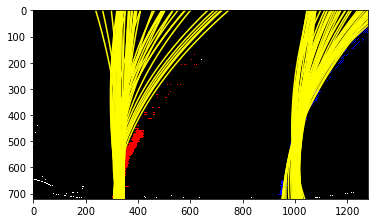

In [23]:
sample_project_video_detector = LaneLineDetector(mtx, dist, src, dst)

sample_project_video_clip = VideoFileClip(sample_project_video_path)
sample_project_video_output_clip = sample_project_video_clip.fl_image(sample_project_video_detector.process_image)
%time sample_project_video_output_clip.write_videofile(sample_project_video_output_path, audio=False)

## Project video

max_dist 673.623097698
final_left_fit [ -5.60327209e-04   8.39529906e-01   7.66660684e+01]
final_right_fit [ -4.48024729e-04   6.96291205e-01   7.57170345e+02]
293.098831476 m 366.581237073 m 0.361577654666 m
[MoviePy] >>>> Building video test_videos_output/project_video_output.mp4
[MoviePy] Writing video test_videos_output/project_video_output.mp4


  0%|          | 1/1261 [00:00<06:03,  3.47it/s]

max_dist 673.623097698
final_left_fit [ -5.60327209e-04   8.39529906e-01   7.66660684e+01]
final_right_fit [ -4.48024729e-04   6.96291205e-01   7.57170345e+02]
293.098831476 m 366.581237073 m 0.361577654666 m


  0%|          | 2/1261 [00:00<05:55,  3.54it/s]

max_dist 661.842145372
final_left_fit [ -5.59911200e-04   8.43229495e-01   7.50503478e+01]
final_right_fit [ -4.45309093e-04   7.06491565e-01   7.49333361e+02]
293.318787609 m 368.831604901 m 0.36728700886 m


  0%|          | 3/1261 [00:00<05:52,  3.57it/s]

max_dist 656.890428121
final_left_fit [ -5.65100406e-04   8.49816558e-01   7.34808654e+01]
final_right_fit [ -4.40920395e-04   7.10487584e-01   7.44255421e+02]
290.62483698 m 372.515980495 m 0.368735247736 m


  0%|          | 4/1261 [00:01<05:50,  3.58it/s]

max_dist 652.300116562
final_left_fit [ -5.70711785e-04   8.56683492e-01   7.17340453e+01]
final_right_fit [ -4.37759081e-04   7.14107388e-01   7.39694416e+02]
287.76673031 m 375.218046499 m 0.368644204363 m


  0%|          | 5/1261 [00:01<05:43,  3.65it/s]

max_dist 653.697055797
final_left_fit [ -5.69995971e-04   8.58480174e-01   7.07839040e+01]
final_right_fit [ -4.30552314e-04   7.12384699e-01   7.37410637e+02]
288.129585185 m 381.512756153 m 0.3710622777 m


  0%|          | 6/1261 [00:01<05:41,  3.68it/s]

max_dist 653.818484745
final_left_fit [ -5.70251841e-04   8.63898170e-01   6.84072902e+01]
final_right_fit [ -4.19902834e-04   7.16684987e-01   7.29459434e+02]
288.003206122 m 391.226767146 m 0.376434468055 m


  1%|          | 7/1261 [00:01<05:40,  3.69it/s]

max_dist 665.559478734
final_left_fit [ -5.67155324e-04   8.65492983e-01   6.67078309e+01]
final_right_fit [ -3.94887564e-04   7.02536151e-01   7.28179222e+02]
289.579591842 m 416.064374574 m 0.383112130315 m


  1%|          | 8/1261 [00:02<05:40,  3.68it/s]

max_dist 700.492481477
final_left_fit [ -5.52183141e-04   8.72385659e-01   5.86747157e+01]
final_right_fit [ -2.22134063e-04   6.15530328e-01   7.22997243e+02]
297.457579846 m 740.878820049 m 0.45243535722 m


  1%|          | 9/1261 [00:02<05:50,  3.58it/s]

max_dist 686.818718631
final_left_fit [ -5.55539433e-04   8.62023813e-01   6.47760010e+01]
final_right_fit [ -3.54529955e-04   6.79289586e-01   7.28170060e+02]
295.645152488 m 463.545038933 m 0.398225751137 m


  1%|          | 10/1261 [00:02<05:45,  3.62it/s]

max_dist 683.285416145
final_left_fit [ -5.46988715e-04   8.61484693e-01   6.18329890e+01]
final_right_fit [ -3.24177776e-04   6.63457907e-01   7.27699970e+02]
300.278545568 m 507.070707896 m 0.41124862609 m


  1%|          | 11/1261 [00:03<05:41,  3.66it/s]

max_dist 673.282607409
final_left_fit [ -5.45172102e-04   8.65915386e-01   5.80506240e+01]
final_right_fit [ -3.13297193e-04   6.66882798e-01   7.21914219e+02]
301.287163096 m 524.78075876 m 0.418236350405 m


  1%|          | 12/1261 [00:03<06:21,  3.27it/s]

max_dist 691.670583977
final_left_fit [ -5.31116999e-04   8.59674324e-01   5.52951680e+01]
final_right_fit [ -2.89279985e-04   6.41914726e-01   7.29282917e+02]
309.278762301 m 568.408224588 m 0.42314089676 m


  1%|          | 13/1261 [00:03<06:24,  3.24it/s]

max_dist 675.841253075
final_left_fit [ -5.19552612e-04   8.55721036e-01   5.21239543e+01]
final_right_fit [ -2.86652100e-04   6.41167232e-01   7.29086715e+02]
316.182584132 m 573.638189458 m 0.424699054803 m


  1%|          | 14/1261 [00:04<06:33,  3.17it/s]

max_dist 668.206687031
final_left_fit [ -5.18218265e-04   8.58042092e-01   4.88050650e+01]
final_right_fit [ -3.09285862e-04   6.57293711e-01   7.26395074e+02]
317.003897642 m 531.565972529 m 0.414767939138 m


  1%|          | 15/1261 [00:04<06:15,  3.31it/s]

max_dist 661.558260192
final_left_fit [ -5.22596165e-04   8.64568407e-01   4.55191576e+01]
final_right_fit [ -3.28830914e-04   6.77373706e-01   7.18850815e+02]
314.348683625 m 499.930387085 m 0.404018215316 m


  1%|▏         | 16/1261 [00:04<06:10,  3.36it/s]

max_dist 662.150467693
final_left_fit [ -5.31881790e-04   8.75154896e-01   4.18182523e+01]
final_right_fit [ -3.38900155e-04   6.89958137e-01   7.11760064e+02]
308.856159247 m 485.067663772 m 0.393083460987 m


  1%|▏         | 17/1261 [00:04<06:08,  3.37it/s]

max_dist 667.700675983
final_left_fit [ -5.57114045e-04   8.98340066e-01   3.69216745e+01]
final_right_fit [ -3.63838176e-04   7.30555837e-01   6.92391166e+02]
294.848409185 m 451.841555876 m 0.38160905211 m


  1%|▏         | 18/1261 [00:05<05:58,  3.47it/s]

max_dist 674.26158664
final_left_fit [ -5.89054248e-04   9.27376186e-01   3.09918915e+01]
final_right_fit [ -3.83075752e-04   7.64666808e-01   6.74723653e+02]
278.840701313 m 429.178758641 m 0.369315920851 m


  2%|▏         | 19/1261 [00:05<05:49,  3.55it/s]

max_dist 673.789702878
final_left_fit [ -6.11490877e-04   9.47559941e-01   2.65446937e+01]
final_right_fit [ -3.90302525e-04   7.82675671e-01   6.63670110e+02]
268.597932498 m 421.265843536 m 0.360396092483 m


  2%|▏         | 20/1261 [00:05<05:42,  3.62it/s]

max_dist 682.469574626
final_left_fit [ -6.19096055e-04   9.54677029e-01   2.39666860e+01]
final_right_fit [ -3.81018037e-04   7.77002305e-01   6.63105144e+02]
265.295143676 m 431.567076574 m 0.357127409824 m


  2%|▏         | 21/1261 [00:05<05:36,  3.68it/s]

max_dist 689.718492259
final_left_fit [ -6.13558603e-04   9.49454998e-01   2.33922772e+01]
final_right_fit [ -3.49658802e-04   7.41316036e-01   6.74546510e+02]
267.691799823 m 470.322176179 m 0.358522938879 m


  2%|▏         | 22/1261 [00:06<05:30,  3.75it/s]

max_dist 696.676728877
final_left_fit [ -6.02693175e-04   9.39846011e-01   2.31751748e+01]
final_right_fit [ -3.21911991e-04   7.01623344e-01   6.90393577e+02]
272.523333895 m 510.8622397 m 0.35890107311 m


  2%|▏         | 23/1261 [00:06<05:27,  3.78it/s]

max_dist 712.833719788
final_left_fit [ -5.62670848e-04   8.99832031e-01   2.48305593e+01]
final_right_fit [ -2.63803888e-04   5.72884503e-01   7.53264488e+02]
291.927951725 m 623.096326831 m 0.342839433759 m


  2%|▏         | 24/1261 [00:06<05:26,  3.79it/s]

max_dist 700.169380277
final_left_fit [ -6.37597943e-04   9.63236802e-01   1.43776423e+01]
final_right_fit [ -3.45707619e-04   6.56794087e-01   7.29139433e+02]
257.584349163 m 475.337513747 m 0.317112881595 m


  2%|▏         | 25/1261 [00:06<05:24,  3.81it/s]

max_dist 669.925674722
final_left_fit [ -6.04787617e-04   9.39304830e-01   2.18503669e+01]
final_right_fit [ -3.39113359e-04   6.99255121e-01   6.99467004e+02]
271.576231651 m 484.806246139 m 0.347488097905 m


  2%|▏         | 26/1261 [00:07<05:23,  3.82it/s]

max_dist 699.973513288
final_left_fit [ -6.10135785e-04   9.40936580e-01   2.03696396e+01]
final_right_fit [ -3.46934109e-04   6.86335506e-01   7.11750457e+02]
269.190476678 m 473.767291246 m 0.336596708397 m


  2%|▏         | 27/1261 [00:07<05:24,  3.80it/s]

max_dist 696.549654728
final_left_fit [ -6.20808028e-04   9.46814481e-01   1.85426900e+01]
final_right_fit [ -3.68050926e-04   6.88602581e-01   7.19420111e+02]
264.555738786 m 446.48004488 m 0.324083408277 m


  2%|▏         | 28/1261 [00:07<05:23,  3.81it/s]

max_dist 716.480383783
final_left_fit [ -6.15788924e-04   9.32681249e-01   1.92927679e+01]
final_right_fit [ -4.42467914e-04   6.98122946e-01   7.47067764e+02]
266.70754138 m 371.195037538 m 0.295553978499 m


  2%|▏         | 29/1261 [00:08<05:23,  3.81it/s]

max_dist 696.230744569
final_left_fit [ -6.38459481e-04   9.58727822e-01   1.58975043e+01]
final_right_fit [ -4.23408637e-04   7.24473598e-01   7.18943852e+02]
257.233659463 m 387.993305662 m 0.306885328386 m


  2%|▏         | 30/1261 [00:08<05:25,  3.79it/s]

max_dist 682.30399928
final_left_fit [ -6.65647371e-04   9.79352090e-01   1.25800946e+01]
final_right_fit [ -4.73128828e-04   7.66397504e-01   7.11743245e+02]
246.72022926 m 347.169869426 m 0.292866668557 m


  2%|▏         | 31/1261 [00:08<05:23,  3.80it/s]

max_dist 681.078761493
final_left_fit [ -6.82870455e-04   9.93058919e-01   1.07099171e+01]
final_right_fit [ -4.76349410e-04   7.73175809e-01   7.09612859e+02]
240.495416295 m 344.825779628 m 0.293288654053 m


  3%|▎         | 32/1261 [00:08<05:21,  3.83it/s]

max_dist 700.653729387
final_left_fit [ -7.90238032e-04   1.09182268e+00  -3.82816937e+00]
final_right_fit [ -4.68317220e-04   8.42689790e-01   6.60289307e+02]
207.829267209 m 350.916625718 m 0.308557869094 m


  3%|▎         | 33/1261 [00:09<05:20,  3.84it/s]

max_dist 728.392106537
final_left_fit [ -7.67750178e-04   1.07152283e+00  -1.00166884e+00]
final_right_fit [ -3.54607985e-04   7.44448819e-01   6.87111873e+02]
213.911919721 m 463.73691778 m 0.347742974373 m


  3%|▎         | 34/1261 [00:09<05:20,  3.83it/s]

max_dist 736.898382361
final_left_fit [ -7.85165961e-04   1.09400762e+00  -5.88881943e+00]
final_right_fit [ -3.21836286e-04   7.30901007e-01   6.82508477e+02]
209.168007925 m 511.165958253 m 0.360623065262 m


  3%|▎         | 35/1261 [00:09<05:22,  3.80it/s]

max_dist 718.142514588
final_left_fit [ -7.91307269e-04   1.10372740e+00  -8.29760893e+00]
final_right_fit [ -4.10838242e-04   8.12315731e-01   6.63935493e+02]
207.544354226 m 400.209372414 m 0.348356447175 m


  3%|▎         | 36/1261 [00:09<05:32,  3.69it/s]

max_dist 717.827788783
final_left_fit [ -7.98778390e-04   1.11907349e+00  -1.28183794e+01]
final_right_fit [ -3.91803735e-04   8.06809849e-01   6.56397214e+02]
205.601697582 m 419.755144962 m 0.350983132021 m


  3%|▎         | 37/1261 [00:10<05:28,  3.72it/s]

max_dist 698.626929279
final_left_fit [ -7.12317224e-04   1.02462764e+00   4.73070243e+00]
final_right_fit [ -4.81477477e-04   8.00794439e-01   6.93792861e+02]
230.552795343 m 341.185922842 m 0.300907087036 m


  3%|▎         | 38/1261 [00:10<05:24,  3.77it/s]

max_dist 697.24710744
final_left_fit [ -7.44246239e-04   1.06137286e+00  -2.93942998e+00]
final_right_fit [ -4.88082815e-04   8.31790060e-01   6.75953944e+02]
220.662233466 m 336.610196758 m 0.309564712453 m


  3%|▎         | 39/1261 [00:10<05:24,  3.77it/s]

max_dist 683.812700053
final_left_fit [ -7.76491838e-04   1.10056062e+00  -1.14097302e+01]
final_right_fit [ -4.89659060e-04   8.64629398e-01   6.53985119e+02]
211.499642396 m 335.598524073 m 0.319776137731 m


  3%|▎         | 40/1261 [00:10<05:21,  3.80it/s]

max_dist 660.723042483
final_left_fit [ -7.95196328e-04   1.12769842e+00  -1.81816184e+01]
final_right_fit [ -5.12059086e-04   9.10230217e-01   6.32496305e+02]
206.524740928 m 320.952436345 m 0.327146890009 m


  3%|▎         | 41/1261 [00:11<05:19,  3.82it/s]

max_dist 654.061696939
final_left_fit [ -8.02775575e-04   1.14541711e+00  -2.38420824e+01]
final_right_fit [ -5.37778737e-04   9.51938320e-01   6.14535684e+02]
204.574044152 m 305.61493438 m 0.332148622759 m


  3%|▎         | 42/1261 [00:11<05:19,  3.82it/s]

max_dist 649.710154614
final_left_fit [ -7.96210801e-04   1.14544708e+00  -2.56218085e+01]
final_right_fit [ -5.76757911e-04   9.92882295e-01   6.03040596e+02]
206.260361506 m 284.924948806 m 0.330638156657 m


  3%|▎         | 43/1261 [00:11<05:32,  3.66it/s]

max_dist 642.650458163
final_left_fit [ -7.74782772e-04   1.13085338e+00  -2.44118048e+01]
final_right_fit [ -6.04681530e-04   1.01781270e+00   5.97734412e+02]
211.966295908 m 271.736260496 m 0.330579856892 m


  3%|▎         | 44/1261 [00:12<05:28,  3.70it/s]

max_dist 640.53713654
final_left_fit [ -7.43228786e-04   1.10565023e+00  -2.11552853e+01]
final_right_fit [ -6.11371335e-04   1.01574442e+00   6.02491906e+02]
220.971151634 m 268.741248516 m 0.33390898954 m


  4%|▎         | 45/1261 [00:12<05:25,  3.73it/s]

max_dist 645.818859643
final_left_fit [ -7.09631593e-04   1.07881224e+00  -1.76635906e+01]
final_right_fit [ -5.91590226e-04   9.90011185e-01   6.12468888e+02]
231.444359712 m 277.732212775 m 0.342536498419 m


  4%|▎         | 46/1261 [00:12<05:24,  3.75it/s]

max_dist 676.072673211
final_left_fit [ -6.72962134e-04   1.04861346e+00  -1.34142617e+01]
final_right_fit [ -5.39678961e-04   9.39636256e-01   6.26933085e+02]
244.074161946 m 304.501055838 m 0.359910137062 m


  4%|▎         | 47/1261 [00:12<05:26,  3.72it/s]

max_dist 670.012228209
final_left_fit [ -6.33088659e-04   1.01539069e+00  -8.77509921e+00]
final_right_fit [ -4.84764351e-04   8.84618680e-01   6.43064666e+02]
259.474625317 m 339.064034899 m 0.376633283585 m


  4%|▍         | 48/1261 [00:13<05:26,  3.72it/s]

max_dist 664.389558378
final_left_fit [ -6.05601872e-04   9.91507288e-01  -5.33405832e+00]
final_right_fit [ -4.48686646e-04   8.52356889e-01   6.51435439e+02]
271.274652735 m 366.39570618 m 0.38800757482 m


  4%|▍         | 49/1261 [00:13<05:26,  3.71it/s]

max_dist 660.549513207
final_left_fit [ -5.79860287e-04   9.69626183e-01  -2.59576588e+00]
final_right_fit [ -4.23651466e-04   8.28493618e-01   6.58315522e+02]
283.343815522 m 388.095874319 m 0.395877415723 m


  4%|▍         | 50/1261 [00:13<05:28,  3.68it/s]

max_dist 656.093219823
final_left_fit [ -5.63805032e-04   9.55878686e-01  -1.20258336e+00]
final_right_fit [ -4.05747115e-04   8.14997638e-01   6.60770064e+02]
291.430937324 m 405.275311814 m 0.400675405188 m


  4%|▍         | 51/1261 [00:13<05:28,  3.68it/s]

max_dist 653.775635358
final_left_fit [ -5.50766169e-04   9.44456912e-01  -1.64556706e-01]
final_right_fit [ -4.19757965e-04   8.23176900e-01   6.60139156e+02]
298.345985674 m 391.696860639 m 0.394261915146 m


  4%|▍         | 52/1261 [00:14<05:29,  3.67it/s]

max_dist 650.006737665
final_left_fit [ -5.48211803e-04   9.40679184e-01   3.43532813e-01]
final_right_fit [ -4.36630857e-04   8.38970067e-01   6.54768421e+02]
299.735883439 m 376.527239081 m 0.384679798399 m


  4%|▍         | 53/1261 [00:14<05:30,  3.66it/s]

max_dist 641.954521668
final_left_fit [ -5.43824510e-04   9.35710082e-01   9.57124004e-01]
final_right_fit [ -4.45219423e-04   8.43281688e-01   6.53052799e+02]
302.156986074 m 369.2341351 m 0.374777929492 m


  4%|▍         | 54/1261 [00:14<05:31,  3.65it/s]

max_dist 637.806299964
final_left_fit [ -5.46096344e-04   9.35339769e-01   1.56514498e+00]
final_right_fit [ -4.58668847e-04   8.60432170e-01   6.44614133e+02]
300.891951543 m 358.399533506 m 0.364489337528 m


  4%|▍         | 55/1261 [00:15<05:27,  3.69it/s]

max_dist 634.518290585
final_left_fit [ -5.45049459e-04   9.31573189e-01   2.88869875e+00]
final_right_fit [ -4.75193936e-04   8.75660342e-01   6.38760721e+02]
301.464979776 m 345.908018858 m 0.353149890456 m


  4%|▍         | 56/1261 [00:15<05:27,  3.68it/s]

max_dist 640.691190493
final_left_fit [ -5.43418083e-04   9.26765997e-01   4.50582718e+00]
final_right_fit [ -4.83797730e-04   8.85938445e-01   6.33953546e+02]
302.364732987 m 339.749870197 m 0.345588860794 m


  5%|▍         | 57/1261 [00:15<05:24,  3.71it/s]

max_dist 654.108324776
final_left_fit [ -5.40126713e-04   9.20838334e-01   6.11348803e+00]
final_right_fit [ -4.85238085e-04   8.89206103e-01   6.31938433e+02]
304.204714478 m 338.745106478 m 0.341986400201 m


  5%|▍         | 58/1261 [00:15<05:21,  3.74it/s]

max_dist 679.930765994
final_left_fit [ -5.35114650e-04   9.12605257e-01   8.28405588e+00]
final_right_fit [ -4.64249010e-04   8.75985461e-01   6.33251678e+02]
307.051814592 m 354.117976986 m 0.345951116966 m


  5%|▍         | 59/1261 [00:16<05:22,  3.73it/s]

max_dist 697.099591778
final_left_fit [ -5.35762074e-04   9.08904000e-01   1.02609339e+01]
final_right_fit [ -4.32680209e-04   8.59210188e-01   6.32758688e+02]
306.671115045 m 380.071641194 m 0.353209483525 m


  5%|▍         | 60/1261 [00:16<05:26,  3.67it/s]

max_dist 706.051228446
final_left_fit [ -5.74565116e-04   9.24163815e-01   1.65407557e+01]
final_right_fit [ -3.32666010e-04   8.37778983e-01   6.04400057e+02]
285.894060577 m 495.208597042 m 0.366761378081 m


  5%|▍         | 61/1261 [00:16<05:27,  3.67it/s]

max_dist 703.798573454
final_left_fit [ -5.81126400e-04   9.19609995e-01   2.12663693e+01]
final_right_fit [ -3.51243712e-04   8.54454475e-01   5.97499933e+02]
282.648777013 m 468.936029079 m 0.349701987407 m


  5%|▍         | 62/1261 [00:16<05:28,  3.65it/s]

max_dist 694.363556692
final_left_fit [ -5.52992038e-04   9.15138636e-01   1.27841744e+01]
final_right_fit [ -4.14863487e-04   8.60933204e-01   6.22923623e+02]
297.081591971 m 396.525260893 m 0.349808281429 m


  5%|▍         | 63/1261 [00:17<05:39,  3.53it/s]

max_dist 687.567540592
final_left_fit [ -5.68413672e-04   9.19558687e-01   1.57205909e+01]
final_right_fit [ -4.03112845e-04   8.64074437e-01   6.14376702e+02]
288.993960895 m 408.192082815 m 0.344333071967 m


  5%|▌         | 64/1261 [00:17<05:50,  3.42it/s]

max_dist 676.933609556
final_left_fit [ -5.86511831e-04   9.26056349e-01   1.85697824e+01]
final_right_fit [ -4.14187007e-04   8.86994219e-01   6.01321604e+02]
280.051996164 m 397.316783519 m 0.333402963071 m


  5%|▌         | 65/1261 [00:17<05:56,  3.35it/s]

max_dist 659.818358966
final_left_fit [ -6.00615782e-04   9.28250725e-01   2.24138403e+01]
final_right_fit [ -4.51529081e-04   9.23937395e-01   5.88692142e+02]
273.458103883 m 364.374822752 m 0.314265789107 m


  5%|▌         | 66/1261 [00:18<05:56,  3.35it/s]

max_dist 660.014923051
final_left_fit [ -6.13549753e-04   9.30292614e-01   2.57897043e+01]
final_right_fit [ -4.94401049e-04   9.58282329e-01   5.79828109e+02]
267.681411191 m 332.663730532 m 0.292659013707 m


  5%|▌         | 67/1261 [00:18<05:48,  3.42it/s]

max_dist 661.47379647
final_left_fit [ -6.10769068e-04   9.21728084e-01   2.93449173e+01]
final_right_fit [ -5.15131243e-04   9.64097944e-01   5.82907051e+02]
268.897389892 m 319.189544253 m 0.280445017824 m


  5%|▌         | 68/1261 [00:18<05:46,  3.44it/s]

max_dist 657.674496176
final_left_fit [ -6.08613750e-04   9.14134735e-01   3.25651251e+01]
final_right_fit [ -5.33780691e-04   9.69504997e-01   5.85300149e+02]
269.847239766 m 307.969921057 m 0.268590581966 m


  5%|▌         | 69/1261 [00:18<05:41,  3.49it/s]

max_dist 665.441434478
final_left_fit [ -6.05551982e-04   9.05849563e-01   3.59200361e+01]
final_right_fit [ -5.35385226e-04   9.61332006e-01   5.90035368e+02]
271.209749548 m 307.016407126 m 0.260688552959 m


  6%|▌         | 70/1261 [00:19<05:39,  3.51it/s]

max_dist 662.357048714
final_left_fit [ -5.99798588e-04   8.96421959e-01   3.88866386e+01]
final_right_fit [ -5.22437964e-04   9.41619573e-01   5.96939021e+02]
273.810724101 m 314.621836501 m 0.256951761493 m


  6%|▌         | 71/1261 [00:19<05:36,  3.53it/s]

max_dist 685.288206702
final_left_fit [ -5.90216413e-04   8.84436996e-01   4.18689332e+01]
final_right_fit [ -4.93688826e-04   9.12374898e-01   6.04984472e+02]
278.256885639 m 332.981476779 m 0.260121684279 m


  6%|▌         | 72/1261 [00:19<05:35,  3.54it/s]

max_dist 674.439791338
final_left_fit [ -5.79405949e-04   8.72581056e-01   4.42137594e+01]
final_right_fit [ -4.73725955e-04   8.89331085e-01   6.12578133e+02]
283.450454069 m 347.032820182 m 0.262114870997 m


  6%|▌         | 73/1261 [00:20<05:38,  3.51it/s]

max_dist 671.654497252
final_left_fit [ -5.70664594e-04   8.63580722e-01   4.55925144e+01]
final_right_fit [ -4.55529975e-04   8.69830996e-01   6.18544422e+02]
287.794348158 m 360.919461164 m 0.264173104835 m


  6%|▌         | 74/1261 [00:20<05:36,  3.53it/s]

max_dist 656.086508352
final_left_fit [ -5.55413950e-04   8.49756371e-01   4.72695410e+01]
final_right_fit [ -4.45703062e-04   8.52212237e-01   6.26158652e+02]
295.702091393 m 368.863833752 m 0.263242235918 m


  6%|▌         | 75/1261 [00:20<05:38,  3.50it/s]

max_dist 648.768183782
final_left_fit [ -5.46175621e-04   8.40641250e-01   4.81394670e+01]
final_right_fit [ -4.45895054e-04   8.43510944e-01   6.31576921e+02]
300.70698468 m 368.671986057 m 0.258365626954 m


  6%|▌         | 76/1261 [00:20<05:38,  3.50it/s]

max_dist 643.921212624
final_left_fit [ -5.38610994e-04   8.32716233e-01   4.88545478e+01]
final_right_fit [ -4.68054918e-04   8.50848225e-01   6.34359372e+02]
304.932787971 m 351.138377106 m 0.246551477459 m


  6%|▌         | 77/1261 [00:21<05:34,  3.54it/s]

max_dist 631.241344825
final_left_fit [ -5.22479848e-04   8.17688073e-01   5.01538307e+01]
final_right_fit [ -4.85451804e-04   8.49663080e-01   6.41419727e+02]
314.355063005 m 338.484321616 m 0.236106730587 m


  6%|▌         | 78/1261 [00:21<06:13,  3.17it/s]

max_dist 633.643816775
final_left_fit [ -5.14086680e-04   8.07898229e-01   5.09972566e+01]
final_right_fit [ -5.03621365e-04   8.47120776e-01   6.49646386e+02]
319.489712571 m 326.210587574 m 0.22328690914 m


  6%|▋         | 79/1261 [00:21<05:55,  3.33it/s]

max_dist 637.020457277
final_left_fit [ -5.08552052e-04   7.99655431e-01   5.15270721e+01]
final_right_fit [ -5.18430711e-04   8.40229322e-01   6.59953818e+02]
322.966450441 m 316.845233307 m 0.210498263007 m


  6%|▋         | 80/1261 [00:22<05:49,  3.38it/s]

max_dist 636.986410801
final_left_fit [ -5.08186900e-04   7.95866943e-01   5.15932631e+01]
final_right_fit [ -5.30429807e-04   8.35552075e-01   6.67517383e+02]
323.195117131 m 309.650271775 m 0.198680983075 m


  6%|▋         | 81/1261 [00:22<05:42,  3.44it/s]

max_dist 647.710357489
final_left_fit [ -5.12699699e-04   7.95452824e-01   5.14492938e+01]
final_right_fit [ -5.29821583e-04   8.22161589e-01   6.75661945e+02]
320.343762703 m 309.993281284 m 0.188259061134 m


  7%|▋         | 82/1261 [00:22<05:35,  3.51it/s]

max_dist 656.358442546
final_left_fit [ -5.26784978e-04   8.03143032e-01   5.04719262e+01]
final_right_fit [ -5.21553691e-04   8.09750883e-01   6.79990982e+02]
311.768532564 m 314.906951559 m 0.180199057793 m


  7%|▋         | 83/1261 [00:23<05:30,  3.56it/s]

max_dist 669.65601011
final_left_fit [ -5.36398951e-04   8.07534346e-01   5.00215985e+01]
final_right_fit [ -5.07564860e-04   7.97776259e-01   6.82361822e+02]
306.1749454 m 323.594117257 m 0.17684194736 m


  7%|▋         | 84/1261 [00:23<05:31,  3.55it/s]

max_dist 699.872426176
final_left_fit [ -5.42332409e-04   8.09366528e-01   4.93871047e+01]
final_right_fit [ -4.57781027e-04   7.51803610e-01   6.93862646e+02]
302.821981989 m 358.820889639 m 0.181594515038 m


  7%|▋         | 85/1261 [00:23<05:28,  3.58it/s]

max_dist 704.079128871
final_left_fit [ -5.42050227e-04   8.03159080e-01   4.87047197e+01]
final_right_fit [ -2.88124034e-04   5.92121358e-01   7.37037582e+02]
302.97736919 m 570.421222002 m 0.210850368121 m


  7%|▋         | 86/1261 [00:23<05:28,  3.58it/s]

max_dist 687.294442811
final_left_fit [ -5.47423228e-04   8.10857241e-01   4.92594730e+01]
final_right_fit [ -4.19190439e-04   7.15639855e-01   7.03264897e+02]
300.003613052 m 391.891594982 m 0.18598899276 m


  7%|▋         | 87/1261 [00:24<05:26,  3.60it/s]

max_dist 693.905134809
final_left_fit [ -5.61179973e-04   8.19313635e-01   4.89392516e+01]
final_right_fit [ -4.03430622e-04   7.06209645e-01   7.04373159e+02]
292.646455714 m 407.231715257 m 0.188957922231 m


  7%|▋         | 88/1261 [00:24<05:39,  3.46it/s]

max_dist 701.901663285
final_left_fit [ -6.74764694e-04   9.05135901e-01   4.40961817e+01]
final_right_fit [ -4.55960407e-04   8.07187024e-01   6.56920362e+02]
243.40865546 m 360.37721929 m 0.178752148366 m


  7%|▋         | 89/1261 [00:24<05:36,  3.48it/s]

max_dist 710.367963013
final_left_fit [ -7.27551893e-04   9.52089553e-01   3.77850441e+01]
final_right_fit [ -4.37009739e-04   7.95318592e-01   6.53907728e+02]
225.773384743 m 376.04920441 m 0.174550890648 m


  7%|▋         | 90/1261 [00:25<05:35,  3.49it/s]

max_dist 718.350219307
final_left_fit [ -7.86516868e-04   1.00434710e+00   3.26226706e+01]
final_right_fit [ -4.45416797e-04   8.31973026e-01   6.29818495e+02]
208.883419695 m 369.02980171 m 0.174147565841 m


  7%|▋         | 91/1261 [00:25<05:31,  3.52it/s]

max_dist 699.229935822
final_left_fit [ -6.02297861e-04   8.50867477e-01   4.68268118e+01]
final_right_fit [ -4.07999984e-04   7.22986787e-01   6.94529743e+02]
272.668488066 m 402.696978371 m 0.18677913634 m


  7%|▋         | 92/1261 [00:25<05:31,  3.53it/s]

max_dist 688.365514002
final_left_fit [ -6.41154268e-04   8.81525897e-01   4.47288963e+01]
final_right_fit [ -4.24578716e-04   7.46586993e-01   6.84481203e+02]
256.152415271 m 386.972063653 m 0.182042320034 m


  7%|▋         | 93/1261 [00:25<05:48,  3.35it/s]

max_dist 695.826628794
final_left_fit [ -6.91970641e-04   9.23583695e-01   4.15214245e+01]
final_right_fit [ -4.70117325e-04   8.03598212e-01   6.62731505e+02]
237.361192517 m 349.468604506 m 0.172691060456 m


  7%|▋         | 94/1261 [00:26<06:01,  3.23it/s]

max_dist 688.117866812
final_left_fit [ -7.41948462e-04   9.66465068e-01   3.75994744e+01]
final_right_fit [ -5.10179748e-04   8.57034950e-01   6.41442938e+02]
221.399116771 m 322.018061369 m 0.166070465959 m


  8%|▊         | 95/1261 [00:26<05:51,  3.31it/s]

max_dist 671.743843587
final_left_fit [ -7.66246026e-04   9.88930381e-01   3.54954082e+01]
final_right_fit [ -5.34195251e-04   8.81411776e-01   6.32957783e+02]
214.392352272 m 307.523444466 m 0.161086845098 m


  8%|▊         | 96/1261 [00:26<05:48,  3.34it/s]

max_dist 664.432445774
final_left_fit [ -7.61763812e-04   9.88289421e-01   3.51607207e+01]
final_right_fit [ -5.51855805e-04   8.93788193e-01   6.31883600e+02]
215.647187757 m 297.66207743 m 0.161658324512 m


  8%|▊         | 97/1261 [00:27<05:43,  3.39it/s]

max_dist 666.203992587
final_left_fit [ -7.60930651e-04   9.90866557e-01   3.42686722e+01]
final_right_fit [ -5.61345881e-04   9.00709734e-01   6.31011105e+02]
215.879164826 m 292.620621197 m 0.163216863173 m


  8%|▊         | 98/1261 [00:27<05:37,  3.45it/s]

max_dist 658.665526131
final_left_fit [ -7.43576044e-04   9.78827952e-01   3.53858696e+01]
final_right_fit [ -5.69649537e-04   9.00359296e-01   6.34959923e+02]
220.904304899 m 288.340211208 m 0.165429681817 m


  8%|▊         | 99/1261 [00:27<05:32,  3.49it/s]

max_dist 649.301058541
final_left_fit [ -7.31158624e-04   9.71484912e-01   3.55330624e+01]
final_right_fit [ -5.84229276e-04   9.06915682e-01   6.36701971e+02]
224.64625779 m 281.130063377 m 0.165973585613 m


  8%|▊         | 100/1261 [00:27<05:31,  3.50it/s]

max_dist 645.946027481
final_left_fit [ -7.24317397e-04   9.68458472e-01   3.51706947e+01]
final_right_fit [ -5.92950228e-04   9.09098998e-01   6.39096625e+02]
226.762352028 m 276.986744805 m 0.16717432927 m


  8%|▊         | 101/1261 [00:28<05:29,  3.52it/s]

max_dist 642.019142223
final_left_fit [ -7.26230291e-04   9.73252930e-01   3.33725048e+01]
final_right_fit [ -6.03743508e-04   9.13244265e-01   6.40593159e+02]
226.16345047 m 272.027399277 m 0.166004627576 m


  8%|▊         | 102/1261 [00:28<05:29,  3.52it/s]

max_dist 638.732711542
final_left_fit [ -7.28962536e-04   9.78353685e-01   3.18308415e+01]
final_right_fit [ -6.21448430e-04   9.25114393e-01   6.39592671e+02]
225.31486241 m 264.270766962 m 0.163612036553 m


  8%|▊         | 103/1261 [00:28<05:26,  3.54it/s]

max_dist 632.973323069
final_left_fit [ -7.39183200e-04   9.89607257e-01   2.96269737e+01]
final_right_fit [ -6.47441378e-04   9.47172527e-01   6.35301807e+02]
222.202086063 m 253.656572813 m 0.160269773317 m


  8%|▊         | 104/1261 [00:29<05:29,  3.51it/s]

max_dist 632.409249905
final_left_fit [ -7.46528257e-04   9.97316865e-01   2.82416068e+01]
final_right_fit [ -6.64412048e-04   9.59619072e-01   6.34071582e+02]
220.018115238 m 247.176126586 m 0.158436685373 m


  8%|▊         | 105/1261 [00:29<05:29,  3.51it/s]

max_dist 631.40491229
final_left_fit [ -7.45512173e-04   9.97537742e-01   2.80757523e+01]
final_right_fit [ -6.69286460e-04   9.56660243e-01   6.38233210e+02]
220.316637645 m 245.376036568 m 0.158522792932 m


  8%|▊         | 106/1261 [00:29<05:27,  3.53it/s]

max_dist 640.639736331
final_left_fit [ -7.35962850e-04   9.90210777e-01   2.91590355e+01]
final_right_fit [ -6.67219744e-04   9.45370066e-01   6.45845839e+02]
223.170386935 m 246.137071862 m 0.161998750241 m


  8%|▊         | 107/1261 [00:29<05:27,  3.53it/s]

max_dist 651.980020295
final_left_fit [ -7.16946145e-04   9.74462049e-01   3.15219362e+01]
final_right_fit [ -6.57639283e-04   9.22596754e-01   6.58995912e+02]
229.081899466 m 249.724802374 m 0.168868183657 m


  9%|▊         | 108/1261 [00:30<05:28,  3.51it/s]

max_dist 634.893422295
final_left_fit [ -7.06345552e-04   9.66569501e-01   3.28109587e+01]
final_right_fit [ -6.50521766e-04   9.08360071e-01   6.67333679e+02]
232.515523234 m 252.458325983 m 0.17646757365 m


  9%|▊         | 109/1261 [00:30<05:26,  3.53it/s]

max_dist 642.384884321
final_left_fit [ -6.97481990e-04   9.60044092e-01   3.38066176e+01]
final_right_fit [ -6.37462502e-04   8.87793276e-01   6.77529705e+02]
235.467061608 m 257.630891473 m 0.184516756788 m


  9%|▊         | 110/1261 [00:30<05:25,  3.54it/s]

max_dist 636.438951883
final_left_fit [ -7.01077702e-04   9.65196613e-01   3.27857968e+01]
final_right_fit [ -6.48076963e-04   8.98100528e-01   6.77275502e+02]
234.259398584 m 253.413211948 m 0.191109223797 m


  9%|▉         | 111/1261 [00:31<05:23,  3.55it/s]

max_dist 632.124434773
final_left_fit [ -7.08397007e-04   9.73409348e-01   3.15550775e+01]
final_right_fit [ -6.57379768e-04   9.11479599e-01   6.74088364e+02]
231.840123251 m 249.827074617 m 0.197752491407 m


  9%|▉         | 112/1261 [00:31<05:25,  3.53it/s]

max_dist 654.471244276
final_left_fit [ -7.09202333e-04   9.75374545e-01   3.14130134e+01]
final_right_fit [ -6.64567047e-04   9.18277038e-01   6.74218888e+02]
231.576455239 m 247.126702585 m 0.203452948697 m


  9%|▉         | 113/1261 [00:31<05:24,  3.53it/s]

max_dist 631.201517983
final_left_fit [ -7.09230264e-04   9.76509441e-01   3.13378791e+01]
final_right_fit [ -6.67979503e-04   9.25364935e-01   6.72655425e+02]
231.566797946 m 245.863286163 m 0.210046996163 m


  9%|▉         | 114/1261 [00:31<05:24,  3.53it/s]

max_dist 633.000093385
final_left_fit [ -7.06612851e-04   9.75540732e-01   3.17810581e+01]
final_right_fit [ -6.73220083e-04   9.35273053e-01   6.69830966e+02]
232.423244268 m 243.948450578 m 0.217156494511 m


  9%|▉         | 115/1261 [00:32<05:26,  3.52it/s]

max_dist 639.142473759
final_left_fit [ -7.13275054e-04   9.83677212e-01   3.05558115e+01]
final_right_fit [ -6.76859989e-04   9.49097507e-01   6.63262637e+02]
230.253004135 m 242.633714966 m 0.22421437046 m


  9%|▉         | 116/1261 [00:32<05:27,  3.49it/s]

max_dist 633.394260022
final_left_fit [ -7.18782640e-04   9.90632763e-01   2.95496512e+01]
final_right_fit [ -6.89361008e-04   9.71249767e-01   6.54530949e+02]
228.489170041 m 238.232680223 m 0.229185376497 m


  9%|▉         | 117/1261 [00:32<05:26,  3.50it/s]

max_dist 632.957665072
final_left_fit [ -7.33029316e-04   1.00576682e+00   2.70848858e+01]
final_right_fit [ -7.02794828e-04   1.00156810e+00   6.40313000e+02]
224.051047914 m 233.677091822 m 0.23364604391 m


  9%|▉         | 118/1261 [00:33<05:24,  3.52it/s]

max_dist 632.238968938
final_left_fit [ -7.38357085e-04   1.01407524e+00   2.52950103e+01]
final_right_fit [ -7.09539859e-04   1.01844810e+00   6.32164180e+02]
222.43402722 m 231.455271459 m 0.238748363796 m


  9%|▉         | 119/1261 [00:33<05:24,  3.52it/s]

max_dist 628.599246438
final_left_fit [ -7.36952511e-04   1.01688764e+00   2.42051624e+01]
final_right_fit [ -7.19794860e-04   1.04027446e+00   6.22525851e+02]
222.855615947 m 228.157831407 m 0.24512230324 m


 10%|▉         | 120/1261 [00:33<05:25,  3.50it/s]

max_dist 650.830780779
final_left_fit [ -7.38020711e-04   1.02126199e+00   2.29843757e+01]
final_right_fit [ -7.18740250e-04   1.05256077e+00   6.14802486e+02]
222.531794848 m 228.494452308 m 0.253124472668 m


 10%|▉         | 121/1261 [00:33<05:24,  3.52it/s]

max_dist 659.752522454
final_left_fit [ -7.32839379e-04   1.02000111e+00   2.26524891e+01]
final_right_fit [ -7.01923429e-04   1.04940543e+00   6.12022518e+02]
224.102670222 m 233.975780381 m 0.266563561 m


 10%|▉         | 122/1261 [00:34<05:25,  3.50it/s]

max_dist 683.803084505
final_left_fit [ -7.32645958e-04   1.02379543e+00   2.14063991e+01]
final_right_fit [ -6.69416341e-04   1.03687346e+00   6.09465108e+02]
224.160433027 m 245.360882679 m 0.2845852668 m


 10%|▉         | 123/1261 [00:34<05:27,  3.47it/s]

max_dist 696.254784247
final_left_fit [ -7.37182629e-04   1.03108530e+00   1.98415511e+01]
final_right_fit [ -6.26498350e-04   1.01619169e+00   6.07439618e+02]
222.78069276 m 262.218438756 m 0.302087669119 m


 10%|▉         | 124/1261 [00:34<05:30,  3.44it/s]

max_dist 693.188204071
final_left_fit [ -7.46314644e-04   1.04186426e+00   1.78142001e+01]
final_right_fit [ -5.86540020e-04   9.97728311e-01   6.04884981e+02]
220.055469592 m 280.153261481 m 0.317492657767 m


 10%|▉         | 125/1261 [00:35<05:31,  3.43it/s]

max_dist 677.308965208
final_left_fit [ -7.42392162e-04   1.04108747e+00   1.77738502e+01]
final_right_fit [ -5.64573258e-04   9.89068512e-01   6.02619113e+02]
221.216647061 m 291.107017863 m 0.328837407062 m


 10%|▉         | 126/1261 [00:35<05:27,  3.47it/s]

max_dist 675.650769671
final_left_fit [ -7.31688297e-04   1.03357090e+00   1.88515485e+01]
final_right_fit [ -5.31550562e-04   9.59695329e-01   6.08469157e+02]
224.450901479 m 309.242445624 m 0.336789588457 m


 10%|█         | 127/1261 [00:35<05:25,  3.48it/s]

max_dist 666.859723508
final_left_fit [ -7.22261996e-04   1.02736502e+00   1.96493757e+01]
final_right_fit [ -5.29269524e-04   9.56409246e-01   6.09038163e+02]
227.379024718 m 310.575196865 m 0.338360379869 m


 10%|█         | 128/1261 [00:35<05:24,  3.49it/s]

max_dist 651.474287774
final_left_fit [ -7.01481850e-04   1.01034344e+00   2.22998108e+01]
final_right_fit [ -5.43044533e-04   9.60761225e-01   6.11485971e+02]
234.114021744 m 302.654720029 m 0.33733014776 m


 10%|█         | 129/1261 [00:36<05:26,  3.47it/s]

max_dist 648.175544936
final_left_fit [ -6.90518261e-04   1.00277276e+00   2.32622938e+01]
final_right_fit [ -5.68948586e-04   9.82669973e-01   6.06777226e+02]
237.831665541 m 288.838122604 m 0.334262245145 m


 10%|█         | 130/1261 [00:36<05:23,  3.50it/s]

max_dist 640.87339439
final_left_fit [ -6.75575911e-04   9.90005945e-01   2.53760438e+01]
final_right_fit [ -5.81087069e-04   9.87463422e-01   6.07735097e+02]
243.093462938 m 282.77717134 m 0.33105978612 m


 10%|█         | 131/1261 [00:36<05:22,  3.50it/s]

max_dist 643.300951354
final_left_fit [ -6.72775495e-04   9.88996662e-01   2.55288308e+01]
final_right_fit [ -6.09463149e-04   1.01773142e+00   5.98521332e+02]
244.106047592 m 269.59121193 m 0.327767881919 m


 10%|█         | 132/1261 [00:37<05:22,  3.50it/s]

max_dist 644.197559033
final_left_fit [ -6.67490424e-04   9.85302834e-01   2.65084429e+01]
final_right_fit [ -6.21796371e-04   1.03207957e+00   5.93001548e+02]
246.039926454 m 264.237886264 m 0.326384789668 m


 11%|█         | 133/1261 [00:37<05:21,  3.51it/s]

max_dist 655.289099877
final_left_fit [ -6.66477270e-04   9.85306786e-01   2.69255199e+01]
final_right_fit [ -6.17195115e-04   1.03410131e+00   5.89459210e+02]
246.414402217 m 266.223596891 m 0.329645140627 m


 11%|█         | 134/1261 [00:37<05:20,  3.52it/s]

max_dist 699.735408415
final_left_fit [ -6.57078930e-04   9.77182937e-01   2.89192712e+01]
final_right_fit [ -5.64693691e-04   9.92092499e-01   5.97347904e+02]
249.940845817 m 291.052085202 m 0.345071031584 m


 11%|█         | 135/1261 [00:37<05:21,  3.50it/s]

max_dist 695.478143075
final_left_fit [ -6.49577552e-04   9.70330062e-01   3.10514239e+01]
final_right_fit [ -5.10448249e-04   9.48080298e-01   6.05981708e+02]
252.828830034 m 322.086329813 m 0.361231218274 m


 11%|█         | 136/1261 [00:38<05:23,  3.47it/s]

max_dist 692.183064315
final_left_fit [ -6.39778467e-04   9.60105307e-01   3.41010660e+01]
final_right_fit [ -4.56135147e-04   8.98461129e-01   6.18206392e+02]
256.703079278 m 360.550995032 m 0.37547633616 m


 11%|█         | 137/1261 [00:38<05:20,  3.51it/s]

max_dist 672.622790478
final_left_fit [ -6.23491320e-04   9.43008465e-01   3.84368332e+01]
final_right_fit [ -4.11316576e-04   8.49107332e-01   6.34148012e+02]
263.412283049 m 399.910767757 m 0.386282055422 m


 11%|█         | 138/1261 [00:38<05:18,  3.52it/s]

max_dist 664.094910274
final_left_fit [ -6.05399657e-04   9.23329718e-01   4.32406790e+01]
final_right_fit [ -3.84157360e-04   8.12203747e-01   6.48870656e+02]
271.288168347 m 428.195214185 m 0.392193423768 m


 11%|█         | 139/1261 [00:39<05:16,  3.55it/s]

max_dist 659.318398053
final_left_fit [ -5.82433185e-04   8.98365625e-01   4.90334028e+01]
final_right_fit [ -3.84375815e-04   7.88782466e-01   6.63971238e+02]
281.991820682 m 427.830415723 m 0.386548435368 m


 11%|█         | 140/1261 [00:39<05:17,  3.53it/s]

max_dist 650.305682447
final_left_fit [ -5.62044507e-04   8.76342867e-01   5.34694794e+01]
final_right_fit [ -3.92859292e-04   7.70638622e-01   6.79268244e+02]
292.22796788 m 418.456452257 m 0.378640535844 m


 11%|█         | 141/1261 [00:39<05:16,  3.54it/s]

max_dist 651.380356592
final_left_fit [ -5.47365371e-04   8.59619046e-01   5.68969569e+01]
final_right_fit [ -4.03174007e-04   7.57985144e-01   6.91116892e+02]
300.069346047 m 407.646962091 m 0.36915289671 m


 11%|█▏        | 142/1261 [00:39<05:18,  3.52it/s]

max_dist 642.151160234
final_left_fit [ -5.37124014e-04   8.46714908e-01   5.96876296e+01]
final_right_fit [ -4.14680567e-04   7.52678068e-01   6.98591696e+02]
305.792751548 m 396.265654013 m 0.359949287433 m


 11%|█▏        | 143/1261 [00:40<05:28,  3.41it/s]

max_dist 647.345063284
final_left_fit [ -5.39683304e-04   8.45370025e-01   6.09148982e+01]
final_right_fit [ -4.32163714e-04   7.64796737e-01   6.96440122e+02]
304.337316488 m 380.198951845 m 0.350595919078 m


 11%|█▏        | 144/1261 [00:40<05:29,  3.39it/s]

max_dist 646.201415694
final_left_fit [ -5.46917421e-04   8.48423522e-01   6.13091370e+01]
final_right_fit [ -4.53584442e-04   7.83626194e-01   6.91503755e+02]
300.304831753 m 362.215133482 m 0.341024226656 m


 11%|█▏        | 145/1261 [00:40<05:29,  3.39it/s]

max_dist 655.322676885
final_left_fit [ -5.55421317e-04   8.52798675e-01   6.18255876e+01]
final_right_fit [ -4.64206476e-04   7.99309825e-01   6.84561666e+02]
295.700445413 m 353.927798541 m 0.336027293835 m


 12%|█▏        | 146/1261 [00:41<05:26,  3.42it/s]

max_dist 685.252648643
final_left_fit [ -5.66919987e-04   8.59967366e-01   6.19539899e+01]
final_right_fit [ -4.56964576e-04   8.03597468e-01   6.78877607e+02]
289.696367083 m 359.572283937 m 0.337298144911 m


 12%|█▏        | 147/1261 [00:41<05:23,  3.45it/s]

max_dist 699.293166773
final_left_fit [ -5.80658395e-04   8.69077619e-01   6.17539808e+01]
final_right_fit [ -4.34461494e-04   7.94941674e-01   6.76739836e+02]
282.836406811 m 378.264958392 m 0.343958066961 m


 12%|█▏        | 148/1261 [00:41<05:21,  3.46it/s]

max_dist 714.849505218
final_left_fit [ -6.88197143e-04   9.58623145e-01   5.06907416e+01]
final_right_fit [ -3.60000454e-04   7.90149853e-01   6.51326891e+02]
238.638795697 m 457.002537253 m 0.363414369402 m


 12%|█▏        | 149/1261 [00:41<05:18,  3.49it/s]

max_dist 716.674365752
final_left_fit [ -7.01715686e-04   9.69292020e-01   4.94918394e+01]
final_right_fit [ -3.55027721e-04   7.79892637e-01   6.55808398e+02]
234.044929817 m 463.384785768 m 0.361196318424 m


 12%|█▏        | 150/1261 [00:42<05:17,  3.50it/s]

max_dist 688.211204464
final_left_fit [ -5.98815260e-04   8.83141349e-01   6.04571513e+01]
final_right_fit [ -4.17781796e-04   7.85561850e-01   6.76497817e+02]
274.255958723 m 393.416177995 m 0.346773349767 m


 12%|█▏        | 151/1261 [00:42<05:16,  3.50it/s]

max_dist 665.427670689
final_left_fit [ -6.12335977e-04   8.91833698e-01   6.02996852e+01]
final_right_fit [ -4.19007111e-04   7.88577022e-01   6.75335785e+02]
268.197915066 m 392.270097993 m 0.345386077521 m


 12%|█▏        | 152/1261 [00:42<05:20,  3.47it/s]

max_dist 662.053738474
final_left_fit [ -6.24508998e-04   9.00360307e-01   5.95865796e+01]
final_right_fit [ -4.23114405e-04   7.90114388e-01   6.75725971e+02]
262.969386257 m 388.447162319 m 0.341413308671 m


 12%|█▏        | 153/1261 [00:43<05:18,  3.48it/s]

max_dist 664.540631784
final_left_fit [ -6.38914494e-04   9.11608759e-01   5.79847602e+01]
final_right_fit [ -4.52521779e-04   8.14168952e-01   6.70607770e+02]
257.04054455 m 363.148572269 m 0.330877038237 m


 12%|█▏        | 154/1261 [00:43<05:18,  3.47it/s]

max_dist 646.29593155
final_left_fit [ -6.43206771e-04   9.14895151e-01   5.69169039e+01]
final_right_fit [ -4.97495200e-04   8.46058085e-01   6.66149725e+02]
255.325555279 m 330.243206251 m 0.315804447503 m


 12%|█▏        | 155/1261 [00:43<05:18,  3.47it/s]

max_dist 642.035573803
final_left_fit [ -6.30330012e-04   9.03759725e-01   5.73393670e+01]
final_right_fit [ -5.24633354e-04   8.58899254e-01   6.68170208e+02]
260.540909737 m 313.113908916 m 0.306017391861 m


 12%|█▏        | 156/1261 [00:43<05:22,  3.43it/s]

max_dist 637.918813214
final_left_fit [ -6.19934176e-04   8.96983361e-01   5.62985188e+01]
final_right_fit [ -5.41316621e-04   8.68944922e-01   6.68421832e+02]
264.910136769 m 303.44388613 m 0.301553731378 m


 12%|█▏        | 157/1261 [00:44<05:21,  3.44it/s]

max_dist 654.544188344
final_left_fit [ -6.19243188e-04   8.99371271e-01   5.33075489e+01]
final_right_fit [ -5.53482854e-04   8.80704530e-01   6.65908774e+02]
265.206051552 m 296.766613574 m 0.298212590496 m


 13%|█▎        | 158/1261 [00:44<05:18,  3.46it/s]

max_dist 674.437969576
final_left_fit [ -6.22537948e-04   9.05183089e-01   4.97958709e+01]
final_right_fit [ -5.58209313e-04   8.90720224e-01   6.61752751e+02]
263.802586936 m 294.257788322 m 0.297064593815 m


 13%|█▎        | 159/1261 [00:44<05:17,  3.47it/s]

max_dist 706.002931386
final_left_fit [ -6.69136728e-04   9.56851759e-01   3.26838504e+01]
final_right_fit [ -4.30715226e-04   8.40724591e-01   6.50079816e+02]
245.430917196 m 381.739486735 m 0.334692740974 m


 13%|█▎        | 160/1261 [00:45<05:18,  3.46it/s]

max_dist 710.089033907
final_left_fit [ -6.94574789e-04   9.84131897e-01   2.55202824e+01]
final_right_fit [ -4.31251293e-04   8.58182952e-01   6.35671336e+02]
236.443335065 m 381.335466592 m 0.327206375155 m


 13%|█▎        | 161/1261 [00:45<05:19,  3.44it/s]

max_dist 688.763264149
final_left_fit [ -6.30492505e-04   9.16985762e-01   4.40262422e+01]
final_right_fit [ -5.41580691e-04   8.87999753e-01   6.57635042e+02]
260.474389556 m 303.323235637 m 0.300042880949 m


 13%|█▎        | 162/1261 [00:45<05:53,  3.11it/s]

max_dist 685.042181371
final_left_fit [ -6.46617729e-04   9.36961684e-01   3.64147672e+01]
final_right_fit [ -5.31751836e-04   8.92901612e-01   6.51168742e+02]
253.97838728 m 308.963537411 m 0.301508006556 m


 13%|█▎        | 163/1261 [00:46<05:41,  3.21it/s]

max_dist 671.888469981
final_left_fit [ -6.56615074e-04   9.51818927e-01   2.94289612e+01]
final_right_fit [ -5.13667051e-04   8.82562312e-01   6.50907230e+02]
250.111462072 m 319.874192884 m 0.301988938911 m


 13%|█▎        | 164/1261 [00:46<05:45,  3.17it/s]

max_dist 677.5496606
final_left_fit [ -6.64935340e-04   9.64582236e-01   2.35257241e+01]
final_right_fit [ -5.07717756e-04   8.87096852e-01   6.45452636e+02]
246.981919953 m 323.653149115 m 0.301602083688 m


 13%|█▎        | 165/1261 [00:46<06:10,  2.96it/s]

max_dist 682.49781771
final_left_fit [ -6.74967415e-04   9.79119138e-01   1.72563376e+01]
final_right_fit [ -5.11691477e-04   8.97806159e-01   6.39332788e+02]
243.311026074 m 321.152053166 m 0.297696838805 m


 13%|█▎        | 166/1261 [00:47<05:59,  3.05it/s]

max_dist 675.376342403
final_left_fit [ -6.89817122e-04   9.96344634e-01   1.16565214e+01]
final_right_fit [ -5.33848622e-04   9.21802143e-01   6.30881173e+02]
238.072958585 m 307.804314095 m 0.288329797015 m


 13%|█▎        | 167/1261 [00:47<06:19,  2.88it/s]

max_dist 670.985296163
final_left_fit [ -7.11723440e-04   1.01911412e+00   5.82706767e+00]
final_right_fit [ -5.67552401e-04   9.61917149e-01   6.16185319e+02]
230.745247731 m 289.508031826 m 0.277600834805 m


 13%|█▎        | 168/1261 [00:47<05:56,  3.06it/s]

max_dist 649.037128767
final_left_fit [ -7.27618870e-04   1.03631830e+00   1.07680283e+00]
final_right_fit [ -6.10930749e-04   1.01086835e+00   6.00553631e+02]
225.704870562 m 268.927652397 m 0.268460589504 m


 13%|█▎        | 169/1261 [00:48<05:39,  3.22it/s]

max_dist 648.306784933
final_left_fit [ -7.36072177e-04   1.04794637e+00  -3.57025984e+00]
final_right_fit [ -6.49475569e-04   1.04825654e+00   5.91248010e+02]
223.112856521 m 252.940277444 m 0.260515679536 m


 13%|█▎        | 170/1261 [00:48<05:26,  3.34it/s]

max_dist 648.400401021
final_left_fit [ -7.23595966e-04   1.03968923e+00  -4.93032238e+00]
final_right_fit [ -6.70925836e-04   1.05877147e+00   5.93654047e+02]
226.959155831 m 244.828463381 m 0.255309478591 m


 14%|█▎        | 171/1261 [00:48<05:19,  3.41it/s]

max_dist 649.852999731
final_left_fit [ -7.12298697e-04   1.03243247e+00  -6.29289750e+00]
final_right_fit [ -6.95681851e-04   1.07735436e+00   5.93134278e+02]
230.559160844 m 236.099603978 m 0.253468692045 m


 14%|█▎        | 172/1261 [00:48<05:17,  3.43it/s]

max_dist 652.980047231
final_left_fit [ -6.92622222e-04   1.01708812e+00  -6.29855905e+00]
final_right_fit [ -7.05787689e-04   1.07996676e+00   5.97490163e+02]
237.11120714 m 232.70949798 m 0.253848205257 m


 14%|█▎        | 173/1261 [00:49<05:14,  3.46it/s]

max_dist 661.827830218
final_left_fit [ -6.92324916e-04   1.01879738e+00  -9.00782009e+00]
final_right_fit [ -7.08927891e-04   1.08721955e+00   5.95134245e+02]
237.213572625 m 231.680742358 m 0.253607369948 m


 14%|█▍        | 174/1261 [00:49<05:11,  3.49it/s]

max_dist 673.145254603
final_left_fit [ -7.04908591e-04   1.03124304e+00  -1.28120972e+01]
final_right_fit [ -7.15887762e-04   1.10692102e+00   5.85212158e+02]
232.97765786 m 229.436136319 m 0.251715550375 m


 14%|█▍        | 175/1261 [00:49<05:10,  3.50it/s]

max_dist 669.33965851
final_left_fit [ -7.32526551e-04   1.05835495e+00  -1.91602239e+01]
final_right_fit [ -7.42485560e-04   1.15251675e+00   5.65590111e+02]
224.192317562 m 221.223494212 m 0.247167674198 m


 14%|█▍        | 176/1261 [00:50<05:11,  3.49it/s]

max_dist 670.170189615
final_left_fit [ -7.64101797e-04   1.08897279e+00  -2.60011205e+01]
final_right_fit [ -7.70152224e-04   1.19972181e+00   5.44718200e+02]
214.928310022 m 213.283106882 m 0.240867358535 m


 14%|█▍        | 177/1261 [00:50<05:08,  3.52it/s]

max_dist 648.8080418
final_left_fit [ -7.81030336e-04   1.10456013e+00  -2.96390375e+01]
final_right_fit [ -7.99489894e-04   1.23573629e+00   5.31912860e+02]
210.271080261 m 205.451121176 m 0.232253304825 m


 14%|█▍        | 178/1261 [00:50<05:07,  3.52it/s]

max_dist 644.739667433
final_left_fit [ -7.90376648e-04   1.11288455e+00  -3.18035382e+01]
final_right_fit [ -8.28698988e-04   1.26402536e+00   5.24451388e+02]
207.785679792 m 198.199206531 m 0.223710236525 m


 14%|█▍        | 179/1261 [00:50<05:05,  3.55it/s]

max_dist 642.263031525
final_left_fit [ -7.87964072e-04   1.10985223e+00  -3.16980670e+01]
final_right_fit [ -8.64461322e-04   1.29066263e+00   5.21679958e+02]
208.421771529 m 189.986170985 m 0.215954706146 m


 14%|█▍        | 180/1261 [00:51<05:07,  3.52it/s]

max_dist 645.3307514
final_left_fit [ -7.77329926e-04   1.09840776e+00  -2.97495948e+01]
final_right_fit [ -8.84007854e-04   1.29524106e+00   5.27767200e+02]
211.272217896 m 185.777780915 m 0.211968427157 m


 14%|█▍        | 181/1261 [00:51<05:06,  3.52it/s]

max_dist 658.694650729
final_left_fit [ -7.75036497e-04   1.09386591e+00  -2.83806881e+01]
final_right_fit [ -8.97986616e-04   1.29986010e+00   5.31776679e+02]
211.897653248 m 182.883590945 m 0.210364268027 m


 14%|█▍        | 182/1261 [00:51<05:05,  3.53it/s]

max_dist 668.321370844
final_left_fit [ -7.78324978e-04   1.09420338e+00  -2.75138636e+01]
final_right_fit [ -8.92393705e-04   1.29275804e+00   5.36047811e+02]
211.003391494 m 184.02985513 m 0.214237413266 m


 15%|█▍        | 183/1261 [00:52<05:04,  3.54it/s]

max_dist 708.471618824
final_left_fit [ -8.32234395e-04   1.13343478e+00  -2.92523249e+01]
final_right_fit [ -7.21066144e-04   1.18237231e+00   5.45129239e+02]
197.351397139 m 227.871792411 m 0.258858368433 m


 15%|█▍        | 184/1261 [00:52<05:05,  3.52it/s]

max_dist 752.369990957
final_left_fit [ -8.82435123e-04   1.17957361e+00  -3.66210885e+01]
final_right_fit [ -6.11238106e-04   1.13821498e+00   5.33302087e+02]
186.142170533 m 269.114848212 m 0.293357626328 m


 15%|█▍        | 185/1261 [00:52<05:03,  3.55it/s]

max_dist 742.255284569
final_left_fit [ -9.11382559e-04   1.20768762e+00  -4.12332839e+01]
final_right_fit [ -6.64876825e-04   1.19241683e+00   5.15096067e+02]
180.241202244 m 247.336305918 m 0.276636448314 m


 15%|█▍        | 186/1261 [00:52<05:04,  3.53it/s]

max_dist 763.076497834
final_left_fit [ -1.00727406e-03   1.30417733e+00  -5.86903721e+01]
final_right_fit [ -6.30347949e-04   1.20841062e+00   4.85266009e+02]
163.12269572 m 261.107134893 m 0.281569097916 m


 15%|█▍        | 187/1261 [00:53<05:03,  3.54it/s]

max_dist 744.697863832
final_left_fit [ -1.00981478e-03   1.30704553e+00  -5.85336840e+01]
final_right_fit [ -7.03375834e-04   1.26608243e+00   4.74815422e+02]
162.713167482 m 233.849120112 m 0.266156883994 m


 15%|█▍        | 188/1261 [00:53<05:06,  3.50it/s]

max_dist 749.422694044
final_left_fit [ -1.02546315e-03   1.32870138e+00  -6.31989007e+01]
final_right_fit [ -6.67245154e-04   1.24444534e+00   4.71897659e+02]
160.231148702 m 246.609075798 m 0.274135829831 m


 15%|█▍        | 189/1261 [00:53<05:05,  3.51it/s]

max_dist 737.762012817
final_left_fit [ -1.01757916e-03   1.32336612e+00  -6.22049771e+01]
final_right_fit [ -6.96011744e-04   1.25967475e+00   4.72409662e+02]
161.465901077 m 236.33557575 m 0.268385840036 m


 15%|█▌        | 190/1261 [00:54<05:25,  3.29it/s]

max_dist 721.625117107
final_left_fit [ -9.97452908e-04   1.31131496e+00  -6.04008819e+01]
final_right_fit [ -7.27117975e-04   1.28303840e+00   4.67701844e+02]
164.706249737 m 226.167260169 m 0.267206441472 m


 15%|█▌        | 191/1261 [00:54<05:22,  3.32it/s]

max_dist 715.233496759
final_left_fit [ -1.01950527e-03   1.33889698e+00  -6.61685346e+01]
final_right_fit [ -7.33475302e-04   1.28772717e+00   4.63433518e+02]
161.147596831 m 224.195649652 m 0.263189338392 m


 15%|█▌        | 192/1261 [00:54<05:15,  3.39it/s]

max_dist 696.093869747
final_left_fit [ -8.19350736e-04   1.13611878e+00  -3.36506621e+01]
final_right_fit [ -8.73261038e-04   1.30083050e+00   5.21912176e+02]
200.443776327 m 188.070664245 m 0.225736402144 m


 15%|█▌        | 193/1261 [00:54<05:09,  3.45it/s]

max_dist 698.612815832
final_left_fit [ -8.62361194e-04   1.18131082e+00  -4.05248697e+01]
final_right_fit [ -8.44050384e-04   1.30405819e+00   5.06496247e+02]
190.454322301 m 194.608125269 m 0.239980579486 m


 15%|█▌        | 194/1261 [00:55<05:08,  3.46it/s]

max_dist 696.853983208
final_left_fit [ -9.06410876e-04   1.22709960e+00  -4.72022491e+01]
final_right_fit [ -8.23797540e-04   1.31851320e+00   4.87324054e+02]
181.209010259 m 199.439537268 m 0.253627431277 m


 15%|█▌        | 195/1261 [00:55<05:08,  3.46it/s]

max_dist 704.096545561
final_left_fit [ -9.62585218e-04   1.29039019e+00  -5.53419290e+01]
final_right_fit [ -7.66728742e-04   1.32382716e+00   4.60017600e+02]
170.646307376 m 214.444628495 m 0.291533757001 m


 16%|█▌        | 196/1261 [00:55<05:05,  3.49it/s]

max_dist 716.327060677
final_left_fit [ -8.08077495e-04   1.14295483e+00  -2.84827523e+01]
final_right_fit [ -5.40615959e-04   1.04808932e+00   5.56579424e+02]
203.233189777 m 304.314497461 m 0.333622389267 m


 16%|█▌        | 197/1261 [00:56<05:04,  3.49it/s]

max_dist 669.661628086
final_left_fit [ -8.84621275e-04   1.21152610e+00  -4.35630545e+01]
final_right_fit [ -7.63850913e-04   1.25796918e+00   5.02722909e+02]
185.662803213 m 215.130533953 m 0.270975136593 m


 16%|█▌        | 198/1261 [00:56<05:07,  3.46it/s]

max_dist 656.869902177
final_left_fit [ -8.53030103e-04   1.18862769e+00  -3.98650612e+01]
final_right_fit [ -7.08857409e-04   1.19207401e+00   5.23357159e+02]
192.528328745 m 231.844974005 m 0.284851596211 m


 16%|█▌        | 199/1261 [00:56<05:07,  3.46it/s]

max_dist 711.973460646
final_left_fit [ -5.63626699e-04   9.20883384e-01   3.50992924e-01]
final_right_fit [ -4.19466822e-04   7.24275602e-01   7.21794443e+02]
291.460706688 m 391.651595905 m 0.308669161662 m


 16%|█▌        | 200/1261 [00:56<05:08,  3.44it/s]

max_dist 681.012846925
final_left_fit [ -7.73982920e-04   1.11605255e+00  -2.87710286e+01]
final_right_fit [ -6.62224021e-04   1.10067389e+00   5.66954304e+02]
212.183964045 m 248.124543736 m 0.289516035854 m


 16%|█▌        | 201/1261 [00:57<05:07,  3.44it/s]

max_dist 684.590983373
final_left_fit [ -6.90949164e-04   1.03848161e+00  -1.71556119e+01]
final_right_fit [ -6.20466948e-04   1.00776492e+00   6.13672077e+02]
237.694357677 m 264.76776134 m 0.290229943531 m


 16%|█▌        | 202/1261 [00:57<05:07,  3.44it/s]

max_dist 674.196628366
final_left_fit [ -6.17158740e-04   9.69658278e-01  -7.30640122e+00]
final_right_fit [ -5.68386657e-04   9.11207665e-01   6.57191343e+02]
266.144659969 m 288.996329716 m 0.28898802589 m


 16%|█▌        | 203/1261 [00:57<05:10,  3.40it/s]

max_dist 663.681442437
final_left_fit [ -6.03665186e-04   9.56820406e-01  -6.92412455e+00]
final_right_fit [ -5.51266982e-04   8.81109956e-01   6.68800763e+02]
272.101085844 m 297.963969796 m 0.280919013606 m


 16%|█▌        | 204/1261 [00:58<05:08,  3.42it/s]

max_dist 657.210459498
final_left_fit [ -6.04671339e-04   9.56537820e-01  -7.98213849e+00]
final_right_fit [ -5.50053273e-04   8.79270492e-01   6.67883155e+02]
271.646325646 m 298.621316302 m 0.271948949043 m


 16%|█▋        | 205/1261 [00:58<05:09,  3.42it/s]

max_dist 664.655557988
final_left_fit [ -6.22610394e-04   9.71390604e-01  -1.03430010e+01]
final_right_fit [ -5.52975211e-04   8.96332599e-01   6.55776923e+02]
263.808110127 m 297.060860136 m 0.265858204798 m


 16%|█▋        | 206/1261 [00:58<05:06,  3.44it/s]

max_dist 674.364244777
final_left_fit [ -6.46291352e-04   9.91183250e-01  -1.28597261e+01]
final_right_fit [ -5.47941862e-04   9.10807445e-01   6.42073893e+02]
254.129774342 m 299.824831407 m 0.262629910922 m


 16%|█▋        | 207/1261 [00:58<05:03,  3.47it/s]

max_dist 704.708666666
final_left_fit [ -7.65770844e-04   1.09850505e+00  -2.74624792e+01]
final_right_fit [ -5.32557552e-04   1.00511191e+00   5.72397243e+02]
214.459399125 m 308.800016539 m 0.28080413389 m


 16%|█▋        | 208/1261 [00:59<05:04,  3.46it/s]

max_dist 767.988876017
final_left_fit [ -7.92586021e-04   1.12387913e+00  -3.12458544e+01]
final_right_fit [ -3.01292211e-04   8.47613168e-01   5.87434398e+02]
207.204921104 m 547.335174298 m 0.338811958523 m


 17%|█▋        | 209/1261 [00:59<05:02,  3.48it/s]

max_dist 734.703799056
final_left_fit [ -7.54550687e-04   1.09124099e+00  -2.67296295e+01]
final_right_fit [ -3.85552306e-04   8.82154268e-01   5.97263532e+02]
217.648571375 m 427.05671846 m 0.317185962169 m


 17%|█▋        | 210/1261 [00:59<05:01,  3.49it/s]

max_dist 701.51978855
final_left_fit [ -7.12502011e-04   1.05324029e+00  -2.08108998e+01]
final_right_fit [ -4.78734366e-04   9.30145645e-01   6.02142278e+02]
230.497571883 m 343.527499226 m 0.294845383452 m


 17%|█▋        | 211/1261 [01:00<04:57,  3.53it/s]

max_dist 685.202240577
final_left_fit [ -6.58720344e-04   1.00280274e+00  -1.46230397e+01]
final_right_fit [ -5.32307867e-04   9.08494727e-01   6.36663888e+02]
249.330337491 m 308.670696173 m 0.265735574558 m


 17%|█▋        | 212/1261 [01:00<05:00,  3.49it/s]

max_dist 678.147507518
final_left_fit [ -6.59510850e-04   1.00537752e+00  -1.50065515e+01]
final_right_fit [ -5.19104814e-04   9.06198508e-01   6.32396217e+02]
249.032456728 m 316.560106308 m 0.270931170713 m


 17%|█▋        | 213/1261 [01:00<05:02,  3.47it/s]

max_dist 685.211089302
final_left_fit [ -6.64602954e-04   1.01174965e+00  -1.60597509e+01]
final_right_fit [ -4.93991070e-04   8.91526073e-01   6.31461970e+02]
247.123760876 m 332.712203416 m 0.277260920478 m


 17%|█▋        | 214/1261 [01:00<05:00,  3.48it/s]

max_dist 685.145636166
final_left_fit [ -6.68655987e-04   1.01709863e+00  -1.73968481e+01]
final_right_fit [ -4.71951746e-04   8.74491723e-01   6.33233073e+02]
245.625512269 m 348.295714355 m 0.280777067882 m


 17%|█▋        | 215/1261 [01:01<04:59,  3.49it/s]

max_dist 672.469271508
final_left_fit [ -6.63292639e-04   1.01517950e+00  -1.80378875e+01]
final_right_fit [ -4.56851258e-04   8.61508308e-01   6.34283820e+02]
247.615675593 m 359.838416217 m 0.2815006522 m


 17%|█▋        | 216/1261 [01:01<05:01,  3.46it/s]

max_dist 663.889479452
final_left_fit [ -6.56452557e-04   1.01102378e+00  -1.81870153e+01]
final_right_fit [ -4.60525421e-04   8.67438202e-01   6.29311626e+02]
250.200177947 m 356.96983493 m 0.275662488462 m


 17%|█▋        | 217/1261 [01:01<05:03,  3.44it/s]

max_dist 658.004824388
final_left_fit [ -6.56620505e-04   1.01274545e+00  -1.96575132e+01]
final_right_fit [ -4.75345909e-04   8.84852675e-01   6.21557618e+02]
250.137394459 m 345.826897019 m 0.267168186899 m


 17%|█▋        | 218/1261 [01:02<04:58,  3.49it/s]

max_dist 652.429808038
final_left_fit [ -6.44955803e-04   1.00547321e+00  -2.02650700e+01]
final_right_fit [ -4.84370865e-04   8.91738279e-01   6.18410375e+02]
254.66995089 m 339.363560434 m 0.260116673076 m


 17%|█▋        | 219/1261 [01:02<04:57,  3.50it/s]

max_dist 658.145152502
final_left_fit [ -6.36583069e-04   1.00080909e+00  -2.10422148e+01]
final_right_fit [ -4.99814732e-04   9.11228626e-01   6.09785553e+02]
258.027034494 m 328.869143275 m 0.253780645308 m


 17%|█▋        | 220/1261 [01:02<04:57,  3.50it/s]

max_dist 657.533803805
final_left_fit [ -6.24277381e-04   9.92029404e-01  -2.13656544e+01]
final_right_fit [ -4.99677935e-04   9.09974413e-01   6.09558899e+02]
263.123411585 m 328.955955874 m 0.250259873082 m


 18%|█▊        | 221/1261 [01:02<04:55,  3.52it/s]

max_dist 662.040180102
final_left_fit [ -6.09705685e-04   9.81474656e-01  -2.12954084e+01]
final_right_fit [ -4.90083203e-04   9.02094620e-01   6.10883167e+02]
269.425403695 m 335.414792157 m 0.251933275423 m


 18%|█▊        | 222/1261 [01:03<04:55,  3.51it/s]

max_dist 654.998308796
final_left_fit [ -5.97165068e-04   9.71387649e-01  -2.08583607e+01]
final_right_fit [ -4.76972598e-04   8.85413096e-01   6.16192287e+02]
275.094873551 m 344.641545779 m 0.251299717918 m


 18%|█▊        | 223/1261 [01:03<04:54,  3.52it/s]

max_dist 657.038945194
final_left_fit [ -5.94685477e-04   9.68872863e-01  -2.11060474e+01]
final_right_fit [ -4.79350900e-04   8.90522914e-01   6.13939177e+02]
276.243490862 m 342.937207488 m 0.249759973345 m


 18%|█▊        | 224/1261 [01:03<04:55,  3.51it/s]

max_dist 659.388791109
final_left_fit [ -5.90809855e-04   9.64734760e-01  -2.06434218e+01]
final_right_fit [ -4.76129260e-04   8.87309117e-01   6.14348381e+02]
278.057809907 m 345.262400667 m 0.247790572216 m


 18%|█▊        | 225/1261 [01:04<04:56,  3.49it/s]

max_dist 656.756085912
final_left_fit [ -5.92718384e-04   9.65263959e-01  -2.06101382e+01]
final_right_fit [ -4.81164180e-04   8.93761843e-01   6.11427323e+02]
277.159095087 m 341.646936542 m 0.243939233522 m


 18%|█▊        | 226/1261 [01:04<04:58,  3.47it/s]

max_dist 649.994717984
final_left_fit [ -6.08600738e-04   9.77301773e-01  -2.20710211e+01]
final_right_fit [ -5.09898339e-04   9.24727089e-01   6.00932621e+02]
269.911077966 m 322.362527586 m 0.233099869801 m


 18%|█▊        | 227/1261 [01:04<04:57,  3.48it/s]

max_dist 641.557653422
final_left_fit [ -6.16761745e-04   9.82612394e-01  -2.25917896e+01]
final_right_fit [ -5.34097593e-04   9.50224794e-01   5.92546326e+02]
266.331437047 m 307.730904363 m 0.223889856692 m


 18%|█▊        | 228/1261 [01:05<04:58,  3.46it/s]

max_dist 628.13751025
final_left_fit [ -6.20891019e-04   9.84525743e-01  -2.27566053e+01]
final_right_fit [ -5.64218907e-04   9.77306031e-01   5.85003676e+02]
264.555367502 m 291.262704798 m 0.211821046323 m


 18%|█▊        | 229/1261 [01:05<05:00,  3.43it/s]

max_dist 624.785586724
final_left_fit [ -6.18871819e-04   9.80674986e-01  -2.23786040e+01]
final_right_fit [ -5.93471422e-04   9.96873724e-01   5.82478256e+02]
265.417428722 m 276.859706458 m 0.198803646448 m


 18%|█▊        | 230/1261 [01:05<04:57,  3.47it/s]

max_dist 631.759978416
final_left_fit [ -6.14281917e-04   9.74878582e-01  -2.21067785e+01]
final_right_fit [ -6.14477329e-04   1.00499153e+00   5.83880291e+02]
267.40156798 m 267.357511928 m 0.185210140514 m


 18%|█▊        | 231/1261 [01:05<04:54,  3.49it/s]

max_dist 626.376617975
final_left_fit [ -6.05701086e-04   9.65734271e-01  -2.15645514e+01]
final_right_fit [ -6.33572569e-04   1.01188952e+00   5.85925173e+02]
271.193681048 m 259.271038374 m 0.173413653604 m


 18%|█▊        | 232/1261 [01:06<04:57,  3.46it/s]

max_dist 635.40201414
final_left_fit [ -5.96363371e-04   9.56588493e-01  -2.16219051e+01]
final_right_fit [ -6.54399161e-04   1.01806082e+00   5.89143679e+02]
275.445482135 m 250.993984399 m 0.160419257455 m


 18%|█▊        | 233/1261 [01:06<04:56,  3.47it/s]

max_dist 634.128125756
final_left_fit [ -5.94496098e-04   9.54047694e-01  -2.27553851e+01]
final_right_fit [ -6.80540097e-04   1.03266017e+00   5.88847052e+02]
276.310828903 m 241.33523659 m 0.146389534801 m


 19%|█▊        | 234/1261 [01:06<04:53,  3.50it/s]

max_dist 632.937715392
final_left_fit [ -5.90145069e-04   9.49347680e-01  -2.35723668e+01]
final_right_fit [ -6.97364879e-04   1.03965396e+00   5.89679898e+02]
278.350107265 m 235.50384158 m 0.133747819827 m


 19%|█▊        | 235/1261 [01:07<04:51,  3.51it/s]

max_dist 632.980518847
final_left_fit [ -5.93364958e-04   9.50958573e-01  -2.50099103e+01]
final_right_fit [ -7.30189880e-04   1.06964720e+00   5.82021267e+02]
276.835640637 m 224.911710717 m 0.120516063797 m


 19%|█▊        | 236/1261 [01:07<04:51,  3.52it/s]

max_dist 621.755700858
final_left_fit [ -6.00880116e-04   9.56197677e-01  -2.65617469e+01]
final_right_fit [ -7.74289456e-04   1.11461251e+00   5.68828247e+02]
273.366306786 m 212.099920856 m 0.106427824402 m


 19%|█▉        | 237/1261 [01:07<04:49,  3.54it/s]

max_dist 622.612799785
final_left_fit [ -6.12927047e-04   9.65308721e-01  -2.82806680e+01]
final_right_fit [ -8.11215224e-04   1.15894694e+00   5.53355237e+02]
267.984007128 m 202.445602132 m 0.0956407160815 m


 19%|█▉        | 238/1261 [01:07<04:49,  3.54it/s]

max_dist 618.814233123
final_left_fit [ -6.32322220e-04   9.81222611e-01  -3.11018574e+01]
final_right_fit [ -8.45910393e-04   1.20572487e+00   5.35825709e+02]
259.752449532 m 194.14252557 m 0.0870834071027 m


 19%|█▉        | 239/1261 [01:08<04:48,  3.54it/s]

max_dist 621.771302013
final_left_fit [ -6.61287422e-04   1.00503350e+00  -3.49142385e+01]
final_right_fit [ -8.87201862e-04   1.26322357e+00   5.14409528e+02]
248.361491717 m 185.107088257 m 0.0789251135099 m


 19%|█▉        | 240/1261 [01:08<04:48,  3.54it/s]

max_dist 623.820963636
final_left_fit [ -6.84486495e-04   1.02344920e+00  -3.74886297e+01]
final_right_fit [ -9.26073634e-04   1.31791163e+00   4.94414415e+02]
239.935786228 m 177.337388369 m 0.0733853983358 m


 19%|█▉        | 241/1261 [01:08<04:50,  3.51it/s]

max_dist 625.707487746
final_left_fit [ -6.99652414e-04   1.03511722e+00  -3.94737038e+01]
final_right_fit [ -9.25595411e-04   1.32579806e+00   4.89333980e+02]
234.730933988 m 177.428315061 m 0.0718027917621 m


 19%|█▉        | 242/1261 [01:08<04:49,  3.52it/s]

max_dist 629.009200231
final_left_fit [ -7.04056910e-04   1.03711907e+00  -3.99316986e+01]
final_right_fit [ -9.20718860e-04   1.32374901e+00   4.89416333e+02]
233.261175407 m 178.367940596 m 0.0713652712925 m


 19%|█▉        | 243/1261 [01:09<04:50,  3.51it/s]

max_dist 627.993796938
final_left_fit [ -7.08588018e-04   1.03846285e+00  -3.95453201e+01]
final_right_fit [ -9.14765880e-04   1.32324178e+00   4.87797131e+02]
231.768294302 m 179.528961507 m 0.071639352297 m


 19%|█▉        | 244/1261 [01:09<04:53,  3.47it/s]

max_dist 625.862796825
final_left_fit [ -7.00909417e-04   1.02954185e+00  -3.76328081e+01]
final_right_fit [ -9.04405336e-04   1.30896323e+00   4.92964076e+02]
234.307855106 m 181.585625181 m 0.0709112969808 m


 19%|█▉        | 245/1261 [01:09<04:54,  3.45it/s]

max_dist 622.319023556
final_left_fit [ -7.04675540e-04   1.03047993e+00  -3.71761932e+01]
final_right_fit [ -9.07638856e-04   1.31155246e+00   4.91703519e+02]
233.054624871 m 180.938581858 m 0.0659259336484 m


 20%|█▉        | 246/1261 [01:10<04:51,  3.48it/s]

max_dist 622.742433852
final_left_fit [ -7.08685783e-04   1.03068887e+00  -3.59987130e+01]
final_right_fit [ -9.20464674e-04   1.32624906e+00   4.86466256e+02]
231.734943712 m 178.41722617 m 0.0605179057806 m


 20%|█▉        | 247/1261 [01:10<04:52,  3.46it/s]

max_dist 638.667156072
final_left_fit [ -7.21044453e-04   1.03884293e+00  -3.61510607e+01]
final_right_fit [ -9.20076395e-04   1.33542100e+00   4.79659261e+02]
227.762298971 m 178.493147224 m 0.0586938773052 m


 20%|█▉        | 248/1261 [01:10<05:01,  3.36it/s]

max_dist 631.041212366
final_left_fit [ -7.31454905e-04   1.04582002e+00  -3.61924550e+01]
final_right_fit [ -9.27913386e-04   1.34986616e+00   4.72319590e+02]
224.520840478 m 176.986004145 m 0.0549629965494 m


 20%|█▉        | 249/1261 [01:11<05:14,  3.22it/s]

max_dist 627.103195351
final_left_fit [ -7.37480678e-04   1.04876754e+00  -3.56475340e+01]
final_right_fit [ -9.27206806e-04   1.35406152e+00   4.68630215e+02]
222.686881138 m 177.121684747 m 0.0529582857102 m


 20%|█▉        | 250/1261 [01:11<05:08,  3.27it/s]

max_dist 631.888217195
final_left_fit [ -7.37652386e-04   1.04722448e+00  -3.45192912e+01]
final_right_fit [ -9.07439171e-04   1.33747626e+00   4.71178939e+02]
222.635287778 m 180.982857605 m 0.0550013061802 m


 20%|█▉        | 251/1261 [01:11<05:07,  3.28it/s]

max_dist 631.109554941
final_left_fit [ -7.30805202e-04   1.03882457e+00  -3.22773489e+01]
final_right_fit [ -8.85440478e-04   1.31261345e+00   4.78529099e+02]
224.721039232 m 185.481541953 m 0.0565563494748 m


 20%|█▉        | 252/1261 [01:11<05:05,  3.31it/s]

max_dist 626.869955586
final_left_fit [ -7.23906846e-04   1.02960043e+00  -2.94400578e+01]
final_right_fit [ -8.81600290e-04   1.29946836e+00   4.84877841e+02]
226.862393622 m 186.287049981 m 0.0529989659357 m


 20%|██        | 253/1261 [01:12<04:58,  3.38it/s]

max_dist 627.475039513
final_left_fit [ -7.03741874e-04   1.00801362e+00  -2.44067182e+01]
final_right_fit [ -8.53181094e-04   1.25848476e+00   4.99969137e+02]
233.362252732 m 192.49217899 m 0.0536666350191 m


 20%|██        | 254/1261 [01:12<04:55,  3.41it/s]

max_dist 628.464456815
final_left_fit [ -6.86864789e-04   9.89484652e-01  -1.97943836e+01]
final_right_fit [ -8.28480853e-04   1.22229953e+00   5.13689787e+02]
239.096168458 m 198.23092116 m 0.0549546054167 m


 20%|██        | 255/1261 [01:12<04:55,  3.40it/s]

max_dist 631.890346138
final_left_fit [ -6.74871974e-04   9.74526947e-01  -1.51279827e+01]
final_right_fit [ -8.07537893e-04   1.19173169e+00   5.25156120e+02]
243.345105935 m 203.371772564 m 0.0560814546018 m


 20%|██        | 256/1261 [01:13<04:57,  3.38it/s]

max_dist 625.533298124
final_left_fit [ -6.66703116e-04   9.62858826e-01  -1.07433490e+01]
final_right_fit [ -7.94425674e-04   1.16920001e+00   5.34198580e+02]
246.326724175 m 206.727429357 m 0.0556557577659 m


 20%|██        | 257/1261 [01:13<05:11,  3.22it/s]

max_dist 620.958225601
final_left_fit [ -6.60565109e-04   9.52162877e-01  -5.75318677e+00]
final_right_fit [ -7.93712852e-04   1.16329401e+00   5.37311777e+02]
248.615533931 m 206.911899875 m 0.05488447949 m


 20%|██        | 258/1261 [01:13<05:19,  3.13it/s]

max_dist 617.152741339
final_left_fit [ -6.57312469e-04   9.42150572e-01   9.05318741e-02]
final_right_fit [ -8.08304740e-04   1.17109918e+00   5.37543732e+02]
249.845806547 m 203.17464768 m 0.0512552953134 m


 21%|██        | 259/1261 [01:14<05:27,  3.06it/s]

max_dist 621.43440368
final_left_fit [ -6.54806340e-04   9.32711474e-01   6.09672265e+00]
final_right_fit [ -8.19449490e-04   1.17937203e+00   5.36434474e+02]
250.802459653 m 200.411047535 m 0.0501785299319 m


 21%|██        | 260/1261 [01:14<05:38,  2.96it/s]

max_dist 620.069379119
final_left_fit [ -6.46931511e-04   9.17549698e-01   1.35830642e+01]
final_right_fit [ -8.34481657e-04   1.19084504e+00   5.35131345e+02]
253.85588312 m 196.80127951 m 0.0497316854616 m


 21%|██        | 261/1261 [01:14<05:34,  2.99it/s]

max_dist 622.380681099
final_left_fit [ -6.28702747e-04   8.94261070e-01   2.18258255e+01]
final_right_fit [ -8.33316284e-04   1.18082199e+00   5.41892902e+02]
261.215827878 m 197.077558834 m 0.0525839428211 m


 21%|██        | 262/1261 [01:15<05:24,  3.08it/s]

max_dist 624.51205364
final_left_fit [ -6.16225248e-04   8.76188414e-01   2.89909006e+01]
final_right_fit [ -8.21135481e-04   1.16086332e+00   5.51234335e+02]
266.505014736 m 200.001467475 m 0.0576301155181 m


 21%|██        | 263/1261 [01:15<05:21,  3.11it/s]

max_dist 625.608566746
final_left_fit [ -6.07184120e-04   8.63028619e-01   3.41830147e+01]
final_right_fit [ -7.94155061e-04   1.12466826e+00   5.65452043e+02]
270.473363664 m 206.79578205 m 0.0643572974545 m


 21%|██        | 264/1261 [01:15<05:29,  3.03it/s]

max_dist 627.939794639
final_left_fit [ -5.96620815e-04   8.47838617e-01   3.99832404e+01]
final_right_fit [ -7.73442508e-04   1.09474527e+00   5.77893309e+02]
275.262155243 m 212.333734335 m 0.0695733685946 m


 21%|██        | 265/1261 [01:16<05:39,  2.93it/s]

max_dist 627.093117845
final_left_fit [ -5.82293930e-04   8.30562186e-01   4.51592005e+01]
final_right_fit [ -7.49112139e-04   1.05666942e+00   5.94131903e+02]
282.034382359 m 219.230730602 m 0.0738034114326 m


 21%|██        | 266/1261 [01:16<05:26,  3.05it/s]

max_dist 633.200165905
final_left_fit [ -5.70074024e-04   8.15572051e-01   4.96261470e+01]
final_right_fit [ -7.19614214e-04   1.01674508e+00   6.09472993e+02]
288.079775006 m 228.216753437 m 0.0788011186472 m


 21%|██        | 267/1261 [01:16<05:21,  3.09it/s]

max_dist 630.143558139
final_left_fit [ -5.57764193e-04   8.00694654e-01   5.41235665e+01]
final_right_fit [ -6.99219056e-04   9.87370742e-01   6.21282765e+02]
294.437571077 m 234.873499079 m 0.0824942311819 m


 21%|██▏       | 268/1261 [01:17<05:43,  2.89it/s]

max_dist 632.175862173
final_left_fit [ -5.43664043e-04   7.84426453e-01   5.86407840e+01]
final_right_fit [ -6.76591781e-04   9.55779621e-01   6.33661194e+02]
302.073967054 m 242.728183443 m 0.0863830360629 m


 21%|██▏       | 269/1261 [01:17<05:36,  2.95it/s]

max_dist 639.234018135
final_left_fit [ -5.26053022e-04   7.66230343e-01   6.27756487e+01]
final_right_fit [ -6.55686839e-04   9.23226233e-01   6.47557438e+02]
312.187361431 m 250.467521772 m 0.090224354367 m


 21%|██▏       | 270/1261 [01:17<05:34,  2.96it/s]

max_dist 638.871316136
final_left_fit [ -5.08824507e-04   7.46968076e-01   6.77352790e+01]
final_right_fit [ -6.21174707e-04   8.82009869e-01   6.61771603e+02]
322.758927285 m 264.381704075 m 0.0966664683604 m


 21%|██▏       | 271/1261 [01:18<05:20,  3.09it/s]

max_dist 633.572240358
final_left_fit [ -4.99054470e-04   7.32573643e-01   7.33758230e+01]
final_right_fit [ -6.12352472e-04   8.72480803e-01   6.64822693e+02]
329.077527011 m 268.190287694 m 0.0995792051001 m


 22%|██▏       | 272/1261 [01:18<05:28,  3.01it/s]

max_dist 633.217870249
final_left_fit [ -4.87935404e-04   7.17028971e-01   7.96915523e+01]
final_right_fit [ -6.00332838e-04   8.66015057e-01   6.64550172e+02]
336.57665104 m 273.559509025 m 0.105339374901 m


 22%|██▏       | 273/1261 [01:18<05:37,  2.93it/s]

max_dist 632.068567368
final_left_fit [ -4.76041451e-04   7.00244296e-01   8.67285062e+01]
final_right_fit [ -5.95448010e-04   8.68274026e-01   6.61271805e+02]
344.98614183 m 275.804598949 m 0.11059490724 m


 22%|██▏       | 274/1261 [01:19<05:33,  2.96it/s]

max_dist 639.48008454
final_left_fit [ -4.77033816e-04   6.93190524e-01   9.35781070e+01]
final_right_fit [ -5.94612323e-04   8.84406098e-01   6.49816119e+02]
344.266858017 m 276.197004365 m 0.115458334728 m


 22%|██▏       | 275/1261 [01:19<05:19,  3.09it/s]

max_dist 633.629688697
final_left_fit [ -4.77738601e-04   6.87760343e-01   9.93161213e+01]
final_right_fit [ -6.05284800e-04   9.04465462e-01   6.40466517e+02]
343.758550505 m 271.329012801 m 0.118167774794 m


 22%|██▏       | 276/1261 [01:19<05:16,  3.11it/s]

max_dist 634.390566314
final_left_fit [ -4.80047663e-04   6.85108506e-01   1.03314596e+02]
final_right_fit [ -6.04594716e-04   9.07765695e-01   6.38363594e+02]
342.105267023 m 271.640745942 m 0.122197604841 m


 22%|██▏       | 277/1261 [01:20<05:06,  3.21it/s]

max_dist 629.534401595
final_left_fit [ -4.72008016e-04   6.74290427e-01   1.07648155e+02]
final_right_fit [ -5.96861609e-04   8.93058350e-01   6.45239735e+02]
347.932238493 m 275.158457868 m 0.124869055812 m


 22%|██▏       | 278/1261 [01:20<05:21,  3.06it/s]

max_dist 630.884227192
final_left_fit [ -4.58110573e-04   6.58875922e-01   1.12275981e+02]
final_right_fit [ -5.82784222e-04   8.68560091e-01   6.56298932e+02]
358.48709149 m 281.803130996 m 0.128705538912 m


 22%|██▏       | 279/1261 [01:20<05:27,  2.99it/s]

max_dist 630.314114081
final_left_fit [ -4.44895450e-04   6.44551838e-01   1.16514734e+02]
final_right_fit [ -5.66069775e-04   8.39238440e-01   6.69367848e+02]
369.13575451 m 290.121920411 m 0.132402379127 m


 22%|██▏       | 280/1261 [01:21<05:18,  3.08it/s]

max_dist 632.290590988
final_left_fit [ -4.27589594e-04   6.24771208e-01   1.22612167e+02]
final_right_fit [ -5.43210398e-04   8.07864443e-01   6.81133139e+02]
384.07650055 m 302.331397504 m 0.137282166257 m


 22%|██▏       | 281/1261 [01:21<05:16,  3.10it/s]

max_dist 643.87425624
final_left_fit [ -4.03634009e-04   5.98700101e-01   1.30555351e+02]
final_right_fit [ -5.11272194e-04   7.75012637e-01   6.90609770e+02]
406.873670365 m 321.224211425 m 0.147719206474 m


 22%|██▏       | 282/1261 [01:21<05:11,  3.15it/s]

max_dist 646.74309096
final_left_fit [ -3.91656208e-04   5.81877322e-01   1.37689914e+02]
final_right_fit [ -4.81967485e-04   7.47708804e-01   6.97053583e+02]
419.317007746 m 340.766892628 m 0.156157293946 m


 22%|██▏       | 283/1261 [01:22<05:06,  3.19it/s]

max_dist 645.418866351
final_left_fit [ -3.82446132e-04   5.67316897e-01   1.44529481e+02]
final_right_fit [ -4.55435449e-04   7.23260250e-01   7.03029994e+02]
429.414517516 m 360.633420552 m 0.164735480646 m


 23%|██▎       | 284/1261 [01:22<05:03,  3.22it/s]

max_dist 648.772788234
final_left_fit [ -3.72221013e-04   5.51646056e-01   1.51421791e+02]
final_right_fit [ -4.29862912e-04   6.96201293e-01   7.11431935e+02]
441.21042714 m 382.100612896 m 0.17286892143 m


 23%|██▎       | 285/1261 [01:22<04:57,  3.28it/s]

max_dist 639.522938727
final_left_fit [ -3.58807556e-04   5.35376668e-01   1.57520901e+02]
final_right_fit [ -4.04637750e-04   6.64716195e-01   7.23104173e+02]
457.705580464 m 405.928356929 m 0.181882470443 m


 23%|██▎       | 286/1261 [01:22<05:01,  3.23it/s]

max_dist 636.115782827
final_left_fit [ -3.49140195e-04   5.22929668e-01   1.62263926e+02]
final_right_fit [ -3.94545023e-04   6.41884517e-01   7.35183678e+02]
470.379679208 m 416.299123098 m 0.186302267909 m


 23%|██▎       | 287/1261 [01:23<05:04,  3.20it/s]

max_dist 636.770223882
final_left_fit [ -3.34650462e-04   5.05036807e-01   1.68248776e+02]
final_right_fit [ -3.79540495e-04   6.10506743e-01   7.50893393e+02]
490.747787927 m 432.742587709 m 0.190309791147 m


 23%|██▎       | 288/1261 [01:23<05:08,  3.16it/s]

max_dist 637.092749152
final_left_fit [ -3.13520853e-04   4.81890386e-01   1.74982087e+02]
final_right_fit [ -3.71270354e-04   5.86440749e-01   7.64731300e+02]
523.826553329 m 442.36679276 m 0.195130400623 m


 23%|██▎       | 289/1261 [01:23<05:03,  3.20it/s]

max_dist 630.080911375
final_left_fit [ -2.97718513e-04   4.62452688e-01   1.81935879e+02]
final_right_fit [ -3.72070285e-04   5.74237893e-01   7.73933463e+02]
551.633144815 m 441.402673438 m 0.198201551458 m


 23%|██▎       | 290/1261 [01:24<04:57,  3.27it/s]

max_dist 633.377104171
final_left_fit [ -2.87930505e-04   4.46542244e-01   1.88750942e+02]
final_right_fit [ -3.74587183e-04   5.67385474e-01   7.80483981e+02]
570.383861729 m 438.429306159 m 0.200204743688 m


 23%|██▎       | 291/1261 [01:24<04:56,  3.27it/s]

max_dist 639.165411269
final_left_fit [ -2.83955287e-04   4.33132833e-01   1.97047469e+02]
final_right_fit [ -3.74677676e-04   5.67397873e-01   7.80717517e+02]
578.362767647 m 438.323344784 m 0.202598806688 m


 23%|██▎       | 292/1261 [01:24<04:49,  3.34it/s]

max_dist 655.32627967
final_left_fit [ -2.88268349e-04   4.28092159e-01   2.03389032e+02]
final_right_fit [ -3.74192385e-04   5.71884756e-01   7.78308826e+02]
569.703390219 m 438.89523499 m 0.206710799416 m


 23%|██▎       | 293/1261 [01:25<04:50,  3.33it/s]

max_dist 678.970488466
final_left_fit [ -2.93435913e-04   4.23432461e-01   2.09895615e+02]
final_right_fit [ -3.46036231e-04   5.57081429e-01   7.77801976e+02]
559.668152945 m 474.634554924 m 0.216991571119 m


 23%|██▎       | 294/1261 [01:25<04:45,  3.39it/s]

max_dist 679.099750695
final_left_fit [ -2.84410314e-04   4.07534815e-01   2.17457138e+02]
final_right_fit [ -3.04857169e-04   5.28936307e-01   7.81095426e+02]
577.42890182 m 538.807186081 m 0.230581340429 m


 23%|██▎       | 295/1261 [01:25<04:44,  3.40it/s]

max_dist 680.5087438
final_left_fit [ -2.78568625e-04   3.97399418e-01   2.22761034e+02]
final_right_fit [ -2.63762521e-04   5.01234875e-01   7.83930314e+02]
589.537917166 m 622.854529711 m 0.244319860044 m


 23%|██▎       | 296/1261 [01:25<04:39,  3.46it/s]

max_dist 679.345529459
final_left_fit [ -2.79874924e-04   3.94682924e-01   2.25683551e+02]
final_right_fit [ -2.35415543e-04   4.80516945e-01   7.87070993e+02]
586.786999068 m 697.943114272 m 0.252758034578 m


 24%|██▎       | 297/1261 [01:26<04:35,  3.50it/s]

max_dist 667.743034708
final_left_fit [ -2.62804849e-04   3.77683121e-01   2.30090240e+02]
final_right_fit [ -2.07890437e-04   4.54464386e-01   7.93639938e+02]
624.899912459 m 790.428928543 m 0.260884701608 m


 24%|██▎       | 298/1261 [01:26<04:36,  3.49it/s]

max_dist 662.896197345
final_left_fit [ -2.47685458e-04   3.64038363e-01   2.32970355e+02]
final_right_fit [ -2.01378465e-04   4.44221867e-01   7.97215188e+02]
663.046484711 m 815.983651634 m 0.262108300069 m


 24%|██▎       | 299/1261 [01:26<04:34,  3.51it/s]

max_dist 652.109952351
final_left_fit [ -2.35087798e-04   3.53470000e-01   2.34368158e+02]
final_right_fit [ -2.02413461e-04   4.35881708e-01   8.02252098e+02]
698.580146909 m 811.753651964 m 0.258981622103 m


 24%|██▍       | 300/1261 [01:27<04:32,  3.52it/s]

max_dist 656.310204765
final_left_fit [ -2.26409394e-04   3.46112147e-01   2.34877380e+02]
final_right_fit [ -2.05880111e-04   4.28561518e-01   8.07725210e+02]
725.360353818 m 798.019463999 m 0.254021227214 m


 24%|██▍       | 301/1261 [01:27<04:32,  3.52it/s]

max_dist 648.302877467
final_left_fit [ -2.09331861e-04   3.32728763e-01   2.35782035e+02]
final_right_fit [ -2.04277929e-04   4.15580221e-01   8.14594490e+02]
784.547138301 m 804.225741808 m 0.249989320589 m


 24%|██▍       | 302/1261 [01:27<04:33,  3.51it/s]

max_dist 639.549777667
final_left_fit [ -1.89844202e-04   3.19081303e-01   2.35692412e+02]
final_right_fit [ -1.99053381e-04   3.98813359e-01   8.23226798e+02]
865.104882971 m 825.291024912 m 0.248535841634 m


 24%|██▍       | 303/1261 [01:27<04:34,  3.49it/s]

max_dist 655.30408616
final_left_fit [ -1.83672945e-04   3.14913753e-01   2.34829234e+02]
final_right_fit [ -1.93189715e-04   3.85169354e-01   8.29623156e+02]
894.181523115 m 850.31661129 m 0.245756237397 m


 24%|██▍       | 304/1261 [01:28<04:35,  3.48it/s]

max_dist 666.428955377
final_left_fit [ -1.78980271e-04   3.11098472e-01   2.34406806e+02]
final_right_fit [ -1.74242943e-04   3.63686728e-01   8.36419320e+02]
917.632808575 m 942.806973594 m 0.24682715505 m


 24%|██▍       | 305/1261 [01:28<04:33,  3.49it/s]

max_dist 708.372767062
final_left_fit [ -1.64566885e-04   2.98555074e-01   2.33648444e+02]
final_right_fit [  3.80738407e-05   1.91011787e-01   8.74671182e+02]
998.025334668 m 4319.66464535 m 0.303733602025 m


 24%|██▍       | 306/1261 [01:28<04:37,  3.44it/s]

max_dist 709.422137369
final_left_fit [ -1.80764004e-04   2.94089292e-01   2.45955880e+02]
final_right_fit [  2.05747164e-05   2.27049767e-01   8.52629226e+02]
908.540119425 m 7994.66145864 m 0.291962971658 m


 24%|██▍       | 307/1261 [01:29<04:32,  3.51it/s]

max_dist 686.971721789
final_left_fit [ -1.64026819e-04   2.96097452e-01   2.37497978e+02]
final_right_fit [ -1.34046681e-04   3.25319092e-01   8.46226074e+02]
1001.30641551 m 1225.66550307 m 0.254851171057 m


 24%|██▍       | 308/1261 [01:29<04:32,  3.50it/s]

max_dist 688.538362084
final_left_fit [ -1.56658078e-04   2.83701953e-01   2.42958632e+02]
final_right_fit [ -9.92915329e-05   2.98341986e-01   8.50674282e+02]
1048.39956047 m 1654.95147014 m 0.263774427131 m


 25%|██▍       | 309/1261 [01:29<04:29,  3.53it/s]

max_dist 680.787326104
final_left_fit [ -1.57425948e-04   2.74557553e-01   2.49930188e+02]
final_right_fit [ -7.49677242e-05   2.82492149e-01   8.51603980e+02]
1043.25831113 m 2192.24629989 m 0.269345301298 m


 25%|██▍       | 310/1261 [01:29<04:29,  3.52it/s]

max_dist 664.632208047
final_left_fit [ -1.42648074e-04   2.49219862e-01   2.61439483e+02]
final_right_fit [ -6.32822667e-05   2.73730488e-01   8.52565330e+02]
1151.3259784 m 2597.23809707 m 0.273662993526 m


 25%|██▍       | 311/1261 [01:30<04:33,  3.48it/s]

max_dist 668.983565712
final_left_fit [ -1.26826754e-04   2.19731590e-01   2.75615558e+02]
final_right_fit [ -5.34071607e-05   2.65682869e-01   8.52772173e+02]
1294.93386366 m 3077.64311979 m 0.275456603989 m


 25%|██▍       | 312/1261 [01:30<04:32,  3.49it/s]

max_dist 663.703944477
final_left_fit [ -1.14870874e-04   1.91988864e-01   2.90115866e+02]
final_right_fit [ -7.11945463e-05   2.81006263e-01   8.47951462e+02]
1429.6885639 m 2308.50878989 m 0.269471683104 m


 25%|██▍       | 313/1261 [01:30<04:28,  3.53it/s]

max_dist 658.222226168
final_left_fit [ -9.85557052e-05   1.61784714e-01   3.04286672e+02]
final_right_fit [ -8.53507104e-05   2.89812713e-01   8.45631282e+02]
1666.35023282 m 1925.43684945 m 0.263080729348 m


 25%|██▍       | 314/1261 [01:31<04:30,  3.50it/s]

max_dist 649.033705825
final_left_fit [ -7.78734723e-05   1.28450171e-01   3.18645945e+02]
final_right_fit [ -9.61833315e-05   2.94610932e-01   8.44847376e+02]
2108.90559896 m 1708.44135957 m 0.258190426489 m


 25%|██▍       | 315/1261 [01:31<04:29,  3.51it/s]

max_dist 642.890289472
final_left_fit [ -6.39459646e-05   1.03578131e-01   3.30109855e+02]
final_right_fit [ -1.01200238e-04   2.92952877e-01   8.46415291e+02]
2568.21933192 m 1623.64141067 m 0.254392957284 m


 25%|██▌       | 316/1261 [01:31<04:26,  3.55it/s]

max_dist 644.752921644
final_left_fit [ -4.96255606e-05   8.26149990e-02   3.38437453e+02]
final_right_fit [ -1.05093405e-04   2.85452058e-01   8.52533672e+02]
3309.32742583 m 1563.35464408 m 0.252730264894 m


 25%|██▌       | 317/1261 [01:31<04:23,  3.58it/s]

max_dist 658.394579707
final_left_fit [ -3.63156572e-05   6.51325523e-02   3.44903080e+02]
final_right_fit [ -9.48390840e-05   2.66795315e-01   8.61469314e+02]
4522.21989271 m 1732.34652865 m 0.256956129536 m


 25%|██▌       | 318/1261 [01:32<04:24,  3.56it/s]

max_dist 654.09040522
final_left_fit [ -2.08294904e-05   4.47907219e-02   3.52145079e+02]
final_right_fit [ -8.65257501e-05   2.50955731e-01   8.69642921e+02]
7884.37912631 m 1898.74343602 m 0.261461101741 m


 25%|██▌       | 319/1261 [01:32<04:23,  3.58it/s]

max_dist 648.747011194
final_left_fit [ -1.38620050e-05   3.29806225e-02   3.57266779e+02]
final_right_fit [ -7.84808565e-05   2.34508286e-01   8.78008193e+02]
11847.3050333 m 2093.31812288 m 0.263920574401 m


 25%|██▌       | 320/1261 [01:32<04:20,  3.61it/s]

max_dist 641.824686489
final_left_fit [ -3.64939836e-06   1.52116279e-02   3.65229555e+02]
final_right_fit [ -7.33982603e-05   2.25226228e-01   8.82274914e+02]
45001.1492503 m 2238.24802517 m 0.265735727611 m


 25%|██▌       | 321/1261 [01:33<04:22,  3.58it/s]

max_dist 630.107081242
final_left_fit [  8.56471086e-06  -3.92354146e-03   3.73232958e+02]
final_right_fit [ -8.09352565e-05   2.27829255e-01   8.83783167e+02]
19174.8453245 m 2029.72069492 m 0.265849183756 m


 26%|██▌       | 322/1261 [01:33<04:25,  3.54it/s]

max_dist 638.879667643
final_left_fit [  1.18938216e-05  -1.49359778e-02   3.79598435e+02]
final_right_fit [ -9.66085266e-05   2.37956421e-01   8.82611948e+02]
13807.7356899 m 1700.32205503 m 0.261029408326 m


 26%|██▌       | 323/1261 [01:33<04:22,  3.57it/s]

max_dist 638.68242879
final_left_fit [  1.26348982e-05  -2.01252452e-02   3.82718434e+02]
final_right_fit [ -1.00082382e-04   2.29861601e-01   8.88679445e+02]
12997.8681949 m 1641.20802382 m 0.256334361372 m


 26%|██▌       | 324/1261 [01:33<04:19,  3.60it/s]

max_dist 624.083876223
final_left_fit [  1.85568023e-05  -2.71678476e-02   3.84633809e+02]
final_right_fit [ -1.14327347e-04   2.30563587e-01   8.94004855e+02]
8849.94756714 m 1436.61235636 m 0.252050774596 m


 26%|██▌       | 325/1261 [01:34<04:19,  3.61it/s]

max_dist 625.190593181
final_left_fit [  1.28178781e-05  -2.20835182e-02   3.83187945e+02]
final_right_fit [ -1.23240118e-04   2.25348197e-01   9.01072736e+02]
12812.3218039 m 1332.64973014 m 0.24664198368 m


 26%|██▌       | 326/1261 [01:34<04:19,  3.60it/s]

max_dist 630.765893307
final_left_fit [ -5.03801287e-06  -5.01348188e-03   3.79166793e+02]
final_right_fit [ -1.26816472e-04   2.19151364e-01   9.06557103e+02]
32597.6385539 m 1295.03754377 m 0.241888576248 m


 26%|██▌       | 327/1261 [01:34<04:18,  3.61it/s]

max_dist 638.914723893
final_left_fit [ -1.80374191e-05   7.93777735e-03   3.75403543e+02]
final_right_fit [ -1.28008604e-04   2.08793355e-01   9.14215314e+02]
9104.85087736 m 1282.9539892 m 0.237720885933 m


 26%|██▌       | 328/1261 [01:34<04:18,  3.60it/s]

max_dist 648.914204885
final_left_fit [ -2.88933157e-05   1.89786964e-02   3.71747360e+02]
final_right_fit [ -1.26308879e-04   1.99639312e-01   9.20610898e+02]
5683.97021524 m 1300.20956137 m 0.23603654179 m


 26%|██▌       | 329/1261 [01:35<04:20,  3.57it/s]

max_dist 669.470301099
final_left_fit [ -4.27315894e-05   3.31001333e-02   3.67137782e+02]
final_right_fit [ -9.91542574e-05   1.72486753e-01   9.30043328e+02]
3843.29052152 m 1656.31084207 m 0.242214241021 m


 26%|██▌       | 330/1261 [01:35<04:21,  3.55it/s]

max_dist 676.92565383
final_left_fit [ -4.60011403e-05   3.74908382e-02   3.64876098e+02]
final_right_fit [ -6.22854538e-05   1.39540695e-01   9.39219676e+02]
3570.12851149 m 2636.83761499 m 0.252132534948 m


 26%|██▌       | 331/1261 [01:35<04:21,  3.56it/s]

max_dist 687.401486994
final_left_fit [ -4.30471720e-05   3.17156304e-02   3.66665120e+02]
final_right_fit [ -2.23641748e-05   1.06366345e-01   9.47051523e+02]
3815.12493315 m 7344.27086076 m 0.262125096426 m


 26%|██▋       | 332/1261 [01:36<04:23,  3.53it/s]

max_dist 687.737058567
final_left_fit [ -4.01040371e-05   2.17124701e-02   3.72400216e+02]
final_right_fit [  7.68040386e-06   9.04862165e-02   9.45888189e+02]
4095.14513329 m 21387.8849438 m 0.270093411129 m


 26%|██▋       | 333/1261 [01:36<04:21,  3.55it/s]

max_dist 686.959873791
final_left_fit [ -4.47198324e-05   1.88559254e-02   3.77028516e+02]
final_right_fit [  2.86203176e-05   8.20479651e-02   9.42449033e+02]
3672.52978365 m 5740.21950932 m 0.274076508452 m


 26%|██▋       | 334/1261 [01:36<04:23,  3.52it/s]

max_dist 676.927126477
final_left_fit [ -5.11636419e-05   1.50072880e-02   3.83596871e+02]
final_right_fit [  3.12804574e-05   8.74588168e-02   9.34801015e+02]
3210.09838453 m 5252.36139713 m 0.269022200859 m


 27%|██▋       | 335/1261 [01:36<04:21,  3.55it/s]

max_dist 667.476835621
final_left_fit [ -5.38515432e-05   8.80812245e-03   3.89699610e+02]
final_right_fit [  2.09086312e-05   1.00353067e-01   9.28053895e+02]
3049.96643706 m 7857.71959514 m 0.262198383018 m


 27%|██▋       | 336/1261 [01:37<04:20,  3.55it/s]

max_dist 648.394757749
final_left_fit [ -4.72180503e-05   1.05046819e-03   3.92334421e+02]
final_right_fit [  2.29044250e-06   1.09734619e-01   9.27915937e+02]
3478.42491312 m 71722.9858343 m 0.255508822802 m


 27%|██▋       | 337/1261 [01:37<04:18,  3.58it/s]

max_dist 645.26034215
final_left_fit [ -4.10984258e-05  -2.47690370e-03   3.91694501e+02]
final_right_fit [ -1.49073619e-05   1.10227710e-01   9.34049374e+02]
3996.30289865 m 11018.5814318 m 0.249126010542 m


 27%|██▋       | 338/1261 [01:37<04:16,  3.59it/s]

max_dist 643.020516086
final_left_fit [ -2.49747622e-05  -1.37544864e-02   3.91788952e+02]
final_right_fit [ -2.70810790e-05   1.04885191e-01   9.42935274e+02]
6576.09890584 m 6064.89740006 m 0.246674674001 m


 27%|██▋       | 339/1261 [01:38<04:15,  3.62it/s]

max_dist 653.100562269
final_left_fit [ -1.95783480e-05  -1.54784797e-02   3.90264720e+02]
final_right_fit [ -3.51811524e-05   1.00447235e-01   9.50020451e+02]
8388.5665035 m 4668.31156523 m 0.245968545255 m


 27%|██▋       | 340/1261 [01:38<04:12,  3.65it/s]

max_dist 655.99545196
final_left_fit [ -1.71563820e-05  -1.73171431e-02   3.90402947e+02]
final_right_fit [ -4.00256566e-05   9.79456803e-02   9.54344844e+02]
9572.74765044 m 4103.19798894 m 0.246205465888 m


 27%|██▋       | 341/1261 [01:38<04:11,  3.66it/s]

max_dist 681.073521846
final_left_fit [ -2.75451330e-05  -1.02042685e-02   3.90733610e+02]
final_right_fit [ -2.50666830e-05   8.90803774e-02   9.55059963e+02]
5962.45311875 m 6552.0387024 m 0.251883415453 m


 27%|██▋       | 342/1261 [01:38<04:11,  3.65it/s]

max_dist 679.021344752
final_left_fit [ -3.19771107e-05  -1.16945009e-02   3.94880352e+02]
final_right_fit [ -1.24876875e-05   9.02752251e-02   9.49763445e+02]
5136.17119769 m 13152.7522469 m 0.259414321891 m


 27%|██▋       | 343/1261 [01:39<04:13,  3.63it/s]

max_dist 676.161824089
final_left_fit [ -3.48658047e-05  -1.45903906e-02   3.98845732e+02]
final_right_fit [  1.21612238e-06   8.80631180e-02   9.46301754e+02]
4710.7283935 m 135067.577874 m 0.265815410929 m


 27%|██▋       | 344/1261 [01:39<04:11,  3.64it/s]

max_dist 666.852025874
final_left_fit [ -2.76268258e-05  -2.36448199e-02   4.02385288e+02]
final_right_fit [  1.17252095e-05   8.46694713e-02   9.44848111e+02]
5945.04228755 m 14009.7790185 m 0.27192253664 m


 27%|██▋       | 345/1261 [01:39<04:12,  3.62it/s]

max_dist 659.211847371
final_left_fit [ -3.09852043e-05  -1.63657547e-02   3.99364057e+02]
final_right_fit [  2.00667067e-05   7.49229070e-02   9.48316326e+02]
5300.64088173 m 8186.16758776 m 0.275223279068 m


 27%|██▋       | 346/1261 [01:39<04:13,  3.61it/s]

max_dist 650.493213401
final_left_fit [ -2.77250512e-05  -1.49212012e-02   3.96841517e+02]
final_right_fit [  9.95057450e-06   7.47179075e-02   9.51997113e+02]
5923.83494356 m 16507.4034516 m 0.271272769837 m


 28%|██▊       | 347/1261 [01:40<04:13,  3.60it/s]

max_dist 653.638919011
final_left_fit [ -3.52712676e-05  -8.18065603e-04   3.90221386e+02]
final_right_fit [  1.00725756e-06   7.01254978e-02   9.58258140e+02]
4656.40358052 m 163063.592442 m 0.265867233756 m


 28%|██▊       | 348/1261 [01:40<04:12,  3.61it/s]

max_dist 648.442252176
final_left_fit [ -4.97029641e-05   2.17533465e-02   3.81122291e+02]
final_right_fit [ -1.09197783e-05   6.68752609e-02   9.64825839e+02]
3304.36081196 m 15040.333573 m 0.2598787646 m


 28%|██▊       | 349/1261 [01:40<04:10,  3.64it/s]

max_dist 650.412713893
final_left_fit [ -6.52098326e-05   3.84381592e-02   3.76324587e+02]
final_right_fit [ -2.67784850e-05   7.31172312e-02   9.66423820e+02]
2518.6211675 m 6132.96366005 m 0.252134810525 m


 28%|██▊       | 350/1261 [01:41<04:12,  3.61it/s]

max_dist 635.384119681
final_left_fit [ -7.06438552e-05   4.69750817e-02   3.72600640e+02]
final_right_fit [ -4.23625920e-05   7.84147674e-02   9.69071343e+02]
2324.8809006 m 3876.72077801 m 0.246862305105 m


 28%|██▊       | 351/1261 [01:41<04:11,  3.61it/s]

max_dist 642.28104765
final_left_fit [ -8.22938684e-05   5.96799752e-02   3.69157393e+02]
final_right_fit [ -5.37283604e-05   8.55019445e-02   9.68811369e+02]
1995.77891536 m 3056.61655857 m 0.243238991091 m


 28%|██▊       | 352/1261 [01:41<04:10,  3.64it/s]

max_dist 641.693968148
final_left_fit [ -8.83546476e-05   6.92321575e-02   3.65187087e+02]
final_right_fit [ -5.98671733e-05   8.46420904e-02   9.71886113e+02]
1858.87200518 m 2743.18505553 m 0.240721692903 m


 28%|██▊       | 353/1261 [01:41<04:09,  3.64it/s]

max_dist 644.194240898
final_left_fit [ -8.71727322e-05   7.18061470e-02   3.62682784e+02]
final_right_fit [ -5.90980098e-05   7.99350766e-02   9.75419440e+02]
1884.05353427 m 2778.88931188 m 0.242053720768 m


 28%|██▊       | 354/1261 [01:42<04:13,  3.58it/s]

max_dist 658.975064168
final_left_fit [ -8.32003816e-05   7.47211932e-02   3.59070630e+02]
final_right_fit [ -4.16252427e-05   6.15752051e-02   9.81731845e+02]
1973.96602285 m 3945.3641031 m 0.249141100827 m


 28%|██▊       | 355/1261 [01:42<04:18,  3.51it/s]

max_dist 655.221390798
final_left_fit [ -8.47010853e-05   8.00198832e-02   3.56239686e+02]
final_right_fit [ -2.50130684e-05   4.75526790e-02   9.85586019e+02]
1938.97924882 m 6565.65825418 m 0.255914301773 m


 28%|██▊       | 356/1261 [01:42<04:15,  3.54it/s]

max_dist 649.856538961
final_left_fit [ -7.62767953e-05   7.49118945e-02   3.56015183e+02]
final_right_fit [ -1.00647308e-05   3.32447884e-02   9.89872047e+02]
2153.09937889 m 16317.1899563 m 0.261686949474 m


 28%|██▊       | 357/1261 [01:43<04:14,  3.55it/s]

max_dist 637.921409324
final_left_fit [ -5.89424455e-05   5.75488908e-02   3.60505393e+02]
final_right_fit [ -3.48796446e-06   2.97679364e-02   9.89823851e+02]
2786.27159947 m 47084.5266639 m 0.266495023579 m


 28%|██▊       | 358/1261 [01:43<04:13,  3.56it/s]

max_dist 627.589155174
final_left_fit [ -3.83431032e-05   3.60666765e-02   3.66578572e+02]
final_right_fit [ -1.00314302e-05   3.87227394e-02   9.86098247e+02]
4283.12146692 m 16371.4509071 m 0.268098464625 m


 28%|██▊       | 359/1261 [01:43<04:15,  3.53it/s]

max_dist 622.428922119
final_left_fit [ -9.09245395e-06   4.67838118e-03   3.75852592e+02]
final_right_fit [ -2.61454346e-05   5.49509892e-02   9.80746769e+02]
18061.9013532 m 6281.32304339 m 0.267605842512 m


 29%|██▊       | 360/1261 [01:43<04:13,  3.56it/s]

max_dist 623.07060819
final_left_fit [  2.12403982e-05  -2.83982911e-02   3.85507992e+02]
final_right_fit [ -4.26686936e-05   6.94397749e-02   9.76530558e+02]
7731.81102514 m 3848.88712917 m 0.265527285528 m


 29%|██▊       | 361/1261 [01:44<04:09,  3.60it/s]

max_dist 623.955930605
final_left_fit [  6.39116919e-05  -7.30711708e-02   3.97530723e+02]
final_right_fit [ -5.70409577e-05   8.16524614e-02   9.73123154e+02]
2569.61016057 m 2879.10185662 m 0.265278706325 m


 29%|██▊       | 362/1261 [01:44<04:10,  3.58it/s]

max_dist 618.416084844
final_left_fit [  8.94971754e-05  -9.89621087e-02   4.04443237e+02]
final_right_fit [ -5.91049097e-05   8.18033702e-02   9.72904357e+02]
1835.03257025 m 2778.56387497 m 0.266194059691 m


 29%|██▉       | 363/1261 [01:44<04:11,  3.58it/s]

max_dist 620.100652801
final_left_fit [  1.29387701e-04  -1.42539287e-01   4.16836284e+02]
final_right_fit [ -5.18546904e-05   7.49055869e-02   9.73867026e+02]
1269.31874817 m 3167.05636394 m 0.269984301268 m


 29%|██▉       | 364/1261 [01:45<04:07,  3.62it/s]

max_dist 619.562029272
final_left_fit [  1.49018704e-04  -1.69301490e-01   4.26557524e+02]
final_right_fit [ -4.18159406e-05   6.93313077e-02   9.72883545e+02]
1102.10829367 m 3927.37936192 m 0.272167126279 m


 29%|██▉       | 365/1261 [01:45<04:06,  3.63it/s]

max_dist 646.115625464
final_left_fit [  1.71577306e-04  -1.97333596e-01   4.35978426e+02]
final_right_fit [ -8.35657537e-06   4.89595131e-02   9.73775544e+02]
957.215162265 m 19653.0432511 m 0.283979641204 m


 29%|██▉       | 366/1261 [01:45<04:06,  3.63it/s]

max_dist 655.326577553
final_left_fit [  1.78552915e-04  -2.12973579e-01   4.43638107e+02]
final_right_fit [  3.07505147e-05   2.37708760e-02   9.75534930e+02]
919.807592128 m 5341.21312617 m 0.294250439219 m


 29%|██▉       | 367/1261 [01:45<04:06,  3.63it/s]

max_dist 651.581938138
final_left_fit [  1.86880199e-04  -2.28907904e-01   4.50154342e+02]
final_right_fit [  5.81740252e-05   4.25257392e-03   9.78630597e+02]
878.814424526 m 2823.55160454 m 0.301130400575 m


 29%|██▉       | 368/1261 [01:46<04:04,  3.66it/s]

max_dist 654.646586166
final_left_fit [  1.65013224e-04  -2.12759483e-01   4.47955437e+02]
final_right_fit [  8.21051055e-05  -1.48012672e-02   9.82356485e+02]
995.24818738 m 2000.71605839 m 0.302465170791 m


 29%|██▉       | 369/1261 [01:46<04:03,  3.66it/s]

max_dist 640.188484826
final_left_fit [  1.61091321e-04  -2.13746451e-01   4.49204905e+02]
final_right_fit [  9.19817033e-05  -2.67163746e-02   9.86428469e+02]
1019.47141699 m 1785.90840209 m 0.3001479291 m


 29%|██▉       | 370/1261 [01:46<04:06,  3.62it/s]

max_dist 647.952854558
final_left_fit [  1.41963403e-04  -2.01000262e-01   4.47460603e+02]
final_right_fit [  8.13016968e-05  -2.61168315e-02   9.89140786e+02]
1156.82465971 m 2020.36876071 m 0.287340805906 m


 29%|██▉       | 371/1261 [01:46<04:06,  3.61it/s]

max_dist 652.031262231
final_left_fit [  1.14325991e-04  -1.77679735e-01   4.42327701e+02]
final_right_fit [  6.06681596e-05  -1.59861238e-02   9.89546520e+02]
1436.483727 m 2707.29911455 m 0.272461710888 m


 30%|██▉       | 372/1261 [01:47<04:04,  3.64it/s]

max_dist 647.266566141
final_left_fit [  9.16386004e-05  -1.58774422e-01   4.37747576e+02]
final_right_fit [  4.37259149e-05  -1.03653792e-02   9.91405864e+02]
1792.14452806 m 3756.07140649 m 0.257731686374 m


 30%|██▉       | 373/1261 [01:47<04:04,  3.63it/s]

max_dist 668.894002028
final_left_fit [  5.17544910e-05  -1.24871162e-01   4.30526364e+02]
final_right_fit [  2.74354029e-05  -3.16481350e-03   9.91955746e+02]
3173.38288396 m 5986.1321207 m 0.241457586147 m


 30%|██▉       | 374/1261 [01:47<04:10,  3.55it/s]

max_dist 681.047034367
final_left_fit [ -2.69339785e-06  -7.45620681e-02   4.18504326e+02]
final_right_fit [  2.48856799e-05  -7.02634866e-03   9.94821469e+02]
60982.8643774 m 6599.37787777 m 0.227645850209 m


 30%|██▉       | 375/1261 [01:48<04:08,  3.56it/s]

max_dist 674.722918657
final_left_fit [ -3.19063914e-05  -5.01699464e-02   4.13563253e+02]
final_right_fit [  2.45075534e-05  -7.66399668e-03   9.94404960e+02]
5148.2883158 m 6701.18878643 m 0.218196129963 m


 30%|██▉       | 376/1261 [01:48<04:04,  3.62it/s]

max_dist 691.954676209
final_left_fit [ -6.28149886e-05  -2.58029633e-02   4.10182156e+02]
final_right_fit [  3.30633952e-05  -1.05825552e-02   9.91599338e+02]
2615.302449 m 4967.18929692 m 0.212062573459 m


 30%|██▉       | 377/1261 [01:48<04:30,  3.27it/s]

max_dist 716.625259041
final_left_fit [ -1.23088045e-04   1.41509774e-02   4.10868529e+02]
final_right_fit [  1.35978189e-04  -5.88456046e-02   9.83347063e+02]
1335.07580902 m 1208.28791863 m 0.234537336177 m


 30%|██▉       | 378/1261 [01:48<04:28,  3.29it/s]

max_dist 716.784685987
final_left_fit [ -1.27932605e-04   2.38119240e-02   4.08237244e+02]
final_right_fit [  1.49611598e-04  -6.81680326e-02   9.82993087e+02]
1284.49209476 m 1098.25956077 m 0.23929877564 m


 30%|███       | 379/1261 [01:49<04:18,  3.41it/s]

max_dist 717.618732569
final_left_fit [ -1.74342540e-04   7.66489396e-02   3.92279694e+02]
final_right_fit [  1.44486362e-04  -8.39097336e-02   9.96149822e+02]
942.666322946 m 1137.04537675 m 0.231975532571 m


 30%|███       | 380/1261 [01:49<04:12,  3.49it/s]

max_dist 704.627294788
final_left_fit [ -1.64378172e-04   7.63518379e-02   3.88614297e+02]
final_right_fit [  1.12888543e-04  -7.01876199e-02   1.00054106e+03]
999.696320027 m 1455.06695678 m 0.229847447297 m


 30%|███       | 381/1261 [01:49<04:08,  3.54it/s]

max_dist 697.007303814
final_left_fit [ -1.02945583e-04   1.30941416e-02   4.01814927e+02]
final_right_fit [  5.32332190e-05  -2.70051552e-02   9.94124652e+02]
1595.97832724 m 3085.2249927 m 0.212058116668 m


 30%|███       | 382/1261 [01:50<04:09,  3.52it/s]

max_dist 690.883417128
final_left_fit [ -1.15660316e-04   2.62276175e-02   3.99231986e+02]
final_right_fit [  7.10127021e-05  -4.20419243e-02   9.96592499e+02]
1420.57829323 m 2312.84022275 m 0.215057012029 m


 30%|███       | 383/1261 [01:50<04:06,  3.56it/s]

max_dist 685.831894072
final_left_fit [ -1.18436234e-04   3.27912433e-02   3.97332088e+02]
final_right_fit [  8.57226385e-05  -5.52542746e-02   9.99284410e+02]
1387.25877209 m 1916.00572389 m 0.220821088514 m


 30%|███       | 384/1261 [01:50<04:05,  3.57it/s]

max_dist 685.580775655
final_left_fit [ -1.38226790e-04   5.61320852e-02   3.91460993e+02]
final_right_fit [  9.79834564e-05  -6.92111324e-02   1.00319120e+03]
1188.67976842 m 1676.27380068 m 0.223173762364 m


 31%|███       | 385/1261 [01:50<04:04,  3.59it/s]

max_dist 674.403530144
final_left_fit [ -1.48846610e-04   7.58864725e-02   3.83683658e+02]
final_right_fit [  9.91479424e-05  -8.02861756e-02   1.01010484e+03]
1103.83701812 m 1656.53571706 m 0.224465356008 m


 31%|███       | 386/1261 [01:51<04:04,  3.57it/s]

max_dist 673.066247327
final_left_fit [ -1.45713723e-04   7.80661568e-02   3.81429903e+02]
final_right_fit [  9.34915099e-05  -7.86493247e-02   1.01067077e+03]
1127.52078966 m 1756.72707196 m 0.223809111145 m


 31%|███       | 387/1261 [01:51<04:03,  3.60it/s]

max_dist 667.117807129
final_left_fit [ -1.39148449e-04   7.99336440e-02   3.77719167e+02]
final_right_fit [  9.12117471e-05  -8.11145341e-02   1.01327082e+03]
1180.63816574 m 1800.60860361 m 0.225593019697 m


 31%|███       | 388/1261 [01:51<04:01,  3.61it/s]

max_dist 672.418699252
final_left_fit [ -1.33402255e-04   8.25622890e-02   3.73691001e+02]
final_right_fit [  9.49922342e-05  -8.71930375e-02   1.01598867e+03]
1231.41893382 m 1728.94557956 m 0.228590440188 m


 31%|███       | 389/1261 [01:52<04:02,  3.60it/s]

max_dist 679.533673979
final_left_fit [ -1.25576231e-04   8.66173992e-02   3.67641138e+02]
final_right_fit [  1.06152681e-04  -9.95869410e-02   1.02083262e+03]
1308.06384816 m 1547.18548533 m 0.235498223809 m


 31%|███       | 390/1261 [01:52<04:03,  3.58it/s]

max_dist 688.098514546
final_left_fit [ -1.12847153e-04   8.59853646e-02   3.62216103e+02]
final_right_fit [  1.31706169e-04  -1.21692875e-01   1.02708532e+03]
1455.50681148 m 1247.05545848 m 0.24678232486 m


 31%|███       | 391/1261 [01:52<04:03,  3.57it/s]

max_dist 665.977692243
final_left_fit [ -9.19947195e-05   7.70773831e-02   3.59042241e+02]
final_right_fit [  1.42782865e-04  -1.32031011e-01   1.03064817e+03]
1785.30693778 m 1150.33425892 m 0.254861934189 m


 31%|███       | 392/1261 [01:52<04:01,  3.60it/s]

max_dist 683.980921899
final_left_fit [ -8.16234320e-05   7.62772996e-02   3.54867290e+02]
final_right_fit [  1.59126225e-04  -1.44710388e-01   1.03306205e+03]
2012.08670448 m 1032.22944537 m 0.261092800824 m


 31%|███       | 393/1261 [01:53<03:57,  3.65it/s]

max_dist 655.331235609
final_left_fit [ -7.11310857e-05   7.45836031e-02   3.51328729e+02]
final_right_fit [  1.51691831e-04  -1.36716769e-01   1.03071711e+03]
2308.83259306 m 1082.8071894 m 0.261692686884 m


 31%|███       | 394/1261 [01:53<03:59,  3.63it/s]

max_dist 665.888619491
final_left_fit [ -5.79200833e-05   6.89843768e-02   3.48919154e+02]
final_right_fit [  1.38257968e-04  -1.24000997e-01   1.02718319e+03]
2835.41612127 m 1187.98879171 m 0.259203371214 m


 31%|███▏      | 395/1261 [01:53<03:57,  3.64it/s]

max_dist 657.341895208
final_left_fit [ -5.10491387e-05   6.67634881e-02   3.47086498e+02]
final_right_fit [  1.12219891e-04  -1.01077826e-01   1.02077446e+03]
3217.03570153 m 1463.56529648 m 0.250574164041 m


 31%|███▏      | 396/1261 [01:53<03:57,  3.65it/s]

max_dist 659.88942612
final_left_fit [ -5.52902019e-05   7.32713443e-02   3.43783485e+02]
final_right_fit [  9.66232725e-05  -8.68684114e-02   1.01589711e+03]
2970.27095828 m 1699.77142462 m 0.2412185601 m


 31%|███▏      | 397/1261 [01:54<03:56,  3.65it/s]

max_dist 680.964080039
final_left_fit [ -5.82957719e-05   8.02830141e-02   3.39868527e+02]
final_right_fit [  7.31200525e-05  -6.72164181e-02   1.01079801e+03]
2817.13014803 m 2246.06553997 m 0.231844630475 m


 32%|███▏      | 398/1261 [01:54<04:00,  3.58it/s]

max_dist 681.058445864
final_left_fit [ -6.12127409e-05   8.74561403e-02   3.35271907e+02]
final_right_fit [  7.03680202e-05  -6.85962496e-02   1.01177407e+03]
2682.88473356 m 2333.88601147 m 0.225539204234 m


 32%|███▏      | 399/1261 [01:54<04:03,  3.54it/s]

max_dist 693.367068359
final_left_fit [ -6.82662158e-05   9.76079584e-02   3.30695811e+02]
final_right_fit [  6.64700028e-05  -7.02118758e-02   1.01327415e+03]
2405.68084805 m 2470.72772504 m 0.218667799967 m


 32%|███▏      | 400/1261 [01:55<04:03,  3.53it/s]

max_dist 684.494454828
final_left_fit [ -7.29204003e-05   1.05335758e-01   3.26777235e+02]
final_right_fit [  6.59763222e-05  -7.39826289e-02   1.01535061e+03]
2252.13694684 m 2489.20296533 m 0.214285299402 m


 32%|███▏      | 401/1261 [01:55<04:01,  3.56it/s]

max_dist 694.145943942
final_left_fit [ -7.66232130e-05   1.12331890e-01   3.22933060e+02]
final_right_fit [  7.27026059e-05  -8.36150708e-02   1.01916309e+03]
2143.30277463 m 2258.90752627 m 0.21332282157 m


 32%|███▏      | 402/1261 [01:55<04:03,  3.53it/s]

max_dist 698.754243474
final_left_fit [ -7.27100327e-05   1.09817059e-01   3.22196731e+02]
final_right_fit [  8.72214941e-05  -9.70852299e-02   1.02250605e+03]
2258.65441503 m 1882.90641249 m 0.215019747418 m


 32%|███▏      | 403/1261 [01:55<04:08,  3.45it/s]

max_dist 694.222899334
final_left_fit [ -7.45172518e-05   1.11342204e-01   3.21388087e+02]
final_right_fit [  1.06433593e-04  -1.12690836e-01   1.02513428e+03]
2203.87617865 m 1543.05778665 m 0.216852265622 m


 32%|███▏      | 404/1261 [01:56<04:02,  3.54it/s]

max_dist 703.895331621
final_left_fit [ -6.89648851e-05   1.12423622e-01   3.16212863e+02]
final_right_fit [  1.34590281e-04  -1.41464322e-01   1.03229370e+03]
2381.31946138 m 1220.27739789 m 0.215530481145 m


 32%|███▏      | 405/1261 [01:56<03:59,  3.58it/s]

max_dist 680.272839224
final_left_fit [ -6.80078202e-05   1.04183416e-01   3.22796930e+02]
final_right_fit [  1.10086997e-04  -1.13194083e-01   1.02359864e+03]
2414.82358824 m 1491.86369657 m 0.215842666027 m


 32%|███▏      | 406/1261 [01:56<04:04,  3.50it/s]

max_dist 695.352222107
final_left_fit [ -6.58196657e-05   1.03402555e-01   3.21481350e+02]
final_right_fit [  1.10104275e-04  -1.15344299e-01   1.02452851e+03]
2495.10581402 m 1491.6228496 m 0.212266787872 m


 32%|███▏      | 407/1261 [01:57<04:01,  3.54it/s]

max_dist 695.813503917
final_left_fit [ -6.47145648e-05   1.02840490e-01   3.20369903e+02]
final_right_fit [  1.01551689e-04  -1.10076913e-01   1.02348325e+03]
2537.71475459 m 1617.2242264 m 0.205332874625 m


 32%|███▏      | 408/1261 [01:57<03:59,  3.56it/s]

max_dist 689.925042866
final_left_fit [ -6.43744961e-05   1.02042122e-01   3.19710476e+02]
final_right_fit [  8.16157976e-05  -9.54246558e-02   1.02033614e+03]
2551.12027731 m 2012.21625663 m 0.194825231071 m


 32%|███▏      | 409/1261 [01:57<03:59,  3.56it/s]

max_dist 688.735255907
final_left_fit [ -5.83474845e-05   9.74771957e-02   3.18911812e+02]
final_right_fit [  5.07608300e-05  -7.37367756e-02   1.01721951e+03]
2814.6450261 m 3235.30424967 m 0.183093659908 m


 33%|███▎      | 410/1261 [01:57<04:02,  3.51it/s]

max_dist 683.326557673
final_left_fit [ -6.61782826e-05   1.04223634e-01   3.16683510e+02]
final_right_fit [  4.07023902e-05  -6.72123257e-02   1.01561862e+03]
2481.58528179 m 4034.82509785 m 0.173749940312 m


 33%|███▎      | 411/1261 [01:58<04:00,  3.54it/s]

max_dist 686.144031802
final_left_fit [ -6.80679316e-05   1.03914783e-01   3.16717800e+02]
final_right_fit [  3.61509355e-05  -6.33966200e-02   1.01361170e+03]
2412.6907793 m 4542.82138686 m 0.166400149092 m


 33%|███▎      | 412/1261 [01:58<03:59,  3.54it/s]

max_dist 686.779363907
final_left_fit [ -7.30580176e-05   1.06456625e-01   3.16453518e+02]
final_right_fit [  3.84798770e-05  -6.37025575e-02   1.01166468e+03]
2247.89475477 m 4267.86718252 m 0.161168895703 m


 33%|███▎      | 413/1261 [01:58<03:57,  3.56it/s]

max_dist 685.290559941
final_left_fit [ -8.01504362e-05   1.10397423e-01   3.16019584e+02]
final_right_fit [  4.64415766e-05  -6.82518376e-02   1.01069072e+03]
2048.98223996 m 3536.20069069 m 0.15747943935 m


 33%|███▎      | 414/1261 [01:59<03:58,  3.56it/s]

max_dist 688.702582036
final_left_fit [ -8.76428469e-05   1.14643371e-01   3.15708445e+02]
final_right_fit [  6.66093900e-05  -8.19222504e-02   1.01119971e+03]
1873.82366699 m 2465.53058745 m 0.157411661326 m


 33%|███▎      | 415/1261 [01:59<03:56,  3.58it/s]

max_dist 659.524825472
final_left_fit [ -8.97738956e-05   1.12551556e-01   3.17643522e+02]
final_right_fit [  7.42060537e-05  -8.28444905e-02   1.00829165e+03]
1829.34928445 m 2213.14806586 m 0.156580254312 m


 33%|███▎      | 416/1261 [01:59<03:54,  3.61it/s]

max_dist 687.944730738
final_left_fit [ -9.71219741e-05   1.19012471e-01   3.15954122e+02]
final_right_fit [  7.65342415e-05  -8.31398033e-02   1.00727601e+03]
1690.9501542 m 2145.83166375 m 0.154288737782 m


 33%|███▎      | 417/1261 [01:59<03:53,  3.62it/s]

max_dist 672.147974149
final_left_fit [ -1.03929207e-04   1.24208813e-01   3.15156245e+02]
final_right_fit [  7.01873845e-05  -7.41210724e-02   1.00335958e+03]
1580.2030719 m 2339.87314184 m 0.150869368839 m


 33%|███▎      | 418/1261 [02:00<03:54,  3.60it/s]

max_dist 676.971252625
final_left_fit [ -1.08413187e-04   1.28882485e-01   3.13749867e+02]
final_right_fit [  5.73990257e-05  -6.22465822e-02   9.99950063e+02]
1514.84911865 m 2861.16980821 m 0.145988292469 m


 33%|███▎      | 419/1261 [02:00<03:56,  3.57it/s]

max_dist 678.806791252
final_left_fit [ -1.08092126e-04   1.30146656e-01   3.12437826e+02]
final_right_fit [  3.39085778e-05  -4.28985318e-02   9.95814198e+02]
1519.34529193 m 4843.22473721 m 0.139102619938 m


 33%|███▎      | 420/1261 [02:00<04:00,  3.49it/s]

max_dist 665.983592763
final_left_fit [ -1.09433700e-04   1.34345438e-01   3.09941031e+02]
final_right_fit [  2.00486389e-05  -3.33829136e-02   9.94374611e+02]
1500.71529224 m 8191.41938012 m 0.13399049736 m


 33%|███▎      | 421/1261 [02:01<03:57,  3.54it/s]

max_dist 675.135912542
final_left_fit [ -1.12038906e-04   1.36194374e-01   3.09879291e+02]
final_right_fit [  1.33049111e-05  -2.66823815e-02   9.91518874e+02]
1465.82284514 m 12343.3333796 m 0.129752822919 m


 33%|███▎      | 422/1261 [02:01<04:06,  3.41it/s]

max_dist 646.540847591
final_left_fit [ -1.07525070e-04   1.30378495e-01   3.12086369e+02]
final_right_fit [  9.10850462e-06  -2.06644299e-02   9.88034611e+02]
1527.35596177 m 18030.0675528 m 0.127195076957 m


 34%|███▎      | 423/1261 [02:01<04:00,  3.48it/s]

max_dist 665.549548859
final_left_fit [ -1.07405872e-04   1.29887738e-01   3.12431873e+02]
final_right_fit [  7.46660971e-06  -1.84456106e-02   9.85964698e+02]
1529.05157374 m 21994.8502209 m 0.12384100953 m


 34%|███▎      | 424/1261 [02:01<03:56,  3.53it/s]

max_dist 663.731122121
final_left_fit [ -1.04623845e-04   1.26417403e-01   3.13568571e+02]
final_right_fit [  7.75121567e-06  -1.76729351e-02   9.83880355e+02]
1569.70923426 m 21187.2437184 m 0.120400185512 m


 34%|███▎      | 425/1261 [02:02<03:57,  3.52it/s]

max_dist 668.990456325
final_left_fit [ -9.52899949e-05   1.19670326e-01   3.13734397e+02]
final_right_fit [  1.01050005e-05  -2.18389441e-02   9.84535950e+02]
1723.4539796 m 16252.0465056 m 0.117802160854 m


 34%|███▍      | 426/1261 [02:02<04:01,  3.45it/s]

max_dist 690.963366255
final_left_fit [ -8.60916590e-05   1.16321245e-01   3.11202734e+02]
final_right_fit [ -9.27823700e-06  -1.14993701e-02   9.84556799e+02]
1907.58257316 m 17700.4718854 m 0.110534709172 m


 34%|███▍      | 427/1261 [02:02<03:57,  3.51it/s]

max_dist 680.31744689
final_left_fit [ -8.05871057e-05   1.18086267e-01   3.06574044e+02]
final_right_fit [ -2.41190029e-05  -6.15883703e-03   9.86555517e+02]
2037.87869636 m 6809.29225876 m 0.104330506467 m


 34%|███▍      | 428/1261 [02:03<03:53,  3.56it/s]

max_dist 674.756306573
final_left_fit [ -6.74906028e-05   1.10407468e-01   3.05216272e+02]
final_right_fit [ -3.82879391e-05   2.08524418e-03   9.86311116e+02]
2433.33778436 m 4289.54535467 m 0.0997051335803 m


 34%|███▍      | 429/1261 [02:03<03:53,  3.57it/s]

max_dist 657.052256376
final_left_fit [ -5.98935423e-05   1.05341801e-01   3.04601608e+02]
final_right_fit [ -5.33150922e-05   1.44834336e-02   9.83544047e+02]
2742.00162647 m 3080.59217873 m 0.094549667189 m


 34%|███▍      | 430/1261 [02:03<03:51,  3.59it/s]

max_dist 658.335643665
final_left_fit [ -5.63298175e-05   1.03528191e-01   3.03360748e+02]
final_right_fit [ -7.62551351e-05   3.42026771e-02   9.79161841e+02]
2915.48500396 m 2153.94406945 m 0.0872402756747 m


 34%|███▍      | 431/1261 [02:03<03:51,  3.58it/s]

max_dist 681.614570664
final_left_fit [ -5.03051129e-05   9.93111932e-02   3.02821786e+02]
final_right_fit [ -8.01584903e-05   4.09113058e-02   9.76231659e+02]
3264.67035404 m 2049.04863766 m 0.085704756365 m


 34%|███▍      | 432/1261 [02:04<03:54,  3.54it/s]

max_dist 666.33669434
final_left_fit [ -3.13862048e-05   8.23907985e-02   3.05034631e+02]
final_right_fit [ -8.35950375e-05   4.50288807e-02   9.74652344e+02]
5232.62467386 m 1964.81919043 m 0.0842038240603 m


 34%|███▍      | 433/1261 [02:04<03:52,  3.56it/s]

max_dist 698.719414445
final_left_fit [ -2.63913369e-05   8.15763993e-02   3.02028545e+02]
final_right_fit [ -8.68608913e-05   4.49510337e-02   9.76422703e+02]
6223.03720258 m 1890.9784108 m 0.0816047878521 m


 34%|███▍      | 434/1261 [02:04<03:52,  3.55it/s]

max_dist 688.240302532
final_left_fit [ -2.29832271e-05   8.31511327e-02   2.98263739e+02]
final_right_fit [ -8.47620272e-05   4.01285378e-02   9.79218641e+02]
7145.93635218 m 1937.8161715 m 0.0803966873052 m


 34%|███▍      | 435/1261 [02:04<03:49,  3.59it/s]

max_dist 681.791854398
final_left_fit [ -1.55416312e-05   7.95631912e-02   2.96266226e+02]
final_right_fit [ -8.31106329e-05   3.59438607e-02   9.81956682e+02]
10567.7262306 m 1976.33452647 m 0.080007493683 m


 35%|███▍      | 436/1261 [02:05<03:48,  3.61it/s]

max_dist 655.707955763
final_left_fit [  5.54618033e-06   5.48115138e-02   3.02742061e+02]
final_right_fit [ -8.17515647e-05   3.60481237e-02   9.81401377e+02]
29613.5980307 m 2009.17336225 m 0.0794873776361 m


 35%|███▍      | 437/1261 [02:05<03:47,  3.63it/s]

max_dist 636.500590481
final_left_fit [  1.82007415e-05   3.47278698e-02   3.10099718e+02]
final_right_fit [ -9.48340722e-05   5.07973074e-02   9.76358289e+02]
9023.88673883 m 1732.03316065 m 0.0748831543826 m


 35%|███▍      | 438/1261 [02:05<03:49,  3.59it/s]

max_dist 648.996431207
final_left_fit [  3.66113118e-05   8.09810999e-03   3.19479141e+02]
final_right_fit [ -1.04683473e-04   6.36745599e-02   9.70954495e+02]
4486.08221875 m 1569.07898377 m 0.0709541953695 m


 35%|███▍      | 439/1261 [02:06<03:50,  3.57it/s]

max_dist 630.896368939
final_left_fit [  5.42880219e-05  -2.08993984e-02   3.31020083e+02]
final_right_fit [ -1.13929440e-04   8.06023924e-02   9.62823086e+02]
3025.33922983 m 1441.71855837 m 0.0685486704604 m


 35%|███▍      | 440/1261 [02:06<03:50,  3.56it/s]

max_dist 620.969927186
final_left_fit [  6.60475270e-05  -4.83129626e-02   3.44408620e+02]
final_right_fit [ -1.10299125e-04   8.97374287e-02   9.54109748e+02]
2486.62389597 m 1489.09188427 m 0.067197838587 m


 35%|███▍      | 441/1261 [02:06<03:49,  3.57it/s]

max_dist 625.003641447
final_left_fit [  5.85973032e-05  -5.13879948e-02   3.49711046e+02]
final_right_fit [ -1.09498213e-04   9.81152441e-02   9.47565726e+02]
2802.70596546 m 1499.93942729 m 0.0649082501291 m


 35%|███▌      | 442/1261 [02:06<03:49,  3.58it/s]

max_dist 625.768129803
final_left_fit [  5.06464897e-05  -4.94169756e-02   3.51458440e+02]
final_right_fit [ -9.33316168e-05   8.86264974e-02   9.47121094e+02]
3242.65118468 m 1759.69269578 m 0.0652908197987 m


 35%|███▌      | 443/1261 [02:07<03:51,  3.54it/s]

max_dist 651.037416048
final_left_fit [  4.59733098e-05  -4.66478849e-02   3.50843497e+02]
final_right_fit [ -8.69081511e-05   8.32409637e-02   9.48362037e+02]
3572.2515763 m 1889.73794704 m 0.0643647786458 m


 35%|███▌      | 444/1261 [02:07<03:49,  3.56it/s]

max_dist 643.221667418
final_left_fit [  5.33386524e-05  -5.55165415e-02   3.52071685e+02]
final_right_fit [ -8.34705926e-05   7.54998858e-02   9.52473441e+02]
3078.97741009 m 1967.57424175 m 0.0616740122647 m


 35%|███▌      | 445/1261 [02:07<03:47,  3.59it/s]

max_dist 647.806296121
final_left_fit [  5.46979191e-05  -5.37898059e-02   3.48044674e+02]
final_right_fit [ -8.65286317e-05   6.83957839e-02   9.59405450e+02]
3002.47579296 m 1898.09049469 m 0.0568124023442 m


 35%|███▌      | 446/1261 [02:08<03:49,  3.56it/s]

max_dist 642.350688828
final_left_fit [  5.95789496e-05  -5.88813718e-02   3.47356424e+02]
final_right_fit [ -8.76624125e-05   6.32271268e-02   9.63728858e+02]
2756.50332166 m 1873.57811099 m 0.0520426804477 m


 35%|███▌      | 447/1261 [02:08<03:48,  3.57it/s]

max_dist 633.211679938
final_left_fit [  5.57153585e-05  -5.99057253e-02   3.48086987e+02]
final_right_fit [ -9.16726662e-05   6.62333320e-02   9.63564241e+02]
2947.63151313 m 1791.63309483 m 0.0465466629449 m


 36%|███▌      | 448/1261 [02:08<03:47,  3.58it/s]

max_dist 634.849571706
final_left_fit [  5.50224272e-05  -7.00499793e-02   3.54111147e+02]
final_right_fit [ -8.91981901e-05   7.03385823e-02   9.59627668e+02]
2984.72934363 m 1841.29330029 m 0.043022501265 m


 36%|███▌      | 449/1261 [02:08<03:45,  3.61it/s]

max_dist 645.849421623
final_left_fit [  2.93754211e-05  -5.45729738e-02   3.54260152e+02]
final_right_fit [ -7.87730127e-05   6.70809183e-02   9.56834268e+02]
5590.6374574 m 2084.91691184 m 0.038456224685 m


 36%|███▌      | 450/1261 [02:09<03:45,  3.60it/s]

max_dist 637.951537175
final_left_fit [  1.71769296e-05  -5.18580311e-02   3.57592954e+02]
final_right_fit [ -7.25604001e-05   6.70089283e-02   9.53402970e+02]
9561.05978219 m 2263.38680398 m 0.0350398591794 m


 36%|███▌      | 451/1261 [02:09<03:43,  3.63it/s]

max_dist 653.185975806
final_left_fit [ -5.14027159e-06  -4.09831159e-02   3.59600398e+02]
final_right_fit [ -6.48826368e-05   6.33084254e-02   9.51720547e+02]
31950.8416747 m 2531.19017563 m 0.0295305738468 m


 36%|███▌      | 452/1261 [02:09<03:46,  3.57it/s]

max_dist 668.271192772
final_left_fit [ -2.49615140e-05  -2.82777089e-02   3.59067234e+02]
final_right_fit [ -4.57689415e-05   4.51909791e-02   9.55687543e+02]
6579.85137229 m 3588.20649606 m 0.0273549755123 m


 36%|███▌      | 453/1261 [02:10<03:47,  3.56it/s]

max_dist 659.060645128
final_left_fit [ -4.59180572e-05  -1.13737169e-02   3.56586331e+02]
final_right_fit [ -2.66927232e-05   2.55122822e-02   9.60680166e+02]
3577.03458555 m 6152.51513786 m 0.0261515561309 m


 36%|███▌      | 454/1261 [02:10<03:48,  3.54it/s]

max_dist 666.009779936
final_left_fit [ -5.37972248e-05  -8.74037426e-03   3.58437385e+02]
final_right_fit [ -1.46820642e-05   1.30987706e-02   9.63994701e+02]
3053.24515756 m 11185.5512706 m 0.0268637220525 m


 36%|███▌      | 455/1261 [02:10<03:48,  3.53it/s]

max_dist 674.086430502
final_left_fit [ -7.89884563e-05   1.04346696e-02   3.56992085e+02]
final_right_fit [  2.25018519e-07  -1.37012657e-03   9.67576292e+02]
2079.65716091 m 729836.513122 m 0.0274015596485 m


 36%|███▌      | 456/1261 [02:10<03:50,  3.49it/s]

max_dist 675.688223838
final_left_fit [ -9.03080139e-05   1.91809482e-02   3.56901367e+02]
final_right_fit [  1.73512392e-05  -1.85468226e-02   9.72275620e+02]
1819.05554627 m 9464.8507488 m 0.0314952357237 m


 36%|███▌      | 457/1261 [02:11<03:48,  3.53it/s]

max_dist 666.710153684
final_left_fit [ -9.62222954e-05   2.26594917e-02   3.58387124e+02]
final_right_fit [  1.88344638e-05  -2.27902664e-02   9.74406978e+02]
1707.29459635 m 8719.48369521 m 0.0335473292201 m


 36%|███▋      | 458/1261 [02:11<03:48,  3.51it/s]

max_dist 666.349420667
final_left_fit [ -1.02433973e-04   2.43915509e-02   3.61320127e+02]
final_right_fit [  2.65690008e-05  -3.14881604e-02   9.76888260e+02]
1603.82940183 m 6181.14722559 m 0.0367005461934 m


 36%|███▋      | 459/1261 [02:11<03:45,  3.55it/s]

max_dist 665.17724793
final_left_fit [ -1.09328281e-04   2.82825788e-02   3.63264479e+02]
final_right_fit [  2.99368327e-05  -3.70006722e-02   9.78816958e+02]
1502.74593989 m 5485.77978146 m 0.0390372357223 m


 36%|███▋      | 460/1261 [02:11<03:44,  3.57it/s]

max_dist 671.717262167
final_left_fit [ -1.12117978e-04   2.91326637e-02   3.65125012e+02]
final_right_fit [  3.59018714e-05  -4.62262276e-02   9.82180397e+02]
1465.38409682 m 4574.32540386 m 0.0412665789566 m


 37%|███▋      | 461/1261 [02:12<03:44,  3.57it/s]

max_dist 664.484774783
final_left_fit [ -1.12383005e-04   2.95827318e-02   3.66244493e+02]
final_right_fit [  3.53588555e-05  -4.90422615e-02   9.84223852e+02]
1461.92772686 m 4644.57170179 m 0.0440259364235 m


 37%|███▋      | 462/1261 [02:12<03:46,  3.53it/s]

max_dist 659.326427098
final_left_fit [ -1.12747858e-04   3.18953810e-02   3.65451057e+02]
final_right_fit [  3.96833313e-05  -5.94480895e-02   9.89601944e+02]
1457.18042744 m 4138.43152288 m 0.0461736028161 m


 37%|███▋      | 463/1261 [02:12<03:58,  3.34it/s]

max_dist 662.455043568
final_left_fit [ -1.03544415e-04   2.79695986e-02   3.64450829e+02]
final_right_fit [  5.53722853e-05  -8.07504971e-02   9.98038299e+02]
1586.61093366 m 2965.86516155 m 0.0518965949465 m


 37%|███▋      | 464/1261 [02:13<03:58,  3.35it/s]

max_dist 647.422262858
final_left_fit [ -9.60403985e-05   2.58950310e-02   3.62915623e+02]
final_right_fit [  5.97470490e-05  -9.30011641e-02   1.00464528e+03]
1710.49524304 m 2748.70354893 m 0.0543089858718 m


 37%|███▋      | 465/1261 [02:13<03:52,  3.42it/s]

max_dist 648.718958591
final_left_fit [ -8.23044887e-05   1.74638316e-02   3.63123843e+02]
final_right_fit [  6.27483402e-05  -1.02585067e-01   1.00998631e+03]
1995.84594542 m 2617.23785944 m 0.0576095877222 m


 37%|███▋      | 466/1261 [02:13<03:53,  3.41it/s]

max_dist 657.054433002
final_left_fit [ -7.66726071e-05   1.45957863e-02   3.63425869e+02]
final_right_fit [  7.29695131e-05  -1.15215068e-01   1.01387070e+03]
2142.39492212 m 2250.6268579 m 0.0608833828574 m


 37%|███▋      | 467/1261 [02:14<03:51,  3.43it/s]

max_dist 648.28121788
final_left_fit [ -6.91536139e-05   8.70500499e-03   3.65123709e+02]
final_right_fit [  8.04621481e-05  -1.23800945e-01   1.01580644e+03]
2375.28247622 m 2041.0465111 m 0.0634873452061 m


 37%|███▋      | 468/1261 [02:14<03:47,  3.49it/s]

max_dist 639.554176126
final_left_fit [ -6.89640648e-05   7.61205181e-03   3.67116140e+02]
final_right_fit [  7.00278143e-05  -1.14820090e-01   1.01274157e+03]
2381.81958494 m 2345.17553821 m 0.0616447580897 m


 37%|███▋      | 469/1261 [02:14<03:43,  3.54it/s]

max_dist 641.177546823
final_left_fit [ -6.72594679e-05   7.70053646e-03   3.67177316e+02]
final_right_fit [  7.49486870e-05  -1.20842099e-01   1.01406400e+03]
2442.15643075 m 2191.19787131 m 0.0630785518683 m


 37%|███▋      | 470/1261 [02:14<03:47,  3.48it/s]

max_dist 670.480422136
final_left_fit [ -5.88232617e-05   6.03830201e-03   3.65196891e+02]
final_right_fit [  7.42379439e-05  -1.25286700e-01   1.01711473e+03]
2792.28288719 m 2212.18530051 m 0.0648578736277 m


 37%|███▋      | 471/1261 [02:15<03:47,  3.47it/s]

max_dist 647.573277027
final_left_fit [ -4.07354306e-05  -5.35710745e-03   3.65383518e+02]
final_right_fit [  6.84273995e-05  -1.25014933e-01   1.01898049e+03]
4031.94293123 m 2400.05518859 m 0.06591861924 m


 37%|███▋      | 472/1261 [02:15<03:42,  3.55it/s]

max_dist 653.524588056
final_left_fit [ -2.21728918e-05  -1.60493621e-02   3.65027709e+02]
final_right_fit [  5.99675484e-05  -1.22641281e-01   1.02061396e+03]
7407.05529016 m 2738.68093735 m 0.0672909925313 m


 38%|███▊      | 473/1261 [02:15<03:41,  3.56it/s]

max_dist 658.425460827
final_left_fit [ -1.22743342e-05  -1.93129107e-02   3.63211990e+02]
final_right_fit [  4.90777866e-05  -1.18892566e-01   1.02227385e+03]
13380.1264014 m 3346.44232108 m 0.0664468533238 m


 38%|███▊      | 474/1261 [02:16<03:42,  3.54it/s]

max_dist 637.998838651
final_left_fit [  3.50897137e-06  -2.84353661e-02   3.62957851e+02]
final_right_fit [  2.02927851e-05  -9.87200847e-02   1.02003064e+03]
46802.5748803 m 8093.80753237 m 0.0630805241242 m


 38%|███▊      | 475/1261 [02:16<03:48,  3.44it/s]

max_dist 670.775830652
final_left_fit [  1.98248734e-05  -3.95722049e-02   3.63628686e+02]
final_right_fit [  2.81255216e-06  -8.78208036e-02   1.01974325e+03]
8283.89714843 m 58400.5350534 m 0.0620517072133 m


 38%|███▊      | 476/1261 [02:16<03:46,  3.46it/s]

max_dist 666.339884312
final_left_fit [  1.85784321e-05  -3.44757749e-02   3.60669998e+02]
final_right_fit [ -2.13112945e-05  -7.30689880e-02   1.02011230e+03]
8839.65688785 m 7708.08977187 m 0.0582613469639 m


 38%|███▊      | 477/1261 [02:16<03:44,  3.50it/s]

max_dist 683.914616484
final_left_fit [  2.08141064e-05  -3.14987756e-02   3.57362786e+02]
final_right_fit [ -3.83348650e-05  -6.51671958e-02   1.02268501e+03]
7890.16511331 m 4285.50079692 m 0.0567881521793 m


 38%|███▊      | 478/1261 [02:17<03:52,  3.36it/s]

max_dist 697.511531064
final_left_fit [  2.09500895e-05  -2.56083907e-02   3.52908797e+02]
final_right_fit [ -5.16589482e-05  -5.99861261e-02   1.02611735e+03]
7838.95494807 m 3180.44035627 m 0.0571079245212 m


 38%|███▊      | 479/1261 [02:17<03:57,  3.29it/s]

max_dist 704.330832844
final_left_fit [ -3.97116163e-05   4.51384537e-02   3.28682319e+02]
final_right_fit [ -8.64142350e-05  -4.77437409e-02   1.03777402e+03]
4135.49761716 m 1901.81664243 m 0.0512211848514 m


 38%|███▊      | 480/1261 [02:17<04:04,  3.19it/s]

max_dist 719.89458426
final_left_fit [ -1.60138549e-05   3.01655048e-02   3.26604110e+02]
final_right_fit [ -6.60983708e-05  -7.68019735e-02   1.05197228e+03]
10255.3026307 m 2486.35201684 m 0.0597178664906 m


 38%|███▊      | 481/1261 [02:18<04:08,  3.14it/s]

max_dist 694.253622718
final_left_fit [  2.03148352e-05  -2.04605720e-02   3.48425517e+02]
final_right_fit [ -5.38815525e-05  -6.53908935e-02   1.03341662e+03]
8084.09364393 m 3049.42316989 m 0.0601573769756 m


 38%|███▊      | 482/1261 [02:18<04:06,  3.16it/s]

max_dist 711.06296506
final_left_fit [  1.80669830e-05  -5.97755543e-03   3.34653733e+02]
final_right_fit [ -9.89488055e-05  -4.62468401e-02   1.04802270e+03]
9089.96887789 m 1661.13839135 m 0.0616164880415 m


 38%|███▊      | 483/1261 [02:18<03:57,  3.28it/s]

max_dist 721.126408828
final_left_fit [  2.55444616e-05  -1.01519829e-02   3.32712247e+02]
final_right_fit [ -7.05988379e-05  -7.63850884e-02   1.05739067e+03]
6429.16378696 m 2327.97337179 m 0.0649915725744 m


 38%|███▊      | 484/1261 [02:19<03:50,  3.37it/s]

max_dist 701.28954018
final_left_fit [  3.90034313e-05  -3.47118513e-02   3.44693784e+02]
final_right_fit [ -6.08254195e-05  -6.98289651e-02   1.04798875e+03]
4210.61769554 m 2701.58138376 m 0.0693395131003 m


 38%|███▊      | 485/1261 [02:19<04:18,  3.00it/s]

max_dist 705.09249141
final_left_fit [  1.00591892e-06  -3.88043904e-03   3.39098162e+02]
final_right_fit [ -4.37119297e-05  -7.76475158e-02   1.04799080e+03]
163260.425102 m 3758.81357456 m 0.0697529862878 m


 39%|███▊      | 486/1261 [02:19<04:09,  3.11it/s]

max_dist 671.232704062
final_left_fit [  1.70871178e-05  -2.06630952e-02   3.48747006e+02]
final_right_fit [ -6.33683464e-05  -5.61139002e-02   1.03337116e+03]
9611.14621302 m 2592.9771696 m 0.060759054245 m


 39%|███▊      | 487/1261 [02:20<04:00,  3.21it/s]

max_dist 667.713049768
final_left_fit [  1.40923130e-05  -2.11113472e-02   3.49165208e+02]
final_right_fit [ -7.10524472e-05  -4.85303827e-02   1.03367413e+03]
11653.6391086 m 2312.61240051 m 0.0616334468319 m


 39%|███▊      | 488/1261 [02:20<03:53,  3.31it/s]

max_dist 642.67544463
final_left_fit [ -4.11746352e-06  -1.44361031e-02   3.51853882e+02]
final_right_fit [ -8.13678940e-05  -3.04107175e-02   1.02752301e+03]
39885.8104464 m 2019.38231389 m 0.0606256395569 m


 39%|███▉      | 489/1261 [02:20<03:47,  3.40it/s]

max_dist 633.314256278
final_left_fit [ -1.47815654e-05  -1.69433766e-02   3.57996604e+02]
final_right_fit [ -8.49187155e-05  -1.50692842e-02   1.01976453e+03]
11110.6305321 m 1934.80713214 m 0.0613218922776 m


 39%|███▉      | 490/1261 [02:20<03:47,  3.39it/s]

max_dist 637.964993022
final_left_fit [ -3.03586329e-05  -1.32206314e-02   3.62629457e+02]
final_right_fit [ -7.86791137e-05  -8.47318810e-03   1.01294145e+03]
5409.9785009 m 2088.042861 m 0.0623840871597 m


 39%|███▉      | 491/1261 [02:21<03:45,  3.41it/s]

max_dist 630.052430587
final_left_fit [ -4.55115127e-05  -6.75112767e-03   3.65765410e+02]
final_right_fit [ -7.17210499e-05  -5.47799836e-03   1.00784895e+03]
3608.91960257 m 2290.45022311 m 0.0640019615503 m


 39%|███▉      | 492/1261 [02:21<03:41,  3.47it/s]

max_dist 650.625461304
final_left_fit [ -5.27799995e-05  -2.73774045e-03   3.66892527e+02]
final_right_fit [ -6.26064868e-05  -7.93770160e-03   1.00584125e+03]
3111.99776928 m 2623.76605105 m 0.0671492349414 m


 39%|███▉      | 493/1261 [02:21<03:37,  3.53it/s]

max_dist 650.879490084
final_left_fit [ -5.68231747e-05   1.92339801e-03   3.65860077e+02]
final_right_fit [ -5.10053903e-05  -1.66841729e-02   1.00708088e+03]
2890.58057073 m 3220.42158539 m 0.0702598122645 m


 39%|███▉      | 494/1261 [02:22<03:39,  3.50it/s]

max_dist 670.97825989
final_left_fit [ -5.35121012e-05   4.35970758e-03   3.62558499e+02]
final_right_fit [ -4.19989951e-05  -2.87429453e-02   1.01217414e+03]
3069.35464852 m 3911.00371632 m 0.073539030326 m


 39%|███▉      | 495/1261 [02:22<03:34,  3.57it/s]

max_dist 683.527076157
final_left_fit [ -5.57931688e-05   1.33105904e-02   3.57048546e+02]
final_right_fit [ -3.85410046e-05  -3.59728441e-02   1.01657130e+03]
2943.80985816 m 4261.95017871 m 0.0754762800721 m


 39%|███▉      | 496/1261 [02:22<03:32,  3.59it/s]

max_dist 685.121476499
final_left_fit [ -7.24902526e-05   3.60189280e-02   3.48391950e+02]
final_right_fit [ -3.77546461e-05  -4.09349145e-02   1.02037916e+03]
2265.75535138 m 4350.79369496 m 0.0746453843664 m


 39%|███▉      | 497/1261 [02:22<03:31,  3.61it/s]

max_dist 692.295097264
final_left_fit [ -9.35789363e-05   5.97325017e-02   3.41085736e+02]
final_right_fit [ -2.84809883e-05  -4.95129996e-02   1.02294555e+03]
1755.1912235 m 5767.32702965 m 0.074737050345 m


 39%|███▉      | 498/1261 [02:23<03:33,  3.57it/s]

max_dist 670.252469286
final_left_fit [ -9.99730626e-05   7.07276793e-02   3.36591189e+02]
final_right_fit [ -2.52594101e-05  -5.10691988e-02   1.02292912e+03]
1642.92128324 m 6502.80444489 m 0.0764167790501 m


 40%|███▉      | 499/1261 [02:23<03:34,  3.55it/s]

max_dist 687.832800427
final_left_fit [ -1.19263998e-04   9.14912368e-02   3.30796195e+02]
final_right_fit [ -2.70463482e-05  -4.73086595e-02   1.02131143e+03]
1377.21448194 m 6073.13725387 m 0.074629407639 m


 40%|███▉      | 500/1261 [02:23<03:33,  3.57it/s]

max_dist 710.193161113
final_left_fit [ -8.97178039e-05   8.79892199e-02   3.18603254e+02]
final_right_fit [  4.14757441e-06  -8.68807730e-02   1.03730525e+03]
1830.55527072 m 39602.1065401 m 0.0858109495234 m


 40%|███▉      | 501/1261 [02:23<03:33,  3.57it/s]

max_dist 728.767959635
final_left_fit [ -6.46214462e-05   7.78150357e-02   3.13643012e+02]
final_right_fit [  2.91183380e-05  -1.21759046e-01   1.05215533e+03]
2541.37970325 m 5640.84486052 m 0.0947434469027 m


 40%|███▉      | 502/1261 [02:24<03:33,  3.56it/s]

max_dist 757.94558547
final_left_fit [ -8.90675919e-05   1.14890169e-01   2.97787160e+02]
final_right_fit [  2.91154875e-05  -1.40291866e-01   1.06819639e+03]
1843.85153898 m 5641.84717988 m 0.0970637655144 m


 40%|███▉      | 503/1261 [02:24<03:32,  3.56it/s]

max_dist 719.040235313
final_left_fit [ -7.13898836e-05   8.08125002e-02   3.15616664e+02]
final_right_fit [ -4.39952997e-05  -5.68686370e-02   1.04147247e+03]
2300.44665307 m 3734.12487765 m 0.0915885639495 m


 40%|███▉      | 504/1261 [02:24<03:34,  3.52it/s]

max_dist 726.490822707
final_left_fit [ -8.42520541e-05   9.55294631e-02   3.11521688e+02]
final_right_fit [ -4.35979976e-05  -6.34837674e-02   1.04586154e+03]
1949.26202816 m 3768.28878818 m 0.0907308463907 m


 40%|████      | 505/1261 [02:25<03:35,  3.51it/s]

max_dist 727.861921465
final_left_fit [ -1.24975720e-04   1.38037486e-01   3.00689670e+02]
final_right_fit [ -7.35817831e-05  -2.86221002e-02   1.03675609e+03]
1314.12416291 m 2232.8675401 m 0.0884536094174 m


 40%|████      | 506/1261 [02:25<03:35,  3.50it/s]

max_dist 717.087896813
final_left_fit [ -7.60448192e-05   8.90042619e-02   3.13125737e+02]
final_right_fit [ -6.89313716e-05  -3.18392704e-02   1.03623803e+03]
2159.62599316 m 2383.45356775 m 0.0938699403839 m


 40%|████      | 507/1261 [02:25<03:32,  3.54it/s]

max_dist 728.701665826
final_left_fit [ -7.46090174e-05   9.87087256e-02   3.05088772e+02]
final_right_fit [ -7.41015304e-05  -3.52619743e-02   1.04048770e+03]
2201.16849555 m 2217.31542655 m 0.0906952887533 m


 40%|████      | 508/1261 [02:25<03:30,  3.57it/s]

max_dist 721.023042722
final_left_fit [ -8.06479272e-05   1.05537659e-01   3.03998238e+02]
final_right_fit [ -7.33966544e-05  -2.34716733e-02   1.03145362e+03]
2036.34692251 m 2238.42242739 m 0.0920302600524 m


 40%|████      | 509/1261 [02:26<03:29,  3.58it/s]

max_dist 739.259432415
final_left_fit [ -1.02304712e-04   1.37202501e-01   2.90509142e+02]
final_right_fit [ -7.37834910e-05  -3.60079291e-02   1.03835779e+03]
1605.27421125 m 2226.87743887 m 0.0808584733955 m


 40%|████      | 510/1261 [02:26<03:31,  3.55it/s]

max_dist 729.955453603
final_left_fit [ -9.11956157e-05   1.28068032e-01   2.92912270e+02]
final_right_fit [ -5.20187179e-05  -3.87229871e-02   1.03110933e+03]
1800.81863514 m 3158.05210439 m 0.0904503689353 m


 41%|████      | 511/1261 [02:26<03:31,  3.55it/s]

max_dist 719.165778334
final_left_fit [ -6.02590455e-05   9.76128515e-02   2.99798400e+02]
final_right_fit [ -7.58091522e-05  -1.69788633e-02   1.02473264e+03]
2725.3535398 m 2167.14809958 m 0.0850073026995 m


 41%|████      | 512/1261 [02:27<03:30,  3.56it/s]

max_dist 704.560602967
final_left_fit [ -5.17398222e-05   8.92689920e-02   3.02761545e+02]
final_right_fit [ -9.84904775e-05   1.67153633e-02   1.01106671e+03]
3174.10450905 m 1668.06569985 m 0.0855434643593 m


 41%|████      | 513/1261 [02:27<03:29,  3.57it/s]

max_dist 673.053704171
final_left_fit [ -1.16563629e-04   9.81681084e-02   3.25517257e+02]
final_right_fit [ -4.32111792e-05  -2.55135286e-02   1.01322907e+03]
1409.06601434 m 3801.26594907 m 0.0750244309797 m


 41%|████      | 514/1261 [02:27<03:30,  3.55it/s]

max_dist 689.573562127
final_left_fit [ -1.02918154e-04   9.74606153e-02   3.20274346e+02]
final_right_fit [ -5.40748721e-05  -1.10861098e-02   1.00818110e+03]
1595.80058866 m 3037.60348894 m 0.0776985288471 m


 41%|████      | 515/1261 [02:27<03:31,  3.53it/s]

max_dist 677.430531417
final_left_fit [ -8.46092730e-05   9.23449468e-02   3.16179949e+02]
final_right_fit [ -7.80324461e-05   1.67725353e-02   9.99570741e+02]
1941.04179835 m 2105.05814698 m 0.0796206512416 m


 41%|████      | 516/1261 [02:28<03:29,  3.56it/s]

max_dist 694.308752229
final_left_fit [ -7.09320487e-05   9.34010342e-02   3.09280878e+02]
final_right_fit [ -9.39540169e-05   3.14036378e-02   9.96878172e+02]
2315.27247417 m 1748.40168196 m 0.0810139940111 m


 41%|████      | 517/1261 [02:28<03:26,  3.61it/s]

max_dist 708.948088105
final_left_fit [ -4.36781349e-05   9.86788217e-02   2.92855981e+02]
final_right_fit [ -9.48295900e-05   2.25095480e-02   1.00574041e+03]
3760.04670366 m 1732.35082694 m 0.0901947375679 m


 41%|████      | 518/1261 [02:28<03:26,  3.60it/s]

max_dist 703.249592111
final_left_fit [ -3.69670191e-05   8.90815675e-02   2.97121517e+02]
final_right_fit [ -9.58016866e-05   2.52314521e-02   1.00371070e+03]
4442.65852091 m 1714.76031423 m 0.0908800233135 m


 41%|████      | 519/1261 [02:29<03:25,  3.62it/s]

max_dist 704.353979611
final_left_fit [  2.85381734e-06   3.83749958e-02   3.11412769e+02]
final_right_fit [ -9.32159822e-05   5.09339768e-03   1.01767100e+03]
57548.8409495 m 1762.49444618 m 0.0888629819536 m


 41%|████      | 520/1261 [02:29<03:22,  3.66it/s]

max_dist 679.568767692
final_left_fit [ -4.44950438e-05   7.67583548e-02   3.09029749e+02]
final_right_fit [ -1.11170145e-04   4.81768919e-02   9.93412573e+02]
3690.91385163 m 1477.70049511 m 0.0840373943091 m


 41%|████▏     | 521/1261 [02:29<03:22,  3.66it/s]

max_dist 687.060021829
final_left_fit [ -3.59094641e-05   6.95976911e-02   3.09937371e+02]
final_right_fit [ -1.13866379e-04   4.57682240e-02   9.96912064e+02]
4573.39060019 m 1442.76039071 m 0.0855473265625 m


 41%|████▏     | 522/1261 [02:29<03:23,  3.63it/s]

max_dist 689.062256724
final_left_fit [ -2.52810147e-05   5.79219856e-02   3.13238852e+02]
final_right_fit [ -1.10632696e-04   4.14942426e-02   9.99759685e+02]
6496.12260497 m 1484.92766289 m 0.0904298960234 m


 41%|████▏     | 523/1261 [02:30<03:23,  3.63it/s]

max_dist 686.101956818
final_left_fit [ -1.03155222e-05   4.07123462e-02   3.18522857e+02]
final_right_fit [ -9.20664153e-05   2.08359047e-02   1.00694141e+03]
15920.6076635 m 1784.3212732 m 0.0972306842829 m


 42%|████▏     | 524/1261 [02:30<03:21,  3.66it/s]

max_dist 673.813818728
final_left_fit [  4.89040075e-07   2.09626910e-02   3.27493728e+02]
final_right_fit [ -6.94704670e-05   3.14063783e-04   1.01182242e+03]
335818.261044 m 2364.54495578 m 0.102948349856 m


 42%|████▏     | 525/1261 [02:30<03:25,  3.59it/s]

max_dist 654.117911726
final_left_fit [  2.60989749e-06   1.09524150e-02   3.34001057e+02]
final_right_fit [ -4.91815803e-05  -1.48763579e-02   1.01345317e+03]
62924.9174395 m 3339.7823738 m 0.107186797624 m


 42%|████▏     | 526/1261 [02:30<03:24,  3.60it/s]

max_dist 694.842440362
final_left_fit [  5.50741337e-07   8.38947792e-03   3.36625718e+02]
final_right_fit [ -2.79287045e-05  -3.51490927e-02   1.01846152e+03]
298192.726739 m 5881.01791053 m 0.11019059167 m


 42%|████▏     | 527/1261 [02:31<03:26,  3.56it/s]

max_dist 728.87166558
final_left_fit [ -1.26029159e-04   1.44424952e-01   2.98744535e+02]
final_right_fit [ -2.92346200e-06  -7.81088216e-02   1.03843513e+03]
1303.12776432 m 56184.6149908 m 0.100950487458 m


 42%|████▏     | 528/1261 [02:31<03:26,  3.54it/s]

max_dist 763.58516287
final_left_fit [ -1.47911652e-04   1.84502928e-01   2.79905674e+02]
final_right_fit [  3.54912400e-08  -1.06950614e-01   1.05769365e+03]
1110.32414009 m 4628523.2789 m 0.0975563819743 m


 42%|████▏     | 529/1261 [02:31<03:24,  3.58it/s]

max_dist 735.513520195
final_left_fit [ -7.97089477e-05   9.96827818e-02   3.07393837e+02]
final_right_fit [  2.35174277e-05  -1.17592546e-01   1.05351306e+03]
2060.34098012 m 6984.37565018 m 0.103021080378 m


 42%|████▏     | 530/1261 [02:32<03:24,  3.58it/s]

max_dist 701.454777389
final_left_fit [ -7.43306697e-05   7.37354491e-02   3.26184025e+02]
final_right_fit [  3.62362361e-05  -1.06421333e-01   1.03637022e+03]
2209.46594912 m 4532.43601596 m 0.104022229072 m


 42%|████▏     | 531/1261 [02:32<03:23,  3.58it/s]

max_dist 680.416887474
final_left_fit [ -1.19913648e-05   1.28375873e-02   3.39889331e+02]
final_right_fit [ -6.96412679e-06  -5.39218986e-02   1.02107334e+03]
13695.4222074 m 23584.138753 m 0.110005763484 m


 42%|████▏     | 532/1261 [02:32<03:23,  3.58it/s]

max_dist 653.13937065
final_left_fit [ -3.25929357e-05   2.19081936e-02   3.44034831e+02]
final_right_fit [  1.06912460e-05  -6.35035338e-02   1.01826200e+03]
5038.79730448 m 15361.7183375 m 0.108535426946 m


 42%|████▏     | 533/1261 [02:32<03:22,  3.59it/s]

max_dist 654.231482312
final_left_fit [ -4.09770200e-05   2.07477549e-02   3.49625831e+02]
final_right_fit [  2.70746006e-05  -7.15407811e-02   1.01568037e+03]
4007.91723443 m 6065.86757056 m 0.109940244472 m


 42%|████▏     | 534/1261 [02:33<03:24,  3.55it/s]

max_dist 665.458756127
final_left_fit [ -4.82867245e-05   2.15084687e-02   3.53384514e+02]
final_right_fit [  5.92085728e-05  -9.44922135e-02   1.01728650e+03]
3401.26266435 m 2773.70430593 m 0.115867790482 m


 42%|████▏     | 535/1261 [02:33<03:23,  3.56it/s]

max_dist 682.101587315
final_left_fit [ -6.78365268e-05   3.64051052e-02   3.53529025e+02]
final_right_fit [  8.30146112e-05  -1.08504243e-01   1.01621988e+03]
2421.13733361 m 1978.29265026 m 0.120926843672 m


 43%|████▎     | 536/1261 [02:33<03:23,  3.57it/s]

max_dist 739.44128268
final_left_fit [ -2.07233741e-04   2.27571382e-01   2.87905145e+02]
final_right_fit [  8.30746359e-05  -1.43859606e-01   1.04519221e+03]
792.565879656 m 1976.88602195 m 0.129766145704 m


 43%|████▎     | 537/1261 [02:34<03:21,  3.59it/s]

max_dist 738.954091913
final_left_fit [ -1.96814069e-04   2.12082386e-01   2.93378477e+02]
final_right_fit [  8.39484815e-05  -1.53850425e-01   1.04992730e+03]
834.527107066 m 1956.33173592 m 0.123758267824 m


 43%|████▎     | 538/1261 [02:34<03:24,  3.54it/s]

max_dist 767.733021059
final_left_fit [ -1.67035867e-04   2.08925505e-01   2.82614899e+02]
final_right_fit [  8.32658521e-05  -1.81725196e-01   1.06925470e+03]
983.205624949 m 1972.5008046 m 0.127176378698 m


 43%|████▎     | 539/1261 [02:34<03:21,  3.59it/s]

max_dist 732.020596793
final_left_fit [ -7.37978975e-05   9.34398920e-02   3.19349731e+02]
final_right_fit [  1.00735457e-04  -1.87726562e-01   1.06499232e+03]
2225.36643702 m 1630.34960435 m 0.133399800977 m


 43%|████▎     | 540/1261 [02:34<03:24,  3.53it/s]

max_dist 744.10362515
final_left_fit [ -1.42458220e-04   1.57918777e-01   3.04985028e+02]
final_right_fit [  8.30531382e-05  -1.77995526e-01   1.06532059e+03]
1152.86755366 m 1977.53302903 m 0.119352284019 m


 43%|████▎     | 541/1261 [02:35<03:30,  3.42it/s]

max_dist 730.815822551
final_left_fit [ -1.38910290e-04   1.40411918e-01   3.16077499e+02]
final_right_fit [  9.12385141e-05  -1.81367253e-01   1.06240691e+03]
1182.35076044 m 1800.08086614 m 0.117324551687 m


 43%|████▎     | 542/1261 [02:35<03:35,  3.34it/s]

max_dist 723.686923257
final_left_fit [ -1.05368525e-04   1.05509574e-01   3.26448080e+02]
final_right_fit [  1.17744108e-04  -2.05490676e-01   1.06512723e+03]
1558.67341087 m 1394.8206651 m 0.121800286364 m


 43%|████▎     | 543/1261 [02:35<03:34,  3.34it/s]

max_dist 728.975390368
final_left_fit [ -9.67758026e-05   1.01301460e-01   3.25793573e+02]
final_right_fit [  1.12252735e-04  -2.07342988e-01   1.06967861e+03]
1697.04001658 m 1463.08317059 m 0.124820294056 m


 43%|████▎     | 544/1261 [02:36<03:31,  3.39it/s]

max_dist 737.281000984
final_left_fit [ -1.82472638e-04   1.94143897e-01   3.02581717e+02]
final_right_fit [  9.97577318e-05  -1.83924899e-01   1.05806058e+03]
900.108618984 m 1646.32071851 m 0.119534784801 m


 43%|████▎     | 545/1261 [02:36<03:27,  3.46it/s]

max_dist 745.263458423
final_left_fit [ -1.26616793e-04   1.46728990e-01   3.08486645e+02]
final_right_fit [  1.33020463e-04  -2.21799787e-01   1.07152745e+03]
1297.07660443 m 1234.62522073 m 0.130421400432 m


 43%|████▎     | 546/1261 [02:36<03:29,  3.42it/s]

max_dist 719.321488514
final_left_fit [ -3.70341137e-05   6.23418775e-02   3.26218435e+02]
final_right_fit [  4.18339113e-05  -1.41290670e-01   1.05552438e+03]
4434.48047697 m 3926.30805777 m 0.125429847582 m


 43%|████▎     | 547/1261 [02:36<03:25,  3.48it/s]

max_dist 740.506234659
final_left_fit [  1.35208884e-06   1.81550830e-02   3.37036781e+02]
final_right_fit [  2.05730146e-04  -2.99803507e-01   1.09293000e+03]
121462.675675 m 798.263124595 m 0.144075364004 m


 43%|████▎     | 548/1261 [02:37<03:27,  3.44it/s]

max_dist 760.727191903
final_left_fit [ -7.98426647e-05   1.24589010e-01   3.03079621e+02]
final_right_fit [  9.85537875e-05  -2.13507222e-01   1.08026563e+03]
2056.88407529 m 1666.57376408 m 0.129727233963 m


 44%|████▎     | 549/1261 [02:37<03:23,  3.51it/s]

max_dist 741.186800391
final_left_fit [  1.26418973e-05   2.81751931e-02   3.26787783e+02]
final_right_fit [  5.95786004e-05  -1.87975972e-01   1.07866480e+03]
12991.3446166 m 2757.1681173 m 0.126569079613 m


 44%|████▎     | 550/1261 [02:37<03:19,  3.56it/s]

max_dist 806.772735403
final_left_fit [ -3.16327695e-05   9.12748981e-02   2.99424173e+02]
final_right_fit [  1.55727865e-04  -3.14006564e-01   1.12599258e+03]
5191.92724656 m 1054.781612 m 0.130623238303 m


 44%|████▎     | 551/1261 [02:38<03:17,  3.59it/s]

max_dist 806.92987694
final_left_fit [ -1.05751705e-04   1.66297454e-01   2.81461323e+02]
final_right_fit [  3.15699739e-05  -2.04254884e-01   1.10657551e+03]
1552.95396674 m 5205.16040986 m 0.112047578118 m


 44%|████▍     | 552/1261 [02:38<03:19,  3.56it/s]

max_dist 813.850069536
final_left_fit [ -1.11872681e-04   1.61084786e-01   2.83042021e+02]
final_right_fit [  1.48756465e-05  -2.01861188e-01   1.11472252e+03]
1467.97882299 m 11048.6531231 m 0.101228361162 m


 44%|████▍     | 553/1261 [02:38<03:17,  3.59it/s]

max_dist 815.028711124
final_left_fit [ -1.60293608e-04   2.01190826e-01   2.76662674e+02]
final_right_fit [ -1.46733348e-05  -1.80441538e-01   1.11040895e+03]
1024.55821542 m 11203.1641383 m 0.0833538116851 m


 44%|████▍     | 554/1261 [02:38<03:16,  3.61it/s]

max_dist 822.884750694
final_left_fit [ -1.71249223e-04   2.16046332e-01   2.70694207e+02]
final_right_fit [ -4.82258003e-05  -1.63486262e-01   1.11224803e+03]
959.013665512 m 3409.82803286 m 0.0720783757318 m


 44%|████▍     | 555/1261 [02:39<03:16,  3.59it/s]

max_dist 806.362939001
final_left_fit [ -1.50124986e-04   1.80800997e-01   2.85812517e+02]
final_right_fit [ -6.11163100e-05  -1.57075288e-01   1.10884675e+03]
1093.96583061 m 2691.0110218 m 0.0595027105666 m


 44%|████▍     | 556/1261 [02:39<03:18,  3.56it/s]

max_dist 826.096758816
final_left_fit [ -3.02622011e-04   3.35072302e-01   2.52287868e+02]
final_right_fit [  8.54108137e-06  -1.96081706e-01   1.10416442e+03]
542.810645198 m 19243.5431145 m 0.0643751231982 m


 44%|████▍     | 557/1261 [02:39<03:17,  3.56it/s]

max_dist 787.743979999
final_left_fit [ -1.80962823e-04   2.10300458e-01   2.85547832e+02]
final_right_fit [ -1.53191722e-05  -1.60168384e-01   1.09140115e+03]
907.570982567 m 10728.9310317 m 0.0833129059103 m


 44%|████▍     | 558/1261 [02:40<03:17,  3.56it/s]

max_dist 791.922217479
final_left_fit [ -1.12789217e-04   1.55592707e-01   2.90939593e+02]
final_right_fit [ -7.34733613e-05  -1.35754715e-01   1.09733089e+03]
1456.05141767 m 2238.3325147 m 0.0693578528689 m


 44%|████▍     | 559/1261 [02:40<03:18,  3.53it/s]

max_dist 794.961507888
final_left_fit [  9.47181124e-05  -2.15872933e-02   3.12584940e+02]
final_right_fit [ -1.90932128e-04  -6.20004602e-02   1.11028123e+03]
1734.39698811 m 862.484384513 m 0.0872874468871 m


 44%|████▍     | 560/1261 [02:40<03:22,  3.46it/s]

max_dist 781.989378143
final_left_fit [  1.88716520e-07   1.67355414e-01   2.17385717e+02]
final_right_fit [ -1.61729350e-03   1.41567004e+00   7.70454107e+02]
870820.058007 m 103.580735332 m 0.0265739755205 m


 44%|████▍     | 561/1261 [02:40<03:23,  3.45it/s]

max_dist 801.817764794
final_left_fit [  7.62855665e-05   9.25428238e-02   2.27679920e+02]
final_right_fit [ -1.19577425e-03   9.90770716e-01   8.74514700e+02]
2154.91483633 m 139.103658649 m 0.0591076711539 m


 45%|████▍     | 562/1261 [02:41<03:20,  3.49it/s]

max_dist 841.017944445
final_left_fit [  1.86657771e-04  -7.83215153e-03   2.43088519e+02]
final_right_fit [ -6.61015529e-04   4.06688816e-01   1.03604077e+03]
881.270494636 m 250.222041907 m 0.107518749629 m


 45%|████▍     | 563/1261 [02:41<03:19,  3.50it/s]

max_dist 1014.8115369
final_left_fit [ -7.13872331e-05   2.06972732e-01   2.19497006e+02]
final_right_fit [  2.41053938e-04  -5.60543197e-01   1.27190324e+03]
2301.10989981 m 682.03885614 m 0.118648815591 m


 45%|████▍     | 564/1261 [02:41<03:20,  3.47it/s]

max_dist 826.510028337
final_left_fit [ -9.05854195e-05   1.66464359e-01   2.62184244e+02]
final_right_fit [ -1.18014504e-04  -7.57184037e-02   1.10087198e+03]
1813.00614813 m 1393.60466633 m 0.106942009632 m


 45%|████▍     | 565/1261 [02:42<03:17,  3.52it/s]

max_dist 817.913749825
final_left_fit [ -3.13717418e-04   3.77655826e-01   2.21900499e+02]
final_right_fit [ -1.22015792e-04  -2.02142500e-02   1.05922850e+03]
523.554371351 m 1347.190651 m 0.0868770934721 m


 45%|████▍     | 566/1261 [02:42<03:13,  3.59it/s]

max_dist 681.35687402
final_left_fit [ -8.82657059e-05   5.59147768e-02   3.48426766e+02]
final_right_fit [  3.86251456e-05  -6.84606466e-02   1.01033882e+03]
1860.82143473 m 4251.82573359 m 0.116504739446 m


 45%|████▍     | 567/1261 [02:42<03:13,  3.59it/s]

max_dist 660.341805602
final_left_fit [ -8.92622789e-05   5.76225007e-02   3.46548653e+02]
final_right_fit [  2.43981077e-05  -5.51881967e-02   1.01020962e+03]
1840.04447419 m 6731.19123668 m 0.118865911607 m


 45%|████▌     | 568/1261 [02:42<03:14,  3.56it/s]

max_dist 641.70976535
final_left_fit [ -7.34271873e-05   4.09924148e-02   3.49877702e+02]
final_right_fit [ -9.05007379e-06  -2.46740667e-02   1.00618456e+03]
2236.81819555 m 18147.0738739 m 0.119345170474 m


 45%|████▌     | 569/1261 [02:43<03:10,  3.63it/s]

max_dist 658.768306998
final_left_fit [ -5.45158702e-05   2.50159977e-02   3.50823974e+02]
final_right_fit [ -6.18536125e-05   1.77539194e-02   1.00306397e+03]
3012.66440939 m 2655.41190832 m 0.11755699687 m


 45%|████▌     | 570/1261 [02:43<03:07,  3.69it/s]

max_dist 716.903391737
final_left_fit [ -9.63437103e-05   1.07365145e-01   3.12716304e+02]
final_right_fit [ -2.94002089e-05  -4.15502961e-02   1.03689811e+03]
1704.63208845 m 5586.85093868 m 0.137245122526 m


 45%|████▌     | 571/1261 [02:43<03:04,  3.73it/s]

max_dist 733.745200143
final_left_fit [  4.21688467e-05  -8.97729198e-03   3.27848256e+02]
final_right_fit [ -6.33315936e-05  -5.48853767e-02   1.06415261e+03]
3894.75453675 m 2594.45841683 m 0.145735849599 m


 45%|████▌     | 572/1261 [02:43<03:06,  3.70it/s]

max_dist 750.724691324
final_left_fit [ -4.97602030e-05   8.56314471e-02   3.05653567e+02]
final_right_fit [ -3.37430569e-05  -7.51024382e-02   1.06437491e+03]
3300.37866256 m 4868.77396916 m 0.143853108258 m


 45%|████▌     | 573/1261 [02:44<03:06,  3.69it/s]

max_dist 798.782195547
final_left_fit [ -1.49358978e-04   2.14864598e-01   2.61437474e+02]
final_right_fit [ -6.22754874e-05  -7.02162042e-02   1.07425600e+03]
1099.54372087 m 2638.72570249 m 0.132906394159 m


 46%|████▌     | 574/1261 [02:44<03:04,  3.72it/s]

max_dist 788.341306434
final_left_fit [ -1.51660610e-04   2.06360412e-01   2.70228018e+02]
final_right_fit [ -5.67525678e-06  -1.01113094e-01   1.07357804e+03]
1082.86041997 m 28945.6622237 m 0.153661975232 m


 46%|████▌     | 575/1261 [02:44<03:02,  3.75it/s]

max_dist 710.26389689
final_left_fit [  8.34918947e-05  -8.43609108e-02   3.60667336e+02]
final_right_fit [  1.29260246e-05  -1.11445058e-01   1.07246186e+03]
1967.0385951 m 12707.7671085 m 0.164356653119 m


 46%|████▌     | 576/1261 [02:45<03:06,  3.67it/s]

max_dist 711.803777158
final_left_fit [  5.45791409e-06  -6.29730070e-03   3.43943101e+02]
final_right_fit [  2.18445186e-05  -9.87579105e-02   1.06032894e+03]
30089.6520968 m 7518.80643804 m 0.166107902261 m


 46%|████▌     | 577/1261 [02:45<03:06,  3.67it/s]

max_dist 665.808438571
final_left_fit [  1.81261915e-06  -3.65776035e-02   3.65967259e+02]
final_right_fit [ -5.77564770e-05   1.23570778e-02   1.00990397e+03]
90604.417153 m 2843.77699966 m 0.130916253275 m


 46%|████▌     | 578/1261 [02:45<03:05,  3.67it/s]

max_dist 693.239893345
final_left_fit [  4.19094924e-05  -7.89150640e-02   3.77549621e+02]
final_right_fit [  2.13962889e-05  -5.18829565e-02   1.02241262e+03]
3918.63743136 m 7675.55976291 m 0.15499059209 m


 46%|████▌     | 579/1261 [02:45<03:05,  3.67it/s]

max_dist 695.545605596
final_left_fit [  8.58451321e-05  -1.27905769e-01   3.91246159e+02]
final_right_fit [  6.88687650e-05  -9.05371164e-02   1.03098219e+03]
1913.05903518 m 2384.63711338 m 0.172179420074 m


 46%|████▌     | 580/1261 [02:46<03:08,  3.61it/s]

max_dist 674.433571007
final_left_fit [  1.04531473e-04  -1.46890171e-01   3.95732875e+02]
final_right_fit [  1.18945904e-04  -1.35710176e-01   1.04249633e+03]
1571.07489986 m 1380.72578372 m 0.186502854332 m


 46%|████▌     | 581/1261 [02:46<03:14,  3.50it/s]

max_dist 706.336077753
final_left_fit [  7.72435847e-05  -1.21846549e-01   3.91758350e+02]
final_right_fit [  2.66194611e-04  -2.48145024e-01   1.05871272e+03]
2126.09483648 m 617.2123417 m 0.216691252708 m


 46%|████▌     | 582/1261 [02:46<03:11,  3.55it/s]

max_dist 699.718111355
final_left_fit [  1.13208843e-04  -1.57714281e-01   3.99317180e+02]
final_right_fit [  1.98739945e-04  -2.02271354e-01   1.05508331e+03]
1450.65372012 m 826.478937858 m 0.203067038748 m


 46%|████▌     | 583/1261 [02:46<03:08,  3.61it/s]

max_dist 704.242911851
final_left_fit [  1.09235474e-04  -1.49343563e-01   3.95286982e+02]
final_right_fit [  3.11674631e-04  -2.92916845e-01   1.06477013e+03]
1503.4215369 m 527.223890523 m 0.210545821898 m


 46%|████▋     | 584/1261 [02:47<03:07,  3.61it/s]

max_dist 706.017810949
final_left_fit [  1.05268400e-04  -1.51824923e-01   4.00393578e+02]
final_right_fit [  3.27733528e-04  -2.93959240e-01   1.05413552e+03]
1560.07621441 m 501.478723737 m 0.20576069222 m


 46%|████▋     | 585/1261 [02:47<03:27,  3.25it/s]

max_dist 686.090828728
final_left_fit [  9.83147652e-05  -1.38382810e-01   3.92793878e+02]
final_right_fit [  2.27973455e-04  -2.27174864e-01   1.05708331e+03]
1670.4180893 m 720.552702747 m 0.200115824575 m


 46%|████▋     | 586/1261 [02:47<03:17,  3.42it/s]

max_dist 713.180044263
final_left_fit [  1.24219704e-05  -4.37712895e-02   3.68355303e+02]
final_right_fit [  3.37860583e-04  -3.20780839e-01   1.06723867e+03]
13220.8805872 m 486.398108265 m 0.197060433972 m


 47%|████▋     | 587/1261 [02:48<03:11,  3.52it/s]

max_dist 709.177557389
final_left_fit [  4.79403442e-05  -6.17268287e-02   3.63564341e+02]
final_right_fit [  3.60192268e-04  -3.50249338e-01   1.07948810e+03]
3425.65193526 m 456.251430262 m 0.205694149096 m


 47%|████▋     | 588/1261 [02:48<03:08,  3.57it/s]

max_dist 724.386449239
final_left_fit [  6.98134436e-05  -8.34840331e-02   3.70279780e+02]
final_right_fit [  4.40948200e-04  -4.03277280e-01   1.08186100e+03]
2352.38159708 m 372.918985406 m 0.227822862343 m


 47%|████▋     | 589/1261 [02:48<03:04,  3.64it/s]

max_dist 765.735419372
final_left_fit [  8.36637939e-05  -8.79730313e-02   3.66275516e+02]
final_right_fit [  5.88585872e-04  -5.05588149e-01   1.09887766e+03]
1962.98618564 m 279.801768433 m 0.279903796206 m


 47%|████▋     | 590/1261 [02:48<03:01,  3.70it/s]

max_dist 751.293198468
final_left_fit [  6.45323020e-05  -4.64573350e-02   3.42648269e+02]
final_right_fit [  4.98401230e-04  -4.73019684e-01   1.11418491e+03]
2545.00823176 m 329.979491732 m 0.249337416135 m


 47%|████▋     | 591/1261 [02:49<02:58,  3.76it/s]

max_dist 771.657758711
final_left_fit [  9.93602356e-05  -5.67167201e-02   3.31574828e+02]
final_right_fit [  4.54101496e-04  -4.63294506e-01   1.12267462e+03]
1653.1377765 m 361.966241149 m 0.228552991345 m


 47%|████▋     | 592/1261 [02:49<02:58,  3.75it/s]

max_dist 764.579396026
final_left_fit [  1.16873336e-04  -8.63633888e-02   3.43103463e+02]
final_right_fit [  3.86091354e-04  -4.34221187e-01   1.12440270e+03]
1405.39488516 m 425.507457809 m 0.193507319138 m


 47%|████▋     | 593/1261 [02:49<02:56,  3.78it/s]

max_dist 777.176213553
final_left_fit [  1.47395954e-04  -1.02941355e-01   3.38739860e+02]
final_right_fit [  4.46563271e-04  -4.85236371e-01   1.13428291e+03]
1114.50712733 m 367.975526102 m 0.203967086431 m


 47%|████▋     | 594/1261 [02:50<02:55,  3.81it/s]

max_dist 789.423824138
final_left_fit [  1.35464926e-04  -8.59962214e-02   3.30370190e+02]
final_right_fit [  3.67840619e-04  -4.49593485e-01   1.13739294e+03]
1212.66561692 m 446.529520933 m 0.166139160951 m


 47%|████▋     | 595/1261 [02:50<02:53,  3.83it/s]

max_dist 786.79725489
final_left_fit [  1.38182515e-04  -9.81566250e-02   3.37060550e+02]
final_right_fit [  4.28516358e-04  -5.00999537e-01   1.14327412e+03]
1188.7669589 m 383.367736158 m 0.165185450545 m


 47%|████▋     | 596/1261 [02:50<02:55,  3.80it/s]

max_dist 804.297537141
final_left_fit [  1.55312391e-04  -9.67735228e-02   3.27434961e+02]
final_right_fit [  3.51138353e-04  -4.58077289e-01   1.14930812e+03]
1057.80506516 m 467.722851625 m 0.157568811386 m


 47%|████▋     | 597/1261 [02:50<02:53,  3.82it/s]

max_dist 809.591783638
final_left_fit [  2.08174174e-04  -1.39378984e-01   3.31365005e+02]
final_right_fit [  3.37455388e-04  -4.60451751e-01   1.15668722e+03]
789.378377172 m 486.66926827 m 0.155513999556 m


 47%|████▋     | 598/1261 [02:51<02:51,  3.87it/s]

max_dist 812.451032664
final_left_fit [  2.16920011e-04  -1.58136740e-01   3.36922424e+02]
final_right_fit [  3.57819273e-04  -4.86005219e-01   1.16541463e+03]
757.51656623 m 458.974594352 m 0.148837211324 m


 48%|████▊     | 599/1261 [02:51<02:50,  3.88it/s]

max_dist 820.882755724
final_left_fit [  2.27456898e-04  -1.72736840e-01   3.39811382e+02]
final_right_fit [  3.98615269e-04  -5.28937967e-01   1.17807630e+03]
722.427753779 m 412.012557666 m 0.150744311197 m


 48%|████▊     | 600/1261 [02:51<02:54,  3.80it/s]

max_dist 829.923964985
final_left_fit [  2.63392277e-04  -2.05927935e-01   3.45374233e+02]
final_right_fit [  5.45625270e-04  -6.41216646e-01   1.19635705e+03]
623.955862018 m 301.137527324 m 0.187285677832 m


 48%|████▊     | 601/1261 [02:51<02:55,  3.76it/s]

max_dist 859.552613289
final_left_fit [  2.25816864e-04  -1.62431044e-01   3.28567688e+02]
final_right_fit [  6.09499581e-04  -6.90299122e-01   1.21355450e+03]
727.718696665 m 269.670623678 m 0.2136359409 m


 48%|████▊     | 602/1261 [02:52<02:55,  3.76it/s]

max_dist 870.214512394
final_left_fit [  2.44291143e-04  -1.77345310e-01   3.28436438e+02]
final_right_fit [  5.90452824e-04  -6.93787516e-01   1.22360766e+03]
672.74927221 m 278.298824301 m 0.204106981703 m


 48%|████▊     | 603/1261 [02:52<02:52,  3.80it/s]

max_dist 894.554667957
final_left_fit [  2.31346341e-04  -1.77659547e-01   3.32362025e+02]
final_right_fit [  7.41711018e-04  -8.49346950e-01   1.25922515e+03]
710.285702129 m 221.668324141 m 0.201391557335 m


 48%|████▊     | 604/1261 [02:52<02:53,  3.79it/s]

max_dist 894.455455645
final_left_fit [  2.74841533e-04  -2.35751806e-01   3.52550720e+02]
final_right_fit [  8.30524180e-04  -9.42052859e-01   1.28093202e+03]
597.899268883 m 198.042422977 m 0.206333546364 m


 48%|████▊     | 605/1261 [02:52<02:52,  3.81it/s]

max_dist 866.993330951
final_left_fit [  3.88131877e-04  -3.94362066e-01   4.10525601e+02]
final_right_fit [  9.85095401e-04  -1.10135679e+00   1.31137626e+03]
423.39491994 m 167.111495781 m 0.20187450867 m


 48%|████▊     | 606/1261 [02:53<02:51,  3.81it/s]

max_dist 765.34217444
final_left_fit [  4.50959471e-04  -5.24064842e-01   4.69783850e+02]
final_right_fit [  7.71502393e-04  -8.84926916e-01   1.25236777e+03]
364.307891671 m 213.12514161 m 0.161350799727 m


 48%|████▊     | 607/1261 [02:53<02:51,  3.80it/s]

max_dist 735.474802173
final_left_fit [  4.93844755e-04  -5.99514483e-01   5.01827446e+02]
final_right_fit [  8.11480566e-04  -9.20556023e-01   1.25256024e+03]
332.645533008 m 202.67568207 m 0.14868521902 m


 48%|████▊     | 608/1261 [02:53<02:55,  3.72it/s]

max_dist 745.1120882
final_left_fit [  5.31675058e-04  -6.24693761e-01   4.98003606e+02]
final_right_fit [  7.63240740e-04  -8.96415913e-01   1.25612289e+03]
309.031370639 m 215.380421186 m 0.131798237309 m


 48%|████▊     | 609/1261 [02:53<02:56,  3.69it/s]

max_dist 753.016427331
final_left_fit [  5.63500869e-04  -6.49870139e-01   4.97877264e+02]
final_right_fit [  7.52397152e-04  -9.05016687e-01   1.26317878e+03]
291.621177751 m 218.436289173 m 0.114595269251 m


 48%|████▊     | 610/1261 [02:54<02:56,  3.69it/s]

max_dist 748.832846852
final_left_fit [  5.68465243e-04  -6.61222053e-01   5.00591248e+02]
final_right_fit [  7.17244866e-04  -8.76159997e-01   1.25979904e+03]
289.065160878 m 229.102052203 m 0.104854248625 m


 48%|████▊     | 611/1261 [02:54<02:57,  3.66it/s]

max_dist 767.09431668
final_left_fit [  6.02168270e-04  -6.88482337e-01   5.02349232e+02]
final_right_fit [  8.34305551e-04  -9.82590087e-01   1.28356859e+03]
272.932932264 m 197.066505768 m 0.124261053758 m


 49%|████▊     | 612/1261 [02:54<03:04,  3.51it/s]

max_dist 758.869035319
final_left_fit [  6.37519390e-04  -7.58838689e-01   5.35804261e+02]
final_right_fit [  1.03612440e-03  -1.15287709e+00   1.31337870e+03]
257.75779733 m 158.935876027 m 0.158222269783 m


 49%|████▊     | 613/1261 [02:55<03:05,  3.49it/s]

max_dist 781.249779516
final_left_fit [  6.66195867e-04  -8.02382588e-01   5.52684121e+02]
final_right_fit [  1.20445863e-03  -1.29459837e+00   1.34093527e+03]
246.658278104 m 136.979215008 m 0.192784529019 m


 49%|████▊     | 614/1261 [02:55<03:04,  3.51it/s]

max_dist 789.670596167
final_left_fit [  7.03623489e-04  -8.66737588e-01   5.78466937e+02]
final_right_fit [  1.25468673e-03  -1.34319055e+00   1.35058398e+03]
233.52001389 m 131.562816843 m 0.191561135238 m


 49%|████▉     | 615/1261 [02:55<03:04,  3.51it/s]

max_dist 762.912500587
final_left_fit [  7.16759629e-04  -8.79022491e-01   5.79692604e+02]
final_right_fit [  1.19081037e-03  -1.32200514e+00   1.35730839e+03]
229.251106651 m 138.41938693 m 0.160160900437 m


 49%|████▉     | 616/1261 [02:56<03:07,  3.44it/s]

max_dist 684.760639439
final_left_fit [  2.43587465e-04  -3.18631717e-01   4.42142339e+02]
final_right_fit [  3.59820502e-04  -3.97378966e-01   1.10657037e+03]
674.216538266 m 456.571695742 m 0.174004165509 m


 49%|████▉     | 617/1261 [02:56<03:04,  3.50it/s]

max_dist 666.116064322
final_left_fit [  3.77790343e-04  -4.89896447e-01   4.90248735e+02]
final_right_fit [  4.66456894e-04  -5.50449654e-01   1.15474507e+03]
434.733232146 m 352.195708299 m 0.141202196972 m


 49%|████▉     | 618/1261 [02:56<03:03,  3.50it/s]

max_dist 661.394449489
final_left_fit [  5.03888623e-04  -6.58278489e-01   5.39524724e+02]
final_right_fit [  5.63501381e-04  -6.94042464e-01   1.20091141e+03]
325.953300363 m 291.534909109 m 0.105493272323 m


 49%|████▉     | 619/1261 [02:56<03:03,  3.50it/s]

max_dist 655.186426677
final_left_fit [  6.40573642e-04  -8.53236231e-01   6.02387001e+02]
final_right_fit [  6.46462703e-04  -8.30143507e-01   1.24541252e+03]
256.403008053 m 254.099658269 m 0.0602494335187 m


 49%|████▉     | 620/1261 [02:57<03:09,  3.38it/s]

max_dist 646.451065253
final_left_fit [  7.73041008e-04  -1.04971872e+00   6.68119878e+02]
final_right_fit [  7.09594787e-04  -9.50405079e-01   1.28877235e+03]
212.462109839 m 231.464704792 m 0.0139228421707 m


 49%|████▉     | 621/1261 [02:57<03:12,  3.33it/s]

max_dist 647.08517203
final_left_fit [  7.68545053e-04  -1.08357254e+00   6.91832900e+02]
final_right_fit [  6.53620930e-04  -9.17374288e-01   1.28614441e+03]
213.687635884 m 251.259915414 m -0.0145333540745 m


 49%|████▉     | 622/1261 [02:57<03:07,  3.42it/s]

max_dist 649.513493068
final_left_fit [  7.58194376e-04  -1.09713449e+00   7.05151879e+02]
final_right_fit [  6.05898766e-04  -8.94395723e-01   1.28851067e+03]
216.602652158 m 271.049973644 m -0.034528197938 m


 49%|████▉     | 623/1261 [02:58<03:03,  3.49it/s]

max_dist 649.984122071
final_left_fit [  7.45670967e-04  -1.10636611e+00   7.17575616e+02]
final_right_fit [  5.71196033e-04  -8.83201547e-01   1.29411890e+03]
220.246384012 m 287.540299142 m -0.0476659151144 m


 49%|████▉     | 624/1261 [02:58<03:01,  3.51it/s]

max_dist 649.573394447
final_left_fit [  7.27964509e-04  -1.09902735e+00   7.21612043e+02]
final_right_fit [  5.30406464e-04  -8.65803853e-01   1.30050809e+03]
225.612008171 m 309.703711411 m -0.0530283471066 m


 50%|████▉     | 625/1261 [02:58<03:04,  3.44it/s]

max_dist 647.307687625
final_left_fit [  7.35447642e-04  -1.13562991e+00   7.46089128e+02]
final_right_fit [  5.46582043e-04  -8.91975180e-01   1.31114084e+03]
223.334567082 m 300.542736897 m -0.0471981130769 m


 50%|████▉     | 626/1261 [02:58<03:04,  3.44it/s]

max_dist 641.445118085
final_left_fit [  7.46661075e-04  -1.16829322e+00   7.67295102e+02]
final_right_fit [  5.57599345e-04  -9.13802308e-01   1.32193193e+03]
219.995666701 m 294.613750796 m -0.0358051138925 m


 50%|████▉     | 627/1261 [02:59<03:04,  3.43it/s]

max_dist 646.661097102
final_left_fit [  7.53744455e-04  -1.20541789e+00   7.93156311e+02]
final_right_fit [  5.81392805e-04  -9.44222551e-01   1.33267016e+03]
217.958862756 m 282.551006634 m -0.0252422272843 m


 50%|████▉     | 628/1261 [02:59<03:01,  3.48it/s]

max_dist 665.351031515
final_left_fit [  7.66295665e-04  -1.25596194e+00   8.26103197e+02]
final_right_fit [  6.28565134e-04  -9.92438252e-01   1.34439237e+03]
214.43523091 m 261.321876529 m -0.0132553481715 m


 50%|████▉     | 629/1261 [02:59<03:01,  3.49it/s]

max_dist 687.849400227
final_left_fit [  7.63938708e-04  -1.28513062e+00   8.50679710e+02]
final_right_fit [  6.78346955e-04  -1.03738432e+00   1.35476023e+03]
215.154382817 m 242.120828873 m 0.00305814344811 m


 50%|████▉     | 630/1261 [03:00<02:59,  3.51it/s]

max_dist 664.458988978
final_left_fit [  7.26773351e-04  -1.24144402e+00   8.38977928e+02]
final_right_fit [  6.61154518e-04  -1.02699062e+00   1.36027425e+03]
226.177221898 m 248.428728176 m 0.0152023776625 m


 50%|█████     | 631/1261 [03:00<02:58,  3.53it/s]

max_dist 667.738332345
final_left_fit [  6.74740993e-04  -1.16880623e+00   8.12444400e+02]
final_right_fit [  6.21532854e-04  -9.98104891e-01   1.36371632e+03]
243.62385 m 264.297995822 m 0.0218687079138 m


 50%|█████     | 632/1261 [03:00<02:59,  3.50it/s]

max_dist 696.563002084
final_left_fit [  6.19673340e-04  -1.08180375e+00   7.76827590e+02]
final_right_fit [  5.63144995e-04  -9.54958673e-01   1.36531539e+03]
265.254166562 m 291.772570046 m 0.0242660411228 m


 50%|█████     | 633/1261 [03:00<02:58,  3.52it/s]

max_dist 695.679131903
final_left_fit [  5.66066153e-04  -9.86362040e-01   7.33550078e+02]
final_right_fit [  4.95317040e-04  -9.02770424e-01   1.36520153e+03]
290.327392488 m 331.849313341 m 0.0242061611101 m


 50%|█████     | 634/1261 [03:01<02:56,  3.55it/s]

max_dist 692.147996942
final_left_fit [  5.13030154e-04  -9.00168952e-01   6.97102514e+02]
final_right_fit [  4.47379707e-04  -8.67351303e-01   1.36467964e+03]
320.315151532 m 367.530557873 m 0.0196351867076 m


 50%|█████     | 635/1261 [03:01<02:58,  3.51it/s]

max_dist 676.710823624
final_left_fit [  4.83079360e-04  -8.68748621e-01   6.89268985e+02]
final_right_fit [  4.45051642e-04  -8.64355061e-01   1.36250375e+03]
340.206783497 m 369.454514454 m 0.0144794580223 m


 50%|█████     | 636/1261 [03:01<03:00,  3.46it/s]

max_dist 698.480409882
final_left_fit [  4.70476054e-04  -8.78681255e-01   7.04057536e+02]
final_right_fit [  4.91926380e-04  -8.98381358e-01   1.36155503e+03]
349.409347648 m 334.138119786 m 0.0143482574569 m


 51%|█████     | 637/1261 [03:02<02:59,  3.47it/s]

max_dist 723.080216739
final_left_fit [  4.78884141e-04  -1.05040436e+00   8.34981962e+02]
final_right_fit [  8.35036914e-04  -1.16778643e+00   1.37522230e+03]
344.020231118 m 196.675189177 m 0.038509148872 m


 51%|█████     | 638/1261 [03:02<02:58,  3.49it/s]

max_dist 713.097410352
final_left_fit [  4.63730199e-04  -1.02951660e+00   8.31488253e+02]
final_right_fit [  7.98999134e-04  -1.14065132e+00   1.37303907e+03]
355.267849656 m 205.540899249 m 0.0448186764406 m


 51%|█████     | 639/1261 [03:02<02:59,  3.46it/s]

max_dist 698.206961765
final_left_fit [  4.56489519e-04  -8.99594937e-01   7.29878664e+02]
final_right_fit [  5.64109362e-04  -9.52231834e-01   1.36247526e+03]
360.273734534 m 291.265498475 m 0.0224650608462 m


 51%|█████     | 640/1261 [03:02<03:03,  3.39it/s]

max_dist 668.637162161
final_left_fit [  4.39487586e-04  -9.04028300e-01   7.45655860e+02]
final_right_fit [  6.02117175e-04  -9.79196776e-01   1.36191349e+03]
374.345511875 m 272.833382296 m 0.031713116336 m


 51%|█████     | 641/1261 [03:03<03:02,  3.40it/s]

max_dist 675.929137683
final_left_fit [  4.21939653e-04  -8.88749846e-01   7.47061713e+02]
final_right_fit [  5.92198492e-04  -9.70240196e-01   1.36037259e+03]
389.965919371 m 277.411288493 m 0.0398815959477 m


 51%|█████     | 642/1261 [03:03<03:01,  3.41it/s]

max_dist 689.732386843
final_left_fit [  4.07390502e-04  -8.56572428e-01   7.35027430e+02]
final_right_fit [  5.61346294e-04  -9.49563916e-01   1.36181224e+03]
403.832207284 m 292.701783609 m 0.0502850723532 m


 51%|█████     | 643/1261 [03:03<03:00,  3.42it/s]

max_dist 690.39498203
final_left_fit [  3.83593993e-04  -8.03874387e-01   7.12689333e+02]
final_right_fit [  5.20580609e-04  -9.21535118e-01   1.36399479e+03]
428.784273584 m 315.696173376 m 0.0622067771411 m


 51%|█████     | 644/1261 [03:04<03:01,  3.39it/s]

max_dist 656.577659507
final_left_fit [  3.78179921e-04  -7.70673167e-01   6.93719602e+02]
final_right_fit [  4.81461467e-04  -8.90952054e-01   1.36380998e+03]
434.795096995 m 341.425302745 m 0.0719441748135 m


 51%|█████     | 645/1261 [03:04<03:10,  3.23it/s]

max_dist 633.657812795
final_left_fit [  3.84210757e-04  -7.64118455e-01   6.88564538e+02]
final_right_fit [  4.64171039e-04  -8.77099345e-01   1.36327208e+03]
427.901338321 m 354.181840218 m 0.0802934875659 m


 51%|█████     | 646/1261 [03:04<03:08,  3.27it/s]

max_dist 643.461098781
final_left_fit [  4.01757687e-04  -7.87896575e-01   6.99951471e+02]
final_right_fit [  4.79573262e-04  -8.85321353e-01   1.36161579e+03]
409.206518995 m 342.76007759 m 0.0902200102126 m


 51%|█████▏    | 647/1261 [03:05<03:03,  3.34it/s]

max_dist 629.50368337
final_left_fit [  4.21016244e-04  -8.17933210e-01   7.14652568e+02]
final_right_fit [  4.96150378e-04  -8.92566844e-01   1.35861796e+03]
390.497501356 m 331.258254967 m 0.099266663527 m


 51%|█████▏    | 648/1261 [03:05<03:02,  3.35it/s]

max_dist 624.819599683
final_left_fit [  4.45407774e-04  -8.48678206e-01   7.27067777e+02]
final_right_fit [  4.98675060e-04  -8.88014917e-01   1.35367262e+03]
369.096762875 m 329.55839356 m 0.106010414717 m


 51%|█████▏    | 649/1261 [03:05<02:59,  3.41it/s]

max_dist 621.929390454
final_left_fit [  4.63930943e-04  -8.66638315e-01   7.32964861e+02]
final_right_fit [  4.97996733e-04  -8.82802855e-01   1.34988498e+03]
354.329761526 m 329.995900672 m 0.111741933285 m


 52%|█████▏    | 650/1261 [03:05<03:05,  3.30it/s]

max_dist 626.301599624
final_left_fit [  4.73098395e-04  -8.68818659e-01   7.31727242e+02]
final_right_fit [  4.95523107e-04  -8.76237129e-01   1.34676792e+03]
347.427963022 m 331.635270032 m 0.117711764721 m


 52%|█████▏    | 651/1261 [03:06<03:02,  3.34it/s]

max_dist 634.190709154
final_left_fit [  4.79515769e-04  -8.63653465e-01   7.26210876e+02]
final_right_fit [  4.93339385e-04  -8.71980285e-01   1.34524156e+03]
342.735164081 m 333.100295039 m 0.122786991418 m


 52%|█████▏    | 652/1261 [03:06<03:05,  3.28it/s]

max_dist 624.779054061
final_left_fit [  4.84730500e-04  -8.57905762e-01   7.20766824e+02]
final_right_fit [  4.92293825e-04  -8.68104390e-01   1.34348216e+03]
339.011721383 m 333.801584411 m 0.127732346851 m


 52%|█████▏    | 653/1261 [03:06<03:04,  3.29it/s]

max_dist 618.106210985
final_left_fit [  4.95451955e-04  -8.60871617e-01   7.18856467e+02]
final_right_fit [  4.91017846e-04  -8.63078035e-01   1.34088843e+03]
331.644774684 m 334.660840799 m 0.132649006187 m


 52%|█████▏    | 654/1261 [03:07<03:03,  3.30it/s]

max_dist 619.424293474
final_left_fit [  5.15666995e-04  -8.72710744e-01   7.18955175e+02]
final_right_fit [  4.78963197e-04  -8.50489773e-01   1.33763494e+03]
318.606684158 m 343.096180823 m 0.136884036288 m


 52%|█████▏    | 655/1261 [03:07<03:02,  3.32it/s]

max_dist 617.689276532
final_left_fit [  5.41320270e-04  -8.95606944e-01   7.24525496e+02]
final_right_fit [  4.68913041e-04  -8.38797674e-01   1.33363464e+03]
303.482394307 m 350.457333441 m 0.141061005287 m


 52%|█████▏    | 656/1261 [03:07<03:06,  3.24it/s]

max_dist 618.425102033
final_left_fit [  5.70846266e-04  -9.23060404e-01   7.31238041e+02]
final_right_fit [  4.49174932e-04  -8.19383644e-01   1.32886526e+03]
287.762452331 m 365.884252258 m 0.144292629006 m


 52%|█████▏    | 657/1261 [03:08<03:03,  3.29it/s]

max_dist 618.367223837
final_left_fit [  5.92131275e-04  -9.43277877e-01   7.36804385e+02]
final_right_fit [  4.32874132e-04  -8.02758885e-01   1.32476160e+03]
277.404922902 m 379.684491542 m 0.148141050879 m


 52%|█████▏    | 658/1261 [03:08<03:03,  3.29it/s]

max_dist 612.365433366
final_left_fit [  6.12560725e-04  -9.64127370e-01   7.43143632e+02]
final_right_fit [  4.26177273e-04  -7.94141837e-01   1.32200099e+03]
268.143557621 m 385.654181236 m 0.153116841197 m


 52%|█████▏    | 659/1261 [03:08<03:05,  3.24it/s]

max_dist 618.553270127
final_left_fit [  6.14294671e-04  -9.66614742e-01   7.44466766e+02]
final_right_fit [  4.17686010e-04  -7.83972194e-01   1.31937772e+03]
267.386672843 m 393.501324493 m 0.155046493405 m


 52%|█████▏    | 660/1261 [03:09<03:15,  3.07it/s]

max_dist 613.895715375
final_left_fit [  6.01563271e-04  -9.55814245e-01   7.42867411e+02]
final_right_fit [  4.21039101e-04  -7.83215863e-01   1.31802061e+03]
273.054216433 m 390.348569811 m 0.156380290679 m


 52%|█████▏    | 661/1261 [03:09<03:23,  2.95it/s]

max_dist 619.495301333
final_left_fit [  5.91249209e-04  -9.46110430e-01   7.40609940e+02]
final_right_fit [  4.24754048e-04  -7.84071752e-01   1.31774978e+03]
277.823935742 m 386.919835426 m 0.157495235505 m


 52%|█████▏    | 662/1261 [03:09<03:34,  2.79it/s]

max_dist 624.151752102
final_left_fit [  5.74873733e-04  -9.26989442e-01   7.34383396e+02]
final_right_fit [  4.26695138e-04  -7.83172594e-01   1.31721191e+03]
285.743836655 m 385.147930136 m 0.157939394109 m


 53%|█████▎    | 663/1261 [03:10<03:36,  2.77it/s]

max_dist 624.327440335
final_left_fit [  5.52025969e-04  -9.00412903e-01   7.25478573e+02]
final_right_fit [  4.19833221e-04  -7.75680240e-01   1.31624513e+03]
297.579798717 m 391.450598865 m 0.155997358372 m


 53%|█████▎    | 664/1261 [03:10<03:41,  2.69it/s]

max_dist 624.405317677
final_left_fit [  5.30524806e-04  -8.77369473e-01   7.18598689e+02]
final_right_fit [  4.24695950e-04  -7.76341832e-01   1.31579719e+03]
309.653153665 m 386.948571222 m 0.156428930703 m


 53%|█████▎    | 665/1261 [03:10<03:45,  2.65it/s]

max_dist 622.054403336
final_left_fit [  5.14713801e-04  -8.59444119e-01   7.12861636e+02]
final_right_fit [  4.24780586e-04  -7.72568919e-01   1.31448775e+03]
319.173757753 m 386.859571444 m 0.157551212129 m


 53%|█████▎    | 666/1261 [03:11<03:45,  2.64it/s]

max_dist 637.530457922
final_left_fit [  4.96568739e-04  -8.43164402e-01   7.09785536e+02]
final_right_fit [  4.36234210e-04  -7.75259574e-01   1.31247702e+03]
330.856110838 m 376.663524463 m 0.160787355645 m


 53%|█████▎    | 667/1261 [03:11<03:35,  2.75it/s]

max_dist 645.518737974
final_left_fit [  4.86417694e-04  -8.38650516e-01   7.11494122e+02]
final_right_fit [  4.53948802e-04  -7.81270282e-01   1.31019145e+03]
337.782793339 m 361.917866998 m 0.166751910311 m


 53%|█████▎    | 668/1261 [03:12<03:28,  2.84it/s]

max_dist 643.660609576
final_left_fit [  4.76519067e-04  -8.30479889e-01   7.10673843e+02]
final_right_fit [  4.68272063e-04  -7.85168102e-01   1.30843102e+03]
344.81383146 m 350.8137393 m 0.174095888617 m


 53%|█████▎    | 669/1261 [03:12<03:25,  2.88it/s]

max_dist 649.911436419
final_left_fit [  4.64628014e-04  -8.18720398e-01   7.08380742e+02]
final_right_fit [  4.81574942e-04  -7.89258609e-01   1.30748357e+03]
353.652005089 m 341.097147394 m 0.182033221519 m


 53%|█████▎    | 670/1261 [03:12<03:20,  2.95it/s]

max_dist 648.741177555
final_left_fit [  4.53482090e-04  -8.05724045e-01   7.04772688e+02]
final_right_fit [  4.91846867e-04  -7.93664838e-01   1.30791642e+03]
362.352315004 m 333.958238778 m 0.188770564831 m


 53%|█████▎    | 671/1261 [03:12<03:17,  2.99it/s]

max_dist 649.258184542
final_left_fit [  4.41509546e-04  -7.86870221e-01   6.97505041e+02]
final_right_fit [  4.91180854e-04  -7.91043302e-01   1.30844508e+03]
372.173835769 m 334.408768559 m 0.194500709301 m


 53%|█████▎    | 672/1261 [03:13<03:14,  3.03it/s]

max_dist 657.025502344
final_left_fit [  4.24959607e-04  -7.66464847e-01   6.91187117e+02]
final_right_fit [  4.90496206e-04  -7.90102701e-01   1.30909592e+03]
386.677778424 m 334.875605861 m 0.196538516293 m


 53%|█████▎    | 673/1261 [03:13<03:09,  3.10it/s]

max_dist 656.504759987
final_left_fit [  4.08058542e-04  -7.47771390e-01   6.86335139e+02]
final_right_fit [  4.94466649e-04  -7.94259783e-01   1.31047234e+03]
402.710536067 m 332.184548052 m 0.197308812658 m


 53%|█████▎    | 674/1261 [03:13<03:05,  3.17it/s]

max_dist 654.413711141
final_left_fit [  3.98481327e-04  -7.39312678e-01   6.85370866e+02]
final_right_fit [  4.95612314e-04  -7.95370765e-01   1.31033571e+03]
412.406700865 m 331.415953457 m 0.19684191663 m


 54%|█████▎    | 675/1261 [03:14<03:02,  3.20it/s]

max_dist 652.990630359
final_left_fit [  3.89815121e-04  -7.31818277e-01   6.84896750e+02]
final_right_fit [  4.99153145e-04  -7.98128215e-01   1.31005045e+03]
421.592210933 m 329.061972804 m 0.196833651123 m


 54%|█████▎    | 676/1261 [03:14<03:04,  3.17it/s]

max_dist 659.682970364
final_left_fit [  3.85008130e-04  -7.32604306e-01   6.88373048e+02]
final_right_fit [  5.08267609e-04  -8.04523096e-01   1.30938330e+03]
426.883738055 m 323.153037195 m 0.196497648973 m


 54%|█████▎    | 677/1261 [03:14<03:04,  3.17it/s]

max_dist 661.0900036
final_left_fit [  3.84430957e-04  -7.33172202e-01   6.89800371e+02]
final_right_fit [  5.16639719e-04  -8.10616895e-01   1.30934791e+03]
427.52982983 m 317.909917987 m 0.198167563759 m


 54%|█████▍    | 678/1261 [03:15<03:01,  3.21it/s]

max_dist 661.925683988
final_left_fit [  3.79614246e-04  -7.27626566e-01   6.89035443e+02]
final_right_fit [  5.20778992e-04  -8.11477039e-01   1.30817802e+03]
432.959737172 m 315.378045046 m 0.201032003893 m


 54%|█████▍    | 679/1261 [03:15<02:59,  3.25it/s]

max_dist 672.345070455
final_left_fit [  3.90776287e-04  -7.38372155e-01   6.92281849e+02]
final_right_fit [  5.42593991e-04  -8.25158907e-01   1.30902446e+03]
420.573495504 m 302.684373206 m 0.210486406778 m


 54%|█████▍    | 680/1261 [03:15<02:56,  3.28it/s]

max_dist 667.950690886
final_left_fit [  4.04069101e-04  -7.50196774e-01   6.95163833e+02]
final_right_fit [  5.62141724e-04  -8.36954426e-01   1.30980578e+03]
406.713005501 m 292.150468722 m 0.220153211901 m


 54%|█████▍    | 681/1261 [03:16<02:55,  3.31it/s]

max_dist 672.561782299
final_left_fit [  4.20772709e-04  -7.63200223e-01   6.97374311e+02]
final_right_fit [  5.82384540e-04  -8.48812741e-01   1.31069464e+03]
390.533557451 m 281.991065339 m 0.231579836996 m


 54%|█████▍    | 682/1261 [03:16<02:52,  3.35it/s]

max_dist 672.366635561
final_left_fit [  4.26711376e-04  -7.65276847e-01   6.96727298e+02]
final_right_fit [  5.95953040e-04  -8.56966541e-01   1.31159225e+03]
385.079782774 m 275.569912075 m 0.239453874576 m


 54%|█████▍    | 683/1261 [03:16<02:49,  3.42it/s]

max_dist 662.016865396
final_left_fit [  4.48693498e-04  -7.83809270e-01   7.00294845e+02]
final_right_fit [  6.13646479e-04  -8.68928932e-01   1.31273884e+03]
366.180642007 m 267.625504796 m 0.248172877192 m


 54%|█████▍    | 684/1261 [03:16<02:51,  3.36it/s]

max_dist 660.050642541
final_left_fit [  4.49167659e-04  -7.77395025e-01   6.96043224e+02]
final_right_fit [  6.11932771e-04  -8.68011939e-01   1.31274803e+03]
365.777168161 m 268.374730511 m 0.249198132389 m


 54%|█████▍    | 685/1261 [03:17<02:52,  3.33it/s]

max_dist 650.840794234
final_left_fit [  4.51829465e-04  -7.73945213e-01   6.92935208e+02]
final_right_fit [  6.07847111e-04  -8.65225424e-01   1.31228045e+03]
363.605981872 m 270.17819915 m 0.249653355273 m


 54%|█████▍    | 686/1261 [03:17<02:50,  3.38it/s]

max_dist 639.316266143
final_left_fit [  4.63497310e-04  -7.80954915e-01   6.92947392e+02]
final_right_fit [  5.98194533e-04  -8.59132438e-01   1.31112065e+03]
354.432807988 m 274.537332505 m 0.247631787099 m


 54%|█████▍    | 687/1261 [03:17<02:51,  3.35it/s]

max_dist 635.632791605
final_left_fit [  4.85712183e-04  -7.98790384e-01   6.95667781e+02]
final_right_fit [  5.93967688e-04  -8.57787380e-01   1.31064959e+03]
338.197483843 m 276.49110079 m 0.246817341597 m


 55%|█████▍    | 688/1261 [03:18<02:53,  3.30it/s]

max_dist 633.232003008
final_left_fit [  4.96233589e-04  -8.05670173e-01   6.95703053e+02]
final_right_fit [  5.85966289e-04  -8.54009461e-01   1.31033942e+03]
331.014160056 m 280.267387472 m 0.243639586753 m


 55%|█████▍    | 689/1261 [03:18<02:50,  3.35it/s]

max_dist 637.633650713
final_left_fit [  5.05057686e-04  -8.07787536e-01   6.93278406e+02]
final_right_fit [  5.72266582e-04  -8.45748628e-01   1.31002308e+03]
325.216451834 m 286.979526462 m 0.241408129033 m


 55%|█████▍    | 690/1261 [03:18<02:58,  3.20it/s]

max_dist 622.599124716
final_left_fit [  5.25190818e-04  -8.23222519e-01   6.94631245e+02]
final_right_fit [  5.63101452e-04  -8.39642461e-01   1.30943699e+03]
312.734060446 m 291.653077771 m 0.240692854977 m


 55%|█████▍    | 691/1261 [03:19<02:59,  3.17it/s]

max_dist 631.804291284
final_left_fit [  5.34651851e-04  -8.28193218e-01   6.93366456e+02]
final_right_fit [  5.63012136e-04  -8.40158896e-01   1.31039675e+03]
307.191861316 m 291.699619626 m 0.242264130083 m


 55%|█████▍    | 692/1261 [03:19<03:00,  3.15it/s]

max_dist 632.735672563
final_left_fit [  5.52231631e-04  -8.45062214e-01   6.96645349e+02]
final_right_fit [  5.63965792e-04  -8.38440315e-01   1.30983456e+03]
297.406033806 m 291.205101196 m 0.245976333649 m


 55%|█████▍    | 693/1261 [03:19<03:00,  3.14it/s]

max_dist 631.520344251
final_left_fit [  5.76873783e-04  -8.70226468e-01   7.02533222e+02]
final_right_fit [  5.71777004e-04  -8.42250631e-01   1.30979462e+03]
284.695357204 m 287.224419554 m 0.250713231065 m


 55%|█████▌    | 694/1261 [03:20<02:56,  3.22it/s]

max_dist 626.158019696
final_left_fit [  6.05767399e-04  -9.05354994e-01   7.13138983e+02]
final_right_fit [  5.82323593e-04  -8.48520434e-01   1.30930570e+03]
271.112939352 m 282.020547694 m 0.25267023843 m


 55%|█████▌    | 695/1261 [03:20<02:54,  3.24it/s]

max_dist 629.264548092
final_left_fit [  6.22616686e-04  -9.28156311e-01   7.20687622e+02]
final_right_fit [  5.95915883e-04  -8.58534490e-01   1.30995221e+03]
263.775456245 m 275.587111787 m 0.253563540771 m


 55%|█████▌    | 696/1261 [03:20<02:57,  3.19it/s]

max_dist 629.164042024
final_left_fit [  6.35918102e-04  -9.45648348e-01   7.26113155e+02]
final_right_fit [  5.99915294e-04  -8.62454134e-01   1.31016916e+03]
258.257446767 m 273.749858612 m 0.251426363671 m


 55%|█████▌    | 697/1261 [03:20<02:56,  3.20it/s]

max_dist 626.555536422
final_left_fit [  6.39103040e-04  -9.52122888e-01   7.28470072e+02]
final_right_fit [  5.99297214e-04  -8.64730602e-01   1.31059223e+03]
256.971188949 m 274.032245118 m 0.24565166684 m


 55%|█████▌    | 698/1261 [03:21<02:53,  3.25it/s]

max_dist 630.145843588
final_left_fit [  6.41335318e-04  -9.60986075e-01   7.32843297e+02]
final_right_fit [  6.00366090e-04  -8.68312174e-01   1.31087946e+03]
256.079267147 m 273.54447215 m 0.23883107559 m


 55%|█████▌    | 699/1261 [03:21<02:49,  3.32it/s]

max_dist 622.588209772
final_left_fit [  6.45994080e-04  -9.72659199e-01   7.38463433e+02]
final_right_fit [  6.03003469e-04  -8.73126574e-01   1.31125010e+03]
254.234998712 m 272.348134437 m 0.233302406116 m


 56%|█████▌    | 700/1261 [03:21<02:46,  3.36it/s]

max_dist 635.158610261
final_left_fit [  6.48693004e-04  -9.85745141e-01   7.45967896e+02]
final_right_fit [  6.10056607e-04  -8.80712381e-01   1.31145634e+03]
253.182676165 m 269.199238128 m 0.227723734415 m


 56%|█████▌    | 701/1261 [03:22<02:44,  3.41it/s]

max_dist 634.821312945
final_left_fit [  6.59729075e-04  -1.01031714e+00   7.57613065e+02]
final_right_fit [  6.19704432e-04  -8.89990959e-01   1.31159337e+03]
248.953379617 m 265.00816113 m 0.222798497194 m


 56%|█████▌    | 702/1261 [03:22<02:42,  3.44it/s]

max_dist 645.309885654
final_left_fit [  6.57634493e-04  -1.01697120e+00   7.62711529e+02]
final_right_fit [  6.31276659e-04  -9.00463488e-01   1.31280921e+03]
249.754047285 m 260.150500523 m 0.219890980464 m


 56%|█████▌    | 703/1261 [03:22<02:40,  3.47it/s]

max_dist 654.147253841
final_left_fit [  6.51257306e-04  -1.01708186e+00   7.65272826e+02]
final_right_fit [  6.43765591e-04  -9.11343951e-01   1.31458205e+03]
252.208248044 m 255.104575432 m 0.218810201055 m


 56%|█████▌    | 704/1261 [03:22<02:42,  3.43it/s]

max_dist 665.430093639
final_left_fit [  6.43891276e-04  -1.01578247e+00   7.67187497e+02]
final_right_fit [  6.67787824e-04  -9.29748347e-01   1.31737402e+03]
255.103228839 m 245.93203993 m 0.221502607869 m


 56%|█████▌    | 705/1261 [03:23<02:41,  3.44it/s]

max_dist 674.228502599
final_left_fit [  6.30159964e-04  -1.00487850e+00   7.65511772e+02]
final_right_fit [  6.86555677e-04  -9.44055165e-01   1.31987765e+03]
260.672469026 m 239.214581799 m 0.224105691495 m


 56%|█████▌    | 706/1261 [03:23<02:40,  3.46it/s]

max_dist 666.158273037
final_left_fit [  6.04342711e-04  -9.77618371e-01   7.58073120e+02]
final_right_fit [  6.95248788e-04  -9.51048022e-01   1.32158069e+03]
271.821696081 m 236.226426021 m 0.224063516923 m


 56%|█████▌    | 707/1261 [03:23<02:38,  3.49it/s]

max_dist 664.713224104
final_left_fit [  5.89591382e-04  -9.62361102e-01   7.54008409e+02]
final_right_fit [  7.01727001e-04  -9.56664564e-01   1.32298714e+03]
278.631495271 m 234.047741294 m 0.224054398191 m


 56%|█████▌    | 708/1261 [03:24<02:40,  3.45it/s]

max_dist 662.199223749
final_left_fit [  5.73905913e-04  -9.45702050e-01   7.49402628e+02]
final_right_fit [  7.00600372e-04  -9.57014647e-01   1.32350732e+03]
286.256366141 m 234.422964676 m 0.221277664778 m


 56%|█████▌    | 709/1261 [03:24<02:39,  3.47it/s]

max_dist 662.734730712
final_left_fit [  5.58774206e-04  -9.30160741e-01   7.45415209e+02]
final_right_fit [  6.94803785e-04  -9.54446282e-01   1.32309503e+03]
294.019141372 m 236.37557087 m 0.215468755704 m


 56%|█████▋    | 710/1261 [03:24<02:38,  3.48it/s]

max_dist 655.757511916
final_left_fit [  5.50122682e-04  -9.21735904e-01   7.43253936e+02]
final_right_fit [  6.79053058e-04  -9.44609285e-01   1.32171897e+03]
298.65049107 m 241.852607923 m 0.207481816399 m


 56%|█████▋    | 711/1261 [03:25<02:41,  3.41it/s]

max_dist 653.906164494
final_left_fit [  5.34434634e-04  -9.04740762e-01   7.38777573e+02]
final_right_fit [  6.68189925e-04  -9.39120752e-01   1.32123995e+03]
307.428236624 m 245.78131706 m 0.200833589189 m


 56%|█████▋    | 712/1261 [03:25<02:45,  3.33it/s]

max_dist 648.540823235
final_left_fit [  5.20044854e-04  -8.89358363e-01   7.34630280e+02]
final_right_fit [  6.53906470e-04  -9.31295786e-01   1.32057374e+03]
315.946102802 m 251.147613623 m 0.193036245645 m


 57%|█████▋    | 713/1261 [03:25<02:43,  3.35it/s]

max_dist 642.152026533
final_left_fit [  5.06220807e-04  -8.71824299e-01   7.28959109e+02]
final_right_fit [  6.36993300e-04  -9.20892222e-01   1.31981277e+03]
324.579306772 m 257.815618544 m 0.187129643741 m


 57%|█████▋    | 714/1261 [03:25<02:43,  3.34it/s]

max_dist 642.8442399
final_left_fit [  4.99795190e-04  -8.64271091e-01   7.26771847e+02]
final_right_fit [  6.21777168e-04  -9.11700972e-01   1.31929349e+03]
328.75613405 m 264.126701831 m 0.182226568764 m


 57%|█████▋    | 715/1261 [03:26<02:41,  3.38it/s]

max_dist 645.237267079
final_left_fit [  4.91762010e-04  -8.55009723e-01   7.24538418e+02]
final_right_fit [  6.16323977e-04  -9.10629602e-01   1.32023722e+03]
334.13194943 m 266.465502633 m 0.180026682309 m


 57%|█████▋    | 716/1261 [03:26<02:42,  3.35it/s]

max_dist 638.573438336
final_left_fit [  5.05362101e-04  -8.70099363e-01   7.29121274e+02]
final_right_fit [  6.13273587e-04  -9.09872292e-01   1.32097816e+03]
325.129724277 m 267.79211552 m 0.181275798415 m


 57%|█████▋    | 717/1261 [03:26<02:40,  3.39it/s]

max_dist 632.332039233
final_left_fit [  5.24326333e-04  -8.88771053e-01   7.33996927e+02]
final_right_fit [  6.15648513e-04  -9.14559098e-01   1.32346300e+03]
313.35209731 m 266.759549504 m 0.185497093563 m


 57%|█████▋    | 718/1261 [03:27<02:39,  3.39it/s]

max_dist 623.357536872
final_left_fit [  5.29950032e-04  -8.93867275e-01   7.35530410e+02]
final_right_fit [  6.06215455e-04  -9.10061440e-01   1.32479907e+03]
310.020917626 m 270.914487018 m 0.186738947497 m


 57%|█████▋    | 719/1261 [03:27<02:38,  3.42it/s]

max_dist 620.690380836
final_left_fit [  5.34454693e-04  -8.95225861e-01   7.35097293e+02]
final_right_fit [  5.93870084e-04  -9.04331895e-01   1.32720439e+03]
307.398084652 m 276.553374221 m 0.189544554515 m


 57%|█████▋    | 720/1261 [03:27<02:43,  3.30it/s]

max_dist 616.608379596
final_left_fit [  5.38874398e-04  -8.92916118e-01   7.31987397e+02]
final_right_fit [  5.75714064e-04  -8.95967193e-01   1.33046820e+03]
304.86128651 m 285.289376859 m 0.191467777594 m


 57%|█████▋    | 721/1261 [03:28<03:10,  2.84it/s]

max_dist 617.311437868
final_left_fit [  5.32227525e-04  -8.82586468e-01   7.28087626e+02]
final_right_fit [  5.55766092e-04  -8.86327046e-01   1.33371048e+03]
308.667280504 m 295.550284825 m 0.191341674184 m


 57%|█████▋    | 722/1261 [03:28<03:00,  2.99it/s]

max_dist 623.803951703
final_left_fit [  5.16130169e-04  -8.64735072e-01   7.23408124e+02]
final_right_fit [  5.32698207e-04  -8.73900392e-01   1.33626906e+03]
318.30392397 m 308.378859996 m 0.189761520999 m


 57%|█████▋    | 723/1261 [03:28<02:55,  3.07it/s]

max_dist 622.375949959
final_left_fit [  5.17818595e-04  -8.67148856e-01   7.24751676e+02]
final_right_fit [  5.24896360e-04  -8.73485598e-01   1.34043996e+03]
317.266019572 m 312.980968512 m 0.192184428998 m


 57%|█████▋    | 724/1261 [03:29<02:51,  3.13it/s]

max_dist 625.744670122
final_left_fit [  5.14304201e-04  -8.63310785e-01   7.24011486e+02]
final_right_fit [  5.14925751e-04  -8.71425461e-01   1.34423722e+03]
319.436300256 m 319.064880928 m 0.193047729216 m


 57%|█████▋    | 725/1261 [03:29<02:50,  3.14it/s]

max_dist 640.296840796
final_left_fit [  5.08044167e-04  -8.56680511e-01   7.22289523e+02]
final_right_fit [  5.00626785e-04  -8.64438492e-01   1.34725521e+03]
323.37696507 m 328.207672028 m 0.194259811354 m


 58%|█████▊    | 726/1261 [03:29<02:47,  3.20it/s]

max_dist 631.179318556
final_left_fit [  5.06769038e-04  -8.54522203e-01   7.21751123e+02]
final_right_fit [  4.96496459e-04  -8.65385329e-01   1.35100011e+03]
324.190004176 m 330.954288906 m 0.197650957801 m


 58%|█████▊    | 727/1261 [03:30<02:45,  3.22it/s]

max_dist 633.447281189
final_left_fit [  5.03732369e-04  -8.54210361e-01   7.23160965e+02]
final_right_fit [  4.95827720e-04  -8.68572304e-01   1.35450764e+03]
326.152489684 m 331.410841989 m 0.200120966684 m


 58%|█████▊    | 728/1261 [03:30<02:45,  3.21it/s]

max_dist 622.514949634
final_left_fit [  5.11587984e-04  -8.64662195e-01   7.27376034e+02]
final_right_fit [  5.00702669e-04  -8.75492480e-01   1.35835211e+03]
321.142608013 m 328.183933345 m 0.205803843617 m


 58%|█████▊    | 729/1261 [03:30<02:42,  3.26it/s]

max_dist 620.520140528
final_left_fit [  5.24293178e-04  -8.81852868e-01   7.34077013e+02]
final_right_fit [  5.13426901e-04  -8.87913947e-01   1.36278083e+03]
313.358263483 m 320.036723482 m 0.21369169302 m


 58%|█████▊    | 730/1261 [03:30<02:42,  3.26it/s]

max_dist 621.102216381
final_left_fit [  5.37871058e-04  -9.01561087e-01   7.42614515e+02]
final_right_fit [  5.23764274e-04  -8.97167967e-01   1.36557609e+03]
305.448273359 m 313.707786865 m 0.221282417449 m


 58%|█████▊    | 731/1261 [03:31<02:41,  3.27it/s]

max_dist 625.900577224
final_left_fit [  5.49674242e-04  -9.21035540e-01   7.51648544e+02]
final_right_fit [  5.39465615e-04  -9.11781773e-01   1.36961990e+03]
298.894034456 m 304.560816674 m 0.228648441929 m


 58%|█████▊    | 732/1261 [03:31<02:40,  3.29it/s]

max_dist 628.718990193
final_left_fit [  5.68700195e-04  -9.49299383e-01   7.63580847e+02]
final_right_fit [  5.54482338e-04  -9.23431830e-01   1.37154820e+03]
288.896141244 m 296.293935304 m 0.23594600259 m


 58%|█████▊    | 733/1261 [03:31<02:39,  3.32it/s]

max_dist 637.623589248
final_left_fit [  5.76561970e-04  -9.69129696e-01   7.74587446e+02]
final_right_fit [  5.76401427e-04  -9.41147974e-01   1.37403932e+03]
284.972784562 m 285.003993529 m 0.240960468654 m


 58%|█████▊    | 734/1261 [03:32<02:39,  3.30it/s]

max_dist 633.032800413
final_left_fit [  5.80536357e-04  -9.83258157e-01   7.83489084e+02]
final_right_fit [  5.90128328e-04  -9.52824474e-01   1.37555993e+03]
283.038420387 m 278.362824173 m 0.2436544713 m


 58%|█████▊    | 735/1261 [03:32<02:37,  3.33it/s]

max_dist 632.502770262
final_left_fit [  5.84235723e-04  -9.96615999e-01   7.91711102e+02]
final_right_fit [  6.09937816e-04  -9.69333137e-01   1.37789358e+03]
281.262862956 m 269.306894015 m 0.246917901706 m


 58%|█████▊    | 736/1261 [03:32<02:38,  3.30it/s]

max_dist 632.911761063
final_left_fit [  5.83427704e-04  -1.00238020e+00   7.96876240e+02]
final_right_fit [  6.17657175e-04  -9.76839156e-01   1.37912141e+03]
281.667456392 m 265.936975311 m 0.248040011381 m


 58%|█████▊    | 737/1261 [03:33<02:43,  3.20it/s]

max_dist 638.530882145
final_left_fit [  5.77609444e-04  -9.98866265e-01   7.97921118e+02]
final_right_fit [  6.28270494e-04  -9.88809183e-01   1.38275465e+03]
284.515741704 m 261.44091086 m 0.250886491534 m


 59%|█████▊    | 738/1261 [03:33<02:44,  3.18it/s]

max_dist 640.150953341
final_left_fit [  5.75939156e-04  -1.00010717e+00   8.00131768e+02]
final_right_fit [  6.32900846e-04  -9.96171778e-01   1.38587678e+03]
285.349400428 m 259.528944833 m 0.252675960408 m


 59%|█████▊    | 739/1261 [03:33<02:43,  3.20it/s]

max_dist 654.597360532
final_left_fit [  5.60535903e-04  -9.85448686e-01   7.97502725e+02]
final_right_fit [  6.42402981e-04  -1.00647387e+00   1.38985180e+03]
293.209280073 m 255.686608357 m 0.25644884468 m


 59%|█████▊    | 740/1261 [03:34<02:41,  3.22it/s]

max_dist 671.062721669
final_left_fit [  5.54817952e-04  -9.83726236e-01   7.99818238e+02]
final_right_fit [  6.71311073e-04  -1.03047959e+00   1.39498756e+03]
296.248063621 m 244.660861331 m 0.265482131108 m


 59%|█████▉    | 741/1261 [03:34<02:42,  3.20it/s]

max_dist 681.0529088
final_left_fit [  5.48117789e-04  -9.80555999e-01   8.01495690e+02]
final_right_fit [  7.08182675e-04  -1.06084042e+00   1.40117808e+03]
299.887075299 m 231.908918669 m 0.275829940672 m


 59%|█████▉    | 742/1261 [03:34<02:42,  3.19it/s]

max_dist 663.56633572
final_left_fit [  5.49924945e-04  -9.87544908e-01   8.06504092e+02]
final_right_fit [  7.30964271e-04  -1.07897277e+00   1.40423337e+03]
298.913908422 m 224.675551554 m 0.28299984843 m


 59%|█████▉    | 743/1261 [03:34<02:41,  3.22it/s]

max_dist 654.482031051
final_left_fit [  5.45989369e-04  -9.84948768e-01   8.07684520e+02]
final_right_fit [  7.44806100e-04  -1.09030327e+00   1.40641429e+03]
301.077349654 m 220.497924242 m 0.288820709896 m


 59%|█████▉    | 744/1261 [03:35<02:42,  3.19it/s]

max_dist 645.935357238
final_left_fit [  5.56608021e-04  -1.00015761e+00   8.14707278e+02]
final_right_fit [  7.49920589e-04  -1.09497543e+00   1.40668000e+03]
295.333393665 m 218.993610892 m 0.291800408683 m


 59%|█████▉    | 745/1261 [03:35<02:42,  3.17it/s]

max_dist 640.843196185
final_left_fit [  5.53143642e-04  -9.96298136e-01   8.14856848e+02]
final_right_fit [  7.31090063e-04  -1.08231574e+00   1.40531206e+03]
297.186311371 m 224.637902795 m 0.289509851588 m


 59%|█████▉    | 746/1261 [03:35<02:41,  3.19it/s]

max_dist 645.542759191
final_left_fit [  5.52332945e-04  -9.94876734e-01   8.15221482e+02]
final_right_fit [  7.06927160e-04  -1.06594198e+00   1.40403283e+03]
297.621775696 m 232.324350783 m 0.286787039303 m


 59%|█████▉    | 747/1261 [03:36<02:43,  3.15it/s]

max_dist 638.602668678
final_left_fit [  5.37883174e-04  -9.75120715e-01   8.09351511e+02]
final_right_fit [  6.84537562e-04  -1.05101360e+00   1.40394626e+03]
305.620162693 m 239.934732083 m 0.286620611144 m


 59%|█████▉    | 748/1261 [03:36<02:47,  3.07it/s]

max_dist 631.881673878
final_left_fit [  5.25149574e-04  -9.55610014e-01   8.02800968e+02]
final_right_fit [  6.63018063e-04  -1.03661228e+00   1.40459066e+03]
313.027065894 m 247.737087963 m 0.288653202415 m


 59%|█████▉    | 749/1261 [03:36<02:42,  3.15it/s]

max_dist 636.936106541
final_left_fit [  4.97074316e-04  -9.17367533e-01   7.90417636e+02]
final_right_fit [  6.34176977e-04  -1.01677404e+00   1.40546121e+03]
330.71399747 m 259.029099717 m 0.290830188874 m


 59%|█████▉    | 750/1261 [03:37<02:38,  3.22it/s]

max_dist 630.633487768
final_left_fit [  4.84073407e-04  -9.00041204e-01   7.85234978e+02]
final_right_fit [  6.17549802e-04  -1.00716358e+00   1.40811817e+03]
339.600644364 m 266.023869496 m 0.294861303443 m


 60%|█████▉    | 751/1261 [03:37<02:36,  3.26it/s]

max_dist 632.870438432
final_left_fit [  4.70804209e-04  -8.82667656e-01   7.80615896e+02]
final_right_fit [  6.00846823e-04  -9.97336807e-01   1.41053808e+03]
349.177877682 m 273.442725292 m 0.299786048072 m


 60%|█████▉    | 752/1261 [03:37<02:37,  3.23it/s]

max_dist 628.42907665
final_left_fit [  4.76330684e-04  -8.84882054e-01   7.80886366e+02]
final_right_fit [  5.87611768e-04  -9.90030496e-01   1.41363955e+03]
345.107296488 m 279.623628062 m 0.307841442568 m


 60%|█████▉    | 753/1261 [03:38<02:33,  3.30it/s]

max_dist 633.840949461
final_left_fit [  4.73750082e-04  -8.82242645e-01   7.81606425e+02]
final_right_fit [  5.84059541e-04  -9.90119636e-01   1.41748029e+03]
346.990753706 m 281.334706096 m 0.316362050624 m


 60%|█████▉    | 754/1261 [03:38<02:31,  3.35it/s]

max_dist 620.570328868
final_left_fit [  4.94138422e-04  -9.08549263e-01   7.92122752e+02]
final_right_fit [  5.93254193e-04  -1.00112136e+00   1.42214636e+03]
332.664139127 m 276.969966205 m 0.326010975845 m


 60%|█████▉    | 755/1261 [03:38<02:30,  3.37it/s]

max_dist 620.678875886
final_left_fit [  5.15297492e-04  -9.32950317e-01   8.01471553e+02]
final_right_fit [  6.04894102e-04  -1.01450431e+00   1.42729846e+03]
318.986252093 m 271.633827265 m 0.337348831383 m


 60%|█████▉    | 756/1261 [03:38<02:30,  3.36it/s]

max_dist 618.633281571
final_left_fit [  5.32815567e-04  -9.50485508e-01   8.07604926e+02]
final_right_fit [  5.98163830e-04  -1.01239106e+00   1.43009745e+03]
308.477085282 m 274.705017182 m 0.346389680973 m


 60%|██████    | 757/1261 [03:39<02:30,  3.36it/s]

max_dist 644.372278029
final_left_fit [  5.31079015e-04  -9.49034192e-01   8.09262131e+02]
final_right_fit [  6.05474227e-04  -1.02354418e+00   1.43555090e+03]
309.488647423 m 271.389554259 m 0.354361900482 m


 60%|██████    | 758/1261 [03:39<02:28,  3.39it/s]

max_dist 642.050665726
final_left_fit [  5.43732304e-04  -9.58582410e-01   8.11733578e+02]
final_right_fit [  5.99641963e-04  -1.02407236e+00   1.43925950e+03]
302.263652569 m 274.047704241 m 0.36086682684 m


 60%|██████    | 759/1261 [03:39<02:28,  3.39it/s]

max_dist 641.331072304
final_left_fit [  5.44468894e-04  -9.51563523e-01   8.07775438e+02]
final_right_fit [  5.86445843e-04  -1.01597653e+00   1.44127435e+03]
301.834417122 m 280.23889041 m 0.367429288189 m


 60%|██████    | 760/1261 [03:40<02:28,  3.38it/s]

max_dist 636.845537675
final_left_fit [  5.38014900e-04  -9.36145663e-01   8.00972348e+02]
final_right_fit [  5.62895983e-04  -9.97655915e-01   1.44063223e+03]
305.440228811 m 292.002751662 m 0.370870107238 m


 60%|██████    | 761/1261 [03:40<02:26,  3.41it/s]

max_dist 625.47233549
final_left_fit [  5.37722016e-04  -9.28682419e-01   7.96758452e+02]
final_right_fit [  5.42082977e-04  -9.75924918e-01   1.43649886e+03]
305.590086141 m 303.237118012 m 0.37544880507 m


 60%|██████    | 762/1261 [03:40<02:24,  3.46it/s]

max_dist 648.044682736
final_left_fit [  5.45857893e-04  -9.28273474e-01   7.93253455e+02]
final_right_fit [  5.24733702e-04  -9.56754705e-01   1.43285400e+03]
301.009064063 m 313.280454639 m 0.381169492143 m


 61%|██████    | 763/1261 [03:40<02:22,  3.51it/s]

max_dist 633.4334725
final_left_fit [  5.42805631e-04  -9.19638341e-01   7.88843906e+02]
final_right_fit [  4.98867093e-04  -9.25629727e-01   1.42512052e+03]
302.692915721 m 329.544075188 m 0.385119420155 m


 61%|██████    | 764/1261 [03:41<02:22,  3.49it/s]

max_dist 635.190027708
final_left_fit [  5.52411082e-04  -9.22072105e-01   7.86508648e+02]
final_right_fit [  4.98511562e-04  -9.13241446e-01   1.42052981e+03]
297.407832754 m 329.740870614 m 0.398368528676 m


 61%|██████    | 765/1261 [03:41<02:21,  3.50it/s]

max_dist 639.459918975
final_left_fit [  5.53854365e-04  -9.15573610e-01   7.81654426e+02]
final_right_fit [  4.97129276e-04  -9.00499004e-01   1.41589333e+03]
296.617671222 m 330.624955319 m 0.409931198813 m


 61%|██████    | 766/1261 [03:41<02:22,  3.49it/s]

max_dist 629.11892525
final_left_fit [  5.56001663e-04  -9.13338050e-01   7.79281558e+02]
final_right_fit [  5.05777381e-04  -9.01656870e-01   1.41468274e+03]
295.463280878 m 324.939889279 m 0.417257736124 m


 61%|██████    | 767/1261 [03:42<02:21,  3.50it/s]

max_dist 629.499417266
final_left_fit [  5.69063649e-04  -9.25439476e-01   7.81663736e+02]
final_right_fit [  5.06559105e-04  -8.94672643e-01   1.41094729e+03]
288.671088033 m 324.416823388 m 0.42287147594 m


 61%|██████    | 768/1261 [03:42<02:22,  3.47it/s]

max_dist 624.225848062
final_left_fit [  5.86605255e-04  -9.44838326e-01   7.87071248e+02]
final_right_fit [  5.24231274e-04  -9.05715503e-01   1.41144547e+03]
280.030577857 m 313.445951568 m 0.42874457283 m


 61%|██████    | 769/1261 [03:42<02:27,  3.33it/s]

max_dist 619.806377819
final_left_fit [  5.91660582e-04  -9.57811227e-01   7.93416338e+02]
final_right_fit [  5.23950520e-04  -9.03085345e-01   1.40845655e+03]
277.645873018 m 313.608828502 m 0.42448431044 m


 61%|██████    | 770/1261 [03:43<02:25,  3.37it/s]

max_dist 616.403312135
final_left_fit [  6.06930387e-04  -9.81585313e-01   8.02839802e+02]
final_right_fit [  5.19375598e-04  -8.95560064e-01   1.40405487e+03]
270.66312103 m 316.369097261 m 0.421491889889 m


 61%|██████    | 771/1261 [03:43<02:27,  3.33it/s]

max_dist 618.996642423
final_left_fit [  6.17925092e-04  -9.98525058e-01   8.09465441e+02]
final_right_fit [  5.10095873e-04  -8.81743695e-01   1.39907546e+03]
265.848813088 m 322.123431868 m 0.422250657064 m


 61%|██████    | 772/1261 [03:43<02:26,  3.33it/s]

max_dist 626.214171414
final_left_fit [  6.06649404e-04  -9.89937783e-01   8.08650115e+02]
final_right_fit [  4.92470417e-04  -8.62611832e-01   1.39423827e+03]
270.801440638 m 333.667331636 m 0.42049785898 m


 61%|██████▏   | 773/1261 [03:43<02:24,  3.37it/s]

max_dist 629.203125979
final_left_fit [  5.95235483e-04  -9.79120493e-01   8.06024146e+02]
final_right_fit [  4.72114715e-04  -8.40775995e-01   1.38933393e+03]
276.003159406 m 348.073489123 m 0.419238888333 m


 61%|██████▏   | 774/1261 [03:44<02:23,  3.39it/s]

max_dist 627.698155262
final_left_fit [  5.77607272e-04  -9.58105056e-01   7.99300807e+02]
final_right_fit [  4.57187308e-04  -8.24736377e-01   1.38634863e+03]
284.434059433 m 359.453763106 m 0.419513628114 m


 61%|██████▏   | 775/1261 [03:44<02:39,  3.05it/s]

max_dist 630.887549068
final_left_fit [  5.56759657e-04  -9.33270769e-01   7.91089557e+02]
final_right_fit [  4.56294485e-04  -8.20804330e-01   1.38600070e+03]
295.094095938 m 360.149460312 m 0.421852167633 m


 62%|██████▏   | 776/1261 [03:44<02:33,  3.17it/s]

max_dist 683.012024067
final_left_fit [  5.37241113e-04  -9.11820259e-01   7.84850797e+02]
final_right_fit [  4.99466303e-04  -8.48889812e-01   1.38955817e+03]
305.828459035 m 328.939922598 m 0.434474437921 m


 62%|██████▏   | 777/1261 [03:45<02:30,  3.22it/s]

max_dist 687.515101687
final_left_fit [  5.34090901e-04  -9.11962035e-01   7.86247803e+02]
final_right_fit [  5.53793311e-04  -8.84576677e-01   1.39264893e+03]
307.64213989 m 296.604489088 m 0.448173360487 m


 62%|██████▏   | 778/1261 [03:45<02:25,  3.32it/s]

max_dist 698.272816946
final_left_fit [  5.26361358e-04  -9.08697832e-01   7.88005730e+02]
final_right_fit [  6.15998646e-04  -9.25743532e-01   1.39521631e+03]
312.177311272 m 266.612680008 m 0.462009135967 m


 62%|██████▏   | 779/1261 [03:45<02:23,  3.37it/s]

max_dist 677.537448745
final_left_fit [  5.24212078e-04  -9.12054335e-01   7.91639768e+02]
final_right_fit [  6.51657951e-04  -9.45303919e-01   1.39369562e+03]
313.472363017 m 252.014104012 m 0.469830611733 m


 62%|██████▏   | 780/1261 [03:46<02:24,  3.34it/s]

max_dist 676.533723196
final_left_fit [  5.10479098e-04  -9.02220178e-01   7.91594539e+02]
final_right_fit [  6.75604537e-04  -9.55949268e-01   1.39077334e+03]
321.930574018 m 243.082570885 m 0.474400857555 m


 62%|██████▏   | 781/1261 [03:46<02:25,  3.29it/s]

max_dist 659.869266809
final_left_fit [  4.98562463e-04  -8.88885043e-01   7.88247740e+02]
final_right_fit [  6.49261723e-04  -9.30031543e-01   1.38315886e+03]
329.635637028 m 252.943878504 m 0.467748487883 m


 62%|██████▏   | 782/1261 [03:46<02:22,  3.35it/s]

max_dist 648.963896459
final_left_fit [  4.84089891e-04  -8.66777616e-01   7.79700750e+02]
final_right_fit [  6.11593830e-04  -8.97680361e-01   1.37647046e+03]
339.486937221 m 268.524685708 m 0.459729433289 m


 62%|██████▏   | 783/1261 [03:46<02:26,  3.27it/s]

max_dist 640.578868451
final_left_fit [  4.69045542e-04  -8.41499903e-01   7.69131812e+02]
final_right_fit [  5.57124229e-04  -8.51403418e-01   1.36739788e+03]
350.365371122 m 294.793749713 m 0.448815170838 m


 62%|██████▏   | 784/1261 [03:47<02:24,  3.30it/s]

max_dist 634.525135716
final_left_fit [  4.51259565e-04  -8.09602341e-01   7.55371532e+02]
final_right_fit [  5.17916172e-04  -8.18191602e-01   1.36120419e+03]
364.156495211 m 317.132598162 m 0.441933125239 m


 62%|██████▏   | 785/1261 [03:47<02:27,  3.23it/s]

max_dist 636.422359661
final_left_fit [  4.46513059e-04  -7.91086390e-01   7.44553022e+02]
final_right_fit [  4.85417752e-04  -7.89906107e-01   1.35604987e+03]
367.995387999 m 338.38933589 m 0.437765951836 m


 62%|██████▏   | 786/1261 [03:47<02:27,  3.22it/s]

max_dist 649.194676759
final_left_fit [  4.32467643e-04  -7.67469952e-01   7.34521066e+02]
final_right_fit [  4.71866440e-04  -7.75964819e-01   1.35219041e+03]
379.937679285 m 348.116200816 m 0.434716506816 m


 62%|██████▏   | 787/1261 [03:48<02:23,  3.31it/s]

max_dist 658.316876132
final_left_fit [  4.06842246e-04  -7.35169380e-01   7.24040739e+02]
final_right_fit [  4.64182528e-04  -7.63506722e-01   1.34690630e+03]
403.881573198 m 353.876464978 m 0.432595438222 m


 62%|██████▏   | 788/1261 [03:48<02:21,  3.34it/s]

max_dist 680.475902895
final_left_fit [  3.93716814e-04  -7.17085215e-01   7.17883673e+02]
final_right_fit [  4.82538550e-04  -7.69382540e-01   1.34479265e+03]
417.348265653 m 340.385902473 m 0.441081905979 m


 63%|██████▎   | 789/1261 [03:48<02:18,  3.42it/s]

max_dist 665.888655048
final_left_fit [  3.84271996e-04  -7.07756272e-01   7.16104603e+02]
final_right_fit [  4.89532842e-04  -7.63339267e-01   1.33892771e+03]
427.619479005 m 335.504988035 m 0.446742338732 m


 63%|██████▎   | 790/1261 [03:49<02:16,  3.46it/s]

max_dist 654.53127883
final_left_fit [  3.73118858e-04  -6.98870509e-01   7.15877048e+02]
final_right_fit [  4.88971622e-04  -7.52065239e-01   1.33159304e+03]
440.425863302 m 335.880873978 m 0.449059607922 m


 63%|██████▎   | 791/1261 [03:49<02:16,  3.45it/s]

max_dist 641.653904161
final_left_fit [  3.65076115e-04  -6.90068230e-01   7.14303280e+02]
final_right_fit [  4.72623909e-04  -7.30630283e-01   1.32386874e+03]
450.138411081 m 347.500483429 m 0.448619790566 m


 63%|██████▎   | 792/1261 [03:49<02:16,  3.45it/s]

max_dist 639.420575775
final_left_fit [  3.59544891e-04  -6.83360711e-01   7.12890695e+02]
final_right_fit [  4.49251593e-04  -7.05009068e-01   1.31610585e+03]
457.067877431 m 365.586950298 m 0.446312270951 m


 63%|██████▎   | 793/1261 [03:49<02:17,  3.39it/s]

max_dist 636.769711464
final_left_fit [  3.50756446e-04  -6.71912025e-01   7.09772471e+02]
final_right_fit [  4.14935297e-04  -6.74748144e-01   1.30799293e+03]
468.524517167 m 395.846994174 m 0.436995137174 m


 63%|██████▎   | 794/1261 [03:50<02:15,  3.46it/s]

max_dist 635.251275468
final_left_fit [  3.39728108e-04  -6.54620878e-01   7.03641244e+02]
final_right_fit [  3.94790883e-04  -6.57184289e-01   1.30287282e+03]
483.72829914 m 416.064483424 m 0.43090151462 m


 63%|██████▎   | 795/1261 [03:50<02:13,  3.50it/s]

max_dist 636.325537353
final_left_fit [  3.25345489e-04  -6.33560034e-01   6.96483490e+02]
final_right_fit [  3.84540400e-04  -6.46775854e-01   1.29831405e+03]
505.11104987 m 427.163472515 m 0.426079730437 m


 63%|██████▎   | 796/1261 [03:50<02:12,  3.51it/s]

max_dist 639.186304797
final_left_fit [  3.19399832e-04  -6.23026172e-01   6.92835152e+02]
final_right_fit [  3.89999733e-04  -6.45634698e-01   1.29338759e+03]
514.505624604 m 421.167582927 m 0.424938339472 m


 63%|██████▎   | 797/1261 [03:51<02:11,  3.52it/s]

max_dist 641.92889132
final_left_fit [  3.21414323e-04  -6.20197424e-01   6.90924311e+02]
final_right_fit [  4.02384943e-04  -6.48386426e-01   1.28860056e+03]
511.258192263 m 408.181320932 m 0.427056829874 m


 63%|██████▎   | 798/1261 [03:51<02:11,  3.52it/s]

max_dist 638.583542073
final_left_fit [  3.18697229e-04  -6.09621596e-01   6.85714218e+02]
final_right_fit [  4.09581201e-04  -6.46583496e-01   1.28361902e+03]
515.591323613 m 400.99467864 m 0.429763782718 m


 63%|██████▎   | 799/1261 [03:51<02:10,  3.54it/s]

max_dist 639.519827135
final_left_fit [  3.17534320e-04  -5.99115950e-01   6.79301566e+02]
final_right_fit [  4.15467086e-04  -6.44787887e-01   1.28018959e+03]
517.447168138 m 395.303548138 m 0.433580369533 m


 63%|██████▎   | 800/1261 [03:51<02:09,  3.55it/s]

max_dist 650.741924821
final_left_fit [  3.25102653e-04  -5.94236855e-01   6.72604338e+02]
final_right_fit [  4.28830381e-04  -6.48234260e-01   1.27917464e+03]
505.349332254 m 382.973517318 m 0.444518584788 m


 64%|██████▎   | 801/1261 [03:52<02:10,  3.53it/s]

max_dist 647.702085993
final_left_fit [  3.32739968e-04  -5.86340860e-01   6.63437251e+02]
final_right_fit [  4.34435413e-04  -6.46032955e-01   1.27848208e+03]
493.697376639 m 378.027487984 m 0.455740391875 m


 64%|██████▎   | 802/1261 [03:52<02:10,  3.50it/s]

max_dist 644.314772302
final_left_fit [  3.39480161e-04  -5.78235909e-01   6.54310551e+02]
final_right_fit [  4.38134718e-04  -6.44439667e-01   1.27815617e+03]
483.854147411 m 374.833452374 m 0.463450238015 m


 64%|██████▎   | 803/1261 [03:52<02:10,  3.51it/s]

max_dist 645.10479557
final_left_fit [  3.49154219e-04  -5.75505008e-01   6.47269882e+02]
final_right_fit [  4.46172751e-04  -6.46662934e-01   1.27820369e+03]
470.417048789 m 368.079018773 m 0.470132155417 m


 64%|██████▍   | 804/1261 [03:53<02:09,  3.53it/s]

max_dist 653.423349308
final_left_fit [  3.72902345e-04  -5.93366883e-01   6.48620325e+02]
final_right_fit [  4.73567985e-04  -6.62089402e-01   1.27718881e+03]
440.436134111 m 346.788947243 m 0.477638847187 m


 64%|██████▍   | 805/1261 [03:53<02:08,  3.55it/s]

max_dist 652.984252027
final_left_fit [  4.04120588e-04  -6.25762164e-01   6.56541788e+02]
final_right_fit [  4.99687174e-04  -6.77062612e-01   1.27400911e+03]
406.400045533 m 328.672735257 m 0.47849786649 m


 64%|██████▍   | 806/1261 [03:53<02:09,  3.51it/s]

max_dist 646.558445696
final_left_fit [  4.33022135e-04  -6.57638904e-01   6.65116997e+02]
final_right_fit [  5.26674546e-04  -6.94905127e-01   1.27127527e+03]
379.268302063 m 311.847592604 m 0.475816992468 m


 64%|██████▍   | 807/1261 [03:53<02:09,  3.51it/s]

max_dist 640.490272761
final_left_fit [  4.65055114e-04  -6.92488239e-01   6.74467639e+02]
final_right_fit [  5.54164460e-04  -7.13172867e-01   1.26861746e+03]
353.138704821 m 296.400296893 m 0.473894761925 m


 64%|██████▍   | 808/1261 [03:54<02:09,  3.50it/s]

max_dist 635.969946603
final_left_fit [  5.04756210e-04  -7.35966782e-01   6.86350948e+02]
final_right_fit [  5.81342358e-04  -7.31144732e-01   1.26586158e+03]
325.359312368 m 282.570653115 m 0.472622003186 m


 64%|██████▍   | 809/1261 [03:54<02:08,  3.50it/s]

max_dist 637.32437128
final_left_fit [  5.23768088e-04  -7.51689070e-01   6.87904184e+02]
final_right_fit [  5.88609646e-04  -7.37106564e-01   1.26492372e+03]
313.548570735 m 279.088359801 m 0.468947919898 m


 64%|██████▍   | 810/1261 [03:54<02:09,  3.48it/s]

max_dist 641.344045991
final_left_fit [  5.26625645e-04  -7.45337505e-01   6.81141231e+02]
final_right_fit [  5.87413982e-04  -7.38278377e-01   1.26588688e+03]
311.848263495 m 279.652225746 m 0.465733087772 m


 64%|██████▍   | 811/1261 [03:55<02:10,  3.46it/s]

max_dist 655.783833549
final_left_fit [  5.35288707e-04  -7.45429888e-01   6.75859970e+02]
final_right_fit [  5.97568896e-04  -7.46056982e-01   1.26815990e+03]
306.80466146 m 274.909842343 m 0.468536298417 m


 64%|██████▍   | 812/1261 [03:55<02:09,  3.46it/s]

max_dist 684.557457571
final_left_fit [  5.38669343e-04  -7.37404861e-01   6.67058113e+02]
final_right_fit [  6.23778591e-04  -7.63961811e-01   1.27301681e+03]
304.885019288 m 263.38975398 m 0.479764548545 m


 64%|██████▍   | 813/1261 [03:55<02:07,  3.51it/s]

max_dist 691.676532585
final_left_fit [  5.15021072e-04  -7.01290237e-01   6.50657147e+02]
final_right_fit [  6.44455373e-04  -7.79828540e-01   1.27863708e+03]
318.885695723 m 254.963007336 m 0.48568824995 m


 65%|██████▍   | 814/1261 [03:55<02:11,  3.39it/s]

max_dist 676.693824046
final_left_fit [  5.03383450e-04  -6.80105794e-01   6.39076734e+02]
final_right_fit [  6.61412382e-04  -7.93455964e-01   1.28309959e+03]
326.260861582 m 248.446013265 m 0.488504232034 m


 65%|██████▍   | 815/1261 [03:56<02:10,  3.41it/s]

max_dist 677.453119888
final_left_fit [  4.90846609e-04  -6.62579847e-01   6.30274758e+02]
final_right_fit [  6.77739365e-04  -8.07433102e-01   1.28649251e+03]
334.593622101 m 242.478915 m 0.486130657308 m


 65%|██████▍   | 816/1261 [03:56<02:09,  3.44it/s]

max_dist 688.745688388
final_left_fit [  4.76385581e-04  -6.50505986e-01   6.26086430e+02]
final_right_fit [  6.92129890e-04  -8.19828788e-01   1.28754939e+03]
344.744807374 m 237.453664751 m 0.477146818474 m


 65%|██████▍   | 817/1261 [03:56<02:07,  3.48it/s]

max_dist 696.296374655
final_left_fit [  4.70944874e-04  -6.56655808e-01   6.30900013e+02]
final_right_fit [  7.06947289e-04  -8.35075772e-01   1.28648913e+03]
348.721075157 m 232.488843096 m 0.459218760964 m


 65%|██████▍   | 818/1261 [03:57<02:07,  3.46it/s]

max_dist 687.926445741
final_left_fit [  4.82831978e-04  -6.81932367e-01   6.41320978e+02]
final_right_fit [  7.22084000e-04  -8.51436722e-01   1.28550385e+03]
340.133507664 m 227.626224809 m 0.441957130904 m


 65%|██████▍   | 819/1261 [03:57<02:11,  3.37it/s]

max_dist 679.816645187
final_left_fit [  4.78067319e-04  -6.89979762e-01   6.47533311e+02]
final_right_fit [  7.33720998e-04  -8.66231720e-01   1.28512825e+03]
343.522230681 m 224.019954021 m 0.423366693039 m


 65%|██████▌   | 820/1261 [03:57<02:12,  3.34it/s]

max_dist 683.380791815
final_left_fit [  4.67388567e-04  -6.90502538e-01   6.51362344e+02]
final_right_fit [  7.42658964e-04  -8.79085324e-01   1.28535102e+03]
351.373739221 m 221.323852487 m 0.406278692269 m


 65%|██████▌   | 821/1261 [03:58<02:13,  3.29it/s]

max_dist 681.004761385
final_left_fit [  4.48666951e-04  -6.73993877e-01   6.47214572e+02]
final_right_fit [  7.39672109e-04  -8.85837283e-01   1.28784446e+03]
366.039925544 m 222.195860449 m 0.390787074324 m


 65%|██████▌   | 822/1261 [03:58<02:14,  3.26it/s]

max_dist 690.45114864
final_left_fit [  4.11424066e-04  -6.31653595e-01   6.32919658e+02]
final_right_fit [  7.14934205e-04  -8.76487756e-01   1.29089208e+03]
399.18199131 m 229.83629609 m 0.374602277312 m


 65%|██████▌   | 823/1261 [03:58<02:13,  3.29it/s]

max_dist 703.344311018
final_left_fit [  3.24119390e-04  -5.15038512e-01   5.87353265e+02]
final_right_fit [  7.34590066e-04  -9.07360943e-01   1.30928752e+03]
506.715219057 m 223.682199266 m 0.373295847134 m


 65%|██████▌   | 824/1261 [03:58<02:11,  3.33it/s]

max_dist 700.199181135
final_left_fit [  3.44758319e-04  -5.38743327e-01   5.93045965e+02]
final_right_fit [  7.28856222e-04  -9.10355055e-01   1.31086549e+03]
476.374436917 m 225.424355913 m 0.36214162974 m


 65%|██████▌   | 825/1261 [03:59<02:13,  3.27it/s]

max_dist 695.58553999
final_left_fit [  3.77881577e-04  -5.92297912e-01   6.18712348e+02]
final_right_fit [  7.00059037e-04  -8.75860343e-01   1.29592569e+03]
434.623484424 m 234.68675024 m 0.360183130531 m


 66%|██████▌   | 826/1261 [03:59<02:11,  3.32it/s]

max_dist 669.003221775
final_left_fit [  3.73163673e-04  -5.85481169e-01   6.14140453e+02]
final_right_fit [  6.92530265e-04  -8.78919986e-01   1.29971029e+03]
440.118390644 m 237.218426606 m 0.348509660414 m


 66%|██████▌   | 827/1261 [03:59<02:09,  3.36it/s]

max_dist 658.330801949
final_left_fit [  3.87269077e-04  -5.99356205e-01   6.15410087e+02]
final_right_fit [  6.87356981e-04  -8.84431798e-01   1.30353826e+03]
424.082078461 m 238.987310262 m 0.337346273894 m


 66%|██████▌   | 828/1261 [04:00<02:07,  3.41it/s]

max_dist 651.918943658
final_left_fit [  4.09429657e-04  -6.23631727e-01   6.20479015e+02]
final_right_fit [  6.80295703e-04  -8.87703298e-01   1.30606336e+03]
401.122744521 m 241.452709511 m 0.325700434353 m


 66%|██████▌   | 829/1261 [04:00<02:06,  3.41it/s]

max_dist 650.388988466
final_left_fit [  4.47258886e-04  -6.66126191e-01   6.31747166e+02]
final_right_fit [  6.79121190e-04  -8.94809185e-01   1.30764716e+03]
367.189614595 m 241.861444565 m 0.315494666536 m


 66%|██████▌   | 830/1261 [04:00<02:06,  3.39it/s]

max_dist 664.785821783
final_left_fit [  4.75954497e-04  -6.96495732e-01   6.39332005e+02]
final_right_fit [  6.64197270e-04  -8.90232611e-01   1.30743380e+03]
345.048330302 m 247.2810765 m 0.304779893469 m


 66%|██████▌   | 831/1261 [04:00<02:04,  3.44it/s]

max_dist 660.793342736
final_left_fit [  4.96874903e-04  -7.17034868e-01   6.43386909e+02]
final_right_fit [  6.50140931e-04  -8.87191927e-01   1.30875518e+03]
330.519313834 m 252.615614527 m 0.295115888782 m


 66%|██████▌   | 832/1261 [04:01<02:05,  3.43it/s]

max_dist 666.439672058
final_left_fit [  5.09110785e-04  -7.26317962e-01   6.43590315e+02]
final_right_fit [  6.33907785e-04  -8.81406968e-01   1.30989813e+03]
322.575879444 m 259.076059372 m 0.286565633431 m


 66%|██████▌   | 833/1261 [04:01<02:05,  3.41it/s]

max_dist 666.122704257
final_left_fit [  5.21848621e-04  -7.35706089e-01   6.43503915e+02]
final_right_fit [  6.23594993e-04  -8.80758950e-01   1.31220830e+03]
314.703494807 m 263.356408918 m 0.279147891755 m


 66%|██████▌   | 834/1261 [04:01<02:08,  3.32it/s]

max_dist 679.307979954
final_left_fit [  5.35263581e-04  -7.42521159e-01   6.40723869e+02]
final_right_fit [  6.12186289e-04  -8.78164462e-01   1.31480363e+03]
306.820159096 m 268.262697261 m 0.273380769156 m


 66%|██████▌   | 835/1261 [04:02<02:06,  3.37it/s]

max_dist 688.564489409
final_left_fit [  5.50615626e-04  -7.53138191e-01   6.39302446e+02]
final_right_fit [  6.13395173e-04  -8.82598653e-01   1.31786416e+03]
298.270953537 m 267.733975091 m 0.27173856992 m


 66%|██████▋   | 836/1261 [04:02<02:05,  3.39it/s]

max_dist 706.086431321
final_left_fit [  5.62041520e-04  -7.30585579e-01   6.12541152e+02]
final_right_fit [  5.97310530e-04  -8.78481747e-01   1.32593422e+03]
292.239295588 m 274.946168555 m 0.266653078719 m


 66%|██████▋   | 837/1261 [04:02<02:04,  3.42it/s]

max_dist 724.5582984
final_left_fit [  5.34922054e-04  -6.89326172e-01   5.93558266e+02]
final_right_fit [  5.65235805e-04  -8.58947995e-01   1.32652187e+03]
307.057876974 m 290.560442886 m 0.252682828465 m


 66%|██████▋   | 838/1261 [04:03<02:04,  3.40it/s]

max_dist 704.084404075
final_left_fit [  5.68659415e-04  -7.45915510e-01   6.13907758e+02]
final_right_fit [  5.50139767e-04  -8.51502489e-01   1.32331781e+03]
288.832241557 m 298.544478553 m 0.230080725011 m


 67%|██████▋   | 839/1261 [04:03<02:05,  3.37it/s]

max_dist 695.941574427
final_left_fit [  5.60586330e-04  -7.56893708e-01   6.34054061e+02]
final_right_fit [  6.00505813e-04  -8.77194675e-01   1.31924459e+03]
292.97242144 m 273.481894425 m 0.260660935932 m


 67%|██████▋   | 840/1261 [04:03<02:05,  3.35it/s]

max_dist 678.714132089
final_left_fit [  5.75489960e-04  -7.71410939e-01   6.33374777e+02]
final_right_fit [  5.92469011e-04  -8.75354263e-01   1.32025967e+03]
285.39024881 m 277.194066289 m 0.246841551006 m


 67%|██████▋   | 841/1261 [04:03<02:05,  3.34it/s]

max_dist 687.730196738
final_left_fit [  5.83376640e-04  -7.75285978e-01   6.28756087e+02]
final_right_fit [  5.69687011e-04  -8.61058346e-01   1.31913060e+03]
281.538127895 m 288.287544205 m 0.231102159022 m


 67%|██████▋   | 842/1261 [04:04<02:05,  3.33it/s]

max_dist 709.60207425
final_left_fit [  5.82753210e-04  -7.58712532e-01   6.06304599e+02]
final_right_fit [  4.78521594e-04  -8.09520724e-01   1.31870766e+03]
281.854557746 m 343.318178582 m 0.174667044891 m


 67%|██████▋   | 843/1261 [04:04<02:04,  3.35it/s]

max_dist 713.525011353
final_left_fit [  5.28663732e-04  -7.07687722e-01   5.92776588e+02]
final_right_fit [  4.24576287e-04  -7.63173811e-01   1.30933612e+03]
310.665658016 m 387.019001602 m 0.151570979502 m


 67%|██████▋   | 844/1261 [04:04<02:03,  3.37it/s]

max_dist 726.177714647
final_left_fit [  5.25651239e-04  -6.95523795e-01   5.82938254e+02]
final_right_fit [  4.10624110e-04  -7.57363367e-01   1.31249551e+03]
312.452742874 m 400.213099995 m 0.144896597269 m


 67%|██████▋   | 845/1261 [04:05<02:05,  3.33it/s]

max_dist 720.61041952
final_left_fit [  5.03162676e-04  -6.86141319e-01   5.83769905e+02]
final_right_fit [  3.98648148e-04  -7.42690088e-01   1.30746905e+03]
326.399952852 m 412.244599504 m 0.132434094698 m


 67%|██████▋   | 846/1261 [04:05<02:06,  3.29it/s]

max_dist 707.321716778
final_left_fit [  4.86455100e-04  -6.95291862e-01   5.96759181e+02]
final_right_fit [  4.47314448e-04  -7.76150251e-01   1.30822167e+03]
337.599087192 m 367.295901385 m 0.13144622359 m


 67%|██████▋   | 847/1261 [04:05<02:08,  3.23it/s]

max_dist 710.44392226
final_left_fit [  4.84570623e-04  -6.91997490e-01   5.94568489e+02]
final_right_fit [  4.54156986e-04  -7.78938642e-01   1.30943550e+03]
338.912040371 m 361.746122611 m 0.136599974914 m


 67%|██████▋   | 848/1261 [04:06<02:08,  3.22it/s]

max_dist 738.87027699
final_left_fit [  4.17617121e-04  -6.15743342e-01   5.70129633e+02]
final_right_fit [  4.25957945e-04  -7.71350430e-01   1.31675941e+03]
393.249307789 m 385.781593611 m 0.120683516302 m


 67%|██████▋   | 849/1261 [04:06<02:05,  3.29it/s]

max_dist 743.115084559
final_left_fit [  3.98369879e-04  -6.02225357e-01   5.68561643e+02]
final_right_fit [  4.35453578e-04  -7.81501871e-01   1.32054784e+03]
412.255430749 m 377.359102173 m 0.119625803511 m


 67%|██████▋   | 850/1261 [04:06<02:02,  3.35it/s]

max_dist 741.961007869
final_left_fit [  3.76559609e-04  -5.98665696e-01   5.74586605e+02]
final_right_fit [  4.50263563e-04  -8.01546828e-01   1.32650741e+03]
436.158529529 m 364.943666498 m 0.110409434353 m


 67%|██████▋   | 851/1261 [04:06<02:01,  3.39it/s]

max_dist 746.219711578
final_left_fit [  3.58259388e-04  -5.84493214e-01   5.74607391e+02]
final_right_fit [  4.64872584e-04  -8.19546759e-01   1.33231325e+03]
458.454907096 m 353.467169341 m 0.11349227829 m


 68%|██████▊   | 852/1261 [04:07<01:58,  3.44it/s]

max_dist 757.309105032
final_left_fit [  3.25001427e-04  -5.61426107e-01   5.71879685e+02]
final_right_fit [  4.83583418e-04  -8.44637509e-01   1.34295291e+03]
505.418739064 m 339.786329769 m 0.11068201351 m


 68%|██████▊   | 853/1261 [04:07<01:58,  3.46it/s]

max_dist 732.223515282
final_left_fit [  3.87293960e-04  -6.34839265e-01   5.95647005e+02]
final_right_fit [  4.60617729e-04  -8.23941780e-01   1.33714234e+03]
424.098508327 m 356.760539045 m 0.111695186988 m


 68%|██████▊   | 854/1261 [04:07<01:58,  3.44it/s]

max_dist 754.385537869
final_left_fit [  3.29546497e-04  -5.69081477e-01   5.75839226e+02]
final_right_fit [  4.43955685e-04  -8.18277691e-01   1.34239855e+03]
498.450607207 m 370.205868467 m 0.107292065203 m


 68%|██████▊   | 855/1261 [04:08<01:56,  3.47it/s]

max_dist 760.160636804
final_left_fit [  3.38526149e-04  -5.73202449e-01   5.74531988e+02]
final_right_fit [  4.33368995e-04  -8.16748405e-01   1.34663282e+03]
485.210146453 m 379.296351555 m 0.107907395517 m


 68%|██████▊   | 856/1261 [04:08<01:58,  3.42it/s]

max_dist 759.900237216
final_left_fit [  3.43143733e-04  -5.83440217e-01   5.80455981e+02]
final_right_fit [  4.80689626e-04  -8.57007410e-01   1.35369071e+03]
478.68814766 m 341.874829232 m 0.117222785472 m


 68%|██████▊   | 857/1261 [04:08<01:57,  3.45it/s]

max_dist 763.893025695
final_left_fit [  3.19493221e-04  -5.59984104e-01   5.75162669e+02]
final_right_fit [  4.98323200e-04  -8.66513568e-01   1.35393509e+03]
514.148031237 m 329.737491573 m 0.122166414678 m


 68%|██████▊   | 858/1261 [04:08<01:57,  3.44it/s]

max_dist 749.870451379
final_left_fit [  3.05473948e-04  -5.56815582e-01   5.79803741e+02]
final_right_fit [  4.77480825e-04  -8.38550580e-01   1.34333093e+03]
537.792187809 m 344.135799849 m 0.117933476717 m


 68%|██████▊   | 859/1261 [04:09<01:55,  3.48it/s]

max_dist 745.673700784
final_left_fit [  3.14644286e-04  -5.62997032e-01   5.82363689e+02]
final_right_fit [  5.21351414e-04  -8.63782838e-01   1.34255991e+03]
522.098048318 m 315.100940788 m 0.135435987005 m


 68%|██████▊   | 860/1261 [04:09<01:55,  3.49it/s]

max_dist 753.548437033
final_left_fit [  3.00191296e-04  -5.44888687e-01   5.76199196e+02]
final_right_fit [  5.36225876e-04  -8.80801339e-01   1.34595318e+03]
547.242851808 m 306.353069289 m 0.130758803492 m


 68%|██████▊   | 861/1261 [04:09<01:56,  3.45it/s]

max_dist 748.877632479
final_left_fit [  3.21841236e-04  -5.66974698e-01   5.82807188e+02]
final_right_fit [  5.47341509e-04  -8.94847108e-01   1.34751469e+03]
510.406143767 m 300.12847349 m 0.12845760777 m


 68%|██████▊   | 862/1261 [04:10<01:55,  3.45it/s]

max_dist 757.438825123
final_left_fit [  3.20313139e-04  -5.54143373e-01   5.75008024e+02]
final_right_fit [  5.28987149e-04  -8.85363739e-01   1.34848618e+03]
512.815083148 m 310.571544599 m 0.125651260376 m


 68%|██████▊   | 863/1261 [04:10<01:54,  3.49it/s]

max_dist 766.811450152
final_left_fit [  3.21980633e-04  -5.49785071e-01   5.71508096e+02]
final_right_fit [  5.44509444e-04  -9.06698855e-01   1.35560891e+03]
510.144284419 m 301.716319007 m 0.126451843591 m


 69%|██████▊   | 864/1261 [04:10<01:53,  3.50it/s]

max_dist 780.60199748
final_left_fit [  3.28084593e-04  -5.39500415e-01   5.60945381e+02]
final_right_fit [  5.26104385e-04  -8.99324036e-01   1.35904351e+03]
500.617548315 m 312.309802393 m 0.124363603923 m


 69%|██████▊   | 865/1261 [04:10<01:53,  3.50it/s]

max_dist 794.564122011
final_left_fit [  3.67869163e-04  -5.59020039e-01   5.55309771e+02]
final_right_fit [  5.23804899e-04  -9.06244208e-01   1.36684526e+03]
446.436713857 m 313.703730447 m 0.131061280525 m


 69%|██████▊   | 866/1261 [04:11<01:53,  3.48it/s]

max_dist 781.843161144
final_left_fit [  4.06980172e-04  -6.07096265e-01   5.72057606e+02]
final_right_fit [  5.36546386e-04  -9.23191950e-01   1.36938164e+03]
403.529784112 m 306.251043721 m 0.129310895329 m


 69%|██████▉   | 867/1261 [04:11<01:53,  3.47it/s]

max_dist 811.651914835
final_left_fit [  3.53666506e-04  -5.36037691e-01   5.45429057e+02]
final_right_fit [  5.13147312e-04  -9.12455572e-01   1.37550316e+03]
464.36321902 m 320.273574465 m 0.125732613634 m


 69%|██████▉   | 868/1261 [04:11<01:52,  3.48it/s]

max_dist 801.418555659
final_left_fit [  4.01741618e-04  -5.89599768e-01   5.60862238e+02]
final_right_fit [  5.22275734e-04  -9.25789072e-01   1.37878892e+03]
408.788336098 m 314.676328377 m 0.126242732067 m


 69%|██████▉   | 869/1261 [04:12<01:52,  3.47it/s]

max_dist 794.706288091
final_left_fit [  3.79546590e-04  -5.82337036e-01   5.66312199e+02]
final_right_fit [  5.38615611e-04  -9.36500186e-01   1.37832897e+03]
432.705830684 m 305.09835908 m 0.124878323318 m


 69%|██████▉   | 870/1261 [04:12<01:52,  3.48it/s]

max_dist 805.740259331
final_left_fit [  3.56617039e-04  -5.53044680e-01   5.56528806e+02]
final_right_fit [  5.42238506e-04  -9.36215420e-01   1.38096355e+03]
460.530834063 m 303.047090209 m 0.135810095639 m


 69%|██████▉   | 871/1261 [04:12<01:51,  3.49it/s]

max_dist 769.886582427
final_left_fit [  4.17812003e-04  -6.20711998e-01   5.76974937e+02]
final_right_fit [  4.00636182e-04  -8.14673384e-01   1.35660253e+03]
393.067444681 m 410.478119968 m 0.117980229216 m


 69%|██████▉   | 872/1261 [04:12<01:50,  3.52it/s]

max_dist 795.943043417
final_left_fit [  3.42719001e-04  -5.34274636e-01   5.48836402e+02]
final_right_fit [  3.55866752e-04  -7.81696513e-01   1.35711767e+03]
479.207559097 m 462.295849784 m 0.108125645173 m


 69%|██████▉   | 873/1261 [04:13<01:49,  3.53it/s]

max_dist 784.193529621
final_left_fit [  3.99105936e-04  -5.86924055e-01   5.60125157e+02]
final_right_fit [  3.24387386e-04  -7.57163339e-01   1.35301745e+03]
411.488236074 m 507.300352919 m 0.10772708355 m


 69%|██████▉   | 874/1261 [04:13<01:50,  3.49it/s]

max_dist 799.780871148
final_left_fit [  3.82272656e-04  -5.51690226e-01   5.43239066e+02]
final_right_fit [  2.80559580e-04  -7.25160691e-01   1.35194774e+03]
429.606302608 m 586.817267286 m 0.105157737745 m


 69%|██████▉   | 875/1261 [04:13<01:49,  3.51it/s]

max_dist 790.104089374
final_left_fit [  4.16604197e-04  -5.96665202e-01   5.57417407e+02]
final_right_fit [  3.10731264e-04  -7.47674848e-01   1.35533666e+03]
394.203300809 m 529.672006082 m 0.111469477607 m


 69%|██████▉   | 876/1261 [04:14<01:49,  3.51it/s]

max_dist 763.265441745
final_left_fit [  4.80151725e-04  -6.82723253e-01   5.88399582e+02]
final_right_fit [  3.53085811e-04  -7.79997891e-01   1.35684642e+03]
342.031394375 m 465.950953521 m 0.117080711566 m


 70%|██████▉   | 877/1261 [04:14<01:49,  3.52it/s]

max_dist 784.844691929
final_left_fit [  4.22767070e-04  -6.12487858e-01   5.65466456e+02]
final_right_fit [  3.42435204e-04  -7.71975913e-01   1.35848638e+03]
388.456955268 m 480.489835614 m 0.116558240109 m


 70%|██████▉   | 878/1261 [04:14<01:49,  3.49it/s]

max_dist 793.259870236
final_left_fit [  3.79045479e-04  -5.80161362e-01   5.60689023e+02]
final_right_fit [  3.56208746e-04  -7.88279722e-01   1.36441190e+03]
433.276792343 m 461.889040024 m 0.109122373976 m


 70%|██████▉   | 879/1261 [04:15<01:49,  3.49it/s]

max_dist 779.725171148
final_left_fit [  4.01234296e-04  -6.10627729e-01   5.72444453e+02]
final_right_fit [  3.78656385e-04  -7.97910477e-01   1.36159021e+03]
409.315000896 m 434.381558933 m 0.11752456887 m


 70%|██████▉   | 880/1261 [04:15<01:48,  3.51it/s]

max_dist 781.891014735
final_left_fit [  3.79867874e-04  -5.92531486e-01   5.69388591e+02]
final_right_fit [  3.98921645e-04  -8.09338742e-01   1.36207233e+03]
432.348270294 m 412.228797856 m 0.121888676118 m


 70%|██████▉   | 881/1261 [04:15<01:47,  3.55it/s]

max_dist 772.634985287
final_left_fit [  3.76481921e-04  -6.02337007e-01   5.76930815e+02]
final_right_fit [  4.10732444e-04  -8.11892547e-01   1.35995795e+03]
436.253237515 m 400.311301959 m 0.124258794923 m


 70%|██████▉   | 882/1261 [04:15<01:48,  3.50it/s]

max_dist 807.070317876
final_left_fit [  3.28234140e-04  -5.35418601e-01   5.51139566e+02]
final_right_fit [  4.77614424e-04  -8.65503059e-01   1.37434066e+03]
500.382655813 m 344.112991496 m 0.144854545274 m


 70%|███████   | 883/1261 [04:16<01:47,  3.51it/s]

max_dist 791.708852716
final_left_fit [  2.57456941e-04  -4.83254457e-01   5.46309782e+02]
final_right_fit [  3.81664431e-04  -7.77971466e-01   1.35244397e+03]
638.077096638 m 430.836355771 m 0.111880425012 m


 70%|███████   | 884/1261 [04:16<01:47,  3.52it/s]

max_dist 753.822435139
final_left_fit [  3.23593161e-04  -5.54497677e-01   5.68072283e+02]
final_right_fit [  3.08413243e-04  -7.00602309e-01   1.32923790e+03]
507.607296064 m 533.339113856 m 0.109985024474 m


 70%|███████   | 885/1261 [04:16<01:48,  3.47it/s]

max_dist 747.762471572
final_left_fit [  3.03097687e-04  -5.43928762e-01   5.70457140e+02]
final_right_fit [  3.36045169e-04  -7.16629858e-01   1.32677230e+03]
541.980486011 m 489.347088331 m 0.109149259452 m


 70%|███████   | 886/1261 [04:17<01:50,  3.39it/s]

max_dist 728.139073425
final_left_fit [  2.32008895e-04  -5.08845828e-01   5.79127799e+02]
final_right_fit [  3.76193115e-04  -7.33895490e-01   1.31815889e+03]
708.37132766 m 436.94129573 m 0.100884216918 m


 70%|███████   | 887/1261 [04:17<01:53,  3.31it/s]

max_dist 732.597084367
final_left_fit [  2.53988803e-04  -5.18983428e-01   5.77555881e+02]
final_right_fit [  3.88893114e-04  -7.43978268e-01   1.32106545e+03]
646.95940441 m 422.640696465 m 0.113369974008 m


 70%|███████   | 888/1261 [04:17<01:53,  3.30it/s]

max_dist 712.565196479
final_left_fit [  2.55100678e-04  -5.41362827e-01   5.92438889e+02]
final_right_fit [  3.94466420e-04  -7.40893623e-01   1.31463221e+03]
644.245616778 m 416.629336475 m 0.108171005002 m


 70%|███████   | 889/1261 [04:17<01:54,  3.25it/s]

max_dist 721.409805267
final_left_fit [  2.14289758e-04  -4.93256724e-01   5.80497915e+02]
final_right_fit [  4.11678660e-04  -7.53194090e-01   1.31441112e+03]
767.010907709 m 399.169953089 m 0.111824982177 m


 71%|███████   | 890/1261 [04:18<01:56,  3.19it/s]

max_dist 746.667676092
final_left_fit [  1.79590888e-04  -4.35115572e-01   5.56340274e+02]
final_right_fit [  3.85161888e-04  -7.38439857e-01   1.31766024e+03]
915.139686051 m 426.734338333 m 0.111447480947 m


 71%|███████   | 891/1261 [04:18<01:56,  3.18it/s]

max_dist 753.180925102
final_left_fit [  1.83389501e-04  -4.24102660e-01   5.48323032e+02]
final_right_fit [  3.67408699e-04  -7.21537300e-01   1.31591564e+03]
896.063925058 m 447.389315734 m 0.119628216937 m


 71%|███████   | 892/1261 [04:18<01:57,  3.14it/s]

max_dist 760.636684894
final_left_fit [  2.33129716e-04  -4.58480081e-01   5.50274473e+02]
final_right_fit [  3.89521336e-04  -7.46692413e-01   1.32493080e+03]
704.701841688 m 421.965903541 m 0.133656041554 m


 71%|███████   | 893/1261 [04:19<01:55,  3.18it/s]

max_dist 759.514235962
final_left_fit [  1.84694963e-04  -4.16471455e-01   5.43866881e+02]
final_right_fit [  3.67022513e-04  -7.22321649e-01   1.31821781e+03]
889.6668226 m 447.8656765 m 0.128202004263 m


 71%|███████   | 894/1261 [04:19<01:53,  3.23it/s]

max_dist 755.529856213
final_left_fit [  1.94371467e-04  -4.24470731e-01   5.47472850e+02]
final_right_fit [  3.90103725e-04  -7.32857340e-01   1.31793271e+03]
845.340341707 m 421.282487747 m 0.14651353124 m


 71%|███████   | 895/1261 [04:19<01:51,  3.28it/s]

max_dist 749.504428185
final_left_fit [  1.99444713e-04  -4.39308753e-01   5.58206235e+02]
final_right_fit [  4.41048193e-04  -7.74126277e-01   1.32384753e+03]
823.882149182 m 372.531445414 m 0.160431553368 m


 71%|███████   | 896/1261 [04:20<01:53,  3.22it/s]

max_dist 739.870996859
final_left_fit [  2.65263796e-04  -5.05895835e-01   5.77584685e+02]
final_right_fit [  4.84083049e-04  -8.14435315e-01   1.33233561e+03]
619.338664332 m 339.367867687 m 0.179675411428 m


 71%|███████   | 897/1261 [04:20<01:51,  3.27it/s]

max_dist 758.722742528
final_left_fit [  2.18799670e-04  -4.48956039e-01   5.59596317e+02]
final_right_fit [  4.39318326e-04  -7.90245715e-01   1.33483225e+03]
750.907244383 m 374.048443265 m 0.168254432105 m


 71%|███████   | 898/1261 [04:20<01:50,  3.27it/s]

max_dist 767.990941884
final_left_fit [  2.00070687e-04  -4.26098264e-01   5.53704118e+02]
final_right_fit [  4.51355900e-04  -8.06348299e-01   1.34007935e+03]
821.223064508 m 364.069294905 m 0.170243677645 m


 71%|███████▏  | 899/1261 [04:21<01:50,  3.28it/s]

max_dist 779.370817141
final_left_fit [  1.95640067e-04  -4.17135917e-01   5.49239837e+02]
final_right_fit [  4.93934142e-04  -8.46050171e-01   1.34931063e+03]
839.806735939 m 332.635055493 m 0.176549845293 m


 71%|███████▏  | 900/1261 [04:21<01:48,  3.32it/s]

max_dist 769.78609735
final_left_fit [  2.09224641e-04  -4.33100949e-01   5.56358492e+02]
final_right_fit [  4.84462874e-04  -8.40166778e-01   1.34580978e+03]
785.261486669 m 339.155766769 m 0.172573741583 m


 71%|███████▏  | 901/1261 [04:21<01:47,  3.36it/s]

max_dist 737.039847065
final_left_fit [  3.18828317e-04  -5.52224501e-01   5.91168885e+02]
final_right_fit [  4.88058555e-04  -8.41464997e-01   1.34224768e+03]
515.203829647 m 336.648192087 m 0.180990420824 m


 72%|███████▏  | 902/1261 [04:21<01:45,  3.40it/s]

max_dist 753.462484713
final_left_fit [  3.20535636e-04  -5.35515393e-01   5.78032882e+02]
final_right_fit [  4.88874753e-04  -8.45879847e-01   1.34659274e+03]
512.419718458 m 336.093569494 m 0.184566706688 m


 72%|███████▏  | 903/1261 [04:22<01:44,  3.43it/s]

max_dist 767.659977957
final_left_fit [  3.19757775e-04  -5.23675667e-01   5.70700841e+02]
final_right_fit [  5.20251885e-04  -8.78570908e-01   1.35560435e+03]
513.647857034 m 315.797396731 m 0.191189923701 m


 72%|███████▏  | 904/1261 [04:22<01:43,  3.46it/s]

max_dist 777.346448777
final_left_fit [  3.77506937e-04  -5.58674631e-01   5.68797538e+02]
final_right_fit [  5.41124789e-04  -8.98908203e-01   1.36274662e+03]
435.032320225 m 303.59827325 m 0.207302746244 m


 72%|███████▏  | 905/1261 [04:22<01:42,  3.47it/s]

max_dist 792.209294107
final_left_fit [  3.48335864e-04  -5.21910527e-01   5.55006334e+02]
final_right_fit [  5.37804314e-04  -8.99877945e-01   1.36564033e+03]
471.465882183 m 305.483201506 m 0.202127471083 m


 72%|███████▏  | 906/1261 [04:23<01:42,  3.46it/s]

max_dist 781.777663375
final_left_fit [  3.75446734e-04  -5.43183399e-01   5.58925094e+02]
final_right_fit [  5.11945067e-04  -8.68056469e-01   1.35660517e+03]
437.416962088 m 320.924430862 m 0.210360188839 m


 72%|███████▏  | 907/1261 [04:23<01:41,  3.49it/s]

max_dist 792.485574701
final_left_fit [  3.45063749e-04  -5.05952907e-01   5.44930037e+02]
final_right_fit [  5.02452848e-04  -8.55575488e-01   1.35450327e+03]
475.932647728 m 326.989701825 m 0.207801030755 m


 72%|███████▏  | 908/1261 [04:23<01:41,  3.49it/s]

max_dist 763.101890995
final_left_fit [  4.15802449e-04  -5.98668282e-01   5.76089543e+02]
final_right_fit [  4.90037238e-04  -8.55940740e-01   1.35186947e+03]
394.963351668 m 335.316241361 m 0.186001425719 m


 72%|███████▏  | 909/1261 [04:23<01:39,  3.52it/s]

max_dist 760.065305247
final_left_fit [  4.45302495e-04  -6.25427552e-01   5.81193215e+02]
final_right_fit [  5.10345721e-04  -8.74114856e-01   1.35353028e+03]
368.800109335 m 321.947829023 m 0.186547021378 m


 72%|███████▏  | 910/1261 [04:24<01:40,  3.48it/s]

max_dist 743.545083736
final_left_fit [  4.93907640e-04  -6.93358402e-01   6.05202514e+02]
final_right_fit [  5.81061536e-04  -9.30545489e-01   1.36038907e+03]
332.507220309 m 282.693793424 m 0.194836250466 m


 72%|███████▏  | 911/1261 [04:24<01:40,  3.48it/s]

max_dist 749.500465347
final_left_fit [  4.84453720e-04  -6.77555673e-01   5.98996987e+02]
final_right_fit [  5.65399775e-04  -9.24444588e-01   1.36063953e+03]
338.996615369 m 290.548268457 m 0.186405061608 m


 72%|███████▏  | 912/1261 [04:24<01:40,  3.47it/s]

max_dist 750.083377653
final_left_fit [  5.24694124e-04  -7.11510960e-01   6.01807794e+02]
final_right_fit [  5.49553947e-04  -9.14047761e-01   1.36195586e+03]
313.009139782 m 298.946953376 m 0.18587555866 m


 72%|███████▏  | 913/1261 [04:25<01:39,  3.48it/s]

max_dist 730.138161386
final_left_fit [  5.26641610e-04  -7.36192507e-01   6.16824829e+02]
final_right_fit [  5.19036485e-04  -8.88891385e-01   1.35461695e+03]
311.841092109 m 316.562047316 m 0.168036163978 m


 72%|███████▏  | 914/1261 [04:25<01:41,  3.42it/s]

max_dist 722.904755577
final_left_fit [  5.44503716e-04  -7.56020215e-01   6.21093601e+02]
final_right_fit [  4.88896737e-04  -8.63115080e-01   1.34949212e+03]
301.613390134 m 336.120726751 m 0.160302954511 m


 73%|███████▎  | 915/1261 [04:25<01:40,  3.43it/s]

max_dist 741.678780362
final_left_fit [  5.23547537e-04  -7.20278575e-01   6.05247045e+02]
final_right_fit [  4.80146158e-04  -8.63505918e-01   1.35419570e+03]
313.688679231 m 342.282160795 m 0.15744078039 m


 73%|███████▎  | 916/1261 [04:25<01:40,  3.45it/s]

max_dist 727.178888329
final_left_fit [  4.50512390e-04  -6.71999755e-01   6.02794713e+02]
final_right_fit [  3.94626282e-04  -7.80821074e-01   1.33555438e+03]
364.538345268 m 416.61493877 m 0.133925868574 m


 73%|███████▎  | 917/1261 [04:26<01:39,  3.45it/s]

max_dist 729.325550082
final_left_fit [  4.97402595e-04  -7.07260413e-01   6.04557594e+02]
final_right_fit [  3.80876432e-04  -7.72193451e-01   1.33742111e+03]
330.169127201 m 431.705776539 m 0.138188080876 m


 73%|███████▎  | 918/1261 [04:26<01:40,  3.41it/s]

max_dist 726.84056548
final_left_fit [  4.65890468e-04  -6.89113147e-01   6.05419950e+02]
final_right_fit [  4.01688306e-04  -7.82304148e-01   1.33708057e+03]
352.50384748 m 409.254702728 m 0.140219099846 m


 73%|███████▎  | 919/1261 [04:26<01:39,  3.43it/s]

max_dist 732.975928269
final_left_fit [  4.61390794e-04  -6.76956585e-01   5.98219423e+02]
final_right_fit [  3.49951286e-04  -7.51058475e-01   1.33517904e+03]
355.940016 m 469.980468242 m 0.121803608719 m


 73%|███████▎  | 920/1261 [04:27<01:38,  3.45it/s]

max_dist 722.233183826
final_left_fit [  4.47394975e-04  -6.85221941e-01   6.08995070e+02]
final_right_fit [  3.93006626e-04  -7.80455467e-01   1.33612590e+03]
367.088780332 m 418.340382442 m 0.120920669219 m


 73%|███████▎  | 921/1261 [04:27<01:37,  3.48it/s]

max_dist 706.096625355
final_left_fit [  4.87063131e-04  -7.37220162e-01   6.26903399e+02]
final_right_fit [  4.40865508e-04  -8.11209171e-01   1.33681497e+03]
337.188531837 m 372.792337034 m 0.132408716922 m


 73%|███████▎  | 922/1261 [04:27<01:38,  3.46it/s]

max_dist 711.560241583
final_left_fit [  4.51738484e-04  -7.07944191e-01   6.20463495e+02]
final_right_fit [  4.38998220e-04  -8.11715994e-01   1.33724418e+03]
363.57367666 m 374.388329558 m 0.120377216885 m


 73%|███████▎  | 923/1261 [04:27<01:37,  3.47it/s]

max_dist 707.578305622
final_left_fit [  4.19584288e-04  -6.84778142e-01   6.18174961e+02]
final_right_fit [  4.21526988e-04  -7.91650840e-01   1.33109204e+03]
391.46605266 m 389.923196437 m 0.112417347569 m


 73%|███████▎  | 924/1261 [04:28<01:36,  3.49it/s]

max_dist 719.124426961
final_left_fit [  3.70664749e-04  -6.33720919e-01   6.04842475e+02]
final_right_fit [  4.34106570e-04  -7.99781081e-01   1.33211131e+03]
443.168477129 m 378.591120822 m 0.111796105842 m


 73%|███████▎  | 925/1261 [04:28<01:36,  3.47it/s]

max_dist 697.026930158
final_left_fit [  5.42677030e-04  -7.53747685e-01   6.26153218e+02]
final_right_fit [  5.40254294e-04  -8.47492536e-01   1.32044198e+03]
302.628501238 m 304.017001004 m 0.198575671518 m


 73%|███████▎  | 926/1261 [04:28<01:36,  3.46it/s]

max_dist 685.01110387
final_left_fit [  5.05451547e-04  -7.39066465e-01   6.26959270e+02]
final_right_fit [  5.06021212e-04  -8.30106601e-01   1.32039464e+03]
324.912091749 m 324.627371779 m 0.163884748153 m


 74%|███████▎  | 927/1261 [04:29<01:35,  3.48it/s]

max_dist 702.057580179
final_left_fit [  3.66153623e-04  -6.53853672e-01   6.20273045e+02]
final_right_fit [  4.67505608e-04  -8.23250807e-01   1.33054710e+03]
448.694175921 m 351.476207352 m 0.105057103089 m


 74%|███████▎  | 928/1261 [04:29<01:34,  3.51it/s]

max_dist 720.875839209
final_left_fit [  2.64349064e-04  -5.57637242e-01   5.99130154e+02]
final_right_fit [  4.78324662e-04  -8.32342999e-01   1.33320634e+03]
621.722068533 m 343.510456221 m 0.097452861656 m


 74%|███████▎  | 929/1261 [04:29<01:35,  3.48it/s]

max_dist 733.352819445
final_left_fit [  2.88749360e-04  -5.62166680e-01   5.91996871e+02]
final_right_fit [  4.85437733e-04  -8.41907364e-01   1.33884500e+03]
569.048306853 m 338.475466882 m 0.10977681237 m


 74%|███████▍  | 930/1261 [04:30<01:36,  3.42it/s]

max_dist 731.1651645
final_left_fit [  3.01095158e-04  -5.81377604e-01   6.00365477e+02]
final_right_fit [  5.45781487e-04  -8.89850420e-01   1.34634257e+03]
545.721302193 m 300.982082671 m 0.123414269309 m


 74%|███████▍  | 931/1261 [04:30<01:36,  3.41it/s]

max_dist 728.081708775
final_left_fit [  3.05238179e-04  -5.90966329e-01   6.06553910e+02]
final_right_fit [  5.71082080e-04  -9.11888452e-01   1.35001712e+03]
538.328354906 m 287.628216648 m 0.129610562757 m


 74%|███████▍  | 932/1261 [04:30<01:35,  3.44it/s]

max_dist 742.568007937
final_left_fit [  2.86392395e-04  -5.60952347e-01   5.96800234e+02]
final_right_fit [  5.80107045e-04  -9.29523345e-01   1.35706250e+03]
573.74040225 m 283.159385345 m 0.132558136035 m


 74%|███████▍  | 933/1261 [04:30<01:34,  3.46it/s]

max_dist 729.900520662
final_left_fit [  3.26996454e-04  -6.12047913e-01   6.15314824e+02]
final_right_fit [  6.12308127e-04  -9.57435964e-01   1.36177147e+03]
502.471731801 m 268.247612259 m 0.143272505835 m


 74%|███████▍  | 934/1261 [04:31<01:34,  3.45it/s]

max_dist 742.144095006
final_left_fit [  3.48056450e-04  -6.18887405e-01   6.11699527e+02]
final_right_fit [  6.18337884e-04  -9.72631995e-01   1.37085515e+03]
471.998972019 m 265.638490866 m 0.152863935164 m


 74%|███████▍  | 935/1261 [04:31<01:33,  3.48it/s]

max_dist 716.334417275
final_left_fit [  4.36970970e-04  -7.23307766e-01   6.44438868e+02]
final_right_fit [  6.38140293e-04  -9.92633142e-01   1.37373663e+03]
375.911615136 m 257.387005028 m 0.159112102711 m


 74%|███████▍  | 936/1261 [04:31<01:33,  3.49it/s]

max_dist 717.676023475
final_left_fit [  4.38604956e-04  -7.23980886e-01   6.46536615e+02]
final_right_fit [  6.36007177e-04  -9.99104265e-01   1.37747530e+03]
374.508335715 m 258.259744155 m 0.160279389923 m


 74%|███████▍  | 937/1261 [04:32<01:32,  3.50it/s]

max_dist 728.988128
final_left_fit [  4.29867738e-04  -7.13242113e-01   6.42790052e+02]
final_right_fit [  6.46347579e-04  -1.01915541e+00   1.38653265e+03]
382.123525035 m 254.133589426 m 0.158809872687 m


 74%|███████▍  | 938/1261 [04:32<01:35,  3.39it/s]

max_dist 709.912207037
final_left_fit [  4.45180231e-04  -7.36343765e-01   6.52496182e+02]
final_right_fit [  5.70683446e-04  -9.50571088e-01   1.37280600e+03]
368.981784431 m 287.889293097 m 0.152155368766 m


 74%|███████▍  | 939/1261 [04:32<01:33,  3.43it/s]

max_dist 709.210706714
final_left_fit [  4.42721426e-04  -7.35716156e-01   6.52391073e+02]
final_right_fit [  5.42620392e-04  -9.29789479e-01   1.37105570e+03]
371.036136307 m 302.818216072 m 0.146233276545 m


 75%|███████▍  | 940/1261 [04:32<01:33,  3.44it/s]

max_dist 714.758342088
final_left_fit [  3.76259559e-04  -6.79999667e-01   6.43060435e+02]
final_right_fit [  5.27822702e-04  -9.19346563e-01   1.36940721e+03]
436.675308422 m 311.333049729 m 0.131912871374 m


 75%|███████▍  | 941/1261 [04:33<01:33,  3.44it/s]

max_dist 711.316880029
final_left_fit [  4.01147640e-04  -6.99867610e-01   6.46847468e+02]
final_right_fit [  5.04935949e-04  -9.02968905e-01   1.36805994e+03]
409.541791086 m 325.488329666 m 0.134462843887 m


 75%|███████▍  | 942/1261 [04:33<01:35,  3.35it/s]

max_dist 719.372659914
final_left_fit [  4.13240987e-04  -6.99484501e-01   6.41016073e+02]
final_right_fit [  4.93710927e-04  -8.96383999e-01   1.37003253e+03]
397.517776568 m 332.916524172 m 0.138691653876 m


 75%|███████▍  | 943/1261 [04:33<01:34,  3.38it/s]

max_dist 706.973074452
final_left_fit [  4.27656137e-04  -7.26698662e-01   6.53534910e+02]
final_right_fit [  4.93356785e-04  -8.98405237e-01   1.36892906e+03]
384.131554765 m 333.163133947 m 0.132518221419 m


 75%|███████▍  | 944/1261 [04:34<01:34,  3.34it/s]

max_dist 741.393496532
final_left_fit [  3.76827144e-04  -6.51784933e-01   6.22274621e+02]
final_right_fit [  4.54285820e-04  -8.78702493e-01   1.37482035e+03]
435.941568176 m 361.948881864 m 0.12243696527 m


 75%|███████▍  | 945/1261 [04:34<01:33,  3.37it/s]

max_dist 714.570920787
final_left_fit [  4.48161468e-04  -7.46376271e-01   6.54919085e+02]
final_right_fit [  5.16593799e-04  -9.24405359e-01   1.37822038e+03]
366.53733064 m 318.15596562 m 0.133697704358 m


 75%|███████▌  | 946/1261 [04:34<01:33,  3.35it/s]

max_dist 718.896448978
final_left_fit [  4.21059007e-04  -7.12254594e-01   6.44760523e+02]
final_right_fit [  4.66678972e-04  -8.83595462e-01   1.37210997e+03]
390.139908843 m 352.288832205 m 0.127861988498 m


 75%|███████▌  | 947/1261 [04:34<01:32,  3.39it/s]

max_dist 738.136557349
final_left_fit [  3.92313346e-04  -6.77353273e-01   6.31690557e+02]
final_right_fit [  4.67440879e-04  -8.93315242e-01   1.38043739e+03]
418.740622536 m 351.74634714 m 0.124945542835 m


 75%|███████▌  | 948/1261 [04:35<01:31,  3.41it/s]

max_dist 716.889470701
final_left_fit [  3.89682802e-04  -6.95879155e-01   6.46181606e+02]
final_right_fit [  4.44386656e-04  -8.68229304e-01   1.37155182e+03]
421.623773916 m 370.026923939 m 0.117133621717 m


 75%|███████▌  | 949/1261 [04:35<01:30,  3.43it/s]

max_dist 736.823723789
final_left_fit [  3.60335771e-04  -6.51014596e-01   6.28659444e+02]
final_right_fit [  4.52495105e-04  -8.75045328e-01   1.37645431e+03]
455.954454128 m 363.377001108 m 0.127064679657 m


 75%|███████▌  | 950/1261 [04:35<01:30,  3.43it/s]

max_dist 723.095067098
final_left_fit [  3.72960880e-04  -6.70934473e-01   6.36428723e+02]
final_right_fit [  4.00180499e-04  -8.28378180e-01   1.36732793e+03]
440.524945802 m 411.015477156 m 0.120077665809 m


 75%|███████▌  | 951/1261 [04:36<01:30,  3.43it/s]

max_dist 732.616384237
final_left_fit [  3.39367055e-04  -6.27603376e-01   6.21919234e+02]
final_right_fit [  3.57332854e-04  -7.91161053e-01   1.36266859e+03]
484.148298749 m 460.443785829 m 0.118037607864 m


 75%|███████▌  | 952/1261 [04:36<01:30,  3.42it/s]

max_dist 756.393794713
final_left_fit [  3.71960287e-04  -6.36656435e-01   6.11662637e+02]
final_right_fit [  3.85465250e-04  -8.24760949e-01   1.37742790e+03]
441.627234764 m 426.800595003 m 0.131854511792 m


 76%|███████▌  | 953/1261 [04:36<01:29,  3.43it/s]

max_dist 717.470934295
final_left_fit [  3.66194157e-04  -6.52567179e-01   6.27370913e+02]
final_right_fit [  2.84183162e-04  -7.17275126e-01   1.34828227e+03]
448.640822814 m 579.219589398 m 0.124098730378 m


 76%|███████▌  | 954/1261 [04:37<01:30,  3.40it/s]

max_dist 730.849334259
final_left_fit [  3.73068917e-04  -6.45271710e-01   6.18641676e+02]
final_right_fit [  2.54368274e-04  -7.01511697e-01   1.35259976e+03]
440.330585278 m 647.38326125 m 0.124913914442 m


 76%|███████▌  | 955/1261 [04:37<01:29,  3.41it/s]

max_dist 715.333948491
final_left_fit [  3.79545636e-04  -6.72969626e-01   6.34426394e+02]
final_right_fit [  2.84784639e-04  -7.21268339e-01   1.35241218e+03]
432.861926872 m 578.02328911 m 0.126366418966 m


 76%|███████▌  | 956/1261 [04:37<01:29,  3.42it/s]

max_dist 698.901889868
final_left_fit [  4.68484276e-04  -7.28202358e-01   6.33798046e+02]
final_right_fit [  4.63705716e-04  -8.11858016e-01   1.32746963e+03]
350.574223852 m 354.341414823 m 0.147656778499 m


 76%|███████▌  | 957/1261 [04:37<01:29,  3.41it/s]

max_dist 716.003260935
final_left_fit [  3.58078967e-04  -6.53395387e-01   6.33954469e+02]
final_right_fit [  3.01362819e-04  -7.30435814e-01   1.35395154e+03]
458.845024131 m 546.108231155 m 0.142283666111 m


 76%|███████▌  | 958/1261 [04:38<01:29,  3.38it/s]

max_dist 701.898469804
final_left_fit [  3.40672332e-04  -6.59707024e-01   6.47670142e+02]
final_right_fit [  3.45847549e-04  -7.59208943e-01   1.35453077e+03]
482.402150387 m 475.639274606 m 0.150390030235 m


 76%|███████▌  | 959/1261 [04:38<01:29,  3.38it/s]

max_dist 716.162510398
final_left_fit [  3.14670858e-04  -6.22154322e-01   6.33836902e+02]
final_right_fit [  3.04364494e-04  -7.29386834e-01   1.35538680e+03]
522.262684323 m 540.681278458 m 0.151918694799 m


 76%|███████▌  | 960/1261 [04:38<01:28,  3.39it/s]

max_dist 688.026047811
final_left_fit [  4.12862611e-04  -6.97262872e-01   6.37429989e+02]
final_right_fit [  4.14246428e-04  -7.84413675e-01   1.33312330e+03]
397.878725769 m 396.787843406 m 0.139571850509 m


 76%|███████▌  | 961/1261 [04:39<01:28,  3.38it/s]

max_dist 689.086373939
final_left_fit [  3.50668197e-04  -6.63750579e-01   6.42683967e+02]
final_right_fit [  3.74496993e-04  -7.62398781e-01   1.33916727e+03]
468.612717341 m 439.056800735 m 0.135663071994 m


 76%|███████▋  | 962/1261 [04:39<01:28,  3.38it/s]

max_dist 696.403490266
final_left_fit [  3.25681438e-04  -6.47541318e-01   6.46133930e+02]
final_right_fit [  3.39925263e-04  -7.37356299e-01   1.34207485e+03]
504.646700889 m 483.846583592 m 0.149480264686 m


 76%|███████▋  | 963/1261 [04:39<01:29,  3.34it/s]

max_dist 670.290236301
final_left_fit [  3.07722387e-04  -6.37936351e-01   6.51668839e+02]
final_right_fit [  3.01386882e-04  -7.07253261e-01   1.34369213e+03]
534.176800314 m 545.890159014 m 0.166646348343 m


 76%|███████▋  | 964/1261 [04:39<01:28,  3.37it/s]

max_dist 694.025754814
final_left_fit [  2.78414078e-04  -6.11434681e-01   6.49391710e+02]
final_right_fit [  2.92814244e-04  -6.92010227e-01   1.34095087e+03]
590.499515095 m 561.850509685 m 0.180952339697 m


 77%|███████▋  | 965/1261 [04:40<01:27,  3.40it/s]

max_dist 675.817404166
final_left_fit [  2.70724824e-04  -6.04325714e-01   6.49979941e+02]
final_right_fit [  3.01743989e-04  -6.90329103e-01   1.33932721e+03]
607.295804647 m 545.122557613 m 0.196613749832 m


 77%|███████▋  | 966/1261 [04:40<01:27,  3.37it/s]

max_dist 660.371456535
final_left_fit [  2.78038893e-04  -6.13918516e-01   6.55309283e+02]
final_right_fit [  3.24111214e-04  -7.00228102e-01   1.33889125e+03]
591.314668017 m 507.369463535 m 0.213059838284 m


 77%|███████▋  | 967/1261 [04:40<01:26,  3.38it/s]

max_dist 682.002916912
final_left_fit [  2.88452686e-04  -6.23543314e-01   6.59423714e+02]
final_right_fit [  3.65464321e-04  -7.25747522e-01   1.34084295e+03]
569.935772752 m 449.799466751 m 0.233036945893 m


 77%|███████▋  | 968/1261 [04:41<01:26,  3.38it/s]

max_dist 671.668311761
final_left_fit [  2.92074288e-04  -6.25601881e-01   6.61295613e+02]
final_right_fit [  4.02315872e-04  -7.46995501e-01   1.34153333e+03]
562.851082433 m 408.483134194 m 0.250817858447 m


 77%|███████▋  | 969/1261 [04:41<01:25,  3.43it/s]

max_dist 687.391526939
final_left_fit [  2.86343242e-04  -6.18169209e-01   6.60735473e+02]
final_right_fit [  4.38288645e-04  -7.66889411e-01   1.34084901e+03]
574.120937427 m 374.868796816 m 0.265167804683 m


 77%|███████▋  | 970/1261 [04:41<01:25,  3.40it/s]

max_dist 709.110853683
final_left_fit [  2.02869680e-04  -4.95823174e-01   6.17933599e+02]
final_right_fit [  4.61722746e-04  -7.74316760e-01   1.34032200e+03]
810.332467588 m 355.787131029 m 0.28699671194 m


 77%|███████▋  | 971/1261 [04:42<01:24,  3.44it/s]

max_dist 681.607246733
final_left_fit [  2.81210613e-04  -6.05281238e-01   6.55794376e+02]
final_right_fit [  4.40010235e-04  -7.62188184e-01   1.33745809e+03]
584.568104993 m 373.384872296 m 0.271910357417 m


 77%|███████▋  | 972/1261 [04:42<01:23,  3.46it/s]

max_dist 743.649915284
final_left_fit [  6.75339189e-05  -3.29824261e-01   5.68051174e+02]
final_right_fit [  4.24382378e-04  -7.39426166e-01   1.33128906e+03]
2434.94615441 m 387.134050222 m 0.277105476423 m


 77%|███████▋  | 973/1261 [04:42<01:22,  3.47it/s]

max_dist 740.349186963
final_left_fit [  3.13051894e-06  -2.63673235e-01   5.53571639e+02]
final_right_fit [  3.99851349e-04  -7.01592865e-01   1.31482501e+03]
52544.9877266 m 410.878382036 m 0.271411456976 m


 77%|███████▋  | 974/1261 [04:42<01:25,  3.37it/s]

max_dist 713.917566214
final_left_fit [  1.82078688e-04  -4.41289132e-01   5.94207322e+02]
final_right_fit [  4.07394985e-04  -7.12459181e-01   1.32112010e+03]
902.655981765 m 403.27029094 m 0.292081389909 m


 77%|███████▋  | 975/1261 [04:43<01:27,  3.25it/s]

max_dist 744.686920162
final_left_fit [  2.09435903e-05  -2.63238210e-01   5.46752201e+02]
final_right_fit [  4.35673182e-04  -7.14830826e-01   1.31298193e+03]
7851.67265163 m 377.020359905 m 0.297468254642 m


 77%|███████▋  | 976/1261 [04:43<01:26,  3.29it/s]

max_dist 731.470620571
final_left_fit [  1.04560202e-04  -3.46754979e-01   5.68667902e+02]
final_right_fit [  5.65981743e-04  -8.07347890e-01   1.32201461e+03]
1572.10542901 m 290.162886198 m 0.337034554049 m


 77%|███████▋  | 977/1261 [04:43<01:25,  3.32it/s]

max_dist 720.571566542
final_left_fit [  2.28141947e-04  -4.54992719e-01   5.87913248e+02]
final_right_fit [  6.30278255e-04  -8.47679299e-01   1.32711380e+03]
720.124453733 m 260.583904076 m 0.375749893498 m


 78%|███████▊  | 978/1261 [04:44<01:24,  3.33it/s]

max_dist 699.181236167
final_left_fit [  3.00401519e-04  -6.07605727e-01   6.51487210e+02]
final_right_fit [  4.96139660e-04  -7.90349436e-01   1.33489414e+03]
547.097838112 m 331.056321825 m 0.298728244789 m


 78%|███████▊  | 979/1261 [04:44<01:35,  2.95it/s]

max_dist 703.773129678
final_left_fit [  2.61888628e-04  -5.03179219e-01   6.06725147e+02]
final_right_fit [  6.60619162e-04  -8.86383443e-01   1.32866166e+03]
627.32869781 m 248.619424229 m 0.352006911912 m


 78%|███████▊  | 980/1261 [04:44<01:30,  3.09it/s]

max_dist 709.088969905
final_left_fit [  2.79075334e-04  -5.20003130e-01   6.10278435e+02]
final_right_fit [  7.11912480e-04  -9.27334269e-01   1.33536734e+03]
588.667498845 m 230.735616399 m 0.36289662897 m


 78%|███████▊  | 981/1261 [04:45<01:27,  3.21it/s]

max_dist 725.756668163
final_left_fit [  2.18196231e-04  -4.42081113e-01   5.86074539e+02]
final_right_fit [  7.19545999e-04  -9.34951501e-01   1.33522135e+03]
752.955269854 m 228.291419751 m 0.359390523771 m


 78%|███████▊  | 982/1261 [04:45<01:25,  3.27it/s]

max_dist 768.894611132
final_left_fit [  7.79859935e-05  -2.69627244e-01   5.31950687e+02]
final_right_fit [  6.42531357e-04  -8.83641740e-01   1.33013466e+03]
2107.10984735 m 255.603355694 m 0.331319982526 m


 78%|███████▊  | 983/1261 [04:45<01:23,  3.34it/s]

max_dist 760.064304446
final_left_fit [  1.40027122e-04  -3.24454628e-01   5.41834188e+02]
final_right_fit [  6.28804995e-04  -8.72947746e-01   1.32810120e+03]
1173.24984577 m 261.178911397 m 0.334213875535 m


 78%|███████▊  | 984/1261 [04:46<01:21,  3.38it/s]

max_dist 804.813429086
final_left_fit [  7.03946695e-05  -2.08873016e-01   4.94710779e+02]
final_right_fit [  5.69142480e-04  -8.38755634e-01   1.32977147e+03]
2333.59523343 m 288.554045357 m 0.322040106749 m


 78%|███████▊  | 985/1261 [04:46<01:20,  3.41it/s]

max_dist 803.191112103
final_left_fit [  1.26284669e-04  -2.60354314e-01   5.04278261e+02]
final_right_fit [  6.28532959e-04  -8.87718221e-01   1.33758195e+03]
1300.64336577 m 261.287420952 m 0.334605092144 m


 78%|███████▊  | 986/1261 [04:46<01:20,  3.43it/s]

max_dist 831.865124986
final_left_fit [  4.84603279e-05  -1.66372409e-01   4.75344462e+02]
final_right_fit [  6.95480777e-04  -9.40491105e-01   1.34429797e+03]
3389.65488705 m 236.154353777 m 0.339332560487 m


 78%|███████▊  | 987/1261 [04:46<01:19,  3.44it/s]

max_dist 810.956425159
final_left_fit [  9.02828414e-05  -2.04873028e-01   4.80864532e+02]
final_right_fit [  5.90710266e-04  -8.37337194e-01   1.32219310e+03]
1819.27209285 m 278.016680942 m 0.3323534453 m


 78%|███████▊  | 988/1261 [04:47<01:20,  3.41it/s]

max_dist 757.940770446
final_left_fit [  2.63467083e-04  -3.95157382e-01   5.33505134e+02]
final_right_fit [  6.83435648e-04  -8.78946093e-01   1.31458542e+03]
623.333195199 m 240.358357635 m 0.374022258071 m


 78%|███████▊  | 989/1261 [04:47<01:20,  3.38it/s]

max_dist 775.952870203
final_left_fit [  2.76579826e-04  -3.84686278e-01   5.17690300e+02]
final_right_fit [  5.87038762e-04  -8.25277974e-01   1.31489661e+03]
593.779390806 m 279.756893324 m 0.341139308516 m


 79%|███████▊  | 990/1261 [04:47<01:19,  3.40it/s]

max_dist 811.126642497
final_left_fit [  1.47988299e-04  -2.48374728e-01   4.77871078e+02]
final_right_fit [  6.02287412e-04  -8.34646526e-01   1.31717556e+03]
1109.76166624 m 272.678197795 m 0.328289480095 m


 79%|███████▊  | 991/1261 [04:48<01:18,  3.43it/s]

max_dist 824.575732692
final_left_fit [  1.17023730e-04  -2.10728081e-01   4.63884606e+02]
final_right_fit [  6.22780876e-04  -8.53617236e-01   1.31934040e+03]
1403.42364236 m 263.710249955 m 0.318228688282 m


 79%|███████▊  | 992/1261 [04:48<01:18,  3.44it/s]

max_dist 791.589152914
final_left_fit [  3.51110015e-04  -4.32906577e-01   5.08815378e+02]
final_right_fit [  5.65603785e-04  -8.22102793e-01   1.31932811e+03]
467.794324138 m 290.357023041 m 0.316342152841 m


 79%|███████▊  | 993/1261 [04:48<01:17,  3.47it/s]

max_dist 745.516195558
final_left_fit [  5.41047951e-04  -6.38456780e-01   5.64551948e+02]
final_right_fit [  6.16287174e-04  -8.67684926e-01   1.32134145e+03]
303.677254569 m 266.479809467 m 0.320511544479 m


 79%|███████▉  | 994/1261 [04:48<01:17,  3.45it/s]

max_dist 758.333053021
final_left_fit [  4.59072196e-04  -5.71598114e-01   5.51753484e+02]
final_right_fit [  6.93379852e-04  -9.24716074e-01   1.32715667e+03]
357.803874611 m 236.879519827 m 0.314058675797 m


 79%|███████▉  | 995/1261 [04:49<01:16,  3.46it/s]

max_dist 715.075054123
final_left_fit [  6.17161959e-04  -7.57263850e-01   6.05407652e+02]
final_right_fit [  7.28577075e-04  -9.61042194e-01   1.33039309e+03]
266.208808274 m 225.44834199 m 0.30665940238 m


 79%|███████▉  | 996/1261 [04:49<01:16,  3.46it/s]

max_dist 685.284218885
final_left_fit [  3.83693871e-04  -6.55712454e-01   6.46089591e+02]
final_right_fit [  5.24713837e-04  -8.07064289e-01   1.32871998e+03]
428.126656428 m 313.004255696 m 0.297808900715 m


 79%|███████▉  | 997/1261 [04:49<01:16,  3.45it/s]

max_dist 662.434134307
final_left_fit [  5.47400445e-04  -7.87960062e-01   6.60485519e+02]
final_right_fit [  5.58702531e-04  -8.32944233e-01   1.32702945e+03]
300.012049042 m 293.949238976 m 0.301013188597 m


 79%|███████▉  | 998/1261 [04:50<01:16,  3.43it/s]

max_dist 684.052068342
final_left_fit [  6.62053130e-04  -8.70890811e-01   6.62366744e+02]
final_right_fit [  5.89873879e-04  -8.58793097e-01   1.32565679e+03]
248.096143028 m 278.410647194 m 0.294885354936 m


 79%|███████▉  | 999/1261 [04:50<01:16,  3.42it/s]

max_dist 691.510706176
final_left_fit [  7.79244451e-04  -9.61170363e-01   6.66645902e+02]
final_right_fit [  6.28740465e-04  -8.92538549e-01   1.32697458e+03]
210.880477238 m 261.200397316 m 0.287217951451 m


 79%|███████▉  | 1000/1261 [04:50<01:16,  3.42it/s]

max_dist 697.539551646
final_left_fit [  8.56051440e-04  -1.02031985e+00   6.65523057e+02]
final_right_fit [  6.26119823e-04  -9.05668652e-01   1.33063923e+03]
192.047712315 m 262.29298656 m 0.257946267217 m


 79%|███████▉  | 1001/1261 [04:50<01:16,  3.42it/s]

max_dist 774.712472246
final_left_fit [  6.10185605e-04  -7.39342539e-01   5.73285351e+02]
final_right_fit [  7.23793250e-04  -1.00848279e+00   1.36117082e+03]
269.266173108 m 226.903015271 m 0.230945536768 m


 79%|███████▉  | 1002/1261 [04:51<01:16,  3.37it/s]

max_dist 864.96128674
final_left_fit [  4.82648318e-04  -5.67616314e-01   5.04580392e+02]
final_right_fit [  8.20256622e-04  -1.10061172e+00   1.39534743e+03]
340.392981737 m 200.243938678 m 0.248489098968 m


 80%|███████▉  | 1003/1261 [04:51<01:16,  3.36it/s]

max_dist 919.188165399
final_left_fit [  3.77143897e-04  -4.22865450e-01   4.46180928e+02]
final_right_fit [  6.76334503e-04  -1.00861888e+00   1.39390879e+03]
435.598485116 m 242.826409089 m 0.199429281288 m


 80%|███████▉  | 1004/1261 [04:51<01:16,  3.37it/s]

max_dist 906.98007803
final_left_fit [  6.26773908e-04  -6.48617643e-01   4.80731054e+02]
final_right_fit [  5.95895912e-04  -9.66746392e-01   1.40369476e+03]
262.423027651 m 275.676609396 m 0.198350895336 m


 80%|███████▉  | 1005/1261 [04:52<01:14,  3.42it/s]

max_dist 936.650155655
final_left_fit [  5.50518694e-04  -5.84814541e-01   4.73073521e+02]
final_right_fit [  8.13108669e-04  -1.14910562e+00   1.43728176e+03]
298.620821797 m 201.975875639 m 0.234180525545 m


 80%|███████▉  | 1006/1261 [04:52<01:14,  3.41it/s]

max_dist 760.047123955
final_left_fit [  4.71206302e-04  -6.49621254e-01   5.64427485e+02]
final_right_fit [  6.39247851e-04  -8.99133469e-01   1.33653012e+03]
348.530629165 m 256.908691788 m 0.215298888526 m


 80%|███████▉  | 1007/1261 [04:52<01:14,  3.41it/s]

max_dist 807.771415845
final_left_fit [  3.71182723e-04  -5.12509254e-01   5.18974703e+02]
final_right_fit [  5.76870515e-04  -8.76779060e-01   1.34444539e+03]
442.446555052 m 284.700931837 m 0.197232053388 m


 80%|███████▉  | 1008/1261 [04:53<01:13,  3.43it/s]

max_dist 745.594026073
final_left_fit [  3.84535344e-04  -6.10649285e-01   5.81207624e+02]
final_right_fit [  7.50184838e-04  -1.00006487e+00   1.34535831e+03]
427.11267482 m 218.947748791 m 0.198395396417 m


 80%|████████  | 1009/1261 [04:53<01:13,  3.44it/s]

max_dist 763.28463616
final_left_fit [  3.96569844e-04  -5.97876006e-01   5.65416064e+02]
final_right_fit [  6.93347502e-04  -9.70450093e-01   1.34658746e+03]
414.125659936 m 236.864671295 m 0.179243385057 m


 80%|████████  | 1010/1261 [04:53<01:14,  3.39it/s]

max_dist 781.074237883
final_left_fit [  4.33321601e-04  -6.06521937e-01   5.49497108e+02]
final_right_fit [  6.28404908e-04  -9.33028681e-01   1.34640897e+03]
378.997534518 m 261.344472482 m 0.152863875536 m


 80%|████████  | 1011/1261 [04:53<01:13,  3.39it/s]

max_dist 790.781946093
final_left_fit [  3.36037813e-04  -4.87486508e-01   5.13773178e+02]
final_right_fit [  5.20612387e-04  -8.33343546e-01   1.32138654e+03]
488.715235693 m 315.503768098 m 0.127749511442 m


 80%|████████  | 1012/1261 [04:54<01:13,  3.41it/s]

max_dist 943.970932172
final_left_fit [  4.72077723e-05  -1.00112221e-01   3.73149217e+02]
final_right_fit [  5.76268734e-04  -9.18502366e-01   1.35671700e+03]
3478.89417213 m 285.038396315 m 0.105173480963 m


 80%|████████  | 1013/1261 [04:54<01:12,  3.41it/s]

max_dist 927.957065039
final_left_fit [  1.16985717e-04  -1.80192635e-01   3.91340615e+02]
final_right_fit [  5.93709966e-04  -9.27309789e-01   1.35546173e+03]
1403.82346944 m 276.647158909 m 0.100190844338 m


 80%|████████  | 1014/1261 [04:54<01:13,  3.38it/s]

max_dist 944.332795893
final_left_fit [ -3.27954751e-07  -4.19569749e-02   3.50594807e+02]
final_right_fit [  5.28456915e-04  -8.48315552e-01   1.33392357e+03]
500782.082648 m 310.825155816 m 0.0989340469072 m


 80%|████████  | 1015/1261 [04:55<01:13,  3.36it/s]

max_dist 908.758917767
final_left_fit [  3.18296805e-04  -3.61442766e-01   4.22892753e+02]
final_right_fit [  7.04397749e-04  -9.92667612e-01   1.36224766e+03]
516.070109548 m 233.147186592 m 0.159174665262 m


 81%|████████  | 1016/1261 [04:55<01:12,  3.37it/s]

max_dist 851.957552968
final_left_fit [  3.96801834e-04  -4.51974010e-01   4.49333547e+02]
final_right_fit [  4.47703163e-04  -7.66691420e-01   1.31689972e+03]
414.016526071 m 366.954305244 m 0.123127983534 m


 81%|████████  | 1017/1261 [04:55<01:11,  3.40it/s]

max_dist 822.39199211
final_left_fit [  5.01978071e-04  -5.66291749e-01   4.79132351e+02]
final_right_fit [  3.92506259e-04  -7.25240442e-01   1.30974546e+03]
327.350273041 m 418.66660162 m 0.112796290126 m


 81%|████████  | 1018/1261 [04:55<01:12,  3.36it/s]

max_dist 820.976000208
final_left_fit [  4.72429969e-04  -5.53463649e-01   4.84493178e+02]
final_right_fit [  4.42511573e-04  -7.78423489e-01   1.31679197e+03]
347.75431146 m 371.305028827 m 0.0968538092931 m


 81%|████████  | 1019/1261 [04:56<01:12,  3.36it/s]

max_dist 831.945438759
final_left_fit [  4.38809610e-04  -5.15931469e-01   4.73497663e+02]
final_right_fit [  4.25205779e-04  -7.71826812e-01   1.31827188e+03]
374.374725583 m 386.468658197 m 0.0859816506673 m


 81%|████████  | 1020/1261 [04:56<01:11,  3.38it/s]

max_dist 838.816112613
final_left_fit [  4.82164967e-04  -5.43931029e-01   4.73006220e+02]
final_right_fit [  4.50111124e-04  -7.85755568e-01   1.32399369e+03]
340.786362629 m 365.027130098 m 0.113393453411 m


 81%|████████  | 1021/1261 [04:56<01:11,  3.37it/s]

max_dist 786.499076341
final_left_fit [  5.62521354e-04  -6.67147103e-01   5.24190765e+02]
final_right_fit [  4.80249145e-04  -8.04596607e-01   1.31776800e+03]
292.089173885 m 342.068798146 m 0.113237747214 m


 81%|████████  | 1022/1261 [04:57<01:11,  3.34it/s]

max_dist 815.384986019
final_left_fit [  5.28801791e-04  -6.07516467e-01   4.95044765e+02]
final_right_fit [  4.36746905e-04  -7.75937727e-01   1.31908095e+03]
310.739141726 m 376.221202463 m 0.101943375921 m


 81%|████████  | 1023/1261 [04:57<01:10,  3.35it/s]

max_dist 833.642524481
final_left_fit [  5.21387790e-04  -5.91015465e-01   4.80332652e+02]
final_right_fit [  3.88100254e-04  -7.49592607e-01   1.32223725e+03]
315.171613112 m 423.530086628 m 0.0762267364302 m


 81%|████████  | 1024/1261 [04:57<01:10,  3.37it/s]

max_dist 824.017277672
final_left_fit [  5.80308388e-04  -6.54235265e-01   4.93254180e+02]
final_right_fit [  3.80677550e-04  -7.42392748e-01   1.32217841e+03]
283.221032433 m 431.802344346 m 0.0741302913366 m


 81%|████████▏ | 1025/1261 [04:58<01:09,  3.39it/s]

max_dist 819.509766601
final_left_fit [  6.61465544e-04  -7.34006104e-01   5.07399660e+02]
final_right_fit [  4.02738925e-04  -7.60275983e-01   1.32886974e+03]
248.559807798 m 408.097665258 m 0.0846580707104 m


 81%|████████▏ | 1026/1261 [04:58<01:09,  3.38it/s]

max_dist 767.684678253
final_left_fit [  6.51045444e-04  -7.79263763e-01   5.43138884e+02]
final_right_fit [  5.05214269e-04  -8.01454356e-01   1.31229767e+03]
252.40077853 m 325.107603829 m 0.0968379955552 m


 81%|████████▏ | 1027/1261 [04:58<01:08,  3.40it/s]

max_dist 748.930528666
final_left_fit [  6.48474033e-04  -8.16349210e-01   5.69195504e+02]
final_right_fit [  7.00694098e-04  -9.36824898e-01   1.32401927e+03]
253.333531923 m 234.405547307 m 0.132539003636 m


 82%|████████▏ | 1028/1261 [04:58<01:07,  3.43it/s]

max_dist 729.017286434
final_left_fit [  6.48990025e-04  -8.53341430e-01   5.96132372e+02]
final_right_fit [  8.41064416e-04  -1.04457174e+00   1.33423099e+03]
253.088696195 m 195.388729669 m 0.148168681123 m


 82%|████████▏ | 1029/1261 [04:59<01:06,  3.50it/s]

max_dist 717.380812154
final_left_fit [  6.66813701e-04  -8.79188725e-01   6.07777230e+02]
final_right_fit [  8.23701310e-04  -1.03999597e+00   1.33280619e+03]
246.323526141 m 199.477033209 m 0.135387626269 m


 82%|████████▏ | 1030/1261 [04:59<01:07,  3.40it/s]

max_dist 729.87885557
final_left_fit [  6.48425853e-04  -8.53906993e-01   5.95859860e+02]
final_right_fit [  7.44819593e-04  -9.92965486e-01   1.33245066e+03]
253.307565866 m 220.524406477 m 0.107465873791 m


 82%|████████▏ | 1031/1261 [04:59<01:07,  3.43it/s]

max_dist 708.794126124
final_left_fit [  6.40260454e-04  -8.75041993e-01   6.15383591e+02]
final_right_fit [  7.22273406e-04  -9.85029199e-01   1.32947204e+03]
256.512779904 m 227.390507142 m 0.0841520473812 m


 82%|████████▏ | 1032/1261 [05:00<01:05,  3.47it/s]

max_dist 728.7037645
final_left_fit [  6.30552095e-04  -8.55521074e-01   6.05275865e+02]
final_right_fit [  7.44313735e-04  -1.02221206e+00   1.34202977e+03]
260.465591273 m 220.654134352 m 0.0739141950941 m


 82%|████████▏ | 1033/1261 [05:00<01:05,  3.49it/s]

max_dist 748.174169122
final_left_fit [  6.64485490e-04  -8.62997014e-01   5.92205651e+02]
final_right_fit [  6.81910080e-04  -9.85147698e-01   1.34644379e+03]
247.199786944 m 240.833526213 m 0.0683638341107 m


 82%|████████▏ | 1034/1261 [05:00<01:05,  3.47it/s]

max_dist 732.31715853
final_left_fit [  6.23899988e-04  -8.52696069e-01   6.06767587e+02]
final_right_fit [  7.13898403e-04  -1.00760397e+00   1.34660514e+03]
263.238612729 m 230.044155445 m 0.0724317148199 m


 82%|████████▏ | 1035/1261 [05:00<01:05,  3.45it/s]

max_dist 710.397861731
final_left_fit [  6.15428676e-04  -8.78106974e-01   6.30758168e+02]
final_right_fit [  7.17792821e-04  -1.01482454e+00   1.34773600e+03]
266.84962966 m 228.795714908 m 0.0705640780508 m


 82%|████████▏ | 1036/1261 [05:01<01:08,  3.29it/s]

max_dist 685.476784316
final_left_fit [  8.57386337e-04  -1.05284587e+00   6.77159567e+02]
final_right_fit [  6.61622510e-04  -9.42898915e-01   1.33732444e+03]
191.693391117 m 248.218601579 m 0.224145572736 m


 82%|████████▏ | 1037/1261 [05:01<01:07,  3.30it/s]

max_dist 671.123026522
final_left_fit [  7.70116973e-04  -9.91659035e-01   6.65548778e+02]
final_right_fit [  6.85692508e-04  -9.74118526e-01   1.34337246e+03]
213.318063032 m 239.505736034 m 0.180041737326 m


 82%|████████▏ | 1038/1261 [05:01<01:08,  3.26it/s]

max_dist 698.930071086
final_left_fit [  7.44775354e-04  -9.94342358e-01   6.70379646e+02]
final_right_fit [  7.26970828e-04  -1.01706536e+00   1.35228612e+03]
220.536319001 m 225.90989834 m 0.151433056953 m


 82%|████████▏ | 1039/1261 [05:02<01:07,  3.27it/s]

max_dist 718.708819381
final_left_fit [  6.27054474e-04  -9.87439450e-01   7.03530254e+02]
final_right_fit [  8.45761379e-04  -1.12760671e+00   1.37123701e+03]
261.948321742 m 194.212989597 m 0.0936560820911 m


 82%|████████▏ | 1040/1261 [05:02<01:06,  3.31it/s]

max_dist 700.221153186
final_left_fit [  6.25751843e-04  -9.36541635e-01   6.68975486e+02]
final_right_fit [  7.74602051e-04  -1.09022972e+00   1.37650892e+03]
262.4555902 m 212.017181528 m 0.0850052544651 m


 83%|████████▎ | 1041/1261 [05:02<01:05,  3.36it/s]

max_dist 710.699657295
final_left_fit [  6.23642579e-04  -9.10308808e-01   6.50542252e+02]
final_right_fit [  5.97207768e-04  -9.73960308e-01   1.36449057e+03]
263.335852794 m 275.079002816 m 0.0300634152279 m


 83%|████████▎ | 1042/1261 [05:03<01:05,  3.37it/s]

max_dist 684.623525152
final_left_fit [  7.00099705e-04  -9.81558353e-01   6.74113702e+02]
final_right_fit [  7.26127209e-04  -1.03561948e+00   1.35841123e+03]
234.579789146 m 226.168382952 m 0.10433408326 m


 83%|████████▎ | 1043/1261 [05:03<01:06,  3.28it/s]

max_dist 701.823077858
final_left_fit [  6.19238857e-04  -9.18840913e-01   6.57530018e+02]
final_right_fit [  4.95035591e-04  -9.12765104e-01   1.35935981e+03]
265.212553837 m 332.070590244 m -0.0105673640099 m


 83%|████████▎ | 1044/1261 [05:03<01:06,  3.29it/s]

max_dist 701.169537477
final_left_fit [  6.28316584e-04  -9.35077101e-01   6.63618628e+02]
final_right_fit [  5.00673789e-04  -9.25715907e-01   1.36463921e+03]
261.382046914 m 328.346668972 m -0.0158791809401 m


 83%|████████▎ | 1045/1261 [05:04<01:05,  3.28it/s]

max_dist 771.555438238
final_left_fit [  5.58197509e-04  -8.04806247e-01   6.03343634e+02]
final_right_fit [  4.71720308e-04  -9.11731244e-01   1.38046152e+03]
294.209024554 m 348.602176007 m 0.00539681381974 m


 83%|████████▎ | 1046/1261 [05:04<01:04,  3.31it/s]

max_dist 689.008534869
final_left_fit [  6.56870717e-04  -9.71130745e-01   6.78142160e+02]
final_right_fit [  6.59330999e-04  -1.00190331e+00   1.35729606e+03]
250.018028143 m 249.09824531 m 0.045593735955 m


 83%|████████▎ | 1047/1261 [05:04<01:06,  3.24it/s]

max_dist 692.801753381
final_left_fit [  6.15472685e-04  -9.35554049e-01   6.70304839e+02]
final_right_fit [  5.62833233e-04  -9.39703883e-01   1.35420869e+03]
266.846673386 m 291.905450855 m 0.0141162359959 m


 83%|████████▎ | 1048/1261 [05:04<01:05,  3.24it/s]

max_dist 746.698808285
final_left_fit [  5.72425167e-04  -8.54644033e-01   6.19426532e+02]
final_right_fit [  3.02391152e-04  -7.88462000e-01   1.36349132e+03]
286.903282472 m 544.733888793 m -0.0693207249775 m


 83%|████████▎ | 1049/1261 [05:05<01:05,  3.23it/s]

max_dist 750.413308453
final_left_fit [  5.27373362e-04  -8.17049745e-01   6.08602834e+02]
final_right_fit [  2.38322960e-04  -7.32609191e-01   1.35551674e+03]
311.430937273 m 691.623484127 m -0.0905180240627 m


 83%|████████▎ | 1050/1261 [05:05<01:06,  3.16it/s]

max_dist 771.4189298
final_left_fit [  5.26552804e-04  -7.97145954e-01   5.92628461e+02]
final_right_fit [  2.57490681e-04  -7.48463113e-01   1.36228590e+03]
311.90235171 m 640.000093708 m -0.0820835737558 m


 83%|████████▎ | 1051/1261 [05:05<01:05,  3.19it/s]

max_dist 739.684177863
final_left_fit [  3.74264037e-04  -6.93405789e-01   5.93747161e+02]
final_right_fit [  2.09291496e-04  -6.78876245e-01   1.33311729e+03]
439.054316842 m 787.386173063 m -0.10077445839 m


 83%|████████▎ | 1052/1261 [05:06<01:06,  3.16it/s]

max_dist 744.752895916
final_left_fit [  3.54019600e-04  -6.74735180e-01   5.91269522e+02]
final_right_fit [  2.46747884e-04  -7.07455152e-01   1.33792660e+03]
464.198945987 m 667.563693541 m -0.0899241968534 m


 84%|████████▎ | 1053/1261 [05:06<01:06,  3.14it/s]

max_dist 765.455864062
final_left_fit [  3.19217846e-04  -6.27852496e-01   5.73993850e+02]
final_right_fit [  2.38466214e-04  -7.01145312e-01   1.34331623e+03]
514.819960347 m 690.813682422 m -0.0791229937215 m


 84%|████████▎ | 1054/1261 [05:06<01:05,  3.17it/s]

max_dist 707.144089422
final_left_fit [  2.63402724e-04  -6.46630198e-01   6.22523733e+02]
final_right_fit [  3.69544061e-04  -7.81882516e-01   1.33616509e+03]
624.561635793 m 445.076848604 m -0.0560365530938 m


 84%|████████▎ | 1055/1261 [05:07<01:04,  3.18it/s]

max_dist 687.312624813
final_left_fit [  5.31930664e-04  -8.75255061e-01   6.65364898e+02]
final_right_fit [  4.94334115e-04  -8.88640013e-01   1.34927361e+03]
308.827830605 m 332.471586712 m -0.00809555453786 m


 84%|████████▎ | 1056/1261 [05:07<01:04,  3.17it/s]

max_dist 694.2867389
final_left_fit [  4.53651566e-04  -8.25507682e-01   6.66360250e+02]
final_right_fit [  4.16697921e-04  -8.30506249e-01   1.34127180e+03]
362.272756022 m 394.623640343 m -0.0346352414384 m


 84%|████████▍ | 1057/1261 [05:07<01:03,  3.19it/s]

max_dist 707.308975485
final_left_fit [  2.65584025e-04  -7.36900267e-01   7.00011647e+02]
final_right_fit [  5.25665910e-04  -8.96788200e-01   1.34055344e+03]
620.242696802 m 312.56623379 m -0.0132448531388 m


 84%|████████▍ | 1058/1261 [05:08<01:02,  3.23it/s]

max_dist 704.224196508
final_left_fit [  2.61888412e-04  -7.21123981e-01   6.95765278e+02]
final_right_fit [  5.35606848e-04  -8.98630121e-01   1.33803307e+03]
628.884303546 m 306.740134045 m 0.00388259978353 m


 84%|████████▍ | 1059/1261 [05:08<01:02,  3.25it/s]

max_dist 709.19783628
final_left_fit [  3.00562801e-04  -7.82259122e-01   7.26982959e+02]
final_right_fit [  6.01932362e-04  -9.42849842e-01   1.33660310e+03]
548.014354802 m 272.871850467 m 0.0258670015215 m


 84%|████████▍ | 1060/1261 [05:08<01:02,  3.19it/s]

max_dist 703.260978118
final_left_fit [  2.90212313e-04  -7.76841116e-01   7.35951224e+02]
final_right_fit [  6.09394376e-04  -9.43712038e-01   1.33085856e+03]
567.651254543 m 269.521255662 m 0.0390974780135 m


 84%|████████▍ | 1061/1261 [05:09<01:02,  3.18it/s]

max_dist 723.720330713
final_left_fit [  2.85509859e-04  -7.91666147e-01   7.55169330e+02]
final_right_fit [  7.32241846e-04  -1.03903064e+00   1.33966480e+03]
577.222917638 m 224.28040301 m 0.0652814131071 m


 84%|████████▍ | 1062/1261 [05:09<01:02,  3.19it/s]

max_dist 704.054536435
final_left_fit [  3.06740969e-04  -7.98308245e-01   7.53523534e+02]
final_right_fit [  6.72438885e-04  -9.87250741e-01   1.33141100e+03]
537.042180239 m 244.227931033 m 0.0721907619465 m


 84%|████████▍ | 1063/1261 [05:09<01:02,  3.19it/s]

max_dist 663.365529857
final_left_fit [  4.00270302e-04  -7.89516607e-01   6.72675126e+02]
final_right_fit [  4.15783650e-04  -8.20537042e-01   1.33662710e+03]
410.742904179 m 395.453910403 m -0.0170683008906 m


 84%|████████▍ | 1064/1261 [05:09<01:01,  3.19it/s]

max_dist 677.017974975
final_left_fit [  3.41561851e-04  -7.36288619e-01   6.70743591e+02]
final_right_fit [  4.54885523e-04  -8.43593194e-01   1.33819906e+03]
481.508630067 m 361.341588245 m 0.0125267675848 m


 84%|████████▍ | 1065/1261 [05:10<01:01,  3.21it/s]

max_dist 739.755909851
final_left_fit [  2.32403020e-04  -5.36436828e-01   6.02875406e+02]
final_right_fit [  4.75636578e-04  -8.71722928e-01   1.35878754e+03]
707.34407361 m 345.571612301 m 0.0930944738909 m


 85%|████████▍ | 1066/1261 [05:10<01:00,  3.22it/s]

max_dist 773.142835548
final_left_fit [  2.17002050e-04  -4.83199136e-01   5.72444442e+02]
final_right_fit [  4.21314653e-04  -8.37314115e-01   1.36278224e+03]
757.333229975 m 390.30012278 m 0.0945151793127 m


 85%|████████▍ | 1067/1261 [05:10<01:00,  3.18it/s]

max_dist 767.887008322
final_left_fit [  2.28710849e-04  -5.03286586e-01   5.82455642e+02]
final_right_fit [  4.71502250e-04  -8.80148734e-01   1.36857878e+03]
718.581203176 m 348.648851586 m 0.101293552734 m


 85%|████████▍ | 1068/1261 [05:11<01:01,  3.15it/s]

max_dist 792.461202679
final_left_fit [  1.78514135e-04  -4.31123398e-01   5.57620045e+02]
final_right_fit [  4.62061306e-04  -8.76550930e-01   1.37164376e+03]
920.640509019 m 355.8080007 m 0.106238838202 m


 85%|████████▍ | 1069/1261 [05:11<01:01,  3.12it/s]

max_dist 762.010347163
final_left_fit [  2.02680514e-04  -4.86493046e-01   5.85933004e+02]
final_right_fit [  4.80291775e-04  -8.84714165e-01   1.36716038e+03]
811.01803031 m 342.242032431 m 0.1064157931 m


 85%|████████▍ | 1070/1261 [05:11<01:00,  3.14it/s]

max_dist 752.714902856
final_left_fit [  2.36183853e-04  -5.24384769e-01   5.98212940e+02]
final_right_fit [  4.74591856e-04  -8.82743847e-01   1.36824978e+03]
695.907269446 m 346.372924865 m 0.1114772046 m


 85%|████████▍ | 1071/1261 [05:12<00:59,  3.19it/s]

max_dist 780.584410749
final_left_fit [  2.53808489e-04  -5.18880288e-01   5.85645712e+02]
final_right_fit [  4.85481425e-04  -9.11727648e-01   1.38529331e+03]
647.419776837 m 338.648670943 m 0.117649342398 m


 85%|████████▌ | 1072/1261 [05:12<00:59,  3.19it/s]

max_dist 732.90845297
final_left_fit [  2.68628095e-04  -5.47434125e-01   6.00762004e+02]
final_right_fit [  2.51571728e-04  -7.04630846e-01   1.34157293e+03]
611.736769992 m 654.656192556 m 0.0819900026772 m


 85%|████████▌ | 1073/1261 [05:12<00:58,  3.20it/s]

max_dist 746.310825564
final_left_fit [  2.63077185e-04  -5.27748249e-01   5.90648265e+02]
final_right_fit [  2.49108247e-04  -7.02954720e-01   1.34575434e+03]
624.589585424 m 661.1506597 m 0.0959543693485 m


 85%|████████▌ | 1074/1261 [05:13<00:58,  3.21it/s]

max_dist 731.648444008
final_left_fit [  2.84461845e-04  -5.64208148e-01   6.06590465e+02]
final_right_fit [  2.79428750e-04  -7.20181066e-01   1.34605014e+03]
577.659772091 m 589.161599829 m 0.107496111206 m


 85%|████████▌ | 1075/1261 [05:13<00:57,  3.21it/s]

max_dist 732.240078576
final_left_fit [  2.96084011e-04  -5.74778934e-01   6.12058418e+02]
final_right_fit [  3.31117875e-04  -7.64064877e-01   1.35367521e+03]
554.959915171 m 496.969429681 m 0.125123008798 m


 85%|████████▌ | 1076/1261 [05:13<00:58,  3.16it/s]

max_dist 739.941613761
final_left_fit [  3.10988814e-04  -5.84219759e-01   6.11934263e+02]
final_right_fit [  3.28485951e-04  -7.69858077e-01   1.36111405e+03]
528.318543966 m 501.019005189 m 0.132274637977 m


 85%|████████▌ | 1077/1261 [05:14<00:58,  3.15it/s]

max_dist 705.128250729
final_left_fit [  3.09807705e-04  -6.25221297e-01   6.44946124e+02]
final_right_fit [  4.04592946e-04  -8.20766409e-01   1.35961467e+03]
530.505797532 m 406.465687991 m 0.143276968428 m


 85%|████████▌ | 1078/1261 [05:14<00:57,  3.19it/s]

max_dist 703.523476247
final_left_fit [  3.31102017e-04  -6.41829444e-01   6.50184831e+02]
final_right_fit [  4.09514632e-04  -8.26234249e-01   1.36273252e+03]
496.329173117 m 401.573220403 m 0.159230754021 m


 86%|████████▌ | 1079/1261 [05:14<00:56,  3.20it/s]

max_dist 714.797772816
final_left_fit [  3.09274457e-04  -6.16977887e-01   6.43048748e+02]
final_right_fit [  3.97743479e-04  -8.22369811e-01   1.36789494e+03]
531.386752617 m 413.521248793 m 0.1626768351 m


 86%|████████▌ | 1080/1261 [05:14<00:56,  3.22it/s]

max_dist 725.608787717
final_left_fit [  2.99877183e-04  -6.00781572e-01   6.36775041e+02]
final_right_fit [  4.02422442e-04  -8.30061687e-01   1.37359147e+03]
548.026733279 m 408.718005245 m 0.170865275964 m


 86%|████████▌ | 1081/1261 [05:15<00:56,  3.21it/s]

max_dist 760.194764833
final_left_fit [  3.40285108e-04  -6.05384512e-01   6.20382509e+02]
final_right_fit [  3.86430645e-04  -8.38625127e-01   1.39212394e+03]
482.772003547 m 425.805218824 m 0.184860513889 m


 86%|████████▌ | 1082/1261 [05:15<00:55,  3.20it/s]

max_dist 760.548314656
final_left_fit [  2.59871117e-04  -5.34123353e-01   6.09148120e+02]
final_right_fit [  3.60922495e-04  -8.09960721e-01   1.38323568e+03]
632.347177231 m 455.949510728 m 0.176842644089 m


 86%|████████▌ | 1083/1261 [05:15<00:55,  3.19it/s]

max_dist 761.678122903
final_left_fit [  2.78857733e-04  -5.49469735e-01   6.11529214e+02]
final_right_fit [  3.60319922e-04  -8.12031380e-01   1.38613176e+03]
589.23997481 m 456.730920462 m 0.182810645896 m


 86%|████████▌ | 1084/1261 [05:16<00:56,  3.15it/s]

max_dist 768.546629467
final_left_fit [  3.29245674e-04  -5.91987034e-01   6.17018017e+02]
final_right_fit [  4.09565643e-04  -8.56127981e-01   1.39857089e+03]
498.966092 m 401.668904724 m 0.201731542353 m


 86%|████████▌ | 1085/1261 [05:16<00:56,  3.13it/s]

max_dist 758.154258151
final_left_fit [  3.14511862e-04  -5.94073137e-01   6.24840961e+02]
final_right_fit [  4.05846717e-04  -8.50867550e-01   1.39560660e+03]
522.417337612 m 405.350004229 m 0.195393040767 m


 86%|████████▌ | 1086/1261 [05:16<00:55,  3.14it/s]

max_dist 796.002527314
final_left_fit [  2.77566532e-04  -5.29040172e-01   5.94999372e+02]
final_right_fit [  4.07689288e-04  -8.64285927e-01   1.40743888e+03]
591.907182308 m 403.575139597 m 0.197916495072 m


 86%|████████▌ | 1087/1261 [05:17<00:55,  3.16it/s]

max_dist 754.756385426
final_left_fit [  2.89352976e-04  -5.61601752e-01   6.12481004e+02]
final_right_fit [  3.28666057e-04  -7.72675264e-01   1.37769278e+03]
567.855479805 m 500.762902722 m 0.185846637196 m


 86%|████████▋ | 1088/1261 [05:17<00:54,  3.16it/s]

max_dist 750.591790878
final_left_fit [  2.36182420e-04  -5.22388943e-01   6.10578274e+02]
final_right_fit [  3.53960170e-04  -7.86003268e-01   1.37405634e+03]
695.899187871 m 464.829178443 m 0.182307759357 m


 86%|████████▋ | 1089/1261 [05:17<00:54,  3.18it/s]

max_dist 760.503707411
final_left_fit [  2.10522723e-04  -4.94398679e-01   6.04015381e+02]
final_right_fit [  4.00385526e-04  -8.25686646e-01   1.38060883e+03]
780.782133777 m 410.790131177 m 0.188432018908 m


 86%|████████▋ | 1090/1261 [05:18<00:53,  3.18it/s]

max_dist 743.645155275
final_left_fit [  1.99906834e-04  -5.00030922e-01   6.14903361e+02]
final_right_fit [  4.51063643e-04  -8.56516307e-01   1.37574489e+03]
822.412508842 m 364.467594154 m 0.189802458849 m


 87%|████████▋ | 1091/1261 [05:18<00:52,  3.22it/s]

max_dist 781.676054987
final_left_fit [  1.23269816e-04  -3.98404678e-01   5.78471742e+02]
final_right_fit [  4.60789132e-04  -8.71460814e-01   1.38295681e+03]
1333.8272055 m 356.7785234 m 0.185874673698 m


 87%|████████▋ | 1092/1261 [05:18<00:52,  3.23it/s]

max_dist 775.513348531
final_left_fit [  1.44288746e-04  -4.04561688e-01   5.73778438e+02]
final_right_fit [  4.05866529e-04  -8.14425924e-01   1.36913105e+03]
1139.24836228 m 405.152713119 m 0.187289293954 m


 87%|████████▋ | 1093/1261 [05:19<00:52,  3.22it/s]

max_dist 785.918394144
final_left_fit [  9.54858613e-05  -3.50376646e-01   5.58464351e+02]
final_right_fit [  3.90352463e-04  -7.99416273e-01   1.36609756e+03]
1721.79135021 m 421.289770698 m 0.182410708381 m


 87%|████████▋ | 1094/1261 [05:19<00:51,  3.25it/s]

max_dist 793.795876494
final_left_fit [  1.19877628e-04  -3.49431529e-01   5.47477412e+02]
final_right_fit [  3.35803009e-04  -7.57320666e-01   1.36112793e+03]
1370.98981255 m 489.946138322 m 0.180823316839 m


 87%|████████▋ | 1095/1261 [05:19<00:51,  3.23it/s]

max_dist 730.320824354
final_left_fit [  1.61244073e-04  -4.14293812e-01   5.75432403e+02]
final_right_fit [  1.51273508e-04  -5.84461851e-01   1.31428656e+03]
1019.31604752 m 1089.15804903 m 0.140528743599 m


 87%|████████▋ | 1096/1261 [05:20<00:50,  3.24it/s]

max_dist 732.620269877
final_left_fit [  1.44358445e-04  -3.98285170e-01   5.73359790e+02]
final_right_fit [  2.13102653e-04  -6.24177705e-01   1.31710283e+03]
1138.63038684 m 772.524914175 m 0.158849605152 m


 87%|████████▋ | 1097/1261 [05:20<00:51,  3.20it/s]

max_dist 746.320035931
final_left_fit [  4.89425344e-05  -3.06028885e-01   5.54182400e+02]
final_right_fit [  2.55242442e-04  -6.48911530e-01   1.31713082e+03]
3359.99999985 m 644.64905617 m 0.163758907382 m


 87%|████████▋ | 1098/1261 [05:20<00:50,  3.20it/s]

max_dist 721.988629522
final_left_fit [  1.64111324e-04  -4.18665738e-01   5.81499801e+02]
final_right_fit [  2.86751149e-04  -6.65511538e-01   1.31552412e+03]
1001.50938691 m 573.601432263 m 0.186529621987 m


 87%|████████▋ | 1099/1261 [05:20<00:51,  3.17it/s]

max_dist 734.940490958
final_left_fit [  1.30463496e-04  -3.78875349e-01   5.69615450e+02]
final_right_fit [  2.67593696e-04  -6.55779699e-01   1.31805833e+03]
1259.90626717 m 614.804881233 m 0.18377595188 m


 87%|████████▋ | 1100/1261 [05:21<00:49,  3.27it/s]

max_dist 713.976339497
final_left_fit [  2.43830496e-04  -4.87379794e-01   5.96070739e+02]
final_right_fit [  3.03248584e-04  -6.77432406e-01   1.31940116e+03]
673.832318216 m 542.319830194 m 0.213517696159 m


 87%|████████▋ | 1101/1261 [05:21<00:48,  3.30it/s]

max_dist 706.913604623
final_left_fit [  2.56019272e-04  -4.99476569e-01   6.01364475e+02]
final_right_fit [  3.17756899e-04  -6.80450290e-01   1.31717242e+03]
641.729408538 m 517.45475983 m 0.229371954676 m


 87%|████████▋ | 1102/1261 [05:21<00:47,  3.33it/s]

max_dist 759.712743245
final_left_fit [  2.58236561e-04  -4.50858715e-01   5.65442948e+02]
final_right_fit [  2.53851607e-04  -6.55883431e-01   1.33541789e+03]
636.051654138 m 648.261337504 m 0.237441807461 m


 87%|████████▋ | 1103/1261 [05:22<00:47,  3.35it/s]

max_dist 744.321723364
final_left_fit [  2.58852019e-04  -4.62097664e-01   5.75325813e+02]
final_right_fit [  2.78237379e-04  -6.60974872e-01   1.32954293e+03]
634.566209747 m 591.209500745 m 0.251160930606 m


 88%|████████▊ | 1104/1261 [05:22<00:47,  3.33it/s]

max_dist 755.575044025
final_left_fit [  2.85978919e-04  -4.72811218e-01   5.71571166e+02]
final_right_fit [  2.64169222e-04  -6.58702190e-01   1.33649528e+03]
574.314208958 m 622.839492972 m 0.261414095709 m


 88%|████████▊ | 1105/1261 [05:22<00:47,  3.30it/s]

max_dist 756.866683971
final_left_fit [  2.74748887e-04  -4.66819542e-01   5.72531735e+02]
final_right_fit [  2.97470646e-04  -6.82676963e-01   1.34013449e+03]
597.808153225 m 552.943291904 m 0.269554028636 m


 88%|████████▊ | 1106/1261 [05:23<00:47,  3.29it/s]

max_dist 747.368959088
final_left_fit [  2.06339109e-04  -4.29268112e-01   5.78756766e+02]
final_right_fit [  4.28752754e-04  -7.70944144e-01   1.34265349e+03]
796.244518466 m 383.254072602 m 0.282192054383 m


 88%|████████▊ | 1107/1261 [05:23<00:48,  3.20it/s]

max_dist 776.418693629
final_left_fit [  2.39471067e-04  -4.27427128e-01   5.61780334e+02]
final_right_fit [  3.76090676e-04  -7.52426032e-01   1.35410742e+03]
685.903662571 m 437.139980033 m 0.279600409447 m


 88%|████████▊ | 1108/1261 [05:23<00:50,  3.06it/s]

max_dist 765.678498413
final_left_fit [  1.78108804e-04  -3.92717296e-01   5.65505358e+02]
final_right_fit [  4.42776022e-04  -7.89860832e-01   1.35037937e+03]
922.473771998 m 371.112499717 m 0.28168705326 m


 88%|████████▊ | 1109/1261 [05:24<00:49,  3.04it/s]

max_dist 773.147905475
final_left_fit [  2.34127346e-04  -4.26194516e-01   5.63147651e+02]
final_right_fit [  4.18838524e-04  -7.76321086e-01   1.35334011e+03]
701.577577803 m 392.387036936 m 0.28922616831 m


 88%|████████▊ | 1110/1261 [05:24<00:49,  3.04it/s]

max_dist 777.507093432
final_left_fit [  1.98593830e-04  -4.04869944e-01   5.62660373e+02]
final_right_fit [  4.90148173e-04  -8.35510884e-01   1.36097063e+03]
827.231862613 m 335.193391375 m 0.285031983349 m


 88%|████████▊ | 1111/1261 [05:24<00:47,  3.13it/s]

max_dist 760.837687445
final_left_fit [  2.25558899e-04  -4.45987038e-01   5.80226663e+02]
final_right_fit [  5.72110028e-04  -8.99620605e-01   1.36287965e+03]
728.348034047 m 287.095451119 m 0.285370808346 m


 88%|████████▊ | 1112/1261 [05:25<00:46,  3.17it/s]

max_dist 782.621900288
final_left_fit [  2.38960750e-04  -4.35978423e-01   5.66540528e+02]
final_right_fit [  5.84440735e-04  -9.23445276e-01   1.37267207e+03]
687.395480476 m 281.044835466 m 0.283984025618 m


 88%|████████▊ | 1113/1261 [05:25<00:46,  3.19it/s]

max_dist 776.910931043
final_left_fit [  2.09541937e-04  -4.22630883e-01   5.70644479e+02]
final_right_fit [  6.29407391e-04  -9.61187719e-01   1.37343359e+03]
784.019997954 m 260.942603544 m 0.271729521282 m


 88%|████████▊ | 1114/1261 [05:25<00:45,  3.20it/s]

max_dist 780.777981986
final_left_fit [  2.14890839e-04  -4.19534789e-01   5.64555258e+02]
final_right_fit [  5.88602540e-04  -9.33243864e-01   1.37008441e+03]
764.4586155 m 279.062028182 m 0.257325910629 m


 88%|████████▊ | 1115/1261 [05:25<00:45,  3.24it/s]

max_dist 800.323526856
final_left_fit [  2.10816276e-04  -3.90708278e-01   5.45311081e+02]
final_right_fit [  5.67941432e-04  -9.20765703e-01   1.37124467e+03]
779.148176646 m 289.23697325 m 0.254225195914 m


 89%|████████▊ | 1116/1261 [05:26<00:44,  3.24it/s]

max_dist 748.564751452
final_left_fit [  2.11870528e-04  -4.24787582e-01   5.70739927e+02]
final_right_fit [  4.72899151e-04  -8.21477092e-01   1.33848658e+03]
775.397734789 m 347.44416143 m 0.230355200043 m


 89%|████████▊ | 1117/1261 [05:26<00:44,  3.23it/s]

max_dist 730.646669093
final_left_fit [  2.59517125e-04  -4.73293181e-01   5.83973744e+02]
final_right_fit [  4.26587207e-04  -7.87331358e-01   1.32990465e+03]
632.969622922 m 385.25914973 m 0.217186110997 m


 89%|████████▊ | 1118/1261 [05:26<00:44,  3.18it/s]

max_dist 719.752284299
final_left_fit [  3.16873987e-04  -5.25046404e-01   5.94038947e+02]
final_right_fit [  3.50374786e-04  -7.41860729e-01   1.32454820e+03]
518.331631439 m 469.358465787 m 0.191930908361 m


 89%|████████▊ | 1119/1261 [05:27<00:46,  3.04it/s]

max_dist 742.871932949
final_left_fit [  2.78741486e-04  -4.67450299e-01   5.71856529e+02]
final_right_fit [  3.55699868e-04  -7.46019921e-01   1.32846455e+03]
589.235294759 m 462.313400526 m 0.200374624203 m


 89%|████████▉ | 1120/1261 [05:27<00:45,  3.11it/s]

max_dist 768.392483637
final_left_fit [  2.49266477e-04  -4.17161089e-01   5.48901440e+02]
final_right_fit [  3.28639348e-04  -7.28176409e-01   1.33264626e+03]
658.894833562 m 500.505413324 m 0.20298413983 m


 89%|████████▉ | 1121/1261 [05:27<00:46,  2.98it/s]

max_dist 768.626886215
final_left_fit [  3.51341232e-04  -4.96174822e-01   5.57423520e+02]
final_right_fit [  3.14394915e-04  -7.23088566e-01   1.33748846e+03]
467.428916831 m 523.284320175 m 0.217827533285 m


 89%|████████▉ | 1122/1261 [05:28<00:47,  2.94it/s]

max_dist 784.171028746
final_left_fit [  3.84575401e-04  -5.07425531e-01   5.49070488e+02]
final_right_fit [  2.77976454e-04  -7.05400211e-01   1.34340675e+03]
427.05531132 m 592.126647667 m 0.219275208443 m


 89%|████████▉ | 1123/1261 [05:28<00:45,  3.02it/s]

max_dist 796.174522575
final_left_fit [  4.40163937e-04  -5.40907386e-01   5.45000482e+02]
final_right_fit [  2.54461881e-04  -6.91290482e-01   1.34915841e+03]
373.179861166 m 647.038360247 m 0.230729584756 m


 89%|████████▉ | 1124/1261 [05:28<00:46,  2.98it/s]

max_dist 778.050029865
final_left_fit [  4.54876250e-04  -5.77176883e-01   5.64223024e+02]
final_right_fit [  3.25635663e-04  -7.40947445e-01   1.35078468e+03]
361.08764068 m 505.232082716 m 0.239893554694 m


 89%|████████▉ | 1125/1261 [05:29<00:46,  2.96it/s]

max_dist 796.206986776
final_left_fit [  4.89688027e-04  -5.94348221e-01   5.58173691e+02]
final_right_fit [  3.13422676e-04  -7.44143646e-01   1.36231111e+03]
335.467754389 m 525.067950294 m 0.246541736331 m


 89%|████████▉ | 1126/1261 [05:29<00:44,  3.05it/s]

max_dist 788.818862577
final_left_fit [  5.11314471e-04  -6.25942865e-01   5.69723107e+02]
final_right_fit [  3.51924595e-04  -7.73567870e-01   1.36632169e+03]
321.278041823 m 467.459452501 m 0.253866287441 m


 89%|████████▉ | 1127/1261 [05:29<00:44,  3.02it/s]

max_dist 785.779450271
final_left_fit [  4.37704257e-04  -5.75149696e-01   5.67176543e+02]
final_right_fit [  3.66373667e-04  -7.82154476e-01   1.36348456e+03]
375.226878923 m 448.95474871 m 0.239010302072 m


 89%|████████▉ | 1128/1261 [05:30<00:43,  3.03it/s]

max_dist 789.692209402
final_left_fit [  4.75416610e-04  -6.06954759e-01   5.70255606e+02]
final_right_fit [  3.44182008e-04  -7.72695128e-01   1.36856292e+03]
345.486551786 m 478.039723372 m 0.239312771079 m


 90%|████████▉ | 1129/1261 [05:30<00:45,  2.92it/s]

max_dist 762.184180569
final_left_fit [  3.78891699e-04  -5.53674195e-01   5.76276287e+02]
final_right_fit [  2.97050394e-04  -7.18578516e-01   1.34691029e+03]
433.440574867 m 553.991896456 m 0.205806091025 m


 90%|████████▉ | 1130/1261 [05:30<00:44,  2.95it/s]

max_dist 743.706793831
final_left_fit [  3.08275812e-04  -5.10870597e-01   5.76287164e+02]
final_right_fit [  2.11235585e-04  -6.37195153e-01   1.32655279e+03]
532.785319404 m 779.545159442 m 0.174290631779 m


 90%|████████▉ | 1131/1261 [05:31<00:42,  3.04it/s]

max_dist 748.631112552
final_left_fit [  2.99357732e-04  -5.03660112e-01   5.74195222e+02]
final_right_fit [  2.62054596e-04  -6.70670942e-01   1.33127013e+03]
548.6678365 m 627.995554148 m 0.188566816042 m


 90%|████████▉ | 1132/1261 [05:31<00:41,  3.09it/s]

max_dist 719.582179825
final_left_fit [  2.87723534e-04  -5.33264913e-01   5.99658638e+02]
final_right_fit [  3.67833469e-04  -7.41115090e-01   1.32943305e+03]
570.976436763 m 446.955566578 m 0.189518948689 m


 90%|████████▉ | 1133/1261 [05:31<00:41,  3.10it/s]

max_dist 750.184534676
final_left_fit [  2.91685577e-04  -5.01825762e-01   5.74253549e+02]
final_right_fit [  3.13325661e-04  -7.09559473e-01   1.33477067e+03]
563.118801138 m 524.989624201 m 0.187128684253 m


 90%|████████▉ | 1134/1261 [05:32<00:40,  3.15it/s]

max_dist 748.975748211
final_left_fit [  2.69740279e-04  -4.86484357e-01   5.72962931e+02]
final_right_fit [  3.61074602e-04  -7.41851722e-01   1.33447871e+03]
608.975670219 m 455.371950503 m 0.185990264536 m


 90%|█████████ | 1135/1261 [05:32<00:39,  3.20it/s]

max_dist 749.07279177
final_left_fit [  2.47085725e-04  -4.67068325e-01   5.68832274e+02]
final_right_fit [  3.71495885e-04  -7.44541098e-01   1.33146768e+03]
664.855258222 m 442.540925989 m 0.182186272341 m


 90%|█████████ | 1136/1261 [05:32<00:38,  3.25it/s]

max_dist 749.770310189
final_left_fit [  1.94525359e-04  -4.20891172e-01   5.60617193e+02]
final_right_fit [  3.68794804e-04  -7.35867789e-01   1.32570066e+03]
844.649413854 m 445.760712929 m 0.173960031869 m


 90%|█████████ | 1137/1261 [05:33<00:38,  3.26it/s]

max_dist 725.203369078
final_left_fit [  1.76764800e-04  -4.25158621e-01   5.73110746e+02]
final_right_fit [  3.77472998e-04  -7.23541238e-01   1.31273148e+03]
929.724810408 m 435.411906157 m 0.175608206755 m


 90%|█████████ | 1138/1261 [05:33<00:37,  3.28it/s]

max_dist 732.900540152
final_left_fit [  1.88482422e-04  -4.21463004e-01   5.65791979e+02]
final_right_fit [  3.58574309e-04  -7.09903842e-01   1.31268933e+03]
871.786538233 m 458.416475951 m 0.179279651395 m


 90%|█████████ | 1139/1261 [05:33<00:36,  3.31it/s]

max_dist 723.612166733
final_left_fit [  1.97402477e-04  -4.32526280e-01   5.69958167e+02]
final_right_fit [  3.51502613e-04  -6.97095049e-01   1.30641352e+03]
832.382394525 m 467.627623506 m 0.1795464049 m


 90%|█████████ | 1140/1261 [05:33<00:36,  3.31it/s]

max_dist 723.126829202
final_left_fit [  1.82109544e-04  -4.26290510e-01   5.72469893e+02]
final_right_fit [  3.83879165e-04  -7.26049586e-01   1.31008025e+03]
902.390400653 m 428.121195982 m 0.176045222489 m


 90%|█████████ | 1141/1261 [05:34<00:36,  3.27it/s]

max_dist 740.04793656
final_left_fit [  2.71475554e-04  -4.66629163e-01   5.61898561e+02]
final_right_fit [  3.42620981e-04  -7.00369835e-01   1.31345567e+03]
605.026021894 m 479.823917045 m 0.194899898583 m


 91%|█████████ | 1142/1261 [05:34<00:36,  3.29it/s]

max_dist 733.084691203
final_left_fit [  2.61865061e-04  -4.65234267e-01   5.65113252e+02]
final_right_fit [  3.54618866e-04  -7.04986295e-01   1.30995366e+03]
627.261604451 m 463.533038163 m 0.191280687504 m


 91%|█████████ | 1143/1261 [05:34<00:35,  3.29it/s]

max_dist 742.55734021
final_left_fit [  2.24095871e-04  -4.27016020e-01   5.56501400e+02]
final_right_fit [  3.89601087e-04  -7.33345308e-01   1.31396144e+03]
733.035550944 m 421.83025031 m 0.194039734289 m


 91%|█████████ | 1144/1261 [05:35<00:35,  3.33it/s]

max_dist 746.505450908
final_left_fit [  2.10521014e-04  -4.15156748e-01   5.54452745e+02]
final_right_fit [  4.29577771e-04  -7.63303364e-01   1.31781789e+03]
780.334629931 m 382.493581647 m 0.200497497534 m


 91%|█████████ | 1145/1261 [05:35<00:35,  3.30it/s]

max_dist 729.315238783
final_left_fit [  1.77335970e-04  -4.06334631e-01   5.64769269e+02]
final_right_fit [  4.47305501e-04  -7.71639743e-01   1.31167484e+03]
926.588753181 m 367.292829742 m 0.191331791055 m


 91%|█████████ | 1146/1261 [05:35<00:35,  3.23it/s]

max_dist 742.209466119
final_left_fit [  2.28383458e-04  -4.33732539e-01   5.59998264e+02]
final_right_fit [  4.37344883e-04  -7.70443233e-01   1.31852086e+03]
719.27582022 m 375.690123751 m 0.203162599255 m


 91%|█████████ | 1147/1261 [05:36<00:36,  3.16it/s]

max_dist 748.655155747
final_left_fit [  2.17235145e-04  -4.18753122e-01   5.55145525e+02]
final_right_fit [  4.68550849e-04  -7.96977655e-01   1.32208362e+03]
756.192476129 m 350.627692159 m 0.205200224108 m


 91%|█████████ | 1148/1261 [05:36<00:35,  3.22it/s]

max_dist 741.289466343
final_left_fit [  2.23122414e-04  -4.31358489e-01   5.61546801e+02]
final_right_fit [  4.78723942e-04  -8.04834939e-01   1.32087109e+03]
736.255666625 m 343.163261678 m 0.201972444419 m


 91%|█████████ | 1149/1261 [05:36<00:34,  3.26it/s]

max_dist 765.160019233
final_left_fit [  2.65341442e-04  -4.39444148e-01   5.46756339e+02]
final_right_fit [  4.52754815e-04  -7.94240927e-01   1.32918766e+03]
618.976093678 m 362.907245226 m 0.211830794385 m


 91%|█████████ | 1150/1261 [05:37<00:33,  3.29it/s]

max_dist 744.743645943
final_left_fit [  2.97556511e-04  -4.80132565e-01   5.61908472e+02]
final_right_fit [  4.37566698e-04  -7.76269642e-01   1.32110895e+03]
551.954138853 m 375.514077769 m 0.210620551201 m


 91%|█████████▏| 1151/1261 [05:37<00:33,  3.31it/s]

max_dist 750.916622707
final_left_fit [  2.82390792e-04  -4.57741750e-01   5.53142172e+02]
final_right_fit [  3.83366778e-04  -7.41936997e-01   1.31801612e+03]
581.59583313 m 428.756108578 m 0.19229420754 m


 91%|█████████▏| 1152/1261 [05:37<00:32,  3.33it/s]

max_dist 746.883064215
final_left_fit [  3.25666183e-04  -4.97874948e-01   5.60713018e+02]
final_right_fit [  3.79187464e-04  -7.45152603e-01   1.31982616e+03]
504.289977864 m 433.519434442 m 0.188129718956 m


 91%|█████████▏| 1153/1261 [05:37<00:32,  3.32it/s]

max_dist 715.674168633
final_left_fit [  4.74556826e-04  -6.54010229e-01   6.00699078e+02]
final_right_fit [  3.97619547e-04  -7.60915866e-01   1.32191087e+03]
346.070092396 m 413.381496805 m 0.201278037874 m


 92%|█████████▏| 1154/1261 [05:38<00:32,  3.31it/s]

max_dist 757.974407836
final_left_fit [  4.44288214e-04  -5.80940829e-01   5.63866454e+02]
final_right_fit [  3.63065583e-04  -7.42795589e-01   1.33013666e+03]
369.670030663 m 452.865486288 m 0.210390068236 m


 92%|█████████▏| 1155/1261 [05:38<00:31,  3.32it/s]

max_dist 760.540851213
final_left_fit [  3.72209681e-04  -5.35938644e-01   5.62762511e+02]
final_right_fit [  4.12554916e-04  -7.83856598e-01   1.33559840e+03]
441.22100314 m 398.421547162 m 0.198533593055 m


 92%|█████████▏| 1156/1261 [05:38<00:31,  3.35it/s]

max_dist 767.526111468
final_left_fit [  3.62921966e-04  -5.26906259e-01   5.59434589e+02]
final_right_fit [  4.00981657e-04  -7.84762621e-01   1.33975837e+03]
452.512776857 m 409.990117894 m 0.187673022894 m


 92%|█████████▏| 1157/1261 [05:39<00:31,  3.33it/s]

max_dist 791.625741382
final_left_fit [  3.87158942e-04  -5.25911836e-01   5.45063952e+02]
final_right_fit [  3.75032343e-04  -7.73500608e-01   1.34909945e+03]
424.193981207 m 438.480107064 m 0.195330985884 m


 92%|█████████▏| 1158/1261 [05:39<00:31,  3.31it/s]

max_dist 789.948334298
final_left_fit [  3.57575901e-04  -5.14732693e-01   5.51340191e+02]
final_right_fit [  4.35629711e-04  -8.25648638e-01   1.35663919e+03]
459.2779527 m 377.348178893 m 0.196368430353 m


 92%|█████████▏| 1159/1261 [05:39<00:31,  3.24it/s]

max_dist 787.148405692
final_left_fit [  3.97224922e-04  -5.62609396e-01   5.64843881e+02]
final_right_fit [  4.50640930e-04  -8.48644127e-01   1.36616048e+03]
413.435841831 m 364.783360058 m 0.197227601368 m


 92%|█████████▏| 1160/1261 [05:40<00:30,  3.27it/s]

max_dist 768.674263608
final_left_fit [  3.98594724e-04  -5.95472219e-01   5.85804532e+02]
final_right_fit [  4.91987396e-04  -8.80942358e-01   1.36851882e+03]
412.019244528 m 334.045196231 m 0.193397667415 m


 92%|█████████▏| 1161/1261 [05:40<00:31,  3.18it/s]

max_dist 736.744114532
final_left_fit [  4.16408243e-04  -6.61116345e-01   6.21248179e+02]
final_right_fit [  5.30111901e-04  -9.14086097e-01   1.37035652e+03]
394.425726695 m 309.968644626 m 0.180634386105 m


 92%|█████████▏| 1162/1261 [05:40<00:31,  3.18it/s]

max_dist 760.623618462
final_left_fit [  3.35835527e-04  -5.79138949e-01   5.98358099e+02]
final_right_fit [  4.99673240e-04  -8.97410258e-01   1.37448569e+03]
489.118654988 m 328.922142469 m 0.166844507945 m


 92%|█████████▏| 1163/1261 [05:41<00:30,  3.24it/s]

max_dist 729.426387133
final_left_fit [  3.16590279e-04  -5.92764303e-01   6.15102093e+02]
final_right_fit [  4.04763501e-04  -8.19430818e-01   1.35564137e+03]
518.972632574 m 406.287036952 m 0.12761549693 m


 92%|█████████▏| 1164/1261 [05:41<00:29,  3.25it/s]

max_dist 730.148108184
final_left_fit [  2.63895915e-04  -5.51255026e-01   6.08596424e+02]
final_right_fit [  3.65481782e-04  -7.87999393e-01   1.35032779e+03]
622.75958482 m 450.090381459 m 0.109319159397 m


 92%|█████████▏| 1165/1261 [05:41<00:29,  3.21it/s]

max_dist 762.319732248
final_left_fit [  2.49749851e-04  -5.13385745e-01   5.86117879e+02]
final_right_fit [  3.62126377e-04  -7.95758756e-01   1.36227532e+03]
657.942544922 m 454.334931498 m 0.114791047996 m


 92%|█████████▏| 1166/1261 [05:41<00:29,  3.23it/s]

max_dist 757.423238586
final_left_fit [  2.15952796e-04  -4.97418617e-01   5.89787144e+02]
final_right_fit [  3.65790750e-04  -7.99309132e-01   1.36193031e+03]
761.116301503 m 449.77333036 m 0.106002177691 m


 93%|█████████▎| 1167/1261 [05:42<00:28,  3.27it/s]

max_dist 769.224200032
final_left_fit [  1.95339185e-04  -4.72686390e-01   5.81971690e+02]
final_right_fit [  3.80501546e-04  -8.15837599e-01   1.36789055e+03]
841.472571308 m 432.35824219 m 0.108623244854 m


 93%|█████████▎| 1168/1261 [05:42<00:28,  3.30it/s]

max_dist 766.791448842
final_left_fit [  2.29276101e-04  -5.00810059e-01   5.88084007e+02]
final_right_fit [  3.85356731e-04  -8.22804314e-01   1.37058497e+03]
716.78997373 m 426.910793279 m 0.118218814591 m


 93%|█████████▎| 1169/1261 [05:42<00:28,  3.28it/s]

max_dist 760.389532884
final_left_fit [  1.71633145e-04  -4.71509617e-01   5.94592485e+02]
final_right_fit [  4.49257989e-04  -8.72367349e-01   1.37433084e+03]
958.013832515 m 366.003169337 m 0.115366765833 m


 93%|█████████▎| 1170/1261 [05:43<00:28,  3.24it/s]

max_dist 759.811000438
final_left_fit [  2.16871223e-04  -5.09461904e-01   6.01240687e+02]
final_right_fit [  4.54101971e-04  -8.80188153e-01   1.37899492e+03]
757.968435329 m 362.102339989 m 0.126709647897 m


 93%|█████████▎| 1171/1261 [05:43<00:28,  3.12it/s]

max_dist 744.93680687
final_left_fit [  1.68281760e-04  -4.88885040e-01   6.10012067e+02]
final_right_fit [  4.72853608e-04  -8.85900241e-01   1.37403820e+03]
977.339669037 m 347.665488615 m 0.12427146343 m


 93%|█████████▎| 1172/1261 [05:43<00:31,  2.87it/s]

max_dist 748.650586403
final_left_fit [  1.67625306e-04  -4.85330950e-01   6.09356412e+02]
final_right_fit [  4.86612429e-04  -9.00377808e-01   1.37796187e+03]
981.136787024 m 337.817765303 m 0.130052571618 m


 93%|█████████▎| 1173/1261 [05:44<00:29,  2.95it/s]

max_dist 767.609940864
final_left_fit [  1.44092776e-04  -4.46126488e-01   5.94080797e+02]
final_right_fit [  4.74280721e-04  -8.98098235e-01   1.38346386e+03]
1141.29991507 m 346.655163044 m 0.134051152222 m


 93%|█████████▎| 1174/1261 [05:44<00:28,  3.02it/s]

max_dist 726.77178092
final_left_fit [  1.55776524e-04  -4.70786200e-01   6.09582712e+02]
final_right_fit [  3.26391405e-04  -7.60780771e-01   1.35042768e+03]
1055.79587493 m 504.190770426 m 0.115693076619 m


 93%|█████████▎| 1175/1261 [05:44<00:27,  3.08it/s]

max_dist 728.067671481
final_left_fit [  2.14466549e-04  -5.12815410e-01   6.13961604e+02]
final_right_fit [  2.88518992e-04  -7.39977287e-01   1.35320224e+03]
766.517673088 m 570.658643145 m 0.122707333016 m


 93%|█████████▎| 1176/1261 [05:45<00:27,  3.13it/s]

max_dist 736.333202205
final_left_fit [  2.10368590e-04  -4.99794035e-01   6.08228168e+02]
final_right_fit [  2.85497553e-04  -7.37437421e-01   1.35625572e+03]
781.395381917 m 576.714315361 m 0.135467374327 m


 93%|█████████▎| 1177/1261 [05:45<00:26,  3.15it/s]

max_dist 738.584850358
final_left_fit [  2.04324697e-04  -4.96157597e-01   6.12136367e+02]
final_right_fit [  3.48554896e-04  -7.90050387e-01   1.36505528e+03]
804.548142509 m 472.113712461 m 0.153881132502 m


 93%|█████████▎| 1178/1261 [05:45<00:26,  3.19it/s]

max_dist 758.891746908
final_left_fit [  1.94598341e-04  -4.69399623e-01   5.97651331e+02]
final_right_fit [  3.44435681e-04  -7.88938795e-01   1.37214544e+03]
844.658828634 m 477.79214987 m 0.168379119846 m


 93%|█████████▎| 1179/1261 [05:46<00:25,  3.18it/s]

max_dist 756.081955902
final_left_fit [  2.21112351e-04  -4.98022748e-01   6.07461209e+02]
final_right_fit [  3.71826576e-04  -8.18808652e-01   1.37920567e+03]
743.311153668 m 442.536546884 m 0.175463004734 m


 94%|█████████▎| 1180/1261 [05:46<00:25,  3.12it/s]

max_dist 759.176802669
final_left_fit [  2.30493170e-04  -5.03495850e-01   6.09043950e+02]
final_right_fit [  3.98252823e-04  -8.41133119e-01   1.38468322e+03]
713.01064543 m 413.085554119 m 0.190222537006 m


 94%|█████████▎| 1181/1261 [05:46<00:25,  3.12it/s]

max_dist 775.358901397
final_left_fit [  2.27322560e-04  -4.89661246e-01   6.01575051e+02]
final_right_fit [  4.12289879e-04  -8.59662992e-01   1.39497162e+03]
722.901281336 m 399.012883424 m 0.203598396323 m


 94%|█████████▎| 1182/1261 [05:47<00:25,  3.14it/s]

max_dist 769.654611868
final_left_fit [  2.35016299e-04  -5.03992489e-01   6.10759832e+02]
final_right_fit [  4.46698446e-04  -8.87042817e-01   1.39903776e+03]
699.253758202 m 368.177101831 m 0.216881151793 m


 94%|█████████▍| 1183/1261 [05:47<00:24,  3.17it/s]

max_dist 778.966571983
final_left_fit [  2.63975969e-04  -5.24670054e-01   6.12077454e+02]
final_right_fit [  4.51358287e-04  -9.01976871e-01   1.40944091e+03]
622.443651682 m 364.412028247 m 0.226120580206 m


 94%|█████████▍| 1184/1261 [05:47<00:24,  3.19it/s]

max_dist 775.717843033
final_left_fit [  2.47859885e-04  -5.12971034e-01   6.13075314e+02]
final_right_fit [  4.36044995e-04  -8.87076733e-01   1.40702798e+03]
662.970899713 m 377.242895023 m 0.229984334773 m


 94%|█████████▍| 1185/1261 [05:48<00:24,  3.16it/s]

max_dist 751.721935721
final_left_fit [  2.92616334e-04  -5.76441492e-01   6.39253509e+02]
final_right_fit [  4.96522476e-04  -9.28449976e-01   1.40806610e+03]
561.56396852 m 331.121112032 m 0.246463963503 m


 94%|█████████▍| 1186/1261 [05:48<00:23,  3.17it/s]

max_dist 769.118680256
final_left_fit [  2.89876105e-04  -5.50456771e-01   6.22843456e+02]
final_right_fit [  4.43899089e-04  -8.90086301e-01   1.40855855e+03]
566.785267719 m 370.530289913 m 0.251030993758 m


 94%|█████████▍| 1187/1261 [05:48<00:23,  3.21it/s]

max_dist 752.457016846
final_left_fit [  2.62001606e-04  -5.28811639e-01   6.21401245e+02]
final_right_fit [  3.49297843e-04  -7.98008827e-01   1.38709988e+03]
627.165584985 m 471.155280172 m 0.23927155979 m


 94%|█████████▍| 1188/1261 [05:48<00:22,  3.24it/s]

max_dist 724.396916217
final_left_fit [  3.73226338e-04  -6.39436662e-01   6.48152887e+02]
final_right_fit [  3.20857247e-04  -7.68548117e-01   1.37913630e+03]
440.131240528 m 513.003457204 m 0.247800296798 m


 94%|█████████▍| 1189/1261 [05:49<00:22,  3.21it/s]

max_dist 737.181736637
final_left_fit [  3.84333715e-04  -6.31442111e-01   6.36455328e+02]
final_right_fit [  3.05588650e-04  -7.54010058e-01   1.37996232e+03]
427.366421895 m 538.69531819 m 0.25619988737 m


 94%|█████████▍| 1190/1261 [05:49<00:22,  3.10it/s]

max_dist 726.526566032
final_left_fit [  3.78179535e-04  -6.41381471e-01   6.46245465e+02]
final_right_fit [  3.58728812e-04  -7.93822310e-01   1.38044270e+03]
434.355760761 m 458.656028115 m 0.252999452393 m


 94%|█████████▍| 1191/1261 [05:49<00:22,  3.12it/s]

max_dist 733.539821232
final_left_fit [  3.42521847e-04  -6.08982926e-01   6.39578671e+02]
final_right_fit [  3.99865069e-04  -8.24450857e-01   1.38374853e+03]
479.620429419 m 411.322393852 m 0.254965398842 m


 95%|█████████▍| 1192/1261 [05:50<00:21,  3.15it/s]

max_dist 718.429942146
final_left_fit [  3.67020076e-04  -6.47239736e-01   6.54663097e+02]
final_right_fit [  4.62372558e-04  -8.67440846e-01   1.38386471e+03]
447.613954481 m 355.534492504 m 0.259624028753 m


 95%|█████████▍| 1193/1261 [05:50<00:21,  3.16it/s]

max_dist 707.27369838
final_left_fit [  3.52007376e-04  -6.43266703e-01   6.60060733e+02]
final_right_fit [  4.92077141e-04  -8.81587537e-01   1.37890030e+03]
466.75506322 m 333.985717896 m 0.261509682175 m


 95%|█████████▍| 1194/1261 [05:50<00:21,  3.06it/s]

max_dist 733.473670923
final_left_fit [  3.12531974e-04  -5.83502795e-01   6.35691941e+02]
final_right_fit [  4.74236728e-04  -8.72183383e-01   1.38319538e+03]
525.699817071 m 346.599486361 m 0.261583905358 m


 95%|█████████▍| 1195/1261 [05:51<00:21,  3.05it/s]

max_dist 694.101432514
final_left_fit [  3.19101563e-04  -7.05918084e-01   6.75223245e+02]
final_right_fit [  4.91234677e-04  -8.67581220e-01   1.34617082e+03]
515.41189541 m 334.523885577 m 0.0765379176714 m


 95%|█████████▍| 1196/1261 [05:51<00:20,  3.11it/s]

max_dist 682.63586122
final_left_fit [  3.48700550e-04  -7.11065517e-01   6.80183531e+02]
final_right_fit [  5.11403727e-04  -8.85270187e-01   1.35450361e+03]
471.467492086 m 321.303443618 m 0.136271348862 m


 95%|█████████▍| 1197/1261 [05:51<00:20,  3.15it/s]

max_dist 704.376339467
final_left_fit [  4.13258745e-04  -7.01245376e-01   6.72135733e+02]
final_right_fit [  5.56454639e-04  -9.30046751e-01   1.38759415e+03]
397.504228348 m 295.250640755 m 0.285784946775 m


 95%|█████████▌| 1198/1261 [05:52<00:19,  3.23it/s]

max_dist 727.937610253
final_left_fit [  3.84698005e-04  -6.54093441e-01   6.51829470e+02]
final_right_fit [  5.23618470e-04  -9.13763778e-01   1.39240330e+03]
427.00269862 m 313.833927534 m 0.281484420026 m


 95%|█████████▌| 1199/1261 [05:52<00:19,  3.20it/s]

max_dist 792.663336521
final_left_fit [  3.54616565e-04  -5.80037036e-01   6.12466319e+02]
final_right_fit [  5.57624043e-04  -9.72943638e-01   1.42426747e+03]
463.165636076 m 294.71966073 m 0.295295673607 m


 95%|█████████▌| 1200/1261 [05:52<00:19,  3.19it/s]

max_dist 821.410222844
final_left_fit [  3.38362976e-04  -5.28952090e-01   5.83541690e+02]
final_right_fit [  4.76092792e-04  -9.11213308e-01   1.42372065e+03]
485.377716906 m 345.374501266 m 0.298181116594 m


 95%|█████████▌| 1201/1261 [05:53<00:18,  3.17it/s]

max_dist 797.978548935
final_left_fit [  3.42211896e-04  -5.59422541e-01   6.04428763e+02]
final_right_fit [  4.95423495e-04  -9.22459182e-01   1.42017612e+03]
479.950276001 m 331.840640214 m 0.296414264846 m


 95%|█████████▌| 1202/1261 [05:53<00:19,  3.10it/s]

max_dist 802.400128945
final_left_fit [  3.40071935e-04  -5.50230238e-01   5.99587355e+02]
final_right_fit [  4.67900117e-04  -8.98612870e-01   1.41908704e+03]
482.961283979 m 351.418678328 m 0.302993647801 m


 95%|█████████▌| 1203/1261 [05:53<00:18,  3.08it/s]

max_dist 788.528030291
final_left_fit [  3.07783385e-04  -5.42190958e-01   6.09278700e+02]
final_right_fit [  4.79316889e-04  -9.00738729e-01   1.41530528e+03]
533.706695196 m 342.996589619 m 0.301332449127 m


 95%|█████████▌| 1204/1261 [05:54<00:18,  3.07it/s]

max_dist 770.313646996
final_left_fit [  3.65076120e-04  -6.25228383e-01   6.42157156e+02]
final_right_fit [  5.45687254e-04  -9.69052011e-01   1.42921046e+03]
449.951557155 m 301.200871676 m 0.306331335835 m


 96%|█████████▌| 1205/1261 [05:54<00:18,  3.11it/s]

max_dist 752.529219159
final_left_fit [  4.29184748e-04  -7.13434849e-01   6.74556695e+02]
final_right_fit [  6.08079108e-04  -1.02884711e+00   1.44240929e+03]
382.733699624 m 270.230099559 m 0.31843843547 m


 96%|█████████▌| 1206/1261 [05:54<00:17,  3.15it/s]

max_dist 734.009326627
final_left_fit [  4.22363873e-04  -7.44237611e-01   7.02117955e+02]
final_right_fit [  6.86487230e-04  -1.10285497e+00   1.45339784e+03]
389.003455323 m 239.304939479 m 0.318963796475 m


 96%|█████████▌| 1207/1261 [05:55<00:16,  3.19it/s]

max_dist 712.130262384
final_left_fit [  4.38791300e-04  -7.86257643e-01   7.25015968e+02]
final_right_fit [  6.93637951e-04  -1.11076701e+00   1.45273458e+03]
374.48854917 m 236.834838956 m 0.31505917434 m


 96%|█████████▌| 1208/1261 [05:55<00:16,  3.21it/s]

max_dist 748.438226282
final_left_fit [  3.69260566e-04  -7.10427231e-01   7.04730343e+02]
final_right_fit [  7.69729224e-04  -1.18828892e+00   1.47606048e+03]
445.090512962 m 213.390633026 m 0.328843353414 m


 96%|█████████▌| 1209/1261 [05:55<00:16,  3.19it/s]

max_dist 674.882074946
final_left_fit [  3.68565687e-04  -7.18091548e-01   6.91214668e+02]
final_right_fit [  5.22618144e-04  -9.06494648e-01   1.37077237e+03]
445.963925344 m 314.420657801 m 0.197201671937 m


 96%|█████████▌| 1210/1261 [05:55<00:15,  3.19it/s]

max_dist 696.119736206
final_left_fit [  3.70787802e-04  -7.10144655e-01   6.93646009e+02]
final_right_fit [  5.11765263e-04  -9.14382568e-01   1.38845688e+03]
443.247784497 m 321.149197089 m 0.23868522245 m


 96%|█████████▌| 1211/1261 [05:56<00:15,  3.16it/s]

max_dist 705.617963569
final_left_fit [  2.94057205e-04  -6.61721217e-01   7.07040069e+02]
final_right_fit [  5.30363919e-04  -9.64001902e-01   1.42718130e+03]
559.255029196 m 309.952182313 m 0.294731467946 m


 96%|█████████▌| 1212/1261 [05:56<00:15,  3.15it/s]

max_dist 711.546934925
final_left_fit [  2.84841076e-04  -6.50899400e-01   7.03238048e+02]
final_right_fit [  5.06925535e-04  -9.51622599e-01   1.42926593e+03]
577.366166472 m 324.35397375 m 0.289665391802 m


 96%|█████████▌| 1213/1261 [05:56<00:15,  3.11it/s]

max_dist 742.220192386
final_left_fit [  2.55232048e-04  -5.85066092e-01   6.70705731e+02]
final_right_fit [  4.08428958e-04  -8.77649847e-01   1.42717212e+03]
644.179427952 m 402.912158995 m 0.288790145756 m


 96%|█████████▋| 1214/1261 [05:57<00:15,  3.11it/s]

max_dist 749.476048317
final_left_fit [  2.06455151e-04  -5.48268731e-01   6.67441600e+02]
final_right_fit [  4.49645600e-04  -9.15206773e-01   1.43465657e+03]
796.673335924 m 365.872260035 m 0.288171294605 m


 96%|█████████▋| 1215/1261 [05:57<00:15,  2.98it/s]

max_dist 748.128976723
final_left_fit [  2.77114479e-04  -6.08954837e-01   6.79752400e+02]
final_right_fit [  4.95765972e-04  -9.62488651e-01   1.44501144e+03]
593.265127126 m 331.756772955 m 0.302461844242 m


 96%|█████████▋| 1216/1261 [05:57<00:15,  2.99it/s]

max_dist 766.846874626
final_left_fit [  2.45389691e-04  -5.63976321e-01   6.61853326e+02]
final_right_fit [  4.66383383e-04  -9.41060159e-01   1.44700191e+03]
669.96876999 m 352.749847523 m 0.303117018808 m


 97%|█████████▋| 1217/1261 [05:58<00:14,  3.01it/s]

max_dist 756.721759114
final_left_fit [  3.06982185e-04  -6.32703145e-01   6.83737444e+02]
final_right_fit [  5.50858918e-04  -1.01394805e+00   1.45891176e+03]
535.443995254 m 298.482618306 m 0.322897380754 m


 97%|█████████▋| 1218/1261 [05:58<00:14,  3.06it/s]

max_dist 786.600931346
final_left_fit [  2.35374621e-04  -5.56374911e-01   6.63420424e+02]
final_right_fit [  5.85845757e-04  -1.05677216e+00   1.47416504e+03]
698.524753428 m 280.635065491 m 0.323146446471 m


 97%|█████████▋| 1219/1261 [05:58<00:13,  3.12it/s]

max_dist 802.925656448
final_left_fit [  2.47414761e-04  -5.61434640e-01   6.62565078e+02]
final_right_fit [  6.81614816e-04  -1.13918592e+00   1.49329280e+03]
664.448698559 m 241.084824072 m 0.352514211948 m


 97%|█████████▋| 1220/1261 [05:59<00:13,  3.08it/s]

max_dist 776.409541957
final_left_fit [  2.92837020e-04  -6.15175086e-01   6.81624833e+02]
final_right_fit [  6.71694044e-04  -1.11569242e+00   1.48211310e+03]
561.322695902 m 244.628772183 m 0.364368441044 m


 97%|█████████▋| 1221/1261 [05:59<00:12,  3.12it/s]

max_dist 786.575197886
final_left_fit [  2.51389434e-04  -5.69109180e-01   6.68133260e+02]
final_right_fit [  6.00247048e-04  -1.06194054e+00   1.47847788e+03]
653.955991109 m 273.859576886 m 0.354537283967 m


 97%|█████████▋| 1222/1261 [05:59<00:12,  3.18it/s]

max_dist 794.419897786
final_left_fit [  2.30399667e-04  -5.60777342e-01   6.73906967e+02]
final_right_fit [  7.12509677e-04  -1.16536946e+00   1.49735120e+03]
713.696790116 m 230.600800271 m 0.363672927472 m


 97%|█████████▋| 1223/1261 [06:00<00:11,  3.22it/s]

max_dist 739.620824941
final_left_fit [  1.38375364e-04  -4.97111117e-01   6.72238436e+02]
final_right_fit [  4.91365622e-04  -9.30045209e-01   1.43262349e+03]
1189.36777397 m 334.628056451 m 0.328475576672 m


 97%|█████████▋| 1224/1261 [06:00<00:11,  3.17it/s]

max_dist 745.608483856
final_left_fit [  1.47081021e-04  -4.93729661e-01   6.66893012e+02]
final_right_fit [  4.75555471e-04  -9.18320123e-01   1.43290983e+03]
1118.72076317 m 345.795030831 m 0.334104276547 m


 97%|█████████▋| 1225/1261 [06:00<00:11,  3.10it/s]

max_dist 739.913064962
final_left_fit [  1.60578039e-04  -5.06823614e-01   6.73086482e+02]
final_right_fit [  5.26593547e-04  -9.56522724e-01   1.43456946e+03]
1024.60219325 m 312.165210847 m 0.345555786989 m


 97%|█████████▋| 1226/1261 [06:01<00:11,  3.02it/s]

max_dist 756.435289664
final_left_fit [  1.83861226e-04  -5.03247364e-01   6.59028366e+02]
final_right_fit [  4.65151532e-04  -9.15086077e-01   1.43535237e+03]
894.440615473 m 353.577411904 m 0.343870787671 m


 97%|█████████▋| 1227/1261 [06:01<00:11,  2.96it/s]

max_dist 791.76293876
final_left_fit [  1.50879353e-04  -4.35643397e-01   6.25846431e+02]
final_right_fit [  4.39300519e-04  -8.98486055e-01   1.44003045e+03]
1089.72058592 m 374.479263134 m 0.34816413595 m


 97%|█████████▋| 1228/1261 [06:01<00:10,  3.01it/s]

max_dist 805.385105901
final_left_fit [  1.36967214e-04  -4.08277568e-01   6.13433826e+02]
final_right_fit [  4.58298085e-04  -9.15212404e-01   1.44336235e+03]
1200.31488716 m 358.908250283 m 0.351330402641 m


 97%|█████████▋| 1229/1261 [06:02<00:10,  2.99it/s]

max_dist 828.400117457
final_left_fit [  1.74794700e-04  -4.04158061e-01   5.94485449e+02]
final_right_fit [  4.36238510e-04  -9.02080178e-01   1.44712806e+03]
940.070246043 m 377.147156843 m 0.365529758607 m


 98%|█████████▊| 1230/1261 [06:02<00:10,  3.00it/s]

max_dist 836.616111848
final_left_fit [  2.01527789e-04  -4.21277538e-01   5.95727936e+02]
final_right_fit [  5.34316106e-04  -9.82075082e-01   1.45955195e+03]
815.248674006 m 307.697721008 m 0.38763301543 m


 98%|█████████▊| 1231/1261 [06:02<00:09,  3.02it/s]

max_dist 812.148751874
final_left_fit [  2.03731480e-04  -4.30661741e-01   6.02247296e+02]
final_right_fit [  4.86196822e-04  -9.21982005e-01   1.43825590e+03]
806.462978352 m 338.183220792 m 0.38220567977 m


 98%|█████████▊| 1232/1261 [06:03<00:09,  3.12it/s]

max_dist 803.672659995
final_left_fit [  2.01048406e-04  -4.18483639e-01   5.96122796e+02]
final_right_fit [  4.29338117e-04  -8.57649856e-01   1.42118304e+03]
817.18173869 m 383.044538282 m 0.384935059892 m


 98%|█████████▊| 1233/1261 [06:03<00:08,  3.12it/s]

max_dist 730.480611369
final_left_fit [  1.86175074e-04  -4.18215994e-01   6.05869227e+02]
final_right_fit [  1.62685396e-04  -5.76592397e-01   1.34432738e+03]
882.591416131 m 1012.33666523 m 0.357516820853 m


 98%|█████████▊| 1234/1261 [06:03<00:08,  3.16it/s]

max_dist 738.914337073
final_left_fit [  1.67074432e-04  -3.92638086e-01   5.97086120e+02]
final_right_fit [  1.91006736e-04  -5.96162204e-01   1.34611683e+03]
983.50650722 m 861.941542965 m 0.363048073263 m


 98%|█████████▊| 1235/1261 [06:04<00:08,  3.20it/s]

max_dist 751.902891518
final_left_fit [  1.39912399e-04  -3.50580897e-01   5.80132642e+02]
final_right_fit [  1.73714640e-04  -5.76090511e-01   1.34322651e+03]
1174.41487822 m 947.812819 m 0.367926301077 m


 98%|█████████▊| 1236/1261 [06:04<00:07,  3.21it/s]

max_dist 756.041154606
final_left_fit [  1.35801509e-04  -3.42227215e-01   5.76973850e+02]
final_right_fit [  2.09495914e-04  -6.00608589e-01   1.34574984e+03]
1209.94483427 m 785.610091327 m 0.378800831365 m


 98%|█████████▊| 1237/1261 [06:04<00:07,  3.18it/s]

max_dist 771.726356118
final_left_fit [  1.64156452e-04  -3.42361992e-01   5.64874503e+02]
final_right_fit [  1.79821949e-04  -5.80151142e-01   1.34845115e+03]
1000.70101358 m 915.554676337 m 0.390778490511 m


 98%|█████████▊| 1238/1261 [06:04<00:07,  3.18it/s]

max_dist 771.214317938
final_left_fit [  1.56568203e-04  -3.32711668e-01   5.61093017e+02]
final_right_fit [  1.91930678e-04  -5.78862770e-01   1.34452648e+03]
1049.20791866 m 857.551791942 m 0.397374211132 m


 98%|█████████▊| 1239/1261 [06:05<00:06,  3.22it/s]

max_dist 744.660049
final_left_fit [  7.88534175e-05  -2.66187980e-01   5.51578752e+02]
final_right_fit [  1.08830419e-04  -4.70975150e-01   1.30640322e+03]
2083.85754519 m 1512.61876521 m 0.383179667765 m


 98%|█████████▊| 1240/1261 [06:05<00:06,  3.23it/s]

max_dist 736.041723429
final_left_fit [  1.50081619e-04  -3.18112934e-01   5.56476932e+02]
final_right_fit [  8.91746507e-05  -4.44397204e-01   1.29898514e+03]
1094.52585569 m 1846.0756907 m 0.398816230628 m


 98%|█████████▊| 1241/1261 [06:05<00:06,  3.19it/s]

max_dist 723.341105078
final_left_fit [  1.17324830e-04  -2.87688112e-01   5.51525107e+02]
final_right_fit [  9.91652983e-05  -4.24163787e-01   1.28173539e+03]
1400.2393545 m 1659.26096797 m 0.405297837583 m


 98%|█████████▊| 1242/1261 [06:06<00:05,  3.22it/s]

max_dist 714.58941619
final_left_fit [  1.49353298e-04  -3.08693234e-01   5.53168086e+02]
final_right_fit [  1.40019319e-04  -4.34353532e-01   1.27406385e+03]
1099.81970037 m 1174.42365997 m 0.429664274602 m


 99%|█████████▊| 1243/1261 [06:06<00:05,  3.23it/s]

max_dist 723.509456459
final_left_fit [  1.98943752e-04  -3.35414879e-01   5.48192286e+02]
final_right_fit [  1.01232244e-04  -4.07791166e-01   1.27556484e+03]
825.541759881 m 1624.97022617 m 0.434938327119 m


 99%|█████████▊| 1244/1261 [06:06<00:05,  3.19it/s]

max_dist 710.908898572
final_left_fit [  1.77371096e-04  -3.09795281e-01   5.42718368e+02]
final_right_fit [  1.29210660e-04  -4.02505834e-01   1.25838319e+03]
925.960360641 m 1272.44084731 m 0.442540804412 m


 99%|█████████▊| 1245/1261 [06:07<00:05,  3.17it/s]

max_dist 713.096229537
final_left_fit [  2.31426472e-04  -3.46110208e-01   5.43331416e+02]
final_right_fit [  1.18800176e-04  -3.96728918e-01   1.25924015e+03]
709.631136083 m 1384.0809349 m 0.448027050406 m


 99%|█████████▉| 1246/1261 [06:07<00:04,  3.17it/s]

max_dist 709.558081117
final_left_fit [  2.22290502e-04  -3.27729531e-01   5.34067479e+02]
final_right_fit [  1.10775014e-04  -3.68026207e-01   1.24591918e+03]
738.794433537 m 1484.08446486 m 0.454360444216 m


 99%|█████████▉| 1247/1261 [06:07<00:04,  3.13it/s]

max_dist 665.85006615
final_left_fit [  3.54287348e-04  -6.45671507e-01   6.71071936e+02]
final_right_fit [  4.28457332e-04  -7.99844529e-01   1.36131300e+03]
463.74864655 m 383.61008998 m 0.311083778281 m


 99%|█████████▉| 1248/1261 [06:08<00:04,  3.14it/s]

max_dist 690.498692652
final_left_fit [  3.15255291e-04  -5.67836797e-01   6.42543088e+02]
final_right_fit [  3.62321720e-04  -6.98126449e-01   1.33093719e+03]
521.09736745 m 453.60540642 m 0.352910212118 m


 99%|█████████▉| 1249/1261 [06:08<00:03,  3.06it/s]

max_dist 683.46516771
final_left_fit [  2.57906024e-04  -4.71504570e-01   6.09164286e+02]
final_right_fit [  2.91436450e-04  -5.87155516e-01   1.29702615e+03]
636.925320263 m 563.892129491 m 0.393792251157 m


 99%|█████████▉| 1250/1261 [06:08<00:03,  3.11it/s]

max_dist 684.514361788
final_left_fit [  1.94627309e-04  -3.56086657e-01   5.63797439e+02]
final_right_fit [  2.30840264e-04  -4.71265859e-01   1.25355547e+03]
843.919354077 m 711.763512434 m 0.429296714356 m


 99%|█████████▉| 1251/1261 [06:09<00:03,  3.17it/s]

max_dist 703.087808729
final_left_fit [  2.44561257e-05  -1.22132718e-01   4.81289194e+02]
final_right_fit [  1.14234715e-04  -2.83370557e-01   1.19221445e+03]
6716.38309339 m 1438.11768776 m 0.458917719885 m


 99%|█████████▉| 1252/1261 [06:09<00:02,  3.19it/s]

max_dist 707.531444402
final_left_fit [  1.56749360e-05  -1.00116244e-01   4.70410491e+02]
final_right_fit [  1.44219481e-04  -2.92731233e-01   1.18725132e+03]
10478.5489844 m 1138.92797467 m 0.470068235624 m


 99%|█████████▉| 1253/1261 [06:09<00:02,  3.15it/s]

max_dist 706.509592336
final_left_fit [  3.23323570e-05  -1.05977962e-01   4.66054988e+02]
final_right_fit [  1.96919448e-04  -3.14927290e-01   1.18260058e+03]
5079.76434177 m 833.99951854 m 0.487710037115 m


 99%|█████████▉| 1254/1261 [06:10<00:02,  3.17it/s]

max_dist 722.683340973
final_left_fit [  4.15540081e-05  -9.34034174e-02   4.51623548e+02]
final_right_fit [  1.93552490e-04  -3.14688909e-01   1.18499117e+03]
3952.23524569 m 848.513845909 m 0.488234092883 m


100%|█████████▉| 1255/1261 [06:10<00:01,  3.20it/s]

max_dist 708.05336581
final_left_fit [  3.10603362e-05  -8.36970956e-02   4.49948932e+02]
final_right_fit [  2.18019123e-04  -3.13136229e-01   1.16900686e+03]
5287.53987601 m 753.267534142 m 0.482049204519 m


100%|█████████▉| 1256/1261 [06:10<00:01,  3.23it/s]

max_dist 704.720404644
final_left_fit [  5.95536270e-05  -1.03660735e-01   4.48565602e+02]
final_right_fit [  2.05531899e-04  -2.99327052e-01   1.16270438e+03]
2757.64924296 m 799.033064087 m 0.471910258245 m


100%|█████████▉| 1257/1261 [06:10<00:01,  3.18it/s]

max_dist 699.488864923
final_left_fit [  1.39353683e-04  -2.35492237e-01   5.09376945e+02]
final_right_fit [  1.77164084e-04  -3.43344993e-01   1.19943849e+03]
1178.52364765 m 927.15087593 m 0.465826842399 m


100%|█████████▉| 1258/1261 [06:11<00:00,  3.21it/s]

max_dist 694.058255168
final_left_fit [  9.84190381e-05  -1.76201418e-01   4.85267916e+02]
final_right_fit [  1.97316393e-04  -3.31073317e-01   1.18316934e+03]
1668.69638578 m 832.346495558 m 0.466703201834 m


100%|█████████▉| 1259/1261 [06:11<00:00,  3.21it/s]

max_dist 721.248284907
final_left_fit [ -3.53039478e-06  -4.05955177e-03   4.05176492e+02]
final_right_fit [  2.31135730e-04  -2.91169364e-01   1.14019360e+03]
46518.0434089 m 710.549845287 m 0.451303758727 m


100%|█████████▉| 1260/1261 [06:11<00:00,  3.23it/s]

max_dist 718.718224316
final_left_fit [  1.48739297e-05  -2.20204190e-03   3.95256195e+02]
final_right_fit [  1.89762443e-04  -2.46772985e-01   1.12576575e+03]
11041.3447556 m 865.447480279 m 0.443465934016 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video_output.mp4 

CPU times: user 19min 46s, sys: 1min 47s, total: 21min 33s
Wall time: 6min 12s


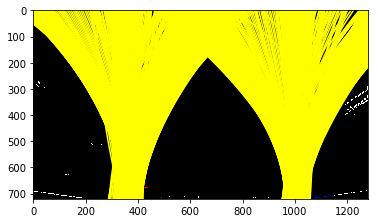

In [24]:
project_video_detector = LaneLineDetector(mtx, dist, src, dst)

project_video_clip = VideoFileClip(project_video_path)
project_video_output_clip = project_video_clip.fl_image(project_video_detector.process_image)
%time project_video_output_clip.write_videofile(project_video_output_path, audio=False)